In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#import important libraries
import numpy as np
import pandas as pd
import tensorflow as tf
tf.keras.preprocessing.image.ImageDataGenerator.flow_from_dataframe?
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_classes_df = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
train_classes_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
!ls ../input/planets-dataset/planet/planet/train-jpg | wc -l

40479


In [5]:
sample_submission_df = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [6]:
test1 = !ls ../input/planets-dataset/planet/planet/test-jpg | wc -l
test2 = !ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc -l
assert sample_submission_df.shape[0] == float(test1[0])+float(test2[0])

In [7]:
test1

['40669']

In [8]:
test2

['20522']

In [9]:
image_number =3
img = io.imread('../input/planets-dataset/planet/planet/train-jpg/train_{}.jpg'.format(image_number))
img.shape

(256, 256, 3)

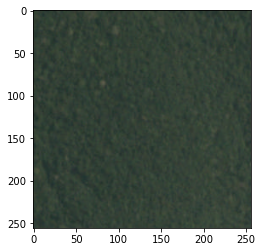

In [10]:
plt.imshow(img)

In [11]:
train_classes_df[train_classes_df['image_name'] == 'train_3']

,image_name,tags
3,train_3,clear primary


In [12]:
unique_labels = set()
def append_labels(tags):
    for tag in tags.split():
        unique_labels.add(tag)

train_classes = train_classes_df.copy()
train_classes['tags'].apply(append_labels)
unique_labels = list(unique_labels)
print(unique_labels)

['partly_cloudy', 'bare_ground', 'slash_burn', 'haze', 'habitation', 'cultivation', 'conventional_mine', 'primary', 'blow_down', 'selective_logging', 'artisinal_mine', 'agriculture', 'blooming', 'road', 'clear', 'water', 'cloudy']


In [13]:
len(unique_labels)

17

In [14]:
assert len(train_classes['image_name'].unique()) == train_classes.shape[0]

In [15]:
# let's one hot encode the labels in 'train_classes'
for tag in unique_labels:
    train_classes[tag] = train_classes['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
# adding '.jpg' extension to 'image_name'
train_classes['image_name'] = train_classes['image_name'].apply(lambda x: '{}.jpg'.format(x)) 
train_classes.head()

,image_name,tags,partly_cloudy,bare_ground,slash_burn,haze,habitation,cultivation,conventional_mine,primary,blow_down,selective_logging,artisinal_mine,agriculture,blooming,road,clear,water,cloudy
0,train_0.jpg,haze primary,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0
2,train_2.jpg,clear primary,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,train_3.jpg,clear primary,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0


In [16]:
y_col = list(train_classes.columns[2:]) # storing the tags column names as a variable

# initializing an image generator with some data augumentation
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# loading images from dataframe
X = image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=1, batch_size=128)

Found 40479 validated image filenames.


In [17]:
#40479 / 128 is 316 remainder 31 each image is of shape (128, 128, 3), each label is of shape (17, )

# let's abitrarily view an image
x109 = X[0][0][109] # first batch, images, 109th image
y109 = X[0][1][109] # first batch, labels, 109th label
print("each image's shape is {}".format(x109.shape))
print("each label's shape is {}".format(y109.shape))
print('we have {} batches'.format(len(X)))
print('each batch has {} images/labels'.format(X[0][0].shape[0]))
print('40479/128 is {:.2F}, so the last batch will have {} images/labels'.format(40479/128, X[316][0].shape[0]))

each image's shape is (128, 128, 3)
each label's shape is (17,)
we have 317 batches


each batch has 128 images/labels
40479/128 is 316.24, so the last batch will have 31 images/labels


In [18]:
def fbeta(ytrue , ypred, beta=2, epsilon=1e-4):
    beta_squarred = beta**2

    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
        
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1+beta_squarred)*precision*recall / (beta_squarred*precision + recall + epsilon)
    return fb

In [19]:
def multi_label_acc(ytrue , ypred, epsilon=1e-4):
    
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    ytrue = tf.cast(ytrue, tf.bool)
    ypred = tf.cast(ypred, tf.bool)
    
    tn = tf.reduce_sum(tf.cast(tf.logical_not(ytrue), tf.float32) * tf.cast(tf.logical_not(ypred), tf.float32),\
                       axis=1)
    
    return (tp+tn)/(tp+tn+fp+fn+epsilon)

def build_vggmodel():
    base_model = VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=(128, 128, 3), classifier_activation=None)
    model = Sequential()

    model.add(BatchNormalization(input_shape=(128, 128, 3)))


    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.5))

    model.add(Dense(17, activation='sigmoid'))
    opt = SGD(lr=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[multi_label_acc, fbeta])
    
    return model

In [20]:
def build_rsnetmodel():
    base_model =tf.keras.applications.ResNet152( 
                    include_top=False,
                    weights="imagenet",
                    input_shape=(128, 128, 3),
                    pooling=max)
    model = Sequential()

    model.add(BatchNormalization(input_shape=(128, 128, 3)))


    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.5))

    model.add(Dense(17, activation='sigmoid'))
    opt = SGD(lr=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[multi_label_acc, fbeta])
    
    return model

save_best_check_point = ModelCheckpoint(filepath='best_vggmodel.hdf5', monitor='val_fbeta', \
                                        mode='max', save_best_only=True, save_weights_only=True)

In [21]:
save_best_check_point2 = ModelCheckpoint(filepath='best_rsnetmodel.hdf5', monitor='val_fbeta', \
                                        mode='max', save_best_only=True, save_weights_only=True)

In [22]:
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.2)

# generating the 80% training image data
train_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='../input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='training')

# generating the 20% validation image data
val_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='../input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='validation')

Found 32384 validated image filenames.


Found 8095 validated image filenames.


In [23]:
# setting step size for training and validation image data
step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))
step_val_size = int(np.ceil(val_gen.samples / train_gen.batch_size))

In [24]:
step_train_size+step_val_size

317

turn on GPU

vgg_model = build_vggmodel() # building a sequential model for training

# fitting the model
vgg_model.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,
         epochs=15, callbacks=[save_best_check_point])

In [25]:
rsnet_model = build_rsnetmodel() # building a sequential model for training

# fitting the model
rsnet_model.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,
         epochs=25, callbacks=[save_best_check_point2])

     8192/234698864 [..............................] - ETA: 8s

  3776512/234698864 [..............................] - ETA: 3s

  4202496/234698864 [..............................] - ETA: 6s

  9641984/234698864 [>.............................] - ETA: 3s

 16162816/234698864 [=>............................] - ETA: 2s

 23838720/234698864 [==>...........................] - ETA: 2s

 25174016/234698864 [==>...........................] - ETA: 3s

 35971072/234698864 [===>..........................] - ETA: 2s

 41951232/234698864 [====>.........................] - ETA: 2s

 52928512/234698864 [=====>........................] - ETA: 2s

 64708608/234698864 [=======>......................] - ETA: 1s

 67117056/234698864 [=======>......................] - ETA: 1s

 77012992/234698864 [========>.....................] - ETA: 1s

 85958656/234698864 [=========>....................] - ETA: 1s

 92282880/234698864 [==========>...................] - ETA: 1s

100163584/234698864 [===========>..................] - ETA: 1s

111624192/234698864 [=============>................] - ETA: 1s

122871808/234698864 [==============>...............] - ETA: 1s

134348800/234698864 [================>.............] - ETA: 0s

145817600/234698864 [=================>............] - ETA: 0s

157097984/234698864 [===================>..........] - ETA: 0s

168542208/234698864 [====================>.........] - ETA: 0s

179232768/234698864 [=====================>........] - ETA: 0s

189972480/234698864 [=======================>......] - ETA: 0s

201334784/234698864 [========================>.....] - ETA: 0s

211116032/234698864 [=========================>....] - ETA: 0s

221626368/234698864 [===========================>..] - ETA: 0s

232955904/234698864 [============================>.] - ETA: 0s

234700800/234698864 [==============================] - 2s 0us/step


Epoch 1/25


  1/253 [..............................] - ETA: 0s - loss: 1.3000 - multi_label_acc: 0.5161 - fbeta: 0.3620

  2/253 [..............................] - ETA: 1:08 - loss: 1.0721 - multi_label_acc: 0.5898 - fbeta: 0.3991

  3/253 [..............................] - ETA: 1:37 - loss: 0.9365 - multi_label_acc: 0.6392 - fbeta: 0.4346

  4/253 [..............................] - ETA: 1:49 - loss: 0.8446 - multi_label_acc: 0.6773 - fbeta: 0.4653

  5/253 [..............................] - ETA: 2:05 - loss: 0.7964 - multi_label_acc: 0.6998 - fbeta: 0.4810

  6/253 [..............................] - ETA: 2:08 - loss: 0.7555 - multi_label_acc: 0.7181 - fbeta: 0.4933

  7/253 [..............................] - ETA: 2:10 - loss: 0.7221 - multi_label_acc: 0.7327 - fbeta: 0.5100

  8/253 [..............................] - ETA: 2:11 - loss: 0.6927 - multi_label_acc: 0.7466 - fbeta: 0.5222

  9/253 [>.............................] - ETA: 2:12 - loss: 0.6652 - multi_label_acc: 0.7595 - fbeta: 0.5334

 10/253 [>.............................] - ETA: 2:12 - loss: 0.6449 - multi_label_acc: 0.7687 - fbeta: 0.5422

 11/253 [>.............................] - ETA: 2:13 - loss: 0.6251 - multi_label_acc: 0.7765 - fbeta: 0.5480

 12/253 [>.............................] - ETA: 2:12 - loss: 0.6061 - multi_label_acc: 0.7852 - fbeta: 0.5587

 13/253 [>.............................] - ETA: 2:12 - loss: 0.5918 - multi_label_acc: 0.7918 - fbeta: 0.5660

 14/253 [>.............................] - ETA: 2:12 - loss: 0.5780 - multi_label_acc: 0.7975 - fbeta: 0.5720

 15/253 [>.............................] - ETA: 2:13 - loss: 0.5634 - multi_label_acc: 0.8035 - fbeta: 0.5792

 16/253 [>.............................] - ETA: 2:12 - loss: 0.5515 - multi_label_acc: 0.8081 - fbeta: 0.5838

 17/253 [=>............................] - ETA: 2:12 - loss: 0.5428 - multi_label_acc: 0.8118 - fbeta: 0.5881

 18/253 [=>............................] - ETA: 2:12 - loss: 0.5344 - multi_label_acc: 0.8154 - fbeta: 0.5909

 19/253 [=>............................] - ETA: 2:12 - loss: 0.5255 - multi_label_acc: 0.8192 - fbeta: 0.5955

 20/253 [=>............................] - ETA: 2:11 - loss: 0.5181 - multi_label_acc: 0.8227 - fbeta: 0.5998

 21/253 [=>............................] - ETA: 2:10 - loss: 0.5099 - multi_label_acc: 0.8257 - fbeta: 0.6029

 22/253 [=>............................] - ETA: 2:10 - loss: 0.5010 - multi_label_acc: 0.8289 - fbeta: 0.6070

 23/253 [=>............................] - ETA: 2:11 - loss: 0.4957 - multi_label_acc: 0.8317 - fbeta: 0.6111

 24/253 [=>............................] - ETA: 2:12 - loss: 0.4901 - multi_label_acc: 0.8344 - fbeta: 0.6142

 25/253 [=>............................] - ETA: 2:11 - loss: 0.4844 - multi_label_acc: 0.8366 - fbeta: 0.6176

 26/253 [==>...........................] - ETA: 2:11 - loss: 0.4772 - multi_label_acc: 0.8392 - fbeta: 0.6219

 27/253 [==>...........................] - ETA: 2:11 - loss: 0.4728 - multi_label_acc: 0.8413 - fbeta: 0.6253

 28/253 [==>...........................] - ETA: 2:10 - loss: 0.4672 - multi_label_acc: 0.8431 - fbeta: 0.6279

 29/253 [==>...........................] - ETA: 2:10 - loss: 0.4622 - multi_label_acc: 0.8451 - fbeta: 0.6299

 30/253 [==>...........................] - ETA: 2:09 - loss: 0.4581 - multi_label_acc: 0.8470 - fbeta: 0.6329

 31/253 [==>...........................] - ETA: 2:09 - loss: 0.4532 - multi_label_acc: 0.8487 - fbeta: 0.6345

 32/253 [==>...........................] - ETA: 2:09 - loss: 0.4492 - multi_label_acc: 0.8502 - fbeta: 0.6364

 33/253 [==>...........................] - ETA: 2:08 - loss: 0.4439 - multi_label_acc: 0.8520 - fbeta: 0.6393

 34/253 [===>..........................] - ETA: 2:07 - loss: 0.4403 - multi_label_acc: 0.8536 - fbeta: 0.6419

 35/253 [===>..........................] - ETA: 2:07 - loss: 0.4360 - multi_label_acc: 0.8551 - fbeta: 0.6446

 36/253 [===>..........................] - ETA: 2:07 - loss: 0.4330 - multi_label_acc: 0.8564 - fbeta: 0.6464

 37/253 [===>..........................] - ETA: 2:07 - loss: 0.4305 - multi_label_acc: 0.8575 - fbeta: 0.6471

 38/253 [===>..........................] - ETA: 2:06 - loss: 0.4271 - multi_label_acc: 0.8588 - fbeta: 0.6496

 39/253 [===>..........................] - ETA: 2:06 - loss: 0.4234 - multi_label_acc: 0.8601 - fbeta: 0.6520

 40/253 [===>..........................] - ETA: 2:05 - loss: 0.4204 - multi_label_acc: 0.8613 - fbeta: 0.6537

 41/253 [===>..........................] - ETA: 2:06 - loss: 0.4172 - multi_label_acc: 0.8624 - fbeta: 0.6558

 42/253 [===>..........................] - ETA: 2:05 - loss: 0.4132 - multi_label_acc: 0.8636 - fbeta: 0.6576

 43/253 [====>.........................] - ETA: 2:05 - loss: 0.4101 - multi_label_acc: 0.8648 - fbeta: 0.6599

 44/253 [====>.........................] - ETA: 2:04 - loss: 0.4072 - multi_label_acc: 0.8658 - fbeta: 0.6610

 45/253 [====>.........................] - ETA: 2:03 - loss: 0.4046 - multi_label_acc: 0.8667 - fbeta: 0.6623

 46/253 [====>.........................] - ETA: 2:03 - loss: 0.4021 - multi_label_acc: 0.8677 - fbeta: 0.6644

 47/253 [====>.........................] - ETA: 2:02 - loss: 0.3989 - multi_label_acc: 0.8689 - fbeta: 0.6667

 48/253 [====>.........................] - ETA: 2:01 - loss: 0.3967 - multi_label_acc: 0.8698 - fbeta: 0.6681

 49/253 [====>.........................] - ETA: 2:01 - loss: 0.3942 - multi_label_acc: 0.8707 - fbeta: 0.6697

 50/253 [====>.........................] - ETA: 2:00 - loss: 0.3918 - multi_label_acc: 0.8716 - fbeta: 0.6714

 51/253 [=====>........................] - ETA: 2:00 - loss: 0.3898 - multi_label_acc: 0.8722 - fbeta: 0.6726

 52/253 [=====>........................] - ETA: 1:59 - loss: 0.3878 - multi_label_acc: 0.8730 - fbeta: 0.6742

 53/253 [=====>........................] - ETA: 1:59 - loss: 0.3852 - multi_label_acc: 0.8740 - fbeta: 0.6760

 54/253 [=====>........................] - ETA: 1:58 - loss: 0.3836 - multi_label_acc: 0.8746 - fbeta: 0.6772

 55/253 [=====>........................] - ETA: 1:58 - loss: 0.3813 - multi_label_acc: 0.8754 - fbeta: 0.6786

 56/253 [=====>........................] - ETA: 1:57 - loss: 0.3794 - multi_label_acc: 0.8760 - fbeta: 0.6798

 57/253 [=====>........................] - ETA: 1:57 - loss: 0.3781 - multi_label_acc: 0.8765 - fbeta: 0.6809

 58/253 [=====>........................] - ETA: 1:56 - loss: 0.3761 - multi_label_acc: 0.8771 - fbeta: 0.6821

 59/253 [=====>........................] - ETA: 1:56 - loss: 0.3745 - multi_label_acc: 0.8777 - fbeta: 0.6829

 60/253 [======>.......................] - ETA: 1:56 - loss: 0.3723 - multi_label_acc: 0.8784 - fbeta: 0.6846

 61/253 [======>.......................] - ETA: 1:55 - loss: 0.3699 - multi_label_acc: 0.8791 - fbeta: 0.6862

 62/253 [======>.......................] - ETA: 1:54 - loss: 0.3680 - multi_label_acc: 0.8796 - fbeta: 0.6873

 63/253 [======>.......................] - ETA: 1:54 - loss: 0.3659 - multi_label_acc: 0.8804 - fbeta: 0.6888

 64/253 [======>.......................] - ETA: 1:53 - loss: 0.3644 - multi_label_acc: 0.8810 - fbeta: 0.6895

 65/253 [======>.......................] - ETA: 1:53 - loss: 0.3624 - multi_label_acc: 0.8815 - fbeta: 0.6905

 66/253 [======>.......................] - ETA: 1:52 - loss: 0.3606 - multi_label_acc: 0.8821 - fbeta: 0.6916

 67/253 [======>.......................] - ETA: 1:52 - loss: 0.3585 - multi_label_acc: 0.8827 - fbeta: 0.6929

 68/253 [=======>......................] - ETA: 1:51 - loss: 0.3573 - multi_label_acc: 0.8832 - fbeta: 0.6936

 69/253 [=======>......................] - ETA: 1:51 - loss: 0.3560 - multi_label_acc: 0.8836 - fbeta: 0.6945

 70/253 [=======>......................] - ETA: 1:50 - loss: 0.3545 - multi_label_acc: 0.8841 - fbeta: 0.6951

 71/253 [=======>......................] - ETA: 1:49 - loss: 0.3532 - multi_label_acc: 0.8846 - fbeta: 0.6961

 72/253 [=======>......................] - ETA: 1:49 - loss: 0.3518 - multi_label_acc: 0.8851 - fbeta: 0.6974

 73/253 [=======>......................] - ETA: 1:48 - loss: 0.3504 - multi_label_acc: 0.8856 - fbeta: 0.6984

 74/253 [=======>......................] - ETA: 1:48 - loss: 0.3492 - multi_label_acc: 0.8861 - fbeta: 0.6992

 75/253 [=======>......................] - ETA: 1:47 - loss: 0.3471 - multi_label_acc: 0.8867 - fbeta: 0.7005

 76/253 [========>.....................] - ETA: 1:46 - loss: 0.3458 - multi_label_acc: 0.8872 - fbeta: 0.7014

 77/253 [========>.....................] - ETA: 1:46 - loss: 0.3443 - multi_label_acc: 0.8877 - fbeta: 0.7027

 78/253 [========>.....................] - ETA: 1:46 - loss: 0.3431 - multi_label_acc: 0.8882 - fbeta: 0.7031

 79/253 [========>.....................] - ETA: 1:45 - loss: 0.3415 - multi_label_acc: 0.8887 - fbeta: 0.7040

 80/253 [========>.....................] - ETA: 1:44 - loss: 0.3399 - multi_label_acc: 0.8892 - fbeta: 0.7047

 81/253 [========>.....................] - ETA: 1:44 - loss: 0.3382 - multi_label_acc: 0.8898 - fbeta: 0.7060

 82/253 [========>.....................] - ETA: 1:43 - loss: 0.3367 - multi_label_acc: 0.8902 - fbeta: 0.7069

 83/253 [========>.....................] - ETA: 1:43 - loss: 0.3355 - multi_label_acc: 0.8906 - fbeta: 0.7077

 84/253 [========>.....................] - ETA: 1:42 - loss: 0.3347 - multi_label_acc: 0.8909 - fbeta: 0.7086

 85/253 [=========>....................] - ETA: 1:41 - loss: 0.3337 - multi_label_acc: 0.8913 - fbeta: 0.7094

 86/253 [=========>....................] - ETA: 1:41 - loss: 0.3325 - multi_label_acc: 0.8917 - fbeta: 0.7105

 87/253 [=========>....................] - ETA: 1:40 - loss: 0.3316 - multi_label_acc: 0.8920 - fbeta: 0.7112

 88/253 [=========>....................] - ETA: 1:40 - loss: 0.3306 - multi_label_acc: 0.8924 - fbeta: 0.7119

 89/253 [=========>....................] - ETA: 1:39 - loss: 0.3296 - multi_label_acc: 0.8927 - fbeta: 0.7124

 90/253 [=========>....................] - ETA: 1:39 - loss: 0.3281 - multi_label_acc: 0.8932 - fbeta: 0.7135

 91/253 [=========>....................] - ETA: 1:38 - loss: 0.3272 - multi_label_acc: 0.8935 - fbeta: 0.7142

 92/253 [=========>....................] - ETA: 1:37 - loss: 0.3258 - multi_label_acc: 0.8939 - fbeta: 0.7149

 93/253 [==========>...................] - ETA: 1:37 - loss: 0.3250 - multi_label_acc: 0.8942 - fbeta: 0.7157

 94/253 [==========>...................] - ETA: 1:36 - loss: 0.3241 - multi_label_acc: 0.8944 - fbeta: 0.7162

 95/253 [==========>...................] - ETA: 1:36 - loss: 0.3228 - multi_label_acc: 0.8949 - fbeta: 0.7172

 96/253 [==========>...................] - ETA: 1:35 - loss: 0.3216 - multi_label_acc: 0.8952 - fbeta: 0.7181

 97/253 [==========>...................] - ETA: 1:35 - loss: 0.3206 - multi_label_acc: 0.8955 - fbeta: 0.7190

 98/253 [==========>...................] - ETA: 1:34 - loss: 0.3198 - multi_label_acc: 0.8958 - fbeta: 0.7197

 99/253 [==========>...................] - ETA: 1:33 - loss: 0.3186 - multi_label_acc: 0.8962 - fbeta: 0.7207

100/253 [==========>...................] - ETA: 1:33 - loss: 0.3178 - multi_label_acc: 0.8965 - fbeta: 0.7212

101/253 [==========>...................] - ETA: 1:32 - loss: 0.3168 - multi_label_acc: 0.8968 - fbeta: 0.7216

102/253 [===========>..................] - ETA: 1:31 - loss: 0.3159 - multi_label_acc: 0.8970 - fbeta: 0.7222

103/253 [===========>..................] - ETA: 1:31 - loss: 0.3149 - multi_label_acc: 0.8973 - fbeta: 0.7231

104/253 [===========>..................] - ETA: 1:30 - loss: 0.3138 - multi_label_acc: 0.8977 - fbeta: 0.7239

105/253 [===========>..................] - ETA: 1:30 - loss: 0.3128 - multi_label_acc: 0.8980 - fbeta: 0.7247

106/253 [===========>..................] - ETA: 1:29 - loss: 0.3119 - multi_label_acc: 0.8983 - fbeta: 0.7253

107/253 [===========>..................] - ETA: 1:28 - loss: 0.3109 - multi_label_acc: 0.8986 - fbeta: 0.7261

108/253 [===========>..................] - ETA: 1:28 - loss: 0.3095 - multi_label_acc: 0.8990 - fbeta: 0.7267

109/253 [===========>..................] - ETA: 1:27 - loss: 0.3084 - multi_label_acc: 0.8993 - fbeta: 0.7275

110/253 [============>.................] - ETA: 1:26 - loss: 0.3075 - multi_label_acc: 0.8996 - fbeta: 0.7281

111/253 [============>.................] - ETA: 1:26 - loss: 0.3067 - multi_label_acc: 0.8998 - fbeta: 0.7286

112/253 [============>.................] - ETA: 1:25 - loss: 0.3059 - multi_label_acc: 0.9001 - fbeta: 0.7292

113/253 [============>.................] - ETA: 1:25 - loss: 0.3051 - multi_label_acc: 0.9003 - fbeta: 0.7298

114/253 [============>.................] - ETA: 1:24 - loss: 0.3044 - multi_label_acc: 0.9006 - fbeta: 0.7302

115/253 [============>.................] - ETA: 1:23 - loss: 0.3034 - multi_label_acc: 0.9009 - fbeta: 0.7308

116/253 [============>.................] - ETA: 1:23 - loss: 0.3027 - multi_label_acc: 0.9011 - fbeta: 0.7316

117/253 [============>.................] - ETA: 1:22 - loss: 0.3019 - multi_label_acc: 0.9014 - fbeta: 0.7320

118/253 [============>.................] - ETA: 1:22 - loss: 0.3010 - multi_label_acc: 0.9017 - fbeta: 0.7326

119/253 [=============>................] - ETA: 1:21 - loss: 0.3001 - multi_label_acc: 0.9020 - fbeta: 0.7333

120/253 [=============>................] - ETA: 1:20 - loss: 0.2994 - multi_label_acc: 0.9022 - fbeta: 0.7340

121/253 [=============>................] - ETA: 1:20 - loss: 0.2984 - multi_label_acc: 0.9025 - fbeta: 0.7347

122/253 [=============>................] - ETA: 1:19 - loss: 0.2976 - multi_label_acc: 0.9027 - fbeta: 0.7351

123/253 [=============>................] - ETA: 1:18 - loss: 0.2970 - multi_label_acc: 0.9029 - fbeta: 0.7356

124/253 [=============>................] - ETA: 1:18 - loss: 0.2964 - multi_label_acc: 0.9031 - fbeta: 0.7363

125/253 [=============>................] - ETA: 1:17 - loss: 0.2959 - multi_label_acc: 0.9034 - fbeta: 0.7366

126/253 [=============>................] - ETA: 1:17 - loss: 0.2954 - multi_label_acc: 0.9035 - fbeta: 0.7369

127/253 [==============>...............] - ETA: 1:16 - loss: 0.2945 - multi_label_acc: 0.9038 - fbeta: 0.7376

128/253 [==============>...............] - ETA: 1:15 - loss: 0.2937 - multi_label_acc: 0.9040 - fbeta: 0.7380

129/253 [==============>...............] - ETA: 1:15 - loss: 0.2929 - multi_label_acc: 0.9042 - fbeta: 0.7385

130/253 [==============>...............] - ETA: 1:14 - loss: 0.2924 - multi_label_acc: 0.9044 - fbeta: 0.7390

131/253 [==============>...............] - ETA: 1:14 - loss: 0.2920 - multi_label_acc: 0.9046 - fbeta: 0.7392

132/253 [==============>...............] - ETA: 1:13 - loss: 0.2912 - multi_label_acc: 0.9048 - fbeta: 0.7397

133/253 [==============>...............] - ETA: 1:12 - loss: 0.2903 - multi_label_acc: 0.9051 - fbeta: 0.7402

134/253 [==============>...............] - ETA: 1:12 - loss: 0.2897 - multi_label_acc: 0.9054 - fbeta: 0.7409

135/253 [===============>..............] - ETA: 1:11 - loss: 0.2895 - multi_label_acc: 0.9055 - fbeta: 0.7410

136/253 [===============>..............] - ETA: 1:11 - loss: 0.2889 - multi_label_acc: 0.9057 - fbeta: 0.7416

137/253 [===============>..............] - ETA: 1:10 - loss: 0.2882 - multi_label_acc: 0.9059 - fbeta: 0.7421

138/253 [===============>..............] - ETA: 1:09 - loss: 0.2875 - multi_label_acc: 0.9061 - fbeta: 0.7425

139/253 [===============>..............] - ETA: 1:09 - loss: 0.2869 - multi_label_acc: 0.9063 - fbeta: 0.7430

140/253 [===============>..............] - ETA: 1:08 - loss: 0.2864 - multi_label_acc: 0.9064 - fbeta: 0.7434

141/253 [===============>..............] - ETA: 1:08 - loss: 0.2859 - multi_label_acc: 0.9066 - fbeta: 0.7439

142/253 [===============>..............] - ETA: 1:07 - loss: 0.2854 - multi_label_acc: 0.9068 - fbeta: 0.7445

143/253 [===============>..............] - ETA: 1:06 - loss: 0.2848 - multi_label_acc: 0.9070 - fbeta: 0.7448

144/253 [================>.............] - ETA: 1:06 - loss: 0.2841 - multi_label_acc: 0.9072 - fbeta: 0.7453

145/253 [================>.............] - ETA: 1:05 - loss: 0.2837 - multi_label_acc: 0.9073 - fbeta: 0.7455

146/253 [================>.............] - ETA: 1:05 - loss: 0.2831 - multi_label_acc: 0.9074 - fbeta: 0.7459

147/253 [================>.............] - ETA: 1:04 - loss: 0.2826 - multi_label_acc: 0.9076 - fbeta: 0.7462

148/253 [================>.............] - ETA: 1:03 - loss: 0.2820 - multi_label_acc: 0.9077 - fbeta: 0.7465

149/253 [================>.............] - ETA: 1:03 - loss: 0.2814 - multi_label_acc: 0.9080 - fbeta: 0.7470

150/253 [================>.............] - ETA: 1:02 - loss: 0.2806 - multi_label_acc: 0.9082 - fbeta: 0.7476

151/253 [================>.............] - ETA: 1:02 - loss: 0.2800 - multi_label_acc: 0.9083 - fbeta: 0.7480

152/253 [=================>............] - ETA: 1:01 - loss: 0.2797 - multi_label_acc: 0.9085 - fbeta: 0.7482

153/253 [=================>............] - ETA: 1:01 - loss: 0.2790 - multi_label_acc: 0.9087 - fbeta: 0.7487

154/253 [=================>............] - ETA: 1:00 - loss: 0.2786 - multi_label_acc: 0.9088 - fbeta: 0.7490

155/253 [=================>............] - ETA: 59s - loss: 0.2782 - multi_label_acc: 0.9089 - fbeta: 0.7492 

156/253 [=================>............] - ETA: 59s - loss: 0.2776 - multi_label_acc: 0.9091 - fbeta: 0.7494

157/253 [=================>............] - ETA: 58s - loss: 0.2772 - multi_label_acc: 0.9092 - fbeta: 0.7498

158/253 [=================>............] - ETA: 58s - loss: 0.2767 - multi_label_acc: 0.9094 - fbeta: 0.7502

159/253 [=================>............] - ETA: 57s - loss: 0.2760 - multi_label_acc: 0.9096 - fbeta: 0.7508

160/253 [=================>............] - ETA: 56s - loss: 0.2755 - multi_label_acc: 0.9098 - fbeta: 0.7511

161/253 [==================>...........] - ETA: 56s - loss: 0.2749 - multi_label_acc: 0.9100 - fbeta: 0.7515

162/253 [==================>...........] - ETA: 55s - loss: 0.2743 - multi_label_acc: 0.9102 - fbeta: 0.7518

163/253 [==================>...........] - ETA: 55s - loss: 0.2738 - multi_label_acc: 0.9103 - fbeta: 0.7523

164/253 [==================>...........] - ETA: 54s - loss: 0.2733 - multi_label_acc: 0.9105 - fbeta: 0.7526

165/253 [==================>...........] - ETA: 53s - loss: 0.2729 - multi_label_acc: 0.9106 - fbeta: 0.7528

166/253 [==================>...........] - ETA: 53s - loss: 0.2725 - multi_label_acc: 0.9107 - fbeta: 0.7532

167/253 [==================>...........] - ETA: 52s - loss: 0.2720 - multi_label_acc: 0.9108 - fbeta: 0.7534

168/253 [==================>...........] - ETA: 52s - loss: 0.2716 - multi_label_acc: 0.9109 - fbeta: 0.7534

169/253 [===================>..........] - ETA: 51s - loss: 0.2709 - multi_label_acc: 0.9111 - fbeta: 0.7539

170/253 [===================>..........] - ETA: 50s - loss: 0.2704 - multi_label_acc: 0.9113 - fbeta: 0.7543

171/253 [===================>..........] - ETA: 50s - loss: 0.2699 - multi_label_acc: 0.9115 - fbeta: 0.7548

172/253 [===================>..........] - ETA: 49s - loss: 0.2695 - multi_label_acc: 0.9116 - fbeta: 0.7551

173/253 [===================>..........] - ETA: 48s - loss: 0.2690 - multi_label_acc: 0.9118 - fbeta: 0.7554

174/253 [===================>..........] - ETA: 48s - loss: 0.2683 - multi_label_acc: 0.9119 - fbeta: 0.7559

175/253 [===================>..........] - ETA: 47s - loss: 0.2678 - multi_label_acc: 0.9121 - fbeta: 0.7563

176/253 [===================>..........] - ETA: 47s - loss: 0.2673 - multi_label_acc: 0.9123 - fbeta: 0.7567

177/253 [===================>..........] - ETA: 46s - loss: 0.2668 - multi_label_acc: 0.9124 - fbeta: 0.7570

178/253 [====================>.........] - ETA: 45s - loss: 0.2665 - multi_label_acc: 0.9125 - fbeta: 0.7573

179/253 [====================>.........] - ETA: 45s - loss: 0.2659 - multi_label_acc: 0.9126 - fbeta: 0.7577

180/253 [====================>.........] - ETA: 44s - loss: 0.2655 - multi_label_acc: 0.9128 - fbeta: 0.7581

181/253 [====================>.........] - ETA: 44s - loss: 0.2651 - multi_label_acc: 0.9129 - fbeta: 0.7584

182/253 [====================>.........] - ETA: 43s - loss: 0.2646 - multi_label_acc: 0.9131 - fbeta: 0.7589

183/253 [====================>.........] - ETA: 42s - loss: 0.2640 - multi_label_acc: 0.9133 - fbeta: 0.7593

184/253 [====================>.........] - ETA: 42s - loss: 0.2637 - multi_label_acc: 0.9134 - fbeta: 0.7594

185/253 [====================>.........] - ETA: 41s - loss: 0.2634 - multi_label_acc: 0.9135 - fbeta: 0.7596

186/253 [=====================>........] - ETA: 40s - loss: 0.2628 - multi_label_acc: 0.9137 - fbeta: 0.7601

187/253 [=====================>........] - ETA: 40s - loss: 0.2623 - multi_label_acc: 0.9138 - fbeta: 0.7605

188/253 [=====================>........] - ETA: 39s - loss: 0.2617 - multi_label_acc: 0.9140 - fbeta: 0.7609

189/253 [=====================>........] - ETA: 39s - loss: 0.2611 - multi_label_acc: 0.9142 - fbeta: 0.7614

190/253 [=====================>........] - ETA: 38s - loss: 0.2608 - multi_label_acc: 0.9143 - fbeta: 0.7617

191/253 [=====================>........] - ETA: 37s - loss: 0.2604 - multi_label_acc: 0.9145 - fbeta: 0.7620

192/253 [=====================>........] - ETA: 37s - loss: 0.2599 - multi_label_acc: 0.9146 - fbeta: 0.7623

193/253 [=====================>........] - ETA: 36s - loss: 0.2595 - multi_label_acc: 0.9148 - fbeta: 0.7627

194/253 [======================>.......] - ETA: 36s - loss: 0.2591 - multi_label_acc: 0.9149 - fbeta: 0.7629

195/253 [======================>.......] - ETA: 35s - loss: 0.2587 - multi_label_acc: 0.9149 - fbeta: 0.7631

196/253 [======================>.......] - ETA: 34s - loss: 0.2584 - multi_label_acc: 0.9151 - fbeta: 0.7632

197/253 [======================>.......] - ETA: 34s - loss: 0.2580 - multi_label_acc: 0.9152 - fbeta: 0.7636

198/253 [======================>.......] - ETA: 33s - loss: 0.2576 - multi_label_acc: 0.9153 - fbeta: 0.7637

199/253 [======================>.......] - ETA: 33s - loss: 0.2572 - multi_label_acc: 0.9154 - fbeta: 0.7640

200/253 [======================>.......] - ETA: 32s - loss: 0.2569 - multi_label_acc: 0.9155 - fbeta: 0.7643

201/253 [======================>.......] - ETA: 31s - loss: 0.2565 - multi_label_acc: 0.9156 - fbeta: 0.7646

202/253 [======================>.......] - ETA: 31s - loss: 0.2559 - multi_label_acc: 0.9157 - fbeta: 0.7650

203/253 [=======================>......] - ETA: 30s - loss: 0.2555 - multi_label_acc: 0.9159 - fbeta: 0.7654

204/253 [=======================>......] - ETA: 30s - loss: 0.2551 - multi_label_acc: 0.9160 - fbeta: 0.7657

205/253 [=======================>......] - ETA: 29s - loss: 0.2547 - multi_label_acc: 0.9162 - fbeta: 0.7660

206/253 [=======================>......] - ETA: 28s - loss: 0.2542 - multi_label_acc: 0.9163 - fbeta: 0.7663

207/253 [=======================>......] - ETA: 28s - loss: 0.2538 - multi_label_acc: 0.9164 - fbeta: 0.7666

208/253 [=======================>......] - ETA: 27s - loss: 0.2533 - multi_label_acc: 0.9166 - fbeta: 0.7670

209/253 [=======================>......] - ETA: 26s - loss: 0.2529 - multi_label_acc: 0.9167 - fbeta: 0.7672

210/253 [=======================>......] - ETA: 26s - loss: 0.2527 - multi_label_acc: 0.9168 - fbeta: 0.7674

211/253 [========================>.....] - ETA: 25s - loss: 0.2523 - multi_label_acc: 0.9169 - fbeta: 0.7677

212/253 [========================>.....] - ETA: 25s - loss: 0.2519 - multi_label_acc: 0.9170 - fbeta: 0.7680

213/253 [========================>.....] - ETA: 24s - loss: 0.2515 - multi_label_acc: 0.9171 - fbeta: 0.7682

214/253 [========================>.....] - ETA: 23s - loss: 0.2512 - multi_label_acc: 0.9172 - fbeta: 0.7684

215/253 [========================>.....] - ETA: 23s - loss: 0.2508 - multi_label_acc: 0.9173 - fbeta: 0.7687

216/253 [========================>.....] - ETA: 22s - loss: 0.2504 - multi_label_acc: 0.9174 - fbeta: 0.7690

217/253 [========================>.....] - ETA: 22s - loss: 0.2500 - multi_label_acc: 0.9175 - fbeta: 0.7693

218/253 [========================>.....] - ETA: 21s - loss: 0.2496 - multi_label_acc: 0.9177 - fbeta: 0.7696

219/253 [========================>.....] - ETA: 20s - loss: 0.2492 - multi_label_acc: 0.9178 - fbeta: 0.7699

220/253 [=========================>....] - ETA: 20s - loss: 0.2490 - multi_label_acc: 0.9179 - fbeta: 0.7701

221/253 [=========================>....] - ETA: 19s - loss: 0.2486 - multi_label_acc: 0.9180 - fbeta: 0.7703

222/253 [=========================>....] - ETA: 18s - loss: 0.2483 - multi_label_acc: 0.9180 - fbeta: 0.7704

223/253 [=========================>....] - ETA: 18s - loss: 0.2481 - multi_label_acc: 0.9181 - fbeta: 0.7706

224/253 [=========================>....] - ETA: 17s - loss: 0.2478 - multi_label_acc: 0.9182 - fbeta: 0.7709

225/253 [=========================>....] - ETA: 17s - loss: 0.2473 - multi_label_acc: 0.9183 - fbeta: 0.7712

226/253 [=========================>....] - ETA: 16s - loss: 0.2470 - multi_label_acc: 0.9184 - fbeta: 0.7715

227/253 [=========================>....] - ETA: 15s - loss: 0.2467 - multi_label_acc: 0.9185 - fbeta: 0.7716

228/253 [==========================>...] - ETA: 15s - loss: 0.2465 - multi_label_acc: 0.9186 - fbeta: 0.7718

229/253 [==========================>...] - ETA: 14s - loss: 0.2462 - multi_label_acc: 0.9187 - fbeta: 0.7721

230/253 [==========================>...] - ETA: 14s - loss: 0.2459 - multi_label_acc: 0.9188 - fbeta: 0.7723

231/253 [==========================>...] - ETA: 13s - loss: 0.2456 - multi_label_acc: 0.9189 - fbeta: 0.7724

232/253 [==========================>...] - ETA: 12s - loss: 0.2452 - multi_label_acc: 0.9190 - fbeta: 0.7726

233/253 [==========================>...] - ETA: 12s - loss: 0.2449 - multi_label_acc: 0.9191 - fbeta: 0.7729

234/253 [==========================>...] - ETA: 11s - loss: 0.2446 - multi_label_acc: 0.9191 - fbeta: 0.7731

235/253 [==========================>...] - ETA: 10s - loss: 0.2443 - multi_label_acc: 0.9193 - fbeta: 0.7733

236/253 [==========================>...] - ETA: 10s - loss: 0.2438 - multi_label_acc: 0.9194 - fbeta: 0.7736

237/253 [===========================>..] - ETA: 9s - loss: 0.2434 - multi_label_acc: 0.9195 - fbeta: 0.7739 

238/253 [===========================>..] - ETA: 9s - loss: 0.2430 - multi_label_acc: 0.9196 - fbeta: 0.7742

239/253 [===========================>..] - ETA: 8s - loss: 0.2428 - multi_label_acc: 0.9197 - fbeta: 0.7743

240/253 [===========================>..] - ETA: 7s - loss: 0.2424 - multi_label_acc: 0.9198 - fbeta: 0.7746

241/253 [===========================>..] - ETA: 7s - loss: 0.2422 - multi_label_acc: 0.9199 - fbeta: 0.7748

242/253 [===========================>..] - ETA: 6s - loss: 0.2419 - multi_label_acc: 0.9199 - fbeta: 0.7749

243/253 [===========================>..] - ETA: 6s - loss: 0.2417 - multi_label_acc: 0.9201 - fbeta: 0.7752

244/253 [===========================>..] - ETA: 5s - loss: 0.2414 - multi_label_acc: 0.9202 - fbeta: 0.7754

245/253 [============================>.] - ETA: 4s - loss: 0.2411 - multi_label_acc: 0.9202 - fbeta: 0.7755

246/253 [============================>.] - ETA: 4s - loss: 0.2408 - multi_label_acc: 0.9203 - fbeta: 0.7758

247/253 [============================>.] - ETA: 3s - loss: 0.2404 - multi_label_acc: 0.9204 - fbeta: 0.7759

248/253 [============================>.] - ETA: 3s - loss: 0.2400 - multi_label_acc: 0.9205 - fbeta: 0.7762

249/253 [============================>.] - ETA: 2s - loss: 0.2397 - multi_label_acc: 0.9206 - fbeta: 0.7765

250/253 [============================>.] - ETA: 1s - loss: 0.2393 - multi_label_acc: 0.9207 - fbeta: 0.7768

251/253 [============================>.] - ETA: 1s - loss: 0.2391 - multi_label_acc: 0.9208 - fbeta: 0.7769

252/253 [============================>.] - ETA: 0s - loss: 0.2389 - multi_label_acc: 0.9208 - fbeta: 0.7771

253/253 [==============================] - ETA: 0s - loss: 0.2386 - multi_label_acc: 0.9209 - fbeta: 0.7771

253/253 [==============================] - 192s 759ms/step - loss: 0.2386 - multi_label_acc: 0.9209 - fbeta: 0.7771 - val_loss: 2.9096 - val_multi_label_acc: 0.7791 - val_fbeta: 0.0523


Epoch 2/25


  1/253 [..............................] - ETA: 39s - loss: 0.1263 - multi_label_acc: 0.9527 - fbeta: 0.8559

  2/253 [..............................] - ETA: 1:26 - loss: 0.1403 - multi_label_acc: 0.9492 - fbeta: 0.8610

  3/253 [..............................] - ETA: 1:42 - loss: 0.1411 - multi_label_acc: 0.9496 - fbeta: 0.8609

  4/253 [..............................] - ETA: 1:50 - loss: 0.1500 - multi_label_acc: 0.9485 - fbeta: 0.8498

  5/253 [..............................] - ETA: 1:54 - loss: 0.1516 - multi_label_acc: 0.9487 - fbeta: 0.8521

  6/253 [..............................] - ETA: 1:57 - loss: 0.1509 - multi_label_acc: 0.9497 - fbeta: 0.8546

  7/253 [..............................] - ETA: 1:58 - loss: 0.1526 - multi_label_acc: 0.9485 - fbeta: 0.8509

  8/253 [..............................] - ETA: 2:00 - loss: 0.1522 - multi_label_acc: 0.9484 - fbeta: 0.8502

  9/253 [>.............................] - ETA: 2:00 - loss: 0.1533 - multi_label_acc: 0.9478 - fbeta: 0.8475

 10/253 [>.............................] - ETA: 2:01 - loss: 0.1526 - multi_label_acc: 0.9484 - fbeta: 0.8497

 11/253 [>.............................] - ETA: 2:01 - loss: 0.1514 - multi_label_acc: 0.9486 - fbeta: 0.8499

 12/253 [>.............................] - ETA: 2:01 - loss: 0.1563 - multi_label_acc: 0.9469 - fbeta: 0.8434

 13/253 [>.............................] - ETA: 2:01 - loss: 0.1554 - multi_label_acc: 0.9473 - fbeta: 0.8437

 14/253 [>.............................] - ETA: 2:01 - loss: 0.1569 - multi_label_acc: 0.9470 - fbeta: 0.8436

 15/253 [>.............................] - ETA: 2:03 - loss: 0.1560 - multi_label_acc: 0.9472 - fbeta: 0.8448

 16/253 [>.............................] - ETA: 2:03 - loss: 0.1567 - multi_label_acc: 0.9465 - fbeta: 0.8423

 17/253 [=>............................] - ETA: 2:03 - loss: 0.1560 - multi_label_acc: 0.9468 - fbeta: 0.8432

 18/253 [=>............................] - ETA: 2:02 - loss: 0.1565 - multi_label_acc: 0.9463 - fbeta: 0.8417

 19/253 [=>............................] - ETA: 2:02 - loss: 0.1564 - multi_label_acc: 0.9462 - fbeta: 0.8421

 20/253 [=>............................] - ETA: 2:02 - loss: 0.1561 - multi_label_acc: 0.9462 - fbeta: 0.8415

 21/253 [=>............................] - ETA: 2:01 - loss: 0.1558 - multi_label_acc: 0.9460 - fbeta: 0.8398

 22/253 [=>............................] - ETA: 2:01 - loss: 0.1546 - multi_label_acc: 0.9464 - fbeta: 0.8407

 23/253 [=>............................] - ETA: 2:00 - loss: 0.1534 - multi_label_acc: 0.9466 - fbeta: 0.8416

 24/253 [=>............................] - ETA: 2:00 - loss: 0.1536 - multi_label_acc: 0.9464 - fbeta: 0.8398

 25/253 [=>............................] - ETA: 2:00 - loss: 0.1522 - multi_label_acc: 0.9470 - fbeta: 0.8411

 26/253 [==>...........................] - ETA: 1:59 - loss: 0.1520 - multi_label_acc: 0.9471 - fbeta: 0.8415

 27/253 [==>...........................] - ETA: 1:59 - loss: 0.1508 - multi_label_acc: 0.9474 - fbeta: 0.8423

 28/253 [==>...........................] - ETA: 1:59 - loss: 0.1508 - multi_label_acc: 0.9475 - fbeta: 0.8427

 29/253 [==>...........................] - ETA: 1:58 - loss: 0.1514 - multi_label_acc: 0.9474 - fbeta: 0.8419

 30/253 [==>...........................] - ETA: 1:58 - loss: 0.1516 - multi_label_acc: 0.9473 - fbeta: 0.8419

 31/253 [==>...........................] - ETA: 1:57 - loss: 0.1519 - multi_label_acc: 0.9472 - fbeta: 0.8420

 32/253 [==>...........................] - ETA: 1:57 - loss: 0.1526 - multi_label_acc: 0.9468 - fbeta: 0.8411

 33/253 [==>...........................] - ETA: 1:56 - loss: 0.1532 - multi_label_acc: 0.9466 - fbeta: 0.8404

 34/253 [===>..........................] - ETA: 1:56 - loss: 0.1533 - multi_label_acc: 0.9465 - fbeta: 0.8403

 35/253 [===>..........................] - ETA: 1:56 - loss: 0.1536 - multi_label_acc: 0.9465 - fbeta: 0.8405

 36/253 [===>..........................] - ETA: 1:56 - loss: 0.1535 - multi_label_acc: 0.9464 - fbeta: 0.8406

 37/253 [===>..........................] - ETA: 1:56 - loss: 0.1536 - multi_label_acc: 0.9464 - fbeta: 0.8401

 38/253 [===>..........................] - ETA: 1:56 - loss: 0.1533 - multi_label_acc: 0.9464 - fbeta: 0.8404

 39/253 [===>..........................] - ETA: 1:55 - loss: 0.1539 - multi_label_acc: 0.9462 - fbeta: 0.8391

 40/253 [===>..........................] - ETA: 1:55 - loss: 0.1531 - multi_label_acc: 0.9464 - fbeta: 0.8397

 41/253 [===>..........................] - ETA: 1:54 - loss: 0.1530 - multi_label_acc: 0.9465 - fbeta: 0.8397

 42/253 [===>..........................] - ETA: 1:54 - loss: 0.1521 - multi_label_acc: 0.9469 - fbeta: 0.8408

 43/253 [====>.........................] - ETA: 1:53 - loss: 0.1524 - multi_label_acc: 0.9468 - fbeta: 0.8402

 44/253 [====>.........................] - ETA: 1:52 - loss: 0.1527 - multi_label_acc: 0.9468 - fbeta: 0.8399

 45/253 [====>.........................] - ETA: 1:52 - loss: 0.1535 - multi_label_acc: 0.9467 - fbeta: 0.8398

 46/253 [====>.........................] - ETA: 1:51 - loss: 0.1538 - multi_label_acc: 0.9467 - fbeta: 0.8395

 47/253 [====>.........................] - ETA: 1:51 - loss: 0.1530 - multi_label_acc: 0.9469 - fbeta: 0.8402

 48/253 [====>.........................] - ETA: 1:51 - loss: 0.1533 - multi_label_acc: 0.9467 - fbeta: 0.8397

 49/253 [====>.........................] - ETA: 1:50 - loss: 0.1533 - multi_label_acc: 0.9467 - fbeta: 0.8393

 50/253 [====>.........................] - ETA: 1:49 - loss: 0.1533 - multi_label_acc: 0.9466 - fbeta: 0.8391

 51/253 [=====>........................] - ETA: 1:49 - loss: 0.1527 - multi_label_acc: 0.9468 - fbeta: 0.8397

 52/253 [=====>........................] - ETA: 1:48 - loss: 0.1523 - multi_label_acc: 0.9469 - fbeta: 0.8400

 53/253 [=====>........................] - ETA: 1:48 - loss: 0.1530 - multi_label_acc: 0.9468 - fbeta: 0.8398

 54/253 [=====>........................] - ETA: 1:47 - loss: 0.1528 - multi_label_acc: 0.9469 - fbeta: 0.8402

 55/253 [=====>........................] - ETA: 1:47 - loss: 0.1523 - multi_label_acc: 0.9470 - fbeta: 0.8406

 56/253 [=====>........................] - ETA: 1:47 - loss: 0.1521 - multi_label_acc: 0.9471 - fbeta: 0.8412

 57/253 [=====>........................] - ETA: 1:46 - loss: 0.1517 - multi_label_acc: 0.9473 - fbeta: 0.8419

 58/253 [=====>........................] - ETA: 1:46 - loss: 0.1516 - multi_label_acc: 0.9473 - fbeta: 0.8420

 59/253 [=====>........................] - ETA: 1:45 - loss: 0.1518 - multi_label_acc: 0.9472 - fbeta: 0.8415

 60/253 [======>.......................] - ETA: 1:45 - loss: 0.1523 - multi_label_acc: 0.9470 - fbeta: 0.8411

 61/253 [======>.......................] - ETA: 1:44 - loss: 0.1523 - multi_label_acc: 0.9471 - fbeta: 0.8412

 62/253 [======>.......................] - ETA: 1:43 - loss: 0.1524 - multi_label_acc: 0.9469 - fbeta: 0.8411

 63/253 [======>.......................] - ETA: 1:43 - loss: 0.1526 - multi_label_acc: 0.9469 - fbeta: 0.8408

 64/253 [======>.......................] - ETA: 1:42 - loss: 0.1525 - multi_label_acc: 0.9469 - fbeta: 0.8408

 65/253 [======>.......................] - ETA: 1:42 - loss: 0.1524 - multi_label_acc: 0.9469 - fbeta: 0.8410

 66/253 [======>.......................] - ETA: 1:41 - loss: 0.1523 - multi_label_acc: 0.9470 - fbeta: 0.8412

 67/253 [======>.......................] - ETA: 1:41 - loss: 0.1524 - multi_label_acc: 0.9470 - fbeta: 0.8411

 68/253 [=======>......................] - ETA: 1:40 - loss: 0.1523 - multi_label_acc: 0.9469 - fbeta: 0.8408

 69/253 [=======>......................] - ETA: 1:39 - loss: 0.1529 - multi_label_acc: 0.9468 - fbeta: 0.8405

 70/253 [=======>......................] - ETA: 1:39 - loss: 0.1529 - multi_label_acc: 0.9467 - fbeta: 0.8402

 71/253 [=======>......................] - ETA: 1:38 - loss: 0.1527 - multi_label_acc: 0.9468 - fbeta: 0.8403

 72/253 [=======>......................] - ETA: 1:38 - loss: 0.1528 - multi_label_acc: 0.9468 - fbeta: 0.8406

 73/253 [=======>......................] - ETA: 1:37 - loss: 0.1529 - multi_label_acc: 0.9467 - fbeta: 0.8404

 74/253 [=======>......................] - ETA: 1:37 - loss: 0.1532 - multi_label_acc: 0.9467 - fbeta: 0.8404

 75/253 [=======>......................] - ETA: 1:36 - loss: 0.1530 - multi_label_acc: 0.9468 - fbeta: 0.8407

 76/253 [========>.....................] - ETA: 1:36 - loss: 0.1531 - multi_label_acc: 0.9468 - fbeta: 0.8406

 77/253 [========>.....................] - ETA: 1:35 - loss: 0.1528 - multi_label_acc: 0.9468 - fbeta: 0.8411

 78/253 [========>.....................] - ETA: 1:35 - loss: 0.1529 - multi_label_acc: 0.9468 - fbeta: 0.8409

 79/253 [========>.....................] - ETA: 1:34 - loss: 0.1528 - multi_label_acc: 0.9469 - fbeta: 0.8411

 80/253 [========>.....................] - ETA: 1:34 - loss: 0.1527 - multi_label_acc: 0.9469 - fbeta: 0.8414

 81/253 [========>.....................] - ETA: 1:33 - loss: 0.1530 - multi_label_acc: 0.9468 - fbeta: 0.8408

 82/253 [========>.....................] - ETA: 1:32 - loss: 0.1530 - multi_label_acc: 0.9468 - fbeta: 0.8410

 83/253 [========>.....................] - ETA: 1:32 - loss: 0.1528 - multi_label_acc: 0.9469 - fbeta: 0.8414

 84/253 [========>.....................] - ETA: 1:31 - loss: 0.1526 - multi_label_acc: 0.9469 - fbeta: 0.8414

 85/253 [=========>....................] - ETA: 1:31 - loss: 0.1525 - multi_label_acc: 0.9469 - fbeta: 0.8414

 86/253 [=========>....................] - ETA: 1:30 - loss: 0.1523 - multi_label_acc: 0.9469 - fbeta: 0.8416

 87/253 [=========>....................] - ETA: 1:30 - loss: 0.1526 - multi_label_acc: 0.9469 - fbeta: 0.8415

 88/253 [=========>....................] - ETA: 1:29 - loss: 0.1525 - multi_label_acc: 0.9469 - fbeta: 0.8415

 89/253 [=========>....................] - ETA: 1:29 - loss: 0.1528 - multi_label_acc: 0.9468 - fbeta: 0.8412

 90/253 [=========>....................] - ETA: 1:28 - loss: 0.1529 - multi_label_acc: 0.9467 - fbeta: 0.8410

 91/253 [=========>....................] - ETA: 1:28 - loss: 0.1528 - multi_label_acc: 0.9467 - fbeta: 0.8410

 92/253 [=========>....................] - ETA: 1:27 - loss: 0.1526 - multi_label_acc: 0.9467 - fbeta: 0.8410

 93/253 [==========>...................] - ETA: 1:26 - loss: 0.1524 - multi_label_acc: 0.9468 - fbeta: 0.8412

 94/253 [==========>...................] - ETA: 1:26 - loss: 0.1523 - multi_label_acc: 0.9468 - fbeta: 0.8415

 95/253 [==========>...................] - ETA: 1:25 - loss: 0.1521 - multi_label_acc: 0.9469 - fbeta: 0.8414

 96/253 [==========>...................] - ETA: 1:25 - loss: 0.1519 - multi_label_acc: 0.9469 - fbeta: 0.8417

 97/253 [==========>...................] - ETA: 1:24 - loss: 0.1521 - multi_label_acc: 0.9469 - fbeta: 0.8414

 98/253 [==========>...................] - ETA: 1:24 - loss: 0.1523 - multi_label_acc: 0.9467 - fbeta: 0.8412

 99/253 [==========>...................] - ETA: 1:23 - loss: 0.1522 - multi_label_acc: 0.9468 - fbeta: 0.8414

100/253 [==========>...................] - ETA: 1:23 - loss: 0.1521 - multi_label_acc: 0.9467 - fbeta: 0.8413

101/253 [==========>...................] - ETA: 1:22 - loss: 0.1523 - multi_label_acc: 0.9466 - fbeta: 0.8411

102/253 [===========>..................] - ETA: 1:22 - loss: 0.1522 - multi_label_acc: 0.9466 - fbeta: 0.8412

103/253 [===========>..................] - ETA: 1:21 - loss: 0.1521 - multi_label_acc: 0.9466 - fbeta: 0.8413

104/253 [===========>..................] - ETA: 1:20 - loss: 0.1521 - multi_label_acc: 0.9466 - fbeta: 0.8411

105/253 [===========>..................] - ETA: 1:20 - loss: 0.1521 - multi_label_acc: 0.9466 - fbeta: 0.8411

106/253 [===========>..................] - ETA: 1:19 - loss: 0.1524 - multi_label_acc: 0.9465 - fbeta: 0.8406

107/253 [===========>..................] - ETA: 1:19 - loss: 0.1525 - multi_label_acc: 0.9464 - fbeta: 0.8406

108/253 [===========>..................] - ETA: 1:18 - loss: 0.1525 - multi_label_acc: 0.9464 - fbeta: 0.8406

109/253 [===========>..................] - ETA: 1:18 - loss: 0.1526 - multi_label_acc: 0.9463 - fbeta: 0.8404

110/253 [============>.................] - ETA: 1:17 - loss: 0.1528 - multi_label_acc: 0.9463 - fbeta: 0.8405

111/253 [============>.................] - ETA: 1:17 - loss: 0.1527 - multi_label_acc: 0.9463 - fbeta: 0.8403

112/253 [============>.................] - ETA: 1:16 - loss: 0.1527 - multi_label_acc: 0.9463 - fbeta: 0.8401

113/253 [============>.................] - ETA: 1:16 - loss: 0.1527 - multi_label_acc: 0.9463 - fbeta: 0.8402

114/253 [============>.................] - ETA: 1:15 - loss: 0.1530 - multi_label_acc: 0.9463 - fbeta: 0.8401

115/253 [============>.................] - ETA: 1:14 - loss: 0.1530 - multi_label_acc: 0.9463 - fbeta: 0.8399

116/253 [============>.................] - ETA: 1:14 - loss: 0.1530 - multi_label_acc: 0.9463 - fbeta: 0.8400

117/253 [============>.................] - ETA: 1:14 - loss: 0.1529 - multi_label_acc: 0.9463 - fbeta: 0.8400

118/253 [============>.................] - ETA: 1:13 - loss: 0.1531 - multi_label_acc: 0.9462 - fbeta: 0.8398

119/253 [=============>................] - ETA: 1:12 - loss: 0.1531 - multi_label_acc: 0.9462 - fbeta: 0.8399

120/253 [=============>................] - ETA: 1:12 - loss: 0.1532 - multi_label_acc: 0.9461 - fbeta: 0.8398

121/253 [=============>................] - ETA: 1:11 - loss: 0.1533 - multi_label_acc: 0.9461 - fbeta: 0.8397

122/253 [=============>................] - ETA: 1:11 - loss: 0.1531 - multi_label_acc: 0.9462 - fbeta: 0.8399

123/253 [=============>................] - ETA: 1:10 - loss: 0.1530 - multi_label_acc: 0.9462 - fbeta: 0.8398

124/253 [=============>................] - ETA: 1:10 - loss: 0.1531 - multi_label_acc: 0.9461 - fbeta: 0.8398

125/253 [=============>................] - ETA: 1:09 - loss: 0.1531 - multi_label_acc: 0.9461 - fbeta: 0.8396

126/253 [=============>................] - ETA: 1:09 - loss: 0.1530 - multi_label_acc: 0.9461 - fbeta: 0.8396

127/253 [==============>...............] - ETA: 1:08 - loss: 0.1529 - multi_label_acc: 0.9461 - fbeta: 0.8395

128/253 [==============>...............] - ETA: 1:07 - loss: 0.1528 - multi_label_acc: 0.9461 - fbeta: 0.8397

129/253 [==============>...............] - ETA: 1:07 - loss: 0.1527 - multi_label_acc: 0.9461 - fbeta: 0.8398

130/253 [==============>...............] - ETA: 1:06 - loss: 0.1526 - multi_label_acc: 0.9461 - fbeta: 0.8399

131/253 [==============>...............] - ETA: 1:06 - loss: 0.1526 - multi_label_acc: 0.9461 - fbeta: 0.8398

132/253 [==============>...............] - ETA: 1:05 - loss: 0.1524 - multi_label_acc: 0.9462 - fbeta: 0.8399

133/253 [==============>...............] - ETA: 1:05 - loss: 0.1524 - multi_label_acc: 0.9462 - fbeta: 0.8399

134/253 [==============>...............] - ETA: 1:04 - loss: 0.1524 - multi_label_acc: 0.9462 - fbeta: 0.8400

135/253 [===============>..............] - ETA: 1:04 - loss: 0.1523 - multi_label_acc: 0.9462 - fbeta: 0.8401

136/253 [===============>..............] - ETA: 1:03 - loss: 0.1523 - multi_label_acc: 0.9462 - fbeta: 0.8400

137/253 [===============>..............] - ETA: 1:03 - loss: 0.1523 - multi_label_acc: 0.9463 - fbeta: 0.8402

138/253 [===============>..............] - ETA: 1:02 - loss: 0.1522 - multi_label_acc: 0.9463 - fbeta: 0.8401

139/253 [===============>..............] - ETA: 1:02 - loss: 0.1523 - multi_label_acc: 0.9463 - fbeta: 0.8400

140/253 [===============>..............] - ETA: 1:01 - loss: 0.1522 - multi_label_acc: 0.9463 - fbeta: 0.8401

141/253 [===============>..............] - ETA: 1:00 - loss: 0.1521 - multi_label_acc: 0.9463 - fbeta: 0.8402

142/253 [===============>..............] - ETA: 1:00 - loss: 0.1521 - multi_label_acc: 0.9463 - fbeta: 0.8401

143/253 [===============>..............] - ETA: 59s - loss: 0.1520 - multi_label_acc: 0.9463 - fbeta: 0.8403 

144/253 [================>.............] - ETA: 59s - loss: 0.1518 - multi_label_acc: 0.9464 - fbeta: 0.8405

145/253 [================>.............] - ETA: 58s - loss: 0.1518 - multi_label_acc: 0.9464 - fbeta: 0.8404

146/253 [================>.............] - ETA: 58s - loss: 0.1515 - multi_label_acc: 0.9465 - fbeta: 0.8407

147/253 [================>.............] - ETA: 57s - loss: 0.1514 - multi_label_acc: 0.9465 - fbeta: 0.8409

148/253 [================>.............] - ETA: 57s - loss: 0.1516 - multi_label_acc: 0.9465 - fbeta: 0.8407

149/253 [================>.............] - ETA: 56s - loss: 0.1516 - multi_label_acc: 0.9465 - fbeta: 0.8407

150/253 [================>.............] - ETA: 56s - loss: 0.1519 - multi_label_acc: 0.9464 - fbeta: 0.8404

151/253 [================>.............] - ETA: 55s - loss: 0.1518 - multi_label_acc: 0.9465 - fbeta: 0.8406

152/253 [=================>............] - ETA: 55s - loss: 0.1518 - multi_label_acc: 0.9465 - fbeta: 0.8407

153/253 [=================>............] - ETA: 54s - loss: 0.1517 - multi_label_acc: 0.9466 - fbeta: 0.8409

154/253 [=================>............] - ETA: 54s - loss: 0.1516 - multi_label_acc: 0.9466 - fbeta: 0.8409

155/253 [=================>............] - ETA: 53s - loss: 0.1515 - multi_label_acc: 0.9466 - fbeta: 0.8409

156/253 [=================>............] - ETA: 53s - loss: 0.1515 - multi_label_acc: 0.9467 - fbeta: 0.8410

157/253 [=================>............] - ETA: 52s - loss: 0.1515 - multi_label_acc: 0.9467 - fbeta: 0.8409

158/253 [=================>............] - ETA: 51s - loss: 0.1514 - multi_label_acc: 0.9467 - fbeta: 0.8411

159/253 [=================>............] - ETA: 51s - loss: 0.1513 - multi_label_acc: 0.9467 - fbeta: 0.8413

160/253 [=================>............] - ETA: 50s - loss: 0.1512 - multi_label_acc: 0.9468 - fbeta: 0.8415

161/253 [==================>...........] - ETA: 50s - loss: 0.1510 - multi_label_acc: 0.9468 - fbeta: 0.8416

162/253 [==================>...........] - ETA: 49s - loss: 0.1508 - multi_label_acc: 0.9469 - fbeta: 0.8417

163/253 [==================>...........] - ETA: 49s - loss: 0.1509 - multi_label_acc: 0.9469 - fbeta: 0.8416

164/253 [==================>...........] - ETA: 48s - loss: 0.1510 - multi_label_acc: 0.9468 - fbeta: 0.8416

165/253 [==================>...........] - ETA: 48s - loss: 0.1510 - multi_label_acc: 0.9468 - fbeta: 0.8415

166/253 [==================>...........] - ETA: 47s - loss: 0.1510 - multi_label_acc: 0.9469 - fbeta: 0.8416

167/253 [==================>...........] - ETA: 46s - loss: 0.1511 - multi_label_acc: 0.9469 - fbeta: 0.8415

168/253 [==================>...........] - ETA: 46s - loss: 0.1510 - multi_label_acc: 0.9469 - fbeta: 0.8415

169/253 [===================>..........] - ETA: 45s - loss: 0.1509 - multi_label_acc: 0.9469 - fbeta: 0.8417

170/253 [===================>..........] - ETA: 45s - loss: 0.1509 - multi_label_acc: 0.9469 - fbeta: 0.8417

171/253 [===================>..........] - ETA: 44s - loss: 0.1508 - multi_label_acc: 0.9469 - fbeta: 0.8418

172/253 [===================>..........] - ETA: 44s - loss: 0.1508 - multi_label_acc: 0.9470 - fbeta: 0.8418

173/253 [===================>..........] - ETA: 43s - loss: 0.1508 - multi_label_acc: 0.9470 - fbeta: 0.8420

174/253 [===================>..........] - ETA: 43s - loss: 0.1508 - multi_label_acc: 0.9470 - fbeta: 0.8419

175/253 [===================>..........] - ETA: 42s - loss: 0.1508 - multi_label_acc: 0.9469 - fbeta: 0.8419

176/253 [===================>..........] - ETA: 42s - loss: 0.1506 - multi_label_acc: 0.9470 - fbeta: 0.8420

177/253 [===================>..........] - ETA: 41s - loss: 0.1507 - multi_label_acc: 0.9470 - fbeta: 0.8419

178/253 [====================>.........] - ETA: 40s - loss: 0.1506 - multi_label_acc: 0.9470 - fbeta: 0.8421

179/253 [====================>.........] - ETA: 40s - loss: 0.1504 - multi_label_acc: 0.9471 - fbeta: 0.8421

180/253 [====================>.........] - ETA: 39s - loss: 0.1504 - multi_label_acc: 0.9471 - fbeta: 0.8420

181/253 [====================>.........] - ETA: 39s - loss: 0.1507 - multi_label_acc: 0.9470 - fbeta: 0.8418

182/253 [====================>.........] - ETA: 38s - loss: 0.1507 - multi_label_acc: 0.9470 - fbeta: 0.8418

183/253 [====================>.........] - ETA: 38s - loss: 0.1506 - multi_label_acc: 0.9470 - fbeta: 0.8419

184/253 [====================>.........] - ETA: 37s - loss: 0.1506 - multi_label_acc: 0.9470 - fbeta: 0.8419

185/253 [====================>.........] - ETA: 37s - loss: 0.1506 - multi_label_acc: 0.9470 - fbeta: 0.8418

186/253 [=====================>........] - ETA: 36s - loss: 0.1505 - multi_label_acc: 0.9470 - fbeta: 0.8419

187/253 [=====================>........] - ETA: 36s - loss: 0.1506 - multi_label_acc: 0.9470 - fbeta: 0.8418

188/253 [=====================>........] - ETA: 35s - loss: 0.1505 - multi_label_acc: 0.9470 - fbeta: 0.8419

189/253 [=====================>........] - ETA: 34s - loss: 0.1505 - multi_label_acc: 0.9470 - fbeta: 0.8419

190/253 [=====================>........] - ETA: 34s - loss: 0.1504 - multi_label_acc: 0.9470 - fbeta: 0.8420

191/253 [=====================>........] - ETA: 33s - loss: 0.1505 - multi_label_acc: 0.9470 - fbeta: 0.8421

192/253 [=====================>........] - ETA: 33s - loss: 0.1505 - multi_label_acc: 0.9469 - fbeta: 0.8419

193/253 [=====================>........] - ETA: 32s - loss: 0.1506 - multi_label_acc: 0.9469 - fbeta: 0.8418

194/253 [======================>.......] - ETA: 32s - loss: 0.1507 - multi_label_acc: 0.9469 - fbeta: 0.8416

195/253 [======================>.......] - ETA: 31s - loss: 0.1507 - multi_label_acc: 0.9469 - fbeta: 0.8416

196/253 [======================>.......] - ETA: 31s - loss: 0.1506 - multi_label_acc: 0.9469 - fbeta: 0.8417

197/253 [======================>.......] - ETA: 30s - loss: 0.1506 - multi_label_acc: 0.9469 - fbeta: 0.8416

198/253 [======================>.......] - ETA: 30s - loss: 0.1506 - multi_label_acc: 0.9469 - fbeta: 0.8417

199/253 [======================>.......] - ETA: 29s - loss: 0.1506 - multi_label_acc: 0.9468 - fbeta: 0.8417

200/253 [======================>.......] - ETA: 28s - loss: 0.1506 - multi_label_acc: 0.9469 - fbeta: 0.8417

201/253 [======================>.......] - ETA: 28s - loss: 0.1505 - multi_label_acc: 0.9469 - fbeta: 0.8419

202/253 [======================>.......] - ETA: 27s - loss: 0.1503 - multi_label_acc: 0.9470 - fbeta: 0.8421

203/253 [=======================>......] - ETA: 27s - loss: 0.1504 - multi_label_acc: 0.9469 - fbeta: 0.8420

204/253 [=======================>......] - ETA: 26s - loss: 0.1503 - multi_label_acc: 0.9470 - fbeta: 0.8420

205/253 [=======================>......] - ETA: 26s - loss: 0.1502 - multi_label_acc: 0.9470 - fbeta: 0.8422

206/253 [=======================>......] - ETA: 25s - loss: 0.1502 - multi_label_acc: 0.9470 - fbeta: 0.8421

207/253 [=======================>......] - ETA: 25s - loss: 0.1501 - multi_label_acc: 0.9471 - fbeta: 0.8421

208/253 [=======================>......] - ETA: 24s - loss: 0.1501 - multi_label_acc: 0.9471 - fbeta: 0.8421

209/253 [=======================>......] - ETA: 24s - loss: 0.1501 - multi_label_acc: 0.9470 - fbeta: 0.8421

210/253 [=======================>......] - ETA: 23s - loss: 0.1502 - multi_label_acc: 0.9470 - fbeta: 0.8419

211/253 [========================>.....] - ETA: 22s - loss: 0.1502 - multi_label_acc: 0.9470 - fbeta: 0.8418

212/253 [========================>.....] - ETA: 22s - loss: 0.1504 - multi_label_acc: 0.9470 - fbeta: 0.8416

213/253 [========================>.....] - ETA: 21s - loss: 0.1502 - multi_label_acc: 0.9470 - fbeta: 0.8419

214/253 [========================>.....] - ETA: 21s - loss: 0.1501 - multi_label_acc: 0.9470 - fbeta: 0.8418

215/253 [========================>.....] - ETA: 20s - loss: 0.1501 - multi_label_acc: 0.9470 - fbeta: 0.8419

216/253 [========================>.....] - ETA: 20s - loss: 0.1501 - multi_label_acc: 0.9471 - fbeta: 0.8420

217/253 [========================>.....] - ETA: 19s - loss: 0.1501 - multi_label_acc: 0.9471 - fbeta: 0.8422

218/253 [========================>.....] - ETA: 19s - loss: 0.1501 - multi_label_acc: 0.9471 - fbeta: 0.8422

219/253 [========================>.....] - ETA: 18s - loss: 0.1500 - multi_label_acc: 0.9471 - fbeta: 0.8423

220/253 [=========================>....] - ETA: 18s - loss: 0.1499 - multi_label_acc: 0.9472 - fbeta: 0.8423

221/253 [=========================>....] - ETA: 17s - loss: 0.1501 - multi_label_acc: 0.9471 - fbeta: 0.8421

222/253 [=========================>....] - ETA: 16s - loss: 0.1500 - multi_label_acc: 0.9471 - fbeta: 0.8421

223/253 [=========================>....] - ETA: 16s - loss: 0.1500 - multi_label_acc: 0.9470 - fbeta: 0.8420

224/253 [=========================>....] - ETA: 15s - loss: 0.1500 - multi_label_acc: 0.9470 - fbeta: 0.8421

225/253 [=========================>....] - ETA: 15s - loss: 0.1500 - multi_label_acc: 0.9470 - fbeta: 0.8420

226/253 [=========================>....] - ETA: 14s - loss: 0.1501 - multi_label_acc: 0.9470 - fbeta: 0.8421

227/253 [=========================>....] - ETA: 14s - loss: 0.1500 - multi_label_acc: 0.9471 - fbeta: 0.8422

228/253 [==========================>...] - ETA: 13s - loss: 0.1500 - multi_label_acc: 0.9471 - fbeta: 0.8422

229/253 [==========================>...] - ETA: 13s - loss: 0.1500 - multi_label_acc: 0.9471 - fbeta: 0.8422

230/253 [==========================>...] - ETA: 12s - loss: 0.1500 - multi_label_acc: 0.9470 - fbeta: 0.8421

231/253 [==========================>...] - ETA: 12s - loss: 0.1501 - multi_label_acc: 0.9470 - fbeta: 0.8421

232/253 [==========================>...] - ETA: 11s - loss: 0.1502 - multi_label_acc: 0.9470 - fbeta: 0.8420

233/253 [==========================>...] - ETA: 10s - loss: 0.1501 - multi_label_acc: 0.9470 - fbeta: 0.8420

234/253 [==========================>...] - ETA: 10s - loss: 0.1501 - multi_label_acc: 0.9470 - fbeta: 0.8420

235/253 [==========================>...] - ETA: 9s - loss: 0.1501 - multi_label_acc: 0.9470 - fbeta: 0.8419 

236/253 [==========================>...] - ETA: 9s - loss: 0.1501 - multi_label_acc: 0.9470 - fbeta: 0.8419

237/253 [===========================>..] - ETA: 8s - loss: 0.1499 - multi_label_acc: 0.9471 - fbeta: 0.8422

238/253 [===========================>..] - ETA: 8s - loss: 0.1499 - multi_label_acc: 0.9471 - fbeta: 0.8423

239/253 [===========================>..] - ETA: 7s - loss: 0.1498 - multi_label_acc: 0.9471 - fbeta: 0.8423

240/253 [===========================>..] - ETA: 7s - loss: 0.1498 - multi_label_acc: 0.9472 - fbeta: 0.8424

241/253 [===========================>..] - ETA: 6s - loss: 0.1498 - multi_label_acc: 0.9471 - fbeta: 0.8423

242/253 [===========================>..] - ETA: 6s - loss: 0.1498 - multi_label_acc: 0.9471 - fbeta: 0.8423

243/253 [===========================>..] - ETA: 5s - loss: 0.1497 - multi_label_acc: 0.9472 - fbeta: 0.8424

244/253 [===========================>..] - ETA: 4s - loss: 0.1497 - multi_label_acc: 0.9472 - fbeta: 0.8425

245/253 [============================>.] - ETA: 4s - loss: 0.1497 - multi_label_acc: 0.9472 - fbeta: 0.8424

246/253 [============================>.] - ETA: 3s - loss: 0.1497 - multi_label_acc: 0.9472 - fbeta: 0.8425

247/253 [============================>.] - ETA: 3s - loss: 0.1497 - multi_label_acc: 0.9472 - fbeta: 0.8425

248/253 [============================>.] - ETA: 2s - loss: 0.1496 - multi_label_acc: 0.9472 - fbeta: 0.8426

249/253 [============================>.] - ETA: 2s - loss: 0.1496 - multi_label_acc: 0.9472 - fbeta: 0.8425

250/253 [============================>.] - ETA: 1s - loss: 0.1495 - multi_label_acc: 0.9472 - fbeta: 0.8426

251/253 [============================>.] - ETA: 1s - loss: 0.1494 - multi_label_acc: 0.9473 - fbeta: 0.8427

252/253 [============================>.] - ETA: 0s - loss: 0.1494 - multi_label_acc: 0.9473 - fbeta: 0.8427

253/253 [==============================] - ETA: 0s - loss: 0.1494 - multi_label_acc: 0.9473 - fbeta: 0.8426

253/253 [==============================] - 163s 644ms/step - loss: 0.1494 - multi_label_acc: 0.9473 - fbeta: 0.8426 - val_loss: 0.7253 - val_multi_label_acc: 0.8351 - val_fbeta: 0.2728


Epoch 3/25


  1/253 [..............................] - ETA: 39s - loss: 0.1213 - multi_label_acc: 0.9545 - fbeta: 0.8601

  2/253 [..............................] - ETA: 1:27 - loss: 0.1271 - multi_label_acc: 0.9520 - fbeta: 0.8602

  3/253 [..............................] - ETA: 1:42 - loss: 0.1205 - multi_label_acc: 0.9536 - fbeta: 0.8649

  4/253 [..............................] - ETA: 1:50 - loss: 0.1158 - multi_label_acc: 0.9554 - fbeta: 0.8707

  5/253 [..............................] - ETA: 1:54 - loss: 0.1182 - multi_label_acc: 0.9549 - fbeta: 0.8680

  6/253 [..............................] - ETA: 1:57 - loss: 0.1195 - multi_label_acc: 0.9550 - fbeta: 0.8656

  7/253 [..............................] - ETA: 1:59 - loss: 0.1191 - multi_label_acc: 0.9550 - fbeta: 0.8640

  8/253 [..............................] - ETA: 2:00 - loss: 0.1214 - multi_label_acc: 0.9550 - fbeta: 0.8650

  9/253 [>.............................] - ETA: 2:01 - loss: 0.1224 - multi_label_acc: 0.9553 - fbeta: 0.8651

 10/253 [>.............................] - ETA: 2:01 - loss: 0.1246 - multi_label_acc: 0.9546 - fbeta: 0.8622

 11/253 [>.............................] - ETA: 2:01 - loss: 0.1273 - multi_label_acc: 0.9543 - fbeta: 0.8613

 12/253 [>.............................] - ETA: 2:02 - loss: 0.1300 - multi_label_acc: 0.9535 - fbeta: 0.8566

 13/253 [>.............................] - ETA: 2:02 - loss: 0.1297 - multi_label_acc: 0.9535 - fbeta: 0.8567

 14/253 [>.............................] - ETA: 2:02 - loss: 0.1311 - multi_label_acc: 0.9529 - fbeta: 0.8540

 15/253 [>.............................] - ETA: 2:02 - loss: 0.1318 - multi_label_acc: 0.9526 - fbeta: 0.8536

 16/253 [>.............................] - ETA: 2:02 - loss: 0.1321 - multi_label_acc: 0.9529 - fbeta: 0.8553

 17/253 [=>............................] - ETA: 2:03 - loss: 0.1322 - multi_label_acc: 0.9529 - fbeta: 0.8558

 18/253 [=>............................] - ETA: 2:02 - loss: 0.1325 - multi_label_acc: 0.9528 - fbeta: 0.8559

 19/253 [=>............................] - ETA: 2:02 - loss: 0.1318 - multi_label_acc: 0.9533 - fbeta: 0.8571

 20/253 [=>............................] - ETA: 2:02 - loss: 0.1320 - multi_label_acc: 0.9531 - fbeta: 0.8557

 21/253 [=>............................] - ETA: 2:02 - loss: 0.1308 - multi_label_acc: 0.9533 - fbeta: 0.8567

 22/253 [=>............................] - ETA: 2:01 - loss: 0.1302 - multi_label_acc: 0.9535 - fbeta: 0.8575

 23/253 [=>............................] - ETA: 2:01 - loss: 0.1318 - multi_label_acc: 0.9533 - fbeta: 0.8566

 24/253 [=>............................] - ETA: 2:00 - loss: 0.1328 - multi_label_acc: 0.9527 - fbeta: 0.8550

 25/253 [=>............................] - ETA: 2:00 - loss: 0.1323 - multi_label_acc: 0.9527 - fbeta: 0.8554

 26/253 [==>...........................] - ETA: 1:59 - loss: 0.1326 - multi_label_acc: 0.9523 - fbeta: 0.8548

 27/253 [==>...........................] - ETA: 1:59 - loss: 0.1326 - multi_label_acc: 0.9523 - fbeta: 0.8553

 28/253 [==>...........................] - ETA: 1:58 - loss: 0.1328 - multi_label_acc: 0.9520 - fbeta: 0.8546

 29/253 [==>...........................] - ETA: 1:58 - loss: 0.1328 - multi_label_acc: 0.9520 - fbeta: 0.8544

 30/253 [==>...........................] - ETA: 1:57 - loss: 0.1322 - multi_label_acc: 0.9522 - fbeta: 0.8553

 31/253 [==>...........................] - ETA: 1:57 - loss: 0.1320 - multi_label_acc: 0.9522 - fbeta: 0.8557

 32/253 [==>...........................] - ETA: 1:57 - loss: 0.1325 - multi_label_acc: 0.9520 - fbeta: 0.8560

 33/253 [==>...........................] - ETA: 1:56 - loss: 0.1323 - multi_label_acc: 0.9523 - fbeta: 0.8567

 34/253 [===>..........................] - ETA: 1:56 - loss: 0.1319 - multi_label_acc: 0.9523 - fbeta: 0.8564

 35/253 [===>..........................] - ETA: 1:55 - loss: 0.1324 - multi_label_acc: 0.9523 - fbeta: 0.8564

 36/253 [===>..........................] - ETA: 1:55 - loss: 0.1339 - multi_label_acc: 0.9518 - fbeta: 0.8555

 37/253 [===>..........................] - ETA: 1:55 - loss: 0.1347 - multi_label_acc: 0.9518 - fbeta: 0.8542

 38/253 [===>..........................] - ETA: 1:54 - loss: 0.1346 - multi_label_acc: 0.9517 - fbeta: 0.8544

 39/253 [===>..........................] - ETA: 1:54 - loss: 0.1350 - multi_label_acc: 0.9515 - fbeta: 0.8536

 40/253 [===>..........................] - ETA: 1:53 - loss: 0.1349 - multi_label_acc: 0.9515 - fbeta: 0.8535

 41/253 [===>..........................] - ETA: 1:53 - loss: 0.1342 - multi_label_acc: 0.9518 - fbeta: 0.8541

 42/253 [===>..........................] - ETA: 1:52 - loss: 0.1341 - multi_label_acc: 0.9517 - fbeta: 0.8537

 43/253 [====>.........................] - ETA: 1:52 - loss: 0.1346 - multi_label_acc: 0.9518 - fbeta: 0.8541

 44/253 [====>.........................] - ETA: 1:51 - loss: 0.1342 - multi_label_acc: 0.9517 - fbeta: 0.8537

 45/253 [====>.........................] - ETA: 1:51 - loss: 0.1351 - multi_label_acc: 0.9514 - fbeta: 0.8525

 46/253 [====>.........................] - ETA: 1:50 - loss: 0.1353 - multi_label_acc: 0.9513 - fbeta: 0.8521

 47/253 [====>.........................] - ETA: 1:50 - loss: 0.1350 - multi_label_acc: 0.9514 - fbeta: 0.8522

 48/253 [====>.........................] - ETA: 1:49 - loss: 0.1345 - multi_label_acc: 0.9515 - fbeta: 0.8526

 49/253 [====>.........................] - ETA: 1:49 - loss: 0.1342 - multi_label_acc: 0.9517 - fbeta: 0.8532

 50/253 [====>.........................] - ETA: 1:48 - loss: 0.1351 - multi_label_acc: 0.9515 - fbeta: 0.8525

 51/253 [=====>........................] - ETA: 1:47 - loss: 0.1354 - multi_label_acc: 0.9512 - fbeta: 0.8522

 52/253 [=====>........................] - ETA: 1:47 - loss: 0.1353 - multi_label_acc: 0.9512 - fbeta: 0.8520

 53/253 [=====>........................] - ETA: 1:46 - loss: 0.1350 - multi_label_acc: 0.9513 - fbeta: 0.8526

 54/253 [=====>........................] - ETA: 1:46 - loss: 0.1350 - multi_label_acc: 0.9513 - fbeta: 0.8524

 55/253 [=====>........................] - ETA: 1:45 - loss: 0.1346 - multi_label_acc: 0.9515 - fbeta: 0.8531

 56/253 [=====>........................] - ETA: 1:45 - loss: 0.1348 - multi_label_acc: 0.9515 - fbeta: 0.8530

 57/253 [=====>........................] - ETA: 1:45 - loss: 0.1346 - multi_label_acc: 0.9515 - fbeta: 0.8534

 58/253 [=====>........................] - ETA: 1:45 - loss: 0.1344 - multi_label_acc: 0.9515 - fbeta: 0.8532

 59/253 [=====>........................] - ETA: 1:44 - loss: 0.1343 - multi_label_acc: 0.9516 - fbeta: 0.8534

 60/253 [======>.......................] - ETA: 1:43 - loss: 0.1340 - multi_label_acc: 0.9516 - fbeta: 0.8535

 61/253 [======>.......................] - ETA: 1:43 - loss: 0.1341 - multi_label_acc: 0.9516 - fbeta: 0.8534

 62/253 [======>.......................] - ETA: 1:42 - loss: 0.1340 - multi_label_acc: 0.9517 - fbeta: 0.8536

 63/253 [======>.......................] - ETA: 1:42 - loss: 0.1338 - multi_label_acc: 0.9517 - fbeta: 0.8539

 64/253 [======>.......................] - ETA: 1:41 - loss: 0.1335 - multi_label_acc: 0.9519 - fbeta: 0.8545

 65/253 [======>.......................] - ETA: 1:41 - loss: 0.1334 - multi_label_acc: 0.9519 - fbeta: 0.8546

 66/253 [======>.......................] - ETA: 1:40 - loss: 0.1333 - multi_label_acc: 0.9519 - fbeta: 0.8545

 67/253 [======>.......................] - ETA: 1:40 - loss: 0.1329 - multi_label_acc: 0.9520 - fbeta: 0.8550

 68/253 [=======>......................] - ETA: 1:40 - loss: 0.1329 - multi_label_acc: 0.9520 - fbeta: 0.8552

 69/253 [=======>......................] - ETA: 1:39 - loss: 0.1327 - multi_label_acc: 0.9521 - fbeta: 0.8554

 70/253 [=======>......................] - ETA: 1:39 - loss: 0.1330 - multi_label_acc: 0.9520 - fbeta: 0.8551

 71/253 [=======>......................] - ETA: 1:38 - loss: 0.1331 - multi_label_acc: 0.9520 - fbeta: 0.8552

 72/253 [=======>......................] - ETA: 1:38 - loss: 0.1335 - multi_label_acc: 0.9520 - fbeta: 0.8552

 73/253 [=======>......................] - ETA: 1:37 - loss: 0.1336 - multi_label_acc: 0.9520 - fbeta: 0.8551

 74/253 [=======>......................] - ETA: 1:36 - loss: 0.1336 - multi_label_acc: 0.9520 - fbeta: 0.8553

 75/253 [=======>......................] - ETA: 1:36 - loss: 0.1335 - multi_label_acc: 0.9520 - fbeta: 0.8551

 76/253 [========>.....................] - ETA: 1:35 - loss: 0.1336 - multi_label_acc: 0.9520 - fbeta: 0.8552

 77/253 [========>.....................] - ETA: 1:35 - loss: 0.1333 - multi_label_acc: 0.9521 - fbeta: 0.8554

 78/253 [========>.....................] - ETA: 1:35 - loss: 0.1334 - multi_label_acc: 0.9521 - fbeta: 0.8554

 79/253 [========>.....................] - ETA: 1:35 - loss: 0.1337 - multi_label_acc: 0.9520 - fbeta: 0.8553

 80/253 [========>.....................] - ETA: 1:34 - loss: 0.1340 - multi_label_acc: 0.9519 - fbeta: 0.8550

 81/253 [========>.....................] - ETA: 1:33 - loss: 0.1342 - multi_label_acc: 0.9519 - fbeta: 0.8549

 82/253 [========>.....................] - ETA: 1:33 - loss: 0.1343 - multi_label_acc: 0.9519 - fbeta: 0.8550

 83/253 [========>.....................] - ETA: 1:32 - loss: 0.1342 - multi_label_acc: 0.9519 - fbeta: 0.8549

 84/253 [========>.....................] - ETA: 1:32 - loss: 0.1343 - multi_label_acc: 0.9520 - fbeta: 0.8551

 85/253 [=========>....................] - ETA: 1:31 - loss: 0.1341 - multi_label_acc: 0.9520 - fbeta: 0.8553

 86/253 [=========>....................] - ETA: 1:31 - loss: 0.1340 - multi_label_acc: 0.9520 - fbeta: 0.8555

 87/253 [=========>....................] - ETA: 1:30 - loss: 0.1337 - multi_label_acc: 0.9521 - fbeta: 0.8557

 88/253 [=========>....................] - ETA: 1:30 - loss: 0.1338 - multi_label_acc: 0.9521 - fbeta: 0.8558

 89/253 [=========>....................] - ETA: 1:29 - loss: 0.1338 - multi_label_acc: 0.9521 - fbeta: 0.8560

 90/253 [=========>....................] - ETA: 1:28 - loss: 0.1337 - multi_label_acc: 0.9521 - fbeta: 0.8561

 91/253 [=========>....................] - ETA: 1:28 - loss: 0.1338 - multi_label_acc: 0.9521 - fbeta: 0.8561

 92/253 [=========>....................] - ETA: 1:27 - loss: 0.1338 - multi_label_acc: 0.9521 - fbeta: 0.8559

 93/253 [==========>...................] - ETA: 1:27 - loss: 0.1338 - multi_label_acc: 0.9521 - fbeta: 0.8559

 94/253 [==========>...................] - ETA: 1:26 - loss: 0.1337 - multi_label_acc: 0.9522 - fbeta: 0.8560

 95/253 [==========>...................] - ETA: 1:26 - loss: 0.1335 - multi_label_acc: 0.9522 - fbeta: 0.8562

 96/253 [==========>...................] - ETA: 1:25 - loss: 0.1333 - multi_label_acc: 0.9523 - fbeta: 0.8564

 97/253 [==========>...................] - ETA: 1:25 - loss: 0.1335 - multi_label_acc: 0.9523 - fbeta: 0.8563

 98/253 [==========>...................] - ETA: 1:24 - loss: 0.1335 - multi_label_acc: 0.9522 - fbeta: 0.8562

 99/253 [==========>...................] - ETA: 1:24 - loss: 0.1338 - multi_label_acc: 0.9521 - fbeta: 0.8557

100/253 [==========>...................] - ETA: 1:23 - loss: 0.1338 - multi_label_acc: 0.9521 - fbeta: 0.8557

101/253 [==========>...................] - ETA: 1:22 - loss: 0.1338 - multi_label_acc: 0.9521 - fbeta: 0.8557

102/253 [===========>..................] - ETA: 1:22 - loss: 0.1337 - multi_label_acc: 0.9520 - fbeta: 0.8558

103/253 [===========>..................] - ETA: 1:21 - loss: 0.1335 - multi_label_acc: 0.9521 - fbeta: 0.8558

104/253 [===========>..................] - ETA: 1:21 - loss: 0.1332 - multi_label_acc: 0.9522 - fbeta: 0.8561

105/253 [===========>..................] - ETA: 1:20 - loss: 0.1330 - multi_label_acc: 0.9523 - fbeta: 0.8564

106/253 [===========>..................] - ETA: 1:20 - loss: 0.1331 - multi_label_acc: 0.9522 - fbeta: 0.8563

107/253 [===========>..................] - ETA: 1:19 - loss: 0.1333 - multi_label_acc: 0.9522 - fbeta: 0.8563

108/253 [===========>..................] - ETA: 1:19 - loss: 0.1335 - multi_label_acc: 0.9522 - fbeta: 0.8561

109/253 [===========>..................] - ETA: 1:18 - loss: 0.1335 - multi_label_acc: 0.9522 - fbeta: 0.8560

110/253 [============>.................] - ETA: 1:17 - loss: 0.1335 - multi_label_acc: 0.9522 - fbeta: 0.8560

111/253 [============>.................] - ETA: 1:17 - loss: 0.1335 - multi_label_acc: 0.9522 - fbeta: 0.8562

112/253 [============>.................] - ETA: 1:16 - loss: 0.1333 - multi_label_acc: 0.9523 - fbeta: 0.8563

113/253 [============>.................] - ETA: 1:16 - loss: 0.1333 - multi_label_acc: 0.9523 - fbeta: 0.8563

114/253 [============>.................] - ETA: 1:15 - loss: 0.1334 - multi_label_acc: 0.9522 - fbeta: 0.8562

115/253 [============>.................] - ETA: 1:15 - loss: 0.1331 - multi_label_acc: 0.9523 - fbeta: 0.8564

116/253 [============>.................] - ETA: 1:14 - loss: 0.1332 - multi_label_acc: 0.9523 - fbeta: 0.8564

117/253 [============>.................] - ETA: 1:14 - loss: 0.1331 - multi_label_acc: 0.9523 - fbeta: 0.8565

118/253 [============>.................] - ETA: 1:13 - loss: 0.1334 - multi_label_acc: 0.9523 - fbeta: 0.8563

119/253 [=============>................] - ETA: 1:13 - loss: 0.1336 - multi_label_acc: 0.9522 - fbeta: 0.8562

120/253 [=============>................] - ETA: 1:12 - loss: 0.1333 - multi_label_acc: 0.9523 - fbeta: 0.8564

121/253 [=============>................] - ETA: 1:12 - loss: 0.1335 - multi_label_acc: 0.9522 - fbeta: 0.8561

122/253 [=============>................] - ETA: 1:11 - loss: 0.1333 - multi_label_acc: 0.9523 - fbeta: 0.8562

123/253 [=============>................] - ETA: 1:10 - loss: 0.1331 - multi_label_acc: 0.9523 - fbeta: 0.8564

124/253 [=============>................] - ETA: 1:10 - loss: 0.1332 - multi_label_acc: 0.9523 - fbeta: 0.8565

125/253 [=============>................] - ETA: 1:09 - loss: 0.1331 - multi_label_acc: 0.9524 - fbeta: 0.8566

126/253 [=============>................] - ETA: 1:09 - loss: 0.1330 - multi_label_acc: 0.9524 - fbeta: 0.8567

127/253 [==============>...............] - ETA: 1:08 - loss: 0.1329 - multi_label_acc: 0.9524 - fbeta: 0.8568

128/253 [==============>...............] - ETA: 1:08 - loss: 0.1328 - multi_label_acc: 0.9525 - fbeta: 0.8571

129/253 [==============>...............] - ETA: 1:07 - loss: 0.1328 - multi_label_acc: 0.9526 - fbeta: 0.8574

130/253 [==============>...............] - ETA: 1:07 - loss: 0.1329 - multi_label_acc: 0.9525 - fbeta: 0.8573

131/253 [==============>...............] - ETA: 1:06 - loss: 0.1328 - multi_label_acc: 0.9525 - fbeta: 0.8571

132/253 [==============>...............] - ETA: 1:05 - loss: 0.1329 - multi_label_acc: 0.9525 - fbeta: 0.8571

133/253 [==============>...............] - ETA: 1:05 - loss: 0.1328 - multi_label_acc: 0.9526 - fbeta: 0.8573

134/253 [==============>...............] - ETA: 1:04 - loss: 0.1327 - multi_label_acc: 0.9526 - fbeta: 0.8574

135/253 [===============>..............] - ETA: 1:04 - loss: 0.1326 - multi_label_acc: 0.9526 - fbeta: 0.8574

136/253 [===============>..............] - ETA: 1:03 - loss: 0.1326 - multi_label_acc: 0.9527 - fbeta: 0.8574

137/253 [===============>..............] - ETA: 1:03 - loss: 0.1325 - multi_label_acc: 0.9527 - fbeta: 0.8576

138/253 [===============>..............] - ETA: 1:02 - loss: 0.1324 - multi_label_acc: 0.9527 - fbeta: 0.8579

139/253 [===============>..............] - ETA: 1:02 - loss: 0.1323 - multi_label_acc: 0.9528 - fbeta: 0.8580

140/253 [===============>..............] - ETA: 1:01 - loss: 0.1323 - multi_label_acc: 0.9528 - fbeta: 0.8579

141/253 [===============>..............] - ETA: 1:01 - loss: 0.1323 - multi_label_acc: 0.9528 - fbeta: 0.8579

142/253 [===============>..............] - ETA: 1:00 - loss: 0.1323 - multi_label_acc: 0.9527 - fbeta: 0.8579

143/253 [===============>..............] - ETA: 1:00 - loss: 0.1323 - multi_label_acc: 0.9527 - fbeta: 0.8579

144/253 [================>.............] - ETA: 59s - loss: 0.1323 - multi_label_acc: 0.9528 - fbeta: 0.8580 

145/253 [================>.............] - ETA: 58s - loss: 0.1321 - multi_label_acc: 0.9528 - fbeta: 0.8580

146/253 [================>.............] - ETA: 58s - loss: 0.1321 - multi_label_acc: 0.9528 - fbeta: 0.8579

147/253 [================>.............] - ETA: 57s - loss: 0.1320 - multi_label_acc: 0.9528 - fbeta: 0.8581

148/253 [================>.............] - ETA: 57s - loss: 0.1320 - multi_label_acc: 0.9528 - fbeta: 0.8582

149/253 [================>.............] - ETA: 56s - loss: 0.1318 - multi_label_acc: 0.9529 - fbeta: 0.8584

150/253 [================>.............] - ETA: 56s - loss: 0.1318 - multi_label_acc: 0.9529 - fbeta: 0.8583

151/253 [================>.............] - ETA: 55s - loss: 0.1318 - multi_label_acc: 0.9529 - fbeta: 0.8583

152/253 [=================>............] - ETA: 55s - loss: 0.1317 - multi_label_acc: 0.9529 - fbeta: 0.8584

153/253 [=================>............] - ETA: 54s - loss: 0.1318 - multi_label_acc: 0.9529 - fbeta: 0.8583

154/253 [=================>............] - ETA: 53s - loss: 0.1316 - multi_label_acc: 0.9529 - fbeta: 0.8585

155/253 [=================>............] - ETA: 53s - loss: 0.1315 - multi_label_acc: 0.9530 - fbeta: 0.8586

156/253 [=================>............] - ETA: 52s - loss: 0.1314 - multi_label_acc: 0.9530 - fbeta: 0.8587

157/253 [=================>............] - ETA: 52s - loss: 0.1314 - multi_label_acc: 0.9530 - fbeta: 0.8586

158/253 [=================>............] - ETA: 51s - loss: 0.1313 - multi_label_acc: 0.9530 - fbeta: 0.8588

159/253 [=================>............] - ETA: 51s - loss: 0.1312 - multi_label_acc: 0.9531 - fbeta: 0.8589

160/253 [=================>............] - ETA: 50s - loss: 0.1312 - multi_label_acc: 0.9531 - fbeta: 0.8590

161/253 [==================>...........] - ETA: 50s - loss: 0.1312 - multi_label_acc: 0.9531 - fbeta: 0.8590

162/253 [==================>...........] - ETA: 49s - loss: 0.1312 - multi_label_acc: 0.9531 - fbeta: 0.8588

163/253 [==================>...........] - ETA: 49s - loss: 0.1311 - multi_label_acc: 0.9531 - fbeta: 0.8589

164/253 [==================>...........] - ETA: 48s - loss: 0.1311 - multi_label_acc: 0.9532 - fbeta: 0.8590

165/253 [==================>...........] - ETA: 47s - loss: 0.1310 - multi_label_acc: 0.9532 - fbeta: 0.8591

166/253 [==================>...........] - ETA: 47s - loss: 0.1310 - multi_label_acc: 0.9531 - fbeta: 0.8590

167/253 [==================>...........] - ETA: 46s - loss: 0.1311 - multi_label_acc: 0.9532 - fbeta: 0.8590

168/253 [==================>...........] - ETA: 46s - loss: 0.1309 - multi_label_acc: 0.9532 - fbeta: 0.8592

169/253 [===================>..........] - ETA: 45s - loss: 0.1309 - multi_label_acc: 0.9532 - fbeta: 0.8592

170/253 [===================>..........] - ETA: 45s - loss: 0.1309 - multi_label_acc: 0.9532 - fbeta: 0.8593

171/253 [===================>..........] - ETA: 44s - loss: 0.1309 - multi_label_acc: 0.9533 - fbeta: 0.8593

172/253 [===================>..........] - ETA: 44s - loss: 0.1308 - multi_label_acc: 0.9533 - fbeta: 0.8595

173/253 [===================>..........] - ETA: 43s - loss: 0.1308 - multi_label_acc: 0.9533 - fbeta: 0.8595

174/253 [===================>..........] - ETA: 43s - loss: 0.1307 - multi_label_acc: 0.9533 - fbeta: 0.8595

175/253 [===================>..........] - ETA: 42s - loss: 0.1307 - multi_label_acc: 0.9533 - fbeta: 0.8596

176/253 [===================>..........] - ETA: 41s - loss: 0.1306 - multi_label_acc: 0.9534 - fbeta: 0.8596

177/253 [===================>..........] - ETA: 41s - loss: 0.1306 - multi_label_acc: 0.9534 - fbeta: 0.8596

178/253 [====================>.........] - ETA: 41s - loss: 0.1305 - multi_label_acc: 0.9534 - fbeta: 0.8598

179/253 [====================>.........] - ETA: 40s - loss: 0.1305 - multi_label_acc: 0.9534 - fbeta: 0.8598

180/253 [====================>.........] - ETA: 39s - loss: 0.1303 - multi_label_acc: 0.9535 - fbeta: 0.8599

181/253 [====================>.........] - ETA: 39s - loss: 0.1303 - multi_label_acc: 0.9535 - fbeta: 0.8599

182/253 [====================>.........] - ETA: 38s - loss: 0.1303 - multi_label_acc: 0.9535 - fbeta: 0.8599

183/253 [====================>.........] - ETA: 38s - loss: 0.1304 - multi_label_acc: 0.9535 - fbeta: 0.8597

184/253 [====================>.........] - ETA: 37s - loss: 0.1303 - multi_label_acc: 0.9535 - fbeta: 0.8599

185/253 [====================>.........] - ETA: 37s - loss: 0.1303 - multi_label_acc: 0.9535 - fbeta: 0.8599

186/253 [=====================>........] - ETA: 36s - loss: 0.1303 - multi_label_acc: 0.9535 - fbeta: 0.8599

187/253 [=====================>........] - ETA: 36s - loss: 0.1304 - multi_label_acc: 0.9535 - fbeta: 0.8598

188/253 [=====================>........] - ETA: 35s - loss: 0.1304 - multi_label_acc: 0.9534 - fbeta: 0.8597

189/253 [=====================>........] - ETA: 35s - loss: 0.1303 - multi_label_acc: 0.9535 - fbeta: 0.8598

190/253 [=====================>........] - ETA: 34s - loss: 0.1303 - multi_label_acc: 0.9535 - fbeta: 0.8599

191/253 [=====================>........] - ETA: 33s - loss: 0.1304 - multi_label_acc: 0.9535 - fbeta: 0.8598

192/253 [=====================>........] - ETA: 33s - loss: 0.1304 - multi_label_acc: 0.9535 - fbeta: 0.8598

193/253 [=====================>........] - ETA: 32s - loss: 0.1303 - multi_label_acc: 0.9534 - fbeta: 0.8598

194/253 [======================>.......] - ETA: 32s - loss: 0.1304 - multi_label_acc: 0.9534 - fbeta: 0.8597

195/253 [======================>.......] - ETA: 31s - loss: 0.1304 - multi_label_acc: 0.9534 - fbeta: 0.8596

196/253 [======================>.......] - ETA: 31s - loss: 0.1304 - multi_label_acc: 0.9534 - fbeta: 0.8596

197/253 [======================>.......] - ETA: 30s - loss: 0.1304 - multi_label_acc: 0.9534 - fbeta: 0.8597

198/253 [======================>.......] - ETA: 30s - loss: 0.1305 - multi_label_acc: 0.9534 - fbeta: 0.8597

199/253 [======================>.......] - ETA: 29s - loss: 0.1303 - multi_label_acc: 0.9534 - fbeta: 0.8597

200/253 [======================>.......] - ETA: 29s - loss: 0.1304 - multi_label_acc: 0.9534 - fbeta: 0.8598

201/253 [======================>.......] - ETA: 28s - loss: 0.1304 - multi_label_acc: 0.9534 - fbeta: 0.8598

202/253 [======================>.......] - ETA: 27s - loss: 0.1304 - multi_label_acc: 0.9534 - fbeta: 0.8598

203/253 [=======================>......] - ETA: 27s - loss: 0.1304 - multi_label_acc: 0.9534 - fbeta: 0.8597

204/253 [=======================>......] - ETA: 26s - loss: 0.1303 - multi_label_acc: 0.9535 - fbeta: 0.8598

205/253 [=======================>......] - ETA: 26s - loss: 0.1303 - multi_label_acc: 0.9535 - fbeta: 0.8599

206/253 [=======================>......] - ETA: 25s - loss: 0.1303 - multi_label_acc: 0.9535 - fbeta: 0.8599

207/253 [=======================>......] - ETA: 25s - loss: 0.1303 - multi_label_acc: 0.9535 - fbeta: 0.8599

208/253 [=======================>......] - ETA: 24s - loss: 0.1303 - multi_label_acc: 0.9535 - fbeta: 0.8599

209/253 [=======================>......] - ETA: 24s - loss: 0.1303 - multi_label_acc: 0.9535 - fbeta: 0.8600

210/253 [=======================>......] - ETA: 23s - loss: 0.1303 - multi_label_acc: 0.9535 - fbeta: 0.8600

211/253 [========================>.....] - ETA: 22s - loss: 0.1303 - multi_label_acc: 0.9535 - fbeta: 0.8600

212/253 [========================>.....] - ETA: 22s - loss: 0.1302 - multi_label_acc: 0.9536 - fbeta: 0.8602

213/253 [========================>.....] - ETA: 21s - loss: 0.1301 - multi_label_acc: 0.9536 - fbeta: 0.8603

214/253 [========================>.....] - ETA: 21s - loss: 0.1301 - multi_label_acc: 0.9535 - fbeta: 0.8602

215/253 [========================>.....] - ETA: 20s - loss: 0.1300 - multi_label_acc: 0.9536 - fbeta: 0.8602

216/253 [========================>.....] - ETA: 20s - loss: 0.1300 - multi_label_acc: 0.9536 - fbeta: 0.8602

217/253 [========================>.....] - ETA: 19s - loss: 0.1300 - multi_label_acc: 0.9536 - fbeta: 0.8602

218/253 [========================>.....] - ETA: 19s - loss: 0.1300 - multi_label_acc: 0.9535 - fbeta: 0.8601

219/253 [========================>.....] - ETA: 18s - loss: 0.1299 - multi_label_acc: 0.9536 - fbeta: 0.8603

220/253 [=========================>....] - ETA: 18s - loss: 0.1300 - multi_label_acc: 0.9536 - fbeta: 0.8602

221/253 [=========================>....] - ETA: 17s - loss: 0.1300 - multi_label_acc: 0.9535 - fbeta: 0.8601

222/253 [=========================>....] - ETA: 16s - loss: 0.1301 - multi_label_acc: 0.9535 - fbeta: 0.8601

223/253 [=========================>....] - ETA: 16s - loss: 0.1300 - multi_label_acc: 0.9535 - fbeta: 0.8601

224/253 [=========================>....] - ETA: 15s - loss: 0.1300 - multi_label_acc: 0.9535 - fbeta: 0.8602

225/253 [=========================>....] - ETA: 15s - loss: 0.1299 - multi_label_acc: 0.9535 - fbeta: 0.8602

226/253 [=========================>....] - ETA: 14s - loss: 0.1299 - multi_label_acc: 0.9536 - fbeta: 0.8602

227/253 [=========================>....] - ETA: 14s - loss: 0.1299 - multi_label_acc: 0.9536 - fbeta: 0.8602

228/253 [==========================>...] - ETA: 13s - loss: 0.1298 - multi_label_acc: 0.9536 - fbeta: 0.8603

229/253 [==========================>...] - ETA: 13s - loss: 0.1298 - multi_label_acc: 0.9536 - fbeta: 0.8602

230/253 [==========================>...] - ETA: 12s - loss: 0.1298 - multi_label_acc: 0.9536 - fbeta: 0.8601

231/253 [==========================>...] - ETA: 12s - loss: 0.1298 - multi_label_acc: 0.9536 - fbeta: 0.8601

232/253 [==========================>...] - ETA: 11s - loss: 0.1298 - multi_label_acc: 0.9536 - fbeta: 0.8600

233/253 [==========================>...] - ETA: 10s - loss: 0.1298 - multi_label_acc: 0.9536 - fbeta: 0.8600

234/253 [==========================>...] - ETA: 10s - loss: 0.1298 - multi_label_acc: 0.9536 - fbeta: 0.8599

235/253 [==========================>...] - ETA: 9s - loss: 0.1297 - multi_label_acc: 0.9536 - fbeta: 0.8599 

236/253 [==========================>...] - ETA: 9s - loss: 0.1297 - multi_label_acc: 0.9536 - fbeta: 0.8600

237/253 [===========================>..] - ETA: 8s - loss: 0.1298 - multi_label_acc: 0.9536 - fbeta: 0.8598

238/253 [===========================>..] - ETA: 8s - loss: 0.1296 - multi_label_acc: 0.9536 - fbeta: 0.8599

239/253 [===========================>..] - ETA: 7s - loss: 0.1296 - multi_label_acc: 0.9536 - fbeta: 0.8598

240/253 [===========================>..] - ETA: 7s - loss: 0.1296 - multi_label_acc: 0.9536 - fbeta: 0.8598

241/253 [===========================>..] - ETA: 6s - loss: 0.1296 - multi_label_acc: 0.9536 - fbeta: 0.8599

242/253 [===========================>..] - ETA: 6s - loss: 0.1296 - multi_label_acc: 0.9536 - fbeta: 0.8600

243/253 [===========================>..] - ETA: 5s - loss: 0.1298 - multi_label_acc: 0.9536 - fbeta: 0.8598

244/253 [===========================>..] - ETA: 4s - loss: 0.1298 - multi_label_acc: 0.9536 - fbeta: 0.8599

245/253 [============================>.] - ETA: 4s - loss: 0.1297 - multi_label_acc: 0.9536 - fbeta: 0.8600

246/253 [============================>.] - ETA: 3s - loss: 0.1296 - multi_label_acc: 0.9536 - fbeta: 0.8600

247/253 [============================>.] - ETA: 3s - loss: 0.1296 - multi_label_acc: 0.9537 - fbeta: 0.8601

248/253 [============================>.] - ETA: 2s - loss: 0.1294 - multi_label_acc: 0.9537 - fbeta: 0.8602

249/253 [============================>.] - ETA: 2s - loss: 0.1294 - multi_label_acc: 0.9537 - fbeta: 0.8602

250/253 [============================>.] - ETA: 1s - loss: 0.1293 - multi_label_acc: 0.9537 - fbeta: 0.8603

251/253 [============================>.] - ETA: 1s - loss: 0.1294 - multi_label_acc: 0.9537 - fbeta: 0.8601

252/253 [============================>.] - ETA: 0s - loss: 0.1294 - multi_label_acc: 0.9537 - fbeta: 0.8601

253/253 [==============================] - ETA: 0s - loss: 0.1294 - multi_label_acc: 0.9537 - fbeta: 0.8601

253/253 [==============================] - 163s 646ms/step - loss: 0.1294 - multi_label_acc: 0.9537 - fbeta: 0.8601 - val_loss: 0.2643 - val_multi_label_acc: 0.9202 - val_fbeta: 0.6742


Epoch 4/25


  1/253 [..............................] - ETA: 39s - loss: 0.0961 - multi_label_acc: 0.9664 - fbeta: 0.8945

  2/253 [..............................] - ETA: 1:27 - loss: 0.1122 - multi_label_acc: 0.9619 - fbeta: 0.8895

  3/253 [..............................] - ETA: 1:43 - loss: 0.1132 - multi_label_acc: 0.9588 - fbeta: 0.8817

  4/253 [..............................] - ETA: 1:50 - loss: 0.1096 - multi_label_acc: 0.9593 - fbeta: 0.8822

  5/253 [..............................] - ETA: 1:55 - loss: 0.1170 - multi_label_acc: 0.9570 - fbeta: 0.8715

  6/253 [..............................] - ETA: 1:57 - loss: 0.1172 - multi_label_acc: 0.9562 - fbeta: 0.8652

  7/253 [..............................] - ETA: 1:59 - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8677

  8/253 [..............................] - ETA: 2:00 - loss: 0.1146 - multi_label_acc: 0.9582 - fbeta: 0.8710

  9/253 [>.............................] - ETA: 2:01 - loss: 0.1124 - multi_label_acc: 0.9592 - fbeta: 0.8733

 10/253 [>.............................] - ETA: 2:02 - loss: 0.1120 - multi_label_acc: 0.9590 - fbeta: 0.8736

 11/253 [>.............................] - ETA: 2:04 - loss: 0.1119 - multi_label_acc: 0.9593 - fbeta: 0.8756

 12/253 [>.............................] - ETA: 2:04 - loss: 0.1109 - multi_label_acc: 0.9594 - fbeta: 0.8763

 13/253 [>.............................] - ETA: 2:04 - loss: 0.1115 - multi_label_acc: 0.9594 - fbeta: 0.8759

 14/253 [>.............................] - ETA: 2:03 - loss: 0.1125 - multi_label_acc: 0.9591 - fbeta: 0.8756

 15/253 [>.............................] - ETA: 2:03 - loss: 0.1142 - multi_label_acc: 0.9585 - fbeta: 0.8743

 16/253 [>.............................] - ETA: 2:03 - loss: 0.1139 - multi_label_acc: 0.9588 - fbeta: 0.8759

 17/253 [=>............................] - ETA: 2:03 - loss: 0.1133 - multi_label_acc: 0.9589 - fbeta: 0.8765

 18/253 [=>............................] - ETA: 2:03 - loss: 0.1124 - multi_label_acc: 0.9591 - fbeta: 0.8767

 19/253 [=>............................] - ETA: 2:04 - loss: 0.1136 - multi_label_acc: 0.9587 - fbeta: 0.8755

 20/253 [=>............................] - ETA: 2:03 - loss: 0.1136 - multi_label_acc: 0.9587 - fbeta: 0.8759

 21/253 [=>............................] - ETA: 2:03 - loss: 0.1138 - multi_label_acc: 0.9585 - fbeta: 0.8750

 22/253 [=>............................] - ETA: 2:02 - loss: 0.1140 - multi_label_acc: 0.9585 - fbeta: 0.8742

 23/253 [=>............................] - ETA: 2:02 - loss: 0.1147 - multi_label_acc: 0.9583 - fbeta: 0.8734

 24/253 [=>............................] - ETA: 2:01 - loss: 0.1138 - multi_label_acc: 0.9584 - fbeta: 0.8735

 25/253 [=>............................] - ETA: 2:01 - loss: 0.1140 - multi_label_acc: 0.9583 - fbeta: 0.8739

 26/253 [==>...........................] - ETA: 2:00 - loss: 0.1132 - multi_label_acc: 0.9585 - fbeta: 0.8744

 27/253 [==>...........................] - ETA: 2:00 - loss: 0.1137 - multi_label_acc: 0.9582 - fbeta: 0.8732

 28/253 [==>...........................] - ETA: 1:59 - loss: 0.1137 - multi_label_acc: 0.9582 - fbeta: 0.8730

 29/253 [==>...........................] - ETA: 1:59 - loss: 0.1137 - multi_label_acc: 0.9582 - fbeta: 0.8733

 30/253 [==>...........................] - ETA: 1:58 - loss: 0.1138 - multi_label_acc: 0.9581 - fbeta: 0.8729

 31/253 [==>...........................] - ETA: 1:58 - loss: 0.1146 - multi_label_acc: 0.9578 - fbeta: 0.8717

 32/253 [==>...........................] - ETA: 1:57 - loss: 0.1140 - multi_label_acc: 0.9580 - fbeta: 0.8721

 33/253 [==>...........................] - ETA: 1:57 - loss: 0.1138 - multi_label_acc: 0.9583 - fbeta: 0.8733

 34/253 [===>..........................] - ETA: 1:56 - loss: 0.1143 - multi_label_acc: 0.9582 - fbeta: 0.8732

 35/253 [===>..........................] - ETA: 1:56 - loss: 0.1136 - multi_label_acc: 0.9584 - fbeta: 0.8740

 36/253 [===>..........................] - ETA: 1:55 - loss: 0.1137 - multi_label_acc: 0.9584 - fbeta: 0.8734

 37/253 [===>..........................] - ETA: 1:55 - loss: 0.1142 - multi_label_acc: 0.9583 - fbeta: 0.8731

 38/253 [===>..........................] - ETA: 1:54 - loss: 0.1150 - multi_label_acc: 0.9581 - fbeta: 0.8719

 39/253 [===>..........................] - ETA: 1:54 - loss: 0.1148 - multi_label_acc: 0.9581 - fbeta: 0.8721

 40/253 [===>..........................] - ETA: 1:54 - loss: 0.1152 - multi_label_acc: 0.9579 - fbeta: 0.8719

 41/253 [===>..........................] - ETA: 1:53 - loss: 0.1152 - multi_label_acc: 0.9579 - fbeta: 0.8721

 42/253 [===>..........................] - ETA: 1:53 - loss: 0.1156 - multi_label_acc: 0.9578 - fbeta: 0.8720

 43/253 [====>.........................] - ETA: 1:52 - loss: 0.1159 - multi_label_acc: 0.9577 - fbeta: 0.8718

 44/253 [====>.........................] - ETA: 1:52 - loss: 0.1156 - multi_label_acc: 0.9578 - fbeta: 0.8720

 45/253 [====>.........................] - ETA: 1:51 - loss: 0.1156 - multi_label_acc: 0.9578 - fbeta: 0.8726

 46/253 [====>.........................] - ETA: 1:51 - loss: 0.1158 - multi_label_acc: 0.9577 - fbeta: 0.8724

 47/253 [====>.........................] - ETA: 1:50 - loss: 0.1156 - multi_label_acc: 0.9577 - fbeta: 0.8729

 48/253 [====>.........................] - ETA: 1:50 - loss: 0.1154 - multi_label_acc: 0.9578 - fbeta: 0.8727

 49/253 [====>.........................] - ETA: 1:49 - loss: 0.1159 - multi_label_acc: 0.9575 - fbeta: 0.8719

 50/253 [====>.........................] - ETA: 1:48 - loss: 0.1158 - multi_label_acc: 0.9576 - fbeta: 0.8718

 51/253 [=====>........................] - ETA: 1:48 - loss: 0.1161 - multi_label_acc: 0.9575 - fbeta: 0.8717

 52/253 [=====>........................] - ETA: 1:47 - loss: 0.1160 - multi_label_acc: 0.9575 - fbeta: 0.8716

 53/253 [=====>........................] - ETA: 1:47 - loss: 0.1154 - multi_label_acc: 0.9577 - fbeta: 0.8724

 54/253 [=====>........................] - ETA: 1:46 - loss: 0.1150 - multi_label_acc: 0.9578 - fbeta: 0.8725

 55/253 [=====>........................] - ETA: 1:46 - loss: 0.1153 - multi_label_acc: 0.9577 - fbeta: 0.8726

 56/253 [=====>........................] - ETA: 1:45 - loss: 0.1156 - multi_label_acc: 0.9576 - fbeta: 0.8719

 57/253 [=====>........................] - ETA: 1:45 - loss: 0.1156 - multi_label_acc: 0.9576 - fbeta: 0.8721

 58/253 [=====>........................] - ETA: 1:45 - loss: 0.1157 - multi_label_acc: 0.9576 - fbeta: 0.8721

 59/253 [=====>........................] - ETA: 1:45 - loss: 0.1162 - multi_label_acc: 0.9575 - fbeta: 0.8717

 60/253 [======>.......................] - ETA: 1:44 - loss: 0.1160 - multi_label_acc: 0.9575 - fbeta: 0.8720

 61/253 [======>.......................] - ETA: 1:44 - loss: 0.1159 - multi_label_acc: 0.9576 - fbeta: 0.8723

 62/253 [======>.......................] - ETA: 1:43 - loss: 0.1159 - multi_label_acc: 0.9576 - fbeta: 0.8722

 63/253 [======>.......................] - ETA: 1:42 - loss: 0.1157 - multi_label_acc: 0.9576 - fbeta: 0.8724

 64/253 [======>.......................] - ETA: 1:42 - loss: 0.1161 - multi_label_acc: 0.9574 - fbeta: 0.8713

 65/253 [======>.......................] - ETA: 1:41 - loss: 0.1159 - multi_label_acc: 0.9574 - fbeta: 0.8710

 66/253 [======>.......................] - ETA: 1:41 - loss: 0.1159 - multi_label_acc: 0.9574 - fbeta: 0.8710

 67/253 [======>.......................] - ETA: 1:40 - loss: 0.1160 - multi_label_acc: 0.9573 - fbeta: 0.8707

 68/253 [=======>......................] - ETA: 1:40 - loss: 0.1160 - multi_label_acc: 0.9573 - fbeta: 0.8706

 69/253 [=======>......................] - ETA: 1:39 - loss: 0.1161 - multi_label_acc: 0.9572 - fbeta: 0.8704

 70/253 [=======>......................] - ETA: 1:39 - loss: 0.1161 - multi_label_acc: 0.9572 - fbeta: 0.8704

 71/253 [=======>......................] - ETA: 1:38 - loss: 0.1161 - multi_label_acc: 0.9573 - fbeta: 0.8704

 72/253 [=======>......................] - ETA: 1:38 - loss: 0.1161 - multi_label_acc: 0.9572 - fbeta: 0.8702

 73/253 [=======>......................] - ETA: 1:37 - loss: 0.1161 - multi_label_acc: 0.9573 - fbeta: 0.8703

 74/253 [=======>......................] - ETA: 1:37 - loss: 0.1161 - multi_label_acc: 0.9573 - fbeta: 0.8703

 75/253 [=======>......................] - ETA: 1:36 - loss: 0.1158 - multi_label_acc: 0.9574 - fbeta: 0.8710

 76/253 [========>.....................] - ETA: 1:35 - loss: 0.1159 - multi_label_acc: 0.9573 - fbeta: 0.8707

 77/253 [========>.....................] - ETA: 1:35 - loss: 0.1157 - multi_label_acc: 0.9574 - fbeta: 0.8711

 78/253 [========>.....................] - ETA: 1:34 - loss: 0.1155 - multi_label_acc: 0.9574 - fbeta: 0.8712

 79/253 [========>.....................] - ETA: 1:34 - loss: 0.1158 - multi_label_acc: 0.9573 - fbeta: 0.8707

 80/253 [========>.....................] - ETA: 1:33 - loss: 0.1156 - multi_label_acc: 0.9573 - fbeta: 0.8709

 81/253 [========>.....................] - ETA: 1:33 - loss: 0.1157 - multi_label_acc: 0.9573 - fbeta: 0.8706

 82/253 [========>.....................] - ETA: 1:32 - loss: 0.1157 - multi_label_acc: 0.9573 - fbeta: 0.8706

 83/253 [========>.....................] - ETA: 1:32 - loss: 0.1156 - multi_label_acc: 0.9573 - fbeta: 0.8707

 84/253 [========>.....................] - ETA: 1:31 - loss: 0.1156 - multi_label_acc: 0.9573 - fbeta: 0.8709

 85/253 [=========>....................] - ETA: 1:31 - loss: 0.1157 - multi_label_acc: 0.9573 - fbeta: 0.8708

 86/253 [=========>....................] - ETA: 1:30 - loss: 0.1158 - multi_label_acc: 0.9571 - fbeta: 0.8705

 87/253 [=========>....................] - ETA: 1:30 - loss: 0.1159 - multi_label_acc: 0.9571 - fbeta: 0.8703

 88/253 [=========>....................] - ETA: 1:29 - loss: 0.1158 - multi_label_acc: 0.9572 - fbeta: 0.8706

 89/253 [=========>....................] - ETA: 1:28 - loss: 0.1160 - multi_label_acc: 0.9571 - fbeta: 0.8702

 90/253 [=========>....................] - ETA: 1:28 - loss: 0.1161 - multi_label_acc: 0.9571 - fbeta: 0.8702

 91/253 [=========>....................] - ETA: 1:27 - loss: 0.1160 - multi_label_acc: 0.9572 - fbeta: 0.8702

 92/253 [=========>....................] - ETA: 1:27 - loss: 0.1162 - multi_label_acc: 0.9571 - fbeta: 0.8701

 93/253 [==========>...................] - ETA: 1:26 - loss: 0.1163 - multi_label_acc: 0.9571 - fbeta: 0.8699

 94/253 [==========>...................] - ETA: 1:26 - loss: 0.1163 - multi_label_acc: 0.9571 - fbeta: 0.8696

 95/253 [==========>...................] - ETA: 1:25 - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8692

 96/253 [==========>...................] - ETA: 1:25 - loss: 0.1169 - multi_label_acc: 0.9568 - fbeta: 0.8688

 97/253 [==========>...................] - ETA: 1:24 - loss: 0.1168 - multi_label_acc: 0.9568 - fbeta: 0.8688

 98/253 [==========>...................] - ETA: 1:24 - loss: 0.1168 - multi_label_acc: 0.9568 - fbeta: 0.8687

 99/253 [==========>...................] - ETA: 1:23 - loss: 0.1168 - multi_label_acc: 0.9569 - fbeta: 0.8686

100/253 [==========>...................] - ETA: 1:23 - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8687

101/253 [==========>...................] - ETA: 1:22 - loss: 0.1166 - multi_label_acc: 0.9569 - fbeta: 0.8688

102/253 [===========>..................] - ETA: 1:22 - loss: 0.1165 - multi_label_acc: 0.9569 - fbeta: 0.8688

103/253 [===========>..................] - ETA: 1:21 - loss: 0.1164 - multi_label_acc: 0.9570 - fbeta: 0.8688

104/253 [===========>..................] - ETA: 1:20 - loss: 0.1165 - multi_label_acc: 0.9569 - fbeta: 0.8687

105/253 [===========>..................] - ETA: 1:20 - loss: 0.1165 - multi_label_acc: 0.9569 - fbeta: 0.8687

106/253 [===========>..................] - ETA: 1:19 - loss: 0.1166 - multi_label_acc: 0.9568 - fbeta: 0.8684

107/253 [===========>..................] - ETA: 1:19 - loss: 0.1165 - multi_label_acc: 0.9568 - fbeta: 0.8685

108/253 [===========>..................] - ETA: 1:18 - loss: 0.1167 - multi_label_acc: 0.9568 - fbeta: 0.8685

109/253 [===========>..................] - ETA: 1:18 - loss: 0.1166 - multi_label_acc: 0.9568 - fbeta: 0.8686

110/253 [============>.................] - ETA: 1:17 - loss: 0.1167 - multi_label_acc: 0.9568 - fbeta: 0.8688

111/253 [============>.................] - ETA: 1:17 - loss: 0.1167 - multi_label_acc: 0.9568 - fbeta: 0.8688

112/253 [============>.................] - ETA: 1:16 - loss: 0.1166 - multi_label_acc: 0.9568 - fbeta: 0.8691

113/253 [============>.................] - ETA: 1:16 - loss: 0.1166 - multi_label_acc: 0.9569 - fbeta: 0.8692

114/253 [============>.................] - ETA: 1:15 - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8693

115/253 [============>.................] - ETA: 1:15 - loss: 0.1166 - multi_label_acc: 0.9569 - fbeta: 0.8695

116/253 [============>.................] - ETA: 1:14 - loss: 0.1166 - multi_label_acc: 0.9569 - fbeta: 0.8694

117/253 [============>.................] - ETA: 1:14 - loss: 0.1165 - multi_label_acc: 0.9569 - fbeta: 0.8697

118/253 [============>.................] - ETA: 1:13 - loss: 0.1166 - multi_label_acc: 0.9569 - fbeta: 0.8696

119/253 [=============>................] - ETA: 1:13 - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8695

120/253 [=============>................] - ETA: 1:12 - loss: 0.1166 - multi_label_acc: 0.9569 - fbeta: 0.8695

121/253 [=============>................] - ETA: 1:12 - loss: 0.1168 - multi_label_acc: 0.9569 - fbeta: 0.8694

122/253 [=============>................] - ETA: 1:11 - loss: 0.1168 - multi_label_acc: 0.9569 - fbeta: 0.8694

123/253 [=============>................] - ETA: 1:10 - loss: 0.1169 - multi_label_acc: 0.9569 - fbeta: 0.8696

124/253 [=============>................] - ETA: 1:10 - loss: 0.1170 - multi_label_acc: 0.9568 - fbeta: 0.8694

125/253 [=============>................] - ETA: 1:09 - loss: 0.1170 - multi_label_acc: 0.9569 - fbeta: 0.8695

126/253 [=============>................] - ETA: 1:09 - loss: 0.1170 - multi_label_acc: 0.9568 - fbeta: 0.8695

127/253 [==============>...............] - ETA: 1:08 - loss: 0.1171 - multi_label_acc: 0.9568 - fbeta: 0.8694

128/253 [==============>...............] - ETA: 1:08 - loss: 0.1169 - multi_label_acc: 0.9569 - fbeta: 0.8697

129/253 [==============>...............] - ETA: 1:07 - loss: 0.1168 - multi_label_acc: 0.9569 - fbeta: 0.8700

130/253 [==============>...............] - ETA: 1:07 - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8701

131/253 [==============>...............] - ETA: 1:06 - loss: 0.1166 - multi_label_acc: 0.9570 - fbeta: 0.8701

132/253 [==============>...............] - ETA: 1:06 - loss: 0.1165 - multi_label_acc: 0.9570 - fbeta: 0.8702

133/253 [==============>...............] - ETA: 1:05 - loss: 0.1165 - multi_label_acc: 0.9570 - fbeta: 0.8703

134/253 [==============>...............] - ETA: 1:04 - loss: 0.1166 - multi_label_acc: 0.9570 - fbeta: 0.8703

135/253 [===============>..............] - ETA: 1:04 - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8703

136/253 [===============>..............] - ETA: 1:03 - loss: 0.1168 - multi_label_acc: 0.9570 - fbeta: 0.8702

137/253 [===============>..............] - ETA: 1:03 - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8703

138/253 [===============>..............] - ETA: 1:02 - loss: 0.1168 - multi_label_acc: 0.9570 - fbeta: 0.8703

139/253 [===============>..............] - ETA: 1:02 - loss: 0.1168 - multi_label_acc: 0.9570 - fbeta: 0.8703

140/253 [===============>..............] - ETA: 1:01 - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8704

141/253 [===============>..............] - ETA: 1:01 - loss: 0.1166 - multi_label_acc: 0.9571 - fbeta: 0.8705

142/253 [===============>..............] - ETA: 1:00 - loss: 0.1168 - multi_label_acc: 0.9570 - fbeta: 0.8703

143/253 [===============>..............] - ETA: 1:00 - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8704

144/253 [================>.............] - ETA: 59s - loss: 0.1166 - multi_label_acc: 0.9570 - fbeta: 0.8702 

145/253 [================>.............] - ETA: 58s - loss: 0.1166 - multi_label_acc: 0.9570 - fbeta: 0.8704

146/253 [================>.............] - ETA: 58s - loss: 0.1165 - multi_label_acc: 0.9570 - fbeta: 0.8704

147/253 [================>.............] - ETA: 57s - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8701

148/253 [================>.............] - ETA: 57s - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8700

149/253 [================>.............] - ETA: 56s - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8701

150/253 [================>.............] - ETA: 56s - loss: 0.1168 - multi_label_acc: 0.9569 - fbeta: 0.8700

151/253 [================>.............] - ETA: 55s - loss: 0.1170 - multi_label_acc: 0.9569 - fbeta: 0.8699

152/253 [=================>............] - ETA: 55s - loss: 0.1168 - multi_label_acc: 0.9569 - fbeta: 0.8701

153/253 [=================>............] - ETA: 54s - loss: 0.1166 - multi_label_acc: 0.9570 - fbeta: 0.8702

154/253 [=================>............] - ETA: 53s - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8702

155/253 [=================>............] - ETA: 53s - loss: 0.1168 - multi_label_acc: 0.9570 - fbeta: 0.8700

156/253 [=================>............] - ETA: 52s - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8701

157/253 [=================>............] - ETA: 52s - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8701

158/253 [=================>............] - ETA: 51s - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8702

159/253 [=================>............] - ETA: 51s - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8702

160/253 [=================>............] - ETA: 50s - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8701

161/253 [==================>...........] - ETA: 50s - loss: 0.1168 - multi_label_acc: 0.9570 - fbeta: 0.8701

162/253 [==================>...........] - ETA: 49s - loss: 0.1168 - multi_label_acc: 0.9570 - fbeta: 0.8701

163/253 [==================>...........] - ETA: 49s - loss: 0.1168 - multi_label_acc: 0.9570 - fbeta: 0.8700

164/253 [==================>...........] - ETA: 48s - loss: 0.1168 - multi_label_acc: 0.9570 - fbeta: 0.8701

165/253 [==================>...........] - ETA: 47s - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8701

166/253 [==================>...........] - ETA: 47s - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8701

167/253 [==================>...........] - ETA: 46s - loss: 0.1166 - multi_label_acc: 0.9570 - fbeta: 0.8702

168/253 [==================>...........] - ETA: 46s - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8702

169/253 [===================>..........] - ETA: 45s - loss: 0.1168 - multi_label_acc: 0.9570 - fbeta: 0.8701

170/253 [===================>..........] - ETA: 45s - loss: 0.1169 - multi_label_acc: 0.9569 - fbeta: 0.8698

171/253 [===================>..........] - ETA: 44s - loss: 0.1169 - multi_label_acc: 0.9569 - fbeta: 0.8698

172/253 [===================>..........] - ETA: 44s - loss: 0.1168 - multi_label_acc: 0.9569 - fbeta: 0.8698

173/253 [===================>..........] - ETA: 43s - loss: 0.1169 - multi_label_acc: 0.9569 - fbeta: 0.8698

174/253 [===================>..........] - ETA: 43s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8699

175/253 [===================>..........] - ETA: 42s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8698

176/253 [===================>..........] - ETA: 41s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8699

177/253 [===================>..........] - ETA: 41s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8699

178/253 [====================>.........] - ETA: 40s - loss: 0.1166 - multi_label_acc: 0.9570 - fbeta: 0.8701

179/253 [====================>.........] - ETA: 40s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8699

180/253 [====================>.........] - ETA: 39s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8699

181/253 [====================>.........] - ETA: 39s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8700

182/253 [====================>.........] - ETA: 38s - loss: 0.1168 - multi_label_acc: 0.9569 - fbeta: 0.8699

183/253 [====================>.........] - ETA: 38s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8698

184/253 [====================>.........] - ETA: 37s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8699

185/253 [====================>.........] - ETA: 37s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8698

186/253 [=====================>........] - ETA: 36s - loss: 0.1168 - multi_label_acc: 0.9568 - fbeta: 0.8697

187/253 [=====================>........] - ETA: 36s - loss: 0.1168 - multi_label_acc: 0.9568 - fbeta: 0.8698

188/253 [=====================>........] - ETA: 35s - loss: 0.1168 - multi_label_acc: 0.9568 - fbeta: 0.8696

189/253 [=====================>........] - ETA: 34s - loss: 0.1169 - multi_label_acc: 0.9568 - fbeta: 0.8695

190/253 [=====================>........] - ETA: 34s - loss: 0.1170 - multi_label_acc: 0.9568 - fbeta: 0.8696

191/253 [=====================>........] - ETA: 33s - loss: 0.1169 - multi_label_acc: 0.9568 - fbeta: 0.8697

192/253 [=====================>........] - ETA: 33s - loss: 0.1168 - multi_label_acc: 0.9569 - fbeta: 0.8698

193/253 [=====================>........] - ETA: 32s - loss: 0.1168 - multi_label_acc: 0.9568 - fbeta: 0.8697

194/253 [======================>.......] - ETA: 32s - loss: 0.1168 - multi_label_acc: 0.9569 - fbeta: 0.8699

195/253 [======================>.......] - ETA: 31s - loss: 0.1166 - multi_label_acc: 0.9569 - fbeta: 0.8699

196/253 [======================>.......] - ETA: 31s - loss: 0.1166 - multi_label_acc: 0.9569 - fbeta: 0.8700

197/253 [======================>.......] - ETA: 30s - loss: 0.1168 - multi_label_acc: 0.9569 - fbeta: 0.8699

198/253 [======================>.......] - ETA: 29s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8699

199/253 [======================>.......] - ETA: 29s - loss: 0.1166 - multi_label_acc: 0.9569 - fbeta: 0.8701

200/253 [======================>.......] - ETA: 28s - loss: 0.1165 - multi_label_acc: 0.9570 - fbeta: 0.8703

201/253 [======================>.......] - ETA: 28s - loss: 0.1165 - multi_label_acc: 0.9570 - fbeta: 0.8704

202/253 [======================>.......] - ETA: 27s - loss: 0.1164 - multi_label_acc: 0.9570 - fbeta: 0.8704

203/253 [=======================>......] - ETA: 27s - loss: 0.1165 - multi_label_acc: 0.9570 - fbeta: 0.8703

204/253 [=======================>......] - ETA: 26s - loss: 0.1164 - multi_label_acc: 0.9570 - fbeta: 0.8704

205/253 [=======================>......] - ETA: 26s - loss: 0.1165 - multi_label_acc: 0.9570 - fbeta: 0.8704

206/253 [=======================>......] - ETA: 25s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8702

207/253 [=======================>......] - ETA: 25s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8703

208/253 [=======================>......] - ETA: 24s - loss: 0.1168 - multi_label_acc: 0.9569 - fbeta: 0.8701

209/253 [=======================>......] - ETA: 24s - loss: 0.1168 - multi_label_acc: 0.9569 - fbeta: 0.8700

210/253 [=======================>......] - ETA: 23s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8700

211/253 [========================>.....] - ETA: 22s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8700

212/253 [========================>.....] - ETA: 22s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8700

213/253 [========================>.....] - ETA: 21s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8701

214/253 [========================>.....] - ETA: 21s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8701

215/253 [========================>.....] - ETA: 20s - loss: 0.1168 - multi_label_acc: 0.9569 - fbeta: 0.8701

216/253 [========================>.....] - ETA: 20s - loss: 0.1167 - multi_label_acc: 0.9569 - fbeta: 0.8701

217/253 [========================>.....] - ETA: 19s - loss: 0.1167 - multi_label_acc: 0.9570 - fbeta: 0.8702

218/253 [========================>.....] - ETA: 19s - loss: 0.1169 - multi_label_acc: 0.9570 - fbeta: 0.8702

219/253 [========================>.....] - ETA: 18s - loss: 0.1168 - multi_label_acc: 0.9570 - fbeta: 0.8702

220/253 [=========================>....] - ETA: 18s - loss: 0.1169 - multi_label_acc: 0.9569 - fbeta: 0.8701

221/253 [=========================>....] - ETA: 17s - loss: 0.1168 - multi_label_acc: 0.9570 - fbeta: 0.8701

222/253 [=========================>....] - ETA: 16s - loss: 0.1168 - multi_label_acc: 0.9570 - fbeta: 0.8702

223/253 [=========================>....] - ETA: 16s - loss: 0.1168 - multi_label_acc: 0.9570 - fbeta: 0.8701

224/253 [=========================>....] - ETA: 15s - loss: 0.1168 - multi_label_acc: 0.9570 - fbeta: 0.8702

225/253 [=========================>....] - ETA: 15s - loss: 0.1172 - multi_label_acc: 0.9569 - fbeta: 0.8699

226/253 [=========================>....] - ETA: 14s - loss: 0.1172 - multi_label_acc: 0.9569 - fbeta: 0.8699

227/253 [=========================>....] - ETA: 14s - loss: 0.1172 - multi_label_acc: 0.9569 - fbeta: 0.8699

228/253 [==========================>...] - ETA: 13s - loss: 0.1172 - multi_label_acc: 0.9569 - fbeta: 0.8699

229/253 [==========================>...] - ETA: 13s - loss: 0.1171 - multi_label_acc: 0.9569 - fbeta: 0.8699

230/253 [==========================>...] - ETA: 12s - loss: 0.1172 - multi_label_acc: 0.9569 - fbeta: 0.8698

231/253 [==========================>...] - ETA: 12s - loss: 0.1171 - multi_label_acc: 0.9569 - fbeta: 0.8699

232/253 [==========================>...] - ETA: 11s - loss: 0.1171 - multi_label_acc: 0.9569 - fbeta: 0.8699

233/253 [==========================>...] - ETA: 10s - loss: 0.1170 - multi_label_acc: 0.9569 - fbeta: 0.8700

234/253 [==========================>...] - ETA: 10s - loss: 0.1170 - multi_label_acc: 0.9569 - fbeta: 0.8700

235/253 [==========================>...] - ETA: 9s - loss: 0.1170 - multi_label_acc: 0.9570 - fbeta: 0.8701 

236/253 [==========================>...] - ETA: 9s - loss: 0.1169 - multi_label_acc: 0.9570 - fbeta: 0.8701

237/253 [===========================>..] - ETA: 8s - loss: 0.1171 - multi_label_acc: 0.9570 - fbeta: 0.8700

238/253 [===========================>..] - ETA: 8s - loss: 0.1171 - multi_label_acc: 0.9570 - fbeta: 0.8699

239/253 [===========================>..] - ETA: 7s - loss: 0.1171 - multi_label_acc: 0.9569 - fbeta: 0.8698

240/253 [===========================>..] - ETA: 7s - loss: 0.1171 - multi_label_acc: 0.9569 - fbeta: 0.8698

241/253 [===========================>..] - ETA: 6s - loss: 0.1172 - multi_label_acc: 0.9569 - fbeta: 0.8697

242/253 [===========================>..] - ETA: 6s - loss: 0.1173 - multi_label_acc: 0.9569 - fbeta: 0.8696

243/253 [===========================>..] - ETA: 5s - loss: 0.1172 - multi_label_acc: 0.9569 - fbeta: 0.8697

244/253 [===========================>..] - ETA: 4s - loss: 0.1172 - multi_label_acc: 0.9569 - fbeta: 0.8698

245/253 [============================>.] - ETA: 4s - loss: 0.1172 - multi_label_acc: 0.9569 - fbeta: 0.8697

246/253 [============================>.] - ETA: 3s - loss: 0.1172 - multi_label_acc: 0.9569 - fbeta: 0.8697

247/253 [============================>.] - ETA: 3s - loss: 0.1172 - multi_label_acc: 0.9569 - fbeta: 0.8697

248/253 [============================>.] - ETA: 2s - loss: 0.1172 - multi_label_acc: 0.9569 - fbeta: 0.8697

249/253 [============================>.] - ETA: 2s - loss: 0.1172 - multi_label_acc: 0.9570 - fbeta: 0.8699

250/253 [============================>.] - ETA: 1s - loss: 0.1171 - multi_label_acc: 0.9570 - fbeta: 0.8700

251/253 [============================>.] - ETA: 1s - loss: 0.1171 - multi_label_acc: 0.9570 - fbeta: 0.8700

252/253 [============================>.] - ETA: 0s - loss: 0.1172 - multi_label_acc: 0.9569 - fbeta: 0.8698

253/253 [==============================] - ETA: 0s - loss: 0.1172 - multi_label_acc: 0.9569 - fbeta: 0.8698

253/253 [==============================] - 162s 642ms/step - loss: 0.1172 - multi_label_acc: 0.9569 - fbeta: 0.8698 - val_loss: 0.1277 - val_multi_label_acc: 0.9554 - val_fbeta: 0.8515


Epoch 5/25


  1/253 [..............................] - ETA: 39s - loss: 0.1178 - multi_label_acc: 0.9559 - fbeta: 0.8440

  2/253 [..............................] - ETA: 1:29 - loss: 0.1115 - multi_label_acc: 0.9596 - fbeta: 0.8669

  3/253 [..............................] - ETA: 1:43 - loss: 0.1081 - multi_label_acc: 0.9592 - fbeta: 0.8678

  4/253 [..............................] - ETA: 1:51 - loss: 0.1033 - multi_label_acc: 0.9608 - fbeta: 0.8782

  5/253 [..............................] - ETA: 1:55 - loss: 0.1015 - multi_label_acc: 0.9609 - fbeta: 0.8795

  6/253 [..............................] - ETA: 1:57 - loss: 0.1018 - multi_label_acc: 0.9609 - fbeta: 0.8808

  7/253 [..............................] - ETA: 1:59 - loss: 0.1047 - multi_label_acc: 0.9593 - fbeta: 0.8788

  8/253 [..............................] - ETA: 2:00 - loss: 0.1042 - multi_label_acc: 0.9601 - fbeta: 0.8825

  9/253 [>.............................] - ETA: 2:01 - loss: 0.1033 - multi_label_acc: 0.9606 - fbeta: 0.8838

 10/253 [>.............................] - ETA: 2:02 - loss: 0.1048 - multi_label_acc: 0.9602 - fbeta: 0.8832

 11/253 [>.............................] - ETA: 2:02 - loss: 0.1032 - multi_label_acc: 0.9604 - fbeta: 0.8837

 12/253 [>.............................] - ETA: 2:02 - loss: 0.1017 - multi_label_acc: 0.9609 - fbeta: 0.8850

 13/253 [>.............................] - ETA: 2:02 - loss: 0.1032 - multi_label_acc: 0.9605 - fbeta: 0.8809

 14/253 [>.............................] - ETA: 2:02 - loss: 0.1027 - multi_label_acc: 0.9607 - fbeta: 0.8818

 15/253 [>.............................] - ETA: 2:02 - loss: 0.1027 - multi_label_acc: 0.9608 - fbeta: 0.8813

 16/253 [>.............................] - ETA: 2:02 - loss: 0.1032 - multi_label_acc: 0.9603 - fbeta: 0.8804

 17/253 [=>............................] - ETA: 2:03 - loss: 0.1037 - multi_label_acc: 0.9603 - fbeta: 0.8804

 18/253 [=>............................] - ETA: 2:03 - loss: 0.1036 - multi_label_acc: 0.9602 - fbeta: 0.8807

 19/253 [=>............................] - ETA: 2:02 - loss: 0.1024 - multi_label_acc: 0.9607 - fbeta: 0.8823

 20/253 [=>............................] - ETA: 2:02 - loss: 0.1035 - multi_label_acc: 0.9602 - fbeta: 0.8807

 21/253 [=>............................] - ETA: 2:02 - loss: 0.1028 - multi_label_acc: 0.9605 - fbeta: 0.8822

 22/253 [=>............................] - ETA: 2:02 - loss: 0.1035 - multi_label_acc: 0.9604 - fbeta: 0.8816

 23/253 [=>............................] - ETA: 2:02 - loss: 0.1050 - multi_label_acc: 0.9603 - fbeta: 0.8810

 24/253 [=>............................] - ETA: 2:01 - loss: 0.1048 - multi_label_acc: 0.9602 - fbeta: 0.8807

 25/253 [=>............................] - ETA: 2:01 - loss: 0.1055 - multi_label_acc: 0.9600 - fbeta: 0.8800

 26/253 [==>...........................] - ETA: 2:00 - loss: 0.1052 - multi_label_acc: 0.9602 - fbeta: 0.8802

 27/253 [==>...........................] - ETA: 2:00 - loss: 0.1050 - multi_label_acc: 0.9602 - fbeta: 0.8803

 28/253 [==>...........................] - ETA: 2:00 - loss: 0.1049 - multi_label_acc: 0.9603 - fbeta: 0.8805

 29/253 [==>...........................] - ETA: 1:59 - loss: 0.1055 - multi_label_acc: 0.9603 - fbeta: 0.8804

 30/253 [==>...........................] - ETA: 1:59 - loss: 0.1053 - multi_label_acc: 0.9605 - fbeta: 0.8811

 31/253 [==>...........................] - ETA: 1:58 - loss: 0.1056 - multi_label_acc: 0.9605 - fbeta: 0.8804

 32/253 [==>...........................] - ETA: 1:58 - loss: 0.1064 - multi_label_acc: 0.9603 - fbeta: 0.8794

 33/253 [==>...........................] - ETA: 1:57 - loss: 0.1069 - multi_label_acc: 0.9602 - fbeta: 0.8794

 34/253 [===>..........................] - ETA: 1:57 - loss: 0.1067 - multi_label_acc: 0.9603 - fbeta: 0.8794

 35/253 [===>..........................] - ETA: 1:56 - loss: 0.1068 - multi_label_acc: 0.9601 - fbeta: 0.8792

 36/253 [===>..........................] - ETA: 1:56 - loss: 0.1073 - multi_label_acc: 0.9598 - fbeta: 0.8778

 37/253 [===>..........................] - ETA: 1:55 - loss: 0.1069 - multi_label_acc: 0.9600 - fbeta: 0.8781

 38/253 [===>..........................] - ETA: 1:54 - loss: 0.1067 - multi_label_acc: 0.9600 - fbeta: 0.8783

 39/253 [===>..........................] - ETA: 1:54 - loss: 0.1068 - multi_label_acc: 0.9601 - fbeta: 0.8783

 40/253 [===>..........................] - ETA: 1:54 - loss: 0.1061 - multi_label_acc: 0.9604 - fbeta: 0.8796

 41/253 [===>..........................] - ETA: 1:53 - loss: 0.1062 - multi_label_acc: 0.9605 - fbeta: 0.8798

 42/253 [===>..........................] - ETA: 1:53 - loss: 0.1058 - multi_label_acc: 0.9607 - fbeta: 0.8807

 43/253 [====>.........................] - ETA: 1:52 - loss: 0.1060 - multi_label_acc: 0.9606 - fbeta: 0.8803

 44/253 [====>.........................] - ETA: 1:52 - loss: 0.1056 - multi_label_acc: 0.9607 - fbeta: 0.8806

 45/253 [====>.........................] - ETA: 1:51 - loss: 0.1058 - multi_label_acc: 0.9606 - fbeta: 0.8803

 46/253 [====>.........................] - ETA: 1:50 - loss: 0.1055 - multi_label_acc: 0.9607 - fbeta: 0.8804

 47/253 [====>.........................] - ETA: 1:50 - loss: 0.1057 - multi_label_acc: 0.9607 - fbeta: 0.8805

 48/253 [====>.........................] - ETA: 1:49 - loss: 0.1055 - multi_label_acc: 0.9607 - fbeta: 0.8803

 49/253 [====>.........................] - ETA: 1:49 - loss: 0.1057 - multi_label_acc: 0.9607 - fbeta: 0.8804

 50/253 [====>.........................] - ETA: 1:48 - loss: 0.1058 - multi_label_acc: 0.9607 - fbeta: 0.8805

 51/253 [=====>........................] - ETA: 1:48 - loss: 0.1059 - multi_label_acc: 0.9607 - fbeta: 0.8808

 52/253 [=====>........................] - ETA: 1:47 - loss: 0.1056 - multi_label_acc: 0.9609 - fbeta: 0.8816

 53/253 [=====>........................] - ETA: 1:47 - loss: 0.1058 - multi_label_acc: 0.9608 - fbeta: 0.8818

 54/253 [=====>........................] - ETA: 1:46 - loss: 0.1062 - multi_label_acc: 0.9607 - fbeta: 0.8812

 55/253 [=====>........................] - ETA: 1:46 - loss: 0.1063 - multi_label_acc: 0.9606 - fbeta: 0.8811

 56/253 [=====>........................] - ETA: 1:45 - loss: 0.1064 - multi_label_acc: 0.9606 - fbeta: 0.8813

 57/253 [=====>........................] - ETA: 1:45 - loss: 0.1064 - multi_label_acc: 0.9607 - fbeta: 0.8812

 58/253 [=====>........................] - ETA: 1:45 - loss: 0.1063 - multi_label_acc: 0.9607 - fbeta: 0.8813

 59/253 [=====>........................] - ETA: 1:44 - loss: 0.1064 - multi_label_acc: 0.9606 - fbeta: 0.8812

 60/253 [======>.......................] - ETA: 1:44 - loss: 0.1064 - multi_label_acc: 0.9608 - fbeta: 0.8816

 61/253 [======>.......................] - ETA: 1:44 - loss: 0.1064 - multi_label_acc: 0.9608 - fbeta: 0.8815

 62/253 [======>.......................] - ETA: 1:43 - loss: 0.1065 - multi_label_acc: 0.9607 - fbeta: 0.8814

 63/253 [======>.......................] - ETA: 1:43 - loss: 0.1067 - multi_label_acc: 0.9606 - fbeta: 0.8809

 64/253 [======>.......................] - ETA: 1:42 - loss: 0.1068 - multi_label_acc: 0.9606 - fbeta: 0.8808

 65/253 [======>.......................] - ETA: 1:41 - loss: 0.1070 - multi_label_acc: 0.9605 - fbeta: 0.8807

 66/253 [======>.......................] - ETA: 1:41 - loss: 0.1074 - multi_label_acc: 0.9603 - fbeta: 0.8802

 67/253 [======>.......................] - ETA: 1:40 - loss: 0.1074 - multi_label_acc: 0.9604 - fbeta: 0.8803

 68/253 [=======>......................] - ETA: 1:40 - loss: 0.1071 - multi_label_acc: 0.9606 - fbeta: 0.8807

 69/253 [=======>......................] - ETA: 1:39 - loss: 0.1073 - multi_label_acc: 0.9604 - fbeta: 0.8802

 70/253 [=======>......................] - ETA: 1:39 - loss: 0.1073 - multi_label_acc: 0.9605 - fbeta: 0.8802

 71/253 [=======>......................] - ETA: 1:38 - loss: 0.1073 - multi_label_acc: 0.9605 - fbeta: 0.8804

 72/253 [=======>......................] - ETA: 1:38 - loss: 0.1076 - multi_label_acc: 0.9604 - fbeta: 0.8801

 73/253 [=======>......................] - ETA: 1:37 - loss: 0.1074 - multi_label_acc: 0.9605 - fbeta: 0.8804

 74/253 [=======>......................] - ETA: 1:36 - loss: 0.1078 - multi_label_acc: 0.9604 - fbeta: 0.8800

 75/253 [=======>......................] - ETA: 1:36 - loss: 0.1079 - multi_label_acc: 0.9603 - fbeta: 0.8800

 76/253 [========>.....................] - ETA: 1:35 - loss: 0.1078 - multi_label_acc: 0.9603 - fbeta: 0.8798

 77/253 [========>.....................] - ETA: 1:35 - loss: 0.1077 - multi_label_acc: 0.9602 - fbeta: 0.8794

 78/253 [========>.....................] - ETA: 1:34 - loss: 0.1079 - multi_label_acc: 0.9601 - fbeta: 0.8790

 79/253 [========>.....................] - ETA: 1:34 - loss: 0.1078 - multi_label_acc: 0.9602 - fbeta: 0.8792

 80/253 [========>.....................] - ETA: 1:33 - loss: 0.1079 - multi_label_acc: 0.9602 - fbeta: 0.8792

 81/253 [========>.....................] - ETA: 1:33 - loss: 0.1080 - multi_label_acc: 0.9601 - fbeta: 0.8791

 82/253 [========>.....................] - ETA: 1:32 - loss: 0.1081 - multi_label_acc: 0.9601 - fbeta: 0.8789

 83/253 [========>.....................] - ETA: 1:32 - loss: 0.1080 - multi_label_acc: 0.9602 - fbeta: 0.8791

 84/253 [========>.....................] - ETA: 1:31 - loss: 0.1084 - multi_label_acc: 0.9599 - fbeta: 0.8783

 85/253 [=========>....................] - ETA: 1:31 - loss: 0.1087 - multi_label_acc: 0.9599 - fbeta: 0.8780

 86/253 [=========>....................] - ETA: 1:30 - loss: 0.1086 - multi_label_acc: 0.9599 - fbeta: 0.8782

 87/253 [=========>....................] - ETA: 1:29 - loss: 0.1085 - multi_label_acc: 0.9599 - fbeta: 0.8782

 88/253 [=========>....................] - ETA: 1:29 - loss: 0.1083 - multi_label_acc: 0.9600 - fbeta: 0.8784

 89/253 [=========>....................] - ETA: 1:28 - loss: 0.1084 - multi_label_acc: 0.9599 - fbeta: 0.8784

 90/253 [=========>....................] - ETA: 1:28 - loss: 0.1085 - multi_label_acc: 0.9599 - fbeta: 0.8782

 91/253 [=========>....................] - ETA: 1:27 - loss: 0.1085 - multi_label_acc: 0.9599 - fbeta: 0.8781

 92/253 [=========>....................] - ETA: 1:27 - loss: 0.1086 - multi_label_acc: 0.9598 - fbeta: 0.8780

 93/253 [==========>...................] - ETA: 1:26 - loss: 0.1087 - multi_label_acc: 0.9597 - fbeta: 0.8777

 94/253 [==========>...................] - ETA: 1:26 - loss: 0.1089 - multi_label_acc: 0.9597 - fbeta: 0.8774

 95/253 [==========>...................] - ETA: 1:25 - loss: 0.1091 - multi_label_acc: 0.9596 - fbeta: 0.8771

 96/253 [==========>...................] - ETA: 1:24 - loss: 0.1090 - multi_label_acc: 0.9596 - fbeta: 0.8770

 97/253 [==========>...................] - ETA: 1:24 - loss: 0.1090 - multi_label_acc: 0.9596 - fbeta: 0.8771

 98/253 [==========>...................] - ETA: 1:23 - loss: 0.1088 - multi_label_acc: 0.9597 - fbeta: 0.8773

 99/253 [==========>...................] - ETA: 1:23 - loss: 0.1089 - multi_label_acc: 0.9596 - fbeta: 0.8772

100/253 [==========>...................] - ETA: 1:22 - loss: 0.1091 - multi_label_acc: 0.9595 - fbeta: 0.8772

101/253 [==========>...................] - ETA: 1:22 - loss: 0.1090 - multi_label_acc: 0.9596 - fbeta: 0.8773

102/253 [===========>..................] - ETA: 1:21 - loss: 0.1091 - multi_label_acc: 0.9596 - fbeta: 0.8772

103/253 [===========>..................] - ETA: 1:21 - loss: 0.1090 - multi_label_acc: 0.9596 - fbeta: 0.8774

104/253 [===========>..................] - ETA: 1:20 - loss: 0.1091 - multi_label_acc: 0.9596 - fbeta: 0.8775

105/253 [===========>..................] - ETA: 1:20 - loss: 0.1092 - multi_label_acc: 0.9595 - fbeta: 0.8774

106/253 [===========>..................] - ETA: 1:19 - loss: 0.1094 - multi_label_acc: 0.9595 - fbeta: 0.8773

107/253 [===========>..................] - ETA: 1:19 - loss: 0.1094 - multi_label_acc: 0.9595 - fbeta: 0.8773

108/253 [===========>..................] - ETA: 1:18 - loss: 0.1093 - multi_label_acc: 0.9596 - fbeta: 0.8775

109/253 [===========>..................] - ETA: 1:18 - loss: 0.1091 - multi_label_acc: 0.9596 - fbeta: 0.8774

110/253 [============>.................] - ETA: 1:17 - loss: 0.1092 - multi_label_acc: 0.9595 - fbeta: 0.8773

111/253 [============>.................] - ETA: 1:16 - loss: 0.1092 - multi_label_acc: 0.9595 - fbeta: 0.8773

112/253 [============>.................] - ETA: 1:16 - loss: 0.1094 - multi_label_acc: 0.9595 - fbeta: 0.8771

113/253 [============>.................] - ETA: 1:15 - loss: 0.1096 - multi_label_acc: 0.9595 - fbeta: 0.8770

114/253 [============>.................] - ETA: 1:15 - loss: 0.1097 - multi_label_acc: 0.9594 - fbeta: 0.8768

115/253 [============>.................] - ETA: 1:15 - loss: 0.1097 - multi_label_acc: 0.9594 - fbeta: 0.8766

116/253 [============>.................] - ETA: 1:14 - loss: 0.1097 - multi_label_acc: 0.9594 - fbeta: 0.8766

117/253 [============>.................] - ETA: 1:14 - loss: 0.1098 - multi_label_acc: 0.9594 - fbeta: 0.8766

118/253 [============>.................] - ETA: 1:13 - loss: 0.1100 - multi_label_acc: 0.9593 - fbeta: 0.8763

119/253 [=============>................] - ETA: 1:12 - loss: 0.1102 - multi_label_acc: 0.9593 - fbeta: 0.8761

120/253 [=============>................] - ETA: 1:12 - loss: 0.1103 - multi_label_acc: 0.9593 - fbeta: 0.8761

121/253 [=============>................] - ETA: 1:11 - loss: 0.1102 - multi_label_acc: 0.9593 - fbeta: 0.8762

122/253 [=============>................] - ETA: 1:11 - loss: 0.1100 - multi_label_acc: 0.9594 - fbeta: 0.8763

123/253 [=============>................] - ETA: 1:10 - loss: 0.1101 - multi_label_acc: 0.9594 - fbeta: 0.8762

124/253 [=============>................] - ETA: 1:10 - loss: 0.1099 - multi_label_acc: 0.9594 - fbeta: 0.8764

125/253 [=============>................] - ETA: 1:09 - loss: 0.1099 - multi_label_acc: 0.9594 - fbeta: 0.8764

126/253 [=============>................] - ETA: 1:09 - loss: 0.1100 - multi_label_acc: 0.9594 - fbeta: 0.8765

127/253 [==============>...............] - ETA: 1:08 - loss: 0.1100 - multi_label_acc: 0.9594 - fbeta: 0.8765

128/253 [==============>...............] - ETA: 1:08 - loss: 0.1098 - multi_label_acc: 0.9595 - fbeta: 0.8766

129/253 [==============>...............] - ETA: 1:07 - loss: 0.1098 - multi_label_acc: 0.9595 - fbeta: 0.8767

130/253 [==============>...............] - ETA: 1:07 - loss: 0.1098 - multi_label_acc: 0.9595 - fbeta: 0.8766

131/253 [==============>...............] - ETA: 1:06 - loss: 0.1097 - multi_label_acc: 0.9595 - fbeta: 0.8768

132/253 [==============>...............] - ETA: 1:06 - loss: 0.1096 - multi_label_acc: 0.9596 - fbeta: 0.8769

133/253 [==============>...............] - ETA: 1:05 - loss: 0.1096 - multi_label_acc: 0.9596 - fbeta: 0.8769

134/253 [==============>...............] - ETA: 1:04 - loss: 0.1095 - multi_label_acc: 0.9596 - fbeta: 0.8769

135/253 [===============>..............] - ETA: 1:04 - loss: 0.1094 - multi_label_acc: 0.9597 - fbeta: 0.8771

136/253 [===============>..............] - ETA: 1:03 - loss: 0.1094 - multi_label_acc: 0.9596 - fbeta: 0.8771

137/253 [===============>..............] - ETA: 1:03 - loss: 0.1094 - multi_label_acc: 0.9596 - fbeta: 0.8772

138/253 [===============>..............] - ETA: 1:02 - loss: 0.1093 - multi_label_acc: 0.9597 - fbeta: 0.8772

139/253 [===============>..............] - ETA: 1:02 - loss: 0.1093 - multi_label_acc: 0.9597 - fbeta: 0.8770

140/253 [===============>..............] - ETA: 1:01 - loss: 0.1093 - multi_label_acc: 0.9597 - fbeta: 0.8770

141/253 [===============>..............] - ETA: 1:01 - loss: 0.1093 - multi_label_acc: 0.9597 - fbeta: 0.8769

142/253 [===============>..............] - ETA: 1:00 - loss: 0.1093 - multi_label_acc: 0.9596 - fbeta: 0.8768

143/253 [===============>..............] - ETA: 1:00 - loss: 0.1092 - multi_label_acc: 0.9597 - fbeta: 0.8770

144/253 [================>.............] - ETA: 59s - loss: 0.1091 - multi_label_acc: 0.9597 - fbeta: 0.8772 

145/253 [================>.............] - ETA: 59s - loss: 0.1091 - multi_label_acc: 0.9597 - fbeta: 0.8771

146/253 [================>.............] - ETA: 58s - loss: 0.1091 - multi_label_acc: 0.9597 - fbeta: 0.8771

147/253 [================>.............] - ETA: 57s - loss: 0.1090 - multi_label_acc: 0.9597 - fbeta: 0.8772

148/253 [================>.............] - ETA: 57s - loss: 0.1089 - multi_label_acc: 0.9597 - fbeta: 0.8772

149/253 [================>.............] - ETA: 56s - loss: 0.1088 - multi_label_acc: 0.9598 - fbeta: 0.8775

150/253 [================>.............] - ETA: 56s - loss: 0.1087 - multi_label_acc: 0.9598 - fbeta: 0.8776

151/253 [================>.............] - ETA: 55s - loss: 0.1087 - multi_label_acc: 0.9598 - fbeta: 0.8776

152/253 [=================>............] - ETA: 55s - loss: 0.1090 - multi_label_acc: 0.9598 - fbeta: 0.8775

153/253 [=================>............] - ETA: 54s - loss: 0.1089 - multi_label_acc: 0.9598 - fbeta: 0.8776

154/253 [=================>............] - ETA: 54s - loss: 0.1090 - multi_label_acc: 0.9598 - fbeta: 0.8775

155/253 [=================>............] - ETA: 53s - loss: 0.1090 - multi_label_acc: 0.9598 - fbeta: 0.8775

156/253 [=================>............] - ETA: 52s - loss: 0.1088 - multi_label_acc: 0.9598 - fbeta: 0.8777

157/253 [=================>............] - ETA: 52s - loss: 0.1090 - multi_label_acc: 0.9597 - fbeta: 0.8773

158/253 [=================>............] - ETA: 51s - loss: 0.1090 - multi_label_acc: 0.9597 - fbeta: 0.8773

159/253 [=================>............] - ETA: 51s - loss: 0.1090 - multi_label_acc: 0.9597 - fbeta: 0.8773

160/253 [=================>............] - ETA: 50s - loss: 0.1089 - multi_label_acc: 0.9597 - fbeta: 0.8774

161/253 [==================>...........] - ETA: 50s - loss: 0.1091 - multi_label_acc: 0.9597 - fbeta: 0.8772

162/253 [==================>...........] - ETA: 49s - loss: 0.1090 - multi_label_acc: 0.9597 - fbeta: 0.8772

163/253 [==================>...........] - ETA: 49s - loss: 0.1091 - multi_label_acc: 0.9597 - fbeta: 0.8772

164/253 [==================>...........] - ETA: 48s - loss: 0.1091 - multi_label_acc: 0.9597 - fbeta: 0.8772

165/253 [==================>...........] - ETA: 48s - loss: 0.1092 - multi_label_acc: 0.9597 - fbeta: 0.8770

166/253 [==================>...........] - ETA: 47s - loss: 0.1092 - multi_label_acc: 0.9597 - fbeta: 0.8769

167/253 [==================>...........] - ETA: 46s - loss: 0.1092 - multi_label_acc: 0.9597 - fbeta: 0.8771

168/253 [==================>...........] - ETA: 46s - loss: 0.1092 - multi_label_acc: 0.9597 - fbeta: 0.8771

169/253 [===================>..........] - ETA: 45s - loss: 0.1092 - multi_label_acc: 0.9597 - fbeta: 0.8770

170/253 [===================>..........] - ETA: 45s - loss: 0.1093 - multi_label_acc: 0.9596 - fbeta: 0.8769

171/253 [===================>..........] - ETA: 44s - loss: 0.1093 - multi_label_acc: 0.9596 - fbeta: 0.8770

172/253 [===================>..........] - ETA: 44s - loss: 0.1091 - multi_label_acc: 0.9597 - fbeta: 0.8771

173/253 [===================>..........] - ETA: 43s - loss: 0.1090 - multi_label_acc: 0.9597 - fbeta: 0.8774

174/253 [===================>..........] - ETA: 43s - loss: 0.1090 - multi_label_acc: 0.9597 - fbeta: 0.8774

175/253 [===================>..........] - ETA: 42s - loss: 0.1091 - multi_label_acc: 0.9597 - fbeta: 0.8773

176/253 [===================>..........] - ETA: 42s - loss: 0.1091 - multi_label_acc: 0.9597 - fbeta: 0.8772

177/253 [===================>..........] - ETA: 41s - loss: 0.1092 - multi_label_acc: 0.9597 - fbeta: 0.8772

178/253 [====================>.........] - ETA: 41s - loss: 0.1090 - multi_label_acc: 0.9597 - fbeta: 0.8773

179/253 [====================>.........] - ETA: 40s - loss: 0.1091 - multi_label_acc: 0.9597 - fbeta: 0.8773

180/253 [====================>.........] - ETA: 39s - loss: 0.1093 - multi_label_acc: 0.9597 - fbeta: 0.8772

181/253 [====================>.........] - ETA: 39s - loss: 0.1094 - multi_label_acc: 0.9596 - fbeta: 0.8771

182/253 [====================>.........] - ETA: 38s - loss: 0.1092 - multi_label_acc: 0.9597 - fbeta: 0.8773

183/253 [====================>.........] - ETA: 38s - loss: 0.1092 - multi_label_acc: 0.9597 - fbeta: 0.8771

184/253 [====================>.........] - ETA: 37s - loss: 0.1092 - multi_label_acc: 0.9597 - fbeta: 0.8771

185/253 [====================>.........] - ETA: 37s - loss: 0.1092 - multi_label_acc: 0.9597 - fbeta: 0.8772

186/253 [=====================>........] - ETA: 36s - loss: 0.1092 - multi_label_acc: 0.9597 - fbeta: 0.8771

187/253 [=====================>........] - ETA: 36s - loss: 0.1091 - multi_label_acc: 0.9597 - fbeta: 0.8772

188/253 [=====================>........] - ETA: 35s - loss: 0.1091 - multi_label_acc: 0.9597 - fbeta: 0.8772

189/253 [=====================>........] - ETA: 34s - loss: 0.1091 - multi_label_acc: 0.9597 - fbeta: 0.8771

190/253 [=====================>........] - ETA: 34s - loss: 0.1091 - multi_label_acc: 0.9597 - fbeta: 0.8771

191/253 [=====================>........] - ETA: 33s - loss: 0.1092 - multi_label_acc: 0.9596 - fbeta: 0.8769

192/253 [=====================>........] - ETA: 33s - loss: 0.1092 - multi_label_acc: 0.9596 - fbeta: 0.8767

193/253 [=====================>........] - ETA: 32s - loss: 0.1091 - multi_label_acc: 0.9596 - fbeta: 0.8768

194/253 [======================>.......] - ETA: 32s - loss: 0.1091 - multi_label_acc: 0.9596 - fbeta: 0.8769

195/253 [======================>.......] - ETA: 31s - loss: 0.1093 - multi_label_acc: 0.9596 - fbeta: 0.8768

196/253 [======================>.......] - ETA: 31s - loss: 0.1094 - multi_label_acc: 0.9596 - fbeta: 0.8766

197/253 [======================>.......] - ETA: 30s - loss: 0.1095 - multi_label_acc: 0.9596 - fbeta: 0.8767

198/253 [======================>.......] - ETA: 30s - loss: 0.1095 - multi_label_acc: 0.9596 - fbeta: 0.8766

199/253 [======================>.......] - ETA: 29s - loss: 0.1095 - multi_label_acc: 0.9596 - fbeta: 0.8767

200/253 [======================>.......] - ETA: 28s - loss: 0.1095 - multi_label_acc: 0.9596 - fbeta: 0.8767

201/253 [======================>.......] - ETA: 28s - loss: 0.1097 - multi_label_acc: 0.9595 - fbeta: 0.8765

202/253 [======================>.......] - ETA: 27s - loss: 0.1097 - multi_label_acc: 0.9595 - fbeta: 0.8766

203/253 [=======================>......] - ETA: 27s - loss: 0.1097 - multi_label_acc: 0.9595 - fbeta: 0.8765

204/253 [=======================>......] - ETA: 26s - loss: 0.1096 - multi_label_acc: 0.9595 - fbeta: 0.8765

205/253 [=======================>......] - ETA: 26s - loss: 0.1096 - multi_label_acc: 0.9595 - fbeta: 0.8765

206/253 [=======================>......] - ETA: 25s - loss: 0.1096 - multi_label_acc: 0.9595 - fbeta: 0.8766

207/253 [=======================>......] - ETA: 25s - loss: 0.1097 - multi_label_acc: 0.9595 - fbeta: 0.8765

208/253 [=======================>......] - ETA: 24s - loss: 0.1097 - multi_label_acc: 0.9595 - fbeta: 0.8765

209/253 [=======================>......] - ETA: 24s - loss: 0.1096 - multi_label_acc: 0.9595 - fbeta: 0.8765

210/253 [=======================>......] - ETA: 23s - loss: 0.1097 - multi_label_acc: 0.9595 - fbeta: 0.8764

211/253 [========================>.....] - ETA: 22s - loss: 0.1096 - multi_label_acc: 0.9595 - fbeta: 0.8765

212/253 [========================>.....] - ETA: 22s - loss: 0.1095 - multi_label_acc: 0.9595 - fbeta: 0.8767

213/253 [========================>.....] - ETA: 21s - loss: 0.1094 - multi_label_acc: 0.9596 - fbeta: 0.8768

214/253 [========================>.....] - ETA: 21s - loss: 0.1094 - multi_label_acc: 0.9596 - fbeta: 0.8768

215/253 [========================>.....] - ETA: 20s - loss: 0.1094 - multi_label_acc: 0.9595 - fbeta: 0.8768

216/253 [========================>.....] - ETA: 20s - loss: 0.1094 - multi_label_acc: 0.9595 - fbeta: 0.8768

217/253 [========================>.....] - ETA: 19s - loss: 0.1094 - multi_label_acc: 0.9596 - fbeta: 0.8769

218/253 [========================>.....] - ETA: 19s - loss: 0.1094 - multi_label_acc: 0.9595 - fbeta: 0.8768

219/253 [========================>.....] - ETA: 18s - loss: 0.1094 - multi_label_acc: 0.9595 - fbeta: 0.8768

220/253 [=========================>....] - ETA: 18s - loss: 0.1095 - multi_label_acc: 0.9595 - fbeta: 0.8765

221/253 [=========================>....] - ETA: 17s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8764

222/253 [=========================>....] - ETA: 16s - loss: 0.1096 - multi_label_acc: 0.9594 - fbeta: 0.8762

223/253 [=========================>....] - ETA: 16s - loss: 0.1096 - multi_label_acc: 0.9594 - fbeta: 0.8762

224/253 [=========================>....] - ETA: 15s - loss: 0.1096 - multi_label_acc: 0.9594 - fbeta: 0.8763

225/253 [=========================>....] - ETA: 15s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8764

226/253 [=========================>....] - ETA: 14s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8764

227/253 [=========================>....] - ETA: 14s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8764

228/253 [==========================>...] - ETA: 13s - loss: 0.1094 - multi_label_acc: 0.9594 - fbeta: 0.8764

229/253 [==========================>...] - ETA: 13s - loss: 0.1094 - multi_label_acc: 0.9595 - fbeta: 0.8764

230/253 [==========================>...] - ETA: 12s - loss: 0.1094 - multi_label_acc: 0.9594 - fbeta: 0.8764

231/253 [==========================>...] - ETA: 12s - loss: 0.1093 - multi_label_acc: 0.9594 - fbeta: 0.8764

232/253 [==========================>...] - ETA: 11s - loss: 0.1094 - multi_label_acc: 0.9594 - fbeta: 0.8763

233/253 [==========================>...] - ETA: 10s - loss: 0.1094 - multi_label_acc: 0.9594 - fbeta: 0.8762

234/253 [==========================>...] - ETA: 10s - loss: 0.1094 - multi_label_acc: 0.9594 - fbeta: 0.8761

235/253 [==========================>...] - ETA: 9s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8760 

236/253 [==========================>...] - ETA: 9s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8761

237/253 [===========================>..] - ETA: 8s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8761

238/253 [===========================>..] - ETA: 8s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8761

239/253 [===========================>..] - ETA: 7s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8761

240/253 [===========================>..] - ETA: 7s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8760

241/253 [===========================>..] - ETA: 6s - loss: 0.1094 - multi_label_acc: 0.9594 - fbeta: 0.8761

242/253 [===========================>..] - ETA: 6s - loss: 0.1094 - multi_label_acc: 0.9594 - fbeta: 0.8761

243/253 [===========================>..] - ETA: 5s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8760

244/253 [===========================>..] - ETA: 4s - loss: 0.1095 - multi_label_acc: 0.9593 - fbeta: 0.8759

245/253 [============================>.] - ETA: 4s - loss: 0.1095 - multi_label_acc: 0.9593 - fbeta: 0.8759

246/253 [============================>.] - ETA: 3s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8759

247/253 [============================>.] - ETA: 3s - loss: 0.1094 - multi_label_acc: 0.9594 - fbeta: 0.8760

248/253 [============================>.] - ETA: 2s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8760

249/253 [============================>.] - ETA: 2s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8759

250/253 [============================>.] - ETA: 1s - loss: 0.1096 - multi_label_acc: 0.9593 - fbeta: 0.8759

251/253 [============================>.] - ETA: 1s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8759

252/253 [============================>.] - ETA: 0s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8760

253/253 [==============================] - ETA: 0s - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8759

253/253 [==============================] - 163s 645ms/step - loss: 0.1095 - multi_label_acc: 0.9594 - fbeta: 0.8759 - val_loss: 0.1125 - val_multi_label_acc: 0.9592 - val_fbeta: 0.8742


Epoch 6/25


  1/253 [..............................] - ETA: 40s - loss: 0.1065 - multi_label_acc: 0.9623 - fbeta: 0.8574

  2/253 [..............................] - ETA: 1:27 - loss: 0.1041 - multi_label_acc: 0.9612 - fbeta: 0.8709

  3/253 [..............................] - ETA: 1:52 - loss: 0.0992 - multi_label_acc: 0.9631 - fbeta: 0.8817

  4/253 [..............................] - ETA: 1:57 - loss: 0.1055 - multi_label_acc: 0.9612 - fbeta: 0.8778

  5/253 [..............................] - ETA: 2:00 - loss: 0.1062 - multi_label_acc: 0.9607 - fbeta: 0.8791

  6/253 [..............................] - ETA: 2:02 - loss: 0.1090 - multi_label_acc: 0.9599 - fbeta: 0.8781

  7/253 [..............................] - ETA: 2:03 - loss: 0.1078 - multi_label_acc: 0.9598 - fbeta: 0.8790

  8/253 [..............................] - ETA: 2:04 - loss: 0.1077 - multi_label_acc: 0.9595 - fbeta: 0.8793

  9/253 [>.............................] - ETA: 2:04 - loss: 0.1054 - multi_label_acc: 0.9602 - fbeta: 0.8814

 10/253 [>.............................] - ETA: 2:04 - loss: 0.1056 - multi_label_acc: 0.9602 - fbeta: 0.8826

 11/253 [>.............................] - ETA: 2:04 - loss: 0.1060 - multi_label_acc: 0.9606 - fbeta: 0.8835

 12/253 [>.............................] - ETA: 2:04 - loss: 0.1056 - multi_label_acc: 0.9606 - fbeta: 0.8844

 13/253 [>.............................] - ETA: 2:04 - loss: 0.1056 - multi_label_acc: 0.9605 - fbeta: 0.8852

 14/253 [>.............................] - ETA: 2:04 - loss: 0.1051 - multi_label_acc: 0.9606 - fbeta: 0.8854

 15/253 [>.............................] - ETA: 2:04 - loss: 0.1035 - multi_label_acc: 0.9613 - fbeta: 0.8877

 16/253 [>.............................] - ETA: 2:04 - loss: 0.1037 - multi_label_acc: 0.9611 - fbeta: 0.8873

 17/253 [=>............................] - ETA: 2:03 - loss: 0.1037 - multi_label_acc: 0.9611 - fbeta: 0.8875

 18/253 [=>............................] - ETA: 2:03 - loss: 0.1029 - multi_label_acc: 0.9616 - fbeta: 0.8893

 19/253 [=>............................] - ETA: 2:02 - loss: 0.1015 - multi_label_acc: 0.9621 - fbeta: 0.8909

 20/253 [=>............................] - ETA: 2:02 - loss: 0.1010 - multi_label_acc: 0.9621 - fbeta: 0.8904

 21/253 [=>............................] - ETA: 2:02 - loss: 0.1010 - multi_label_acc: 0.9622 - fbeta: 0.8904

 22/253 [=>............................] - ETA: 2:01 - loss: 0.1010 - multi_label_acc: 0.9621 - fbeta: 0.8903

 23/253 [=>............................] - ETA: 2:02 - loss: 0.1013 - multi_label_acc: 0.9619 - fbeta: 0.8898

 24/253 [=>............................] - ETA: 2:01 - loss: 0.1010 - multi_label_acc: 0.9619 - fbeta: 0.8892

 25/253 [=>............................] - ETA: 2:01 - loss: 0.1005 - multi_label_acc: 0.9623 - fbeta: 0.8902

 26/253 [==>...........................] - ETA: 2:00 - loss: 0.1003 - multi_label_acc: 0.9625 - fbeta: 0.8906

 27/253 [==>...........................] - ETA: 2:00 - loss: 0.1004 - multi_label_acc: 0.9625 - fbeta: 0.8901

 28/253 [==>...........................] - ETA: 1:59 - loss: 0.1006 - multi_label_acc: 0.9625 - fbeta: 0.8898

 29/253 [==>...........................] - ETA: 1:59 - loss: 0.1010 - multi_label_acc: 0.9622 - fbeta: 0.8891

 30/253 [==>...........................] - ETA: 1:58 - loss: 0.1007 - multi_label_acc: 0.9623 - fbeta: 0.8890

 31/253 [==>...........................] - ETA: 1:58 - loss: 0.1017 - multi_label_acc: 0.9620 - fbeta: 0.8880

 32/253 [==>...........................] - ETA: 1:57 - loss: 0.1012 - multi_label_acc: 0.9622 - fbeta: 0.8884

 33/253 [==>...........................] - ETA: 1:57 - loss: 0.1008 - multi_label_acc: 0.9623 - fbeta: 0.8885

 34/253 [===>..........................] - ETA: 1:56 - loss: 0.1009 - multi_label_acc: 0.9623 - fbeta: 0.8886

 35/253 [===>..........................] - ETA: 1:56 - loss: 0.1013 - multi_label_acc: 0.9622 - fbeta: 0.8880

 36/253 [===>..........................] - ETA: 1:55 - loss: 0.1013 - multi_label_acc: 0.9622 - fbeta: 0.8874

 37/253 [===>..........................] - ETA: 1:55 - loss: 0.1016 - multi_label_acc: 0.9621 - fbeta: 0.8869

 38/253 [===>..........................] - ETA: 1:54 - loss: 0.1023 - multi_label_acc: 0.9618 - fbeta: 0.8861

 39/253 [===>..........................] - ETA: 1:54 - loss: 0.1025 - multi_label_acc: 0.9618 - fbeta: 0.8858

 40/253 [===>..........................] - ETA: 1:53 - loss: 0.1025 - multi_label_acc: 0.9618 - fbeta: 0.8861

 41/253 [===>..........................] - ETA: 1:53 - loss: 0.1030 - multi_label_acc: 0.9616 - fbeta: 0.8856

 42/253 [===>..........................] - ETA: 1:52 - loss: 0.1028 - multi_label_acc: 0.9616 - fbeta: 0.8859

 43/253 [====>.........................] - ETA: 1:52 - loss: 0.1027 - multi_label_acc: 0.9617 - fbeta: 0.8862

 44/253 [====>.........................] - ETA: 1:52 - loss: 0.1028 - multi_label_acc: 0.9617 - fbeta: 0.8863

 45/253 [====>.........................] - ETA: 1:51 - loss: 0.1031 - multi_label_acc: 0.9616 - fbeta: 0.8852

 46/253 [====>.........................] - ETA: 1:52 - loss: 0.1030 - multi_label_acc: 0.9617 - fbeta: 0.8853

 47/253 [====>.........................] - ETA: 1:51 - loss: 0.1027 - multi_label_acc: 0.9617 - fbeta: 0.8854

 48/253 [====>.........................] - ETA: 1:51 - loss: 0.1026 - multi_label_acc: 0.9617 - fbeta: 0.8859

 49/253 [====>.........................] - ETA: 1:50 - loss: 0.1028 - multi_label_acc: 0.9616 - fbeta: 0.8852

 50/253 [====>.........................] - ETA: 1:50 - loss: 0.1029 - multi_label_acc: 0.9616 - fbeta: 0.8849

 51/253 [=====>........................] - ETA: 1:49 - loss: 0.1031 - multi_label_acc: 0.9615 - fbeta: 0.8849

 52/253 [=====>........................] - ETA: 1:49 - loss: 0.1029 - multi_label_acc: 0.9615 - fbeta: 0.8848

 53/253 [=====>........................] - ETA: 1:48 - loss: 0.1028 - multi_label_acc: 0.9615 - fbeta: 0.8851

 54/253 [=====>........................] - ETA: 1:47 - loss: 0.1029 - multi_label_acc: 0.9616 - fbeta: 0.8856

 55/253 [=====>........................] - ETA: 1:47 - loss: 0.1029 - multi_label_acc: 0.9615 - fbeta: 0.8853

 56/253 [=====>........................] - ETA: 1:47 - loss: 0.1026 - multi_label_acc: 0.9617 - fbeta: 0.8858

 57/253 [=====>........................] - ETA: 1:47 - loss: 0.1028 - multi_label_acc: 0.9616 - fbeta: 0.8854

 58/253 [=====>........................] - ETA: 1:46 - loss: 0.1028 - multi_label_acc: 0.9616 - fbeta: 0.8855

 59/253 [=====>........................] - ETA: 1:46 - loss: 0.1027 - multi_label_acc: 0.9616 - fbeta: 0.8851

 60/253 [======>.......................] - ETA: 1:45 - loss: 0.1029 - multi_label_acc: 0.9615 - fbeta: 0.8847

 61/253 [======>.......................] - ETA: 1:44 - loss: 0.1030 - multi_label_acc: 0.9615 - fbeta: 0.8844

 62/253 [======>.......................] - ETA: 1:44 - loss: 0.1028 - multi_label_acc: 0.9616 - fbeta: 0.8849

 63/253 [======>.......................] - ETA: 1:44 - loss: 0.1029 - multi_label_acc: 0.9616 - fbeta: 0.8850

 64/253 [======>.......................] - ETA: 1:43 - loss: 0.1031 - multi_label_acc: 0.9616 - fbeta: 0.8848

 65/253 [======>.......................] - ETA: 1:43 - loss: 0.1032 - multi_label_acc: 0.9615 - fbeta: 0.8845

 66/253 [======>.......................] - ETA: 1:42 - loss: 0.1032 - multi_label_acc: 0.9616 - fbeta: 0.8847

 67/253 [======>.......................] - ETA: 1:41 - loss: 0.1034 - multi_label_acc: 0.9615 - fbeta: 0.8845

 68/253 [=======>......................] - ETA: 1:41 - loss: 0.1033 - multi_label_acc: 0.9616 - fbeta: 0.8846

 69/253 [=======>......................] - ETA: 1:40 - loss: 0.1033 - multi_label_acc: 0.9615 - fbeta: 0.8845

 70/253 [=======>......................] - ETA: 1:40 - loss: 0.1032 - multi_label_acc: 0.9616 - fbeta: 0.8844

 71/253 [=======>......................] - ETA: 1:39 - loss: 0.1032 - multi_label_acc: 0.9616 - fbeta: 0.8844

 72/253 [=======>......................] - ETA: 1:38 - loss: 0.1029 - multi_label_acc: 0.9616 - fbeta: 0.8846

 73/253 [=======>......................] - ETA: 1:38 - loss: 0.1028 - multi_label_acc: 0.9616 - fbeta: 0.8847

 74/253 [=======>......................] - ETA: 1:37 - loss: 0.1026 - multi_label_acc: 0.9617 - fbeta: 0.8850

 75/253 [=======>......................] - ETA: 1:37 - loss: 0.1026 - multi_label_acc: 0.9616 - fbeta: 0.8848

 76/253 [========>.....................] - ETA: 1:36 - loss: 0.1026 - multi_label_acc: 0.9617 - fbeta: 0.8847

 77/253 [========>.....................] - ETA: 1:36 - loss: 0.1028 - multi_label_acc: 0.9616 - fbeta: 0.8844

 78/253 [========>.....................] - ETA: 1:35 - loss: 0.1028 - multi_label_acc: 0.9616 - fbeta: 0.8845

 79/253 [========>.....................] - ETA: 1:34 - loss: 0.1027 - multi_label_acc: 0.9616 - fbeta: 0.8844

 80/253 [========>.....................] - ETA: 1:34 - loss: 0.1027 - multi_label_acc: 0.9617 - fbeta: 0.8845

 81/253 [========>.....................] - ETA: 1:33 - loss: 0.1027 - multi_label_acc: 0.9616 - fbeta: 0.8845

 82/253 [========>.....................] - ETA: 1:33 - loss: 0.1027 - multi_label_acc: 0.9616 - fbeta: 0.8845

 83/253 [========>.....................] - ETA: 1:33 - loss: 0.1027 - multi_label_acc: 0.9616 - fbeta: 0.8846

 84/253 [========>.....................] - ETA: 1:32 - loss: 0.1025 - multi_label_acc: 0.9617 - fbeta: 0.8848

 85/253 [=========>....................] - ETA: 1:31 - loss: 0.1028 - multi_label_acc: 0.9617 - fbeta: 0.8847

 86/253 [=========>....................] - ETA: 1:31 - loss: 0.1031 - multi_label_acc: 0.9616 - fbeta: 0.8843

 87/253 [=========>....................] - ETA: 1:30 - loss: 0.1031 - multi_label_acc: 0.9616 - fbeta: 0.8843

 88/253 [=========>....................] - ETA: 1:30 - loss: 0.1028 - multi_label_acc: 0.9616 - fbeta: 0.8846

 89/253 [=========>....................] - ETA: 1:29 - loss: 0.1028 - multi_label_acc: 0.9616 - fbeta: 0.8844

 90/253 [=========>....................] - ETA: 1:29 - loss: 0.1028 - multi_label_acc: 0.9616 - fbeta: 0.8845

 91/253 [=========>....................] - ETA: 1:28 - loss: 0.1028 - multi_label_acc: 0.9616 - fbeta: 0.8843

 92/253 [=========>....................] - ETA: 1:27 - loss: 0.1029 - multi_label_acc: 0.9616 - fbeta: 0.8845

 93/253 [==========>...................] - ETA: 1:27 - loss: 0.1026 - multi_label_acc: 0.9617 - fbeta: 0.8849

 94/253 [==========>...................] - ETA: 1:26 - loss: 0.1026 - multi_label_acc: 0.9617 - fbeta: 0.8849

 95/253 [==========>...................] - ETA: 1:26 - loss: 0.1027 - multi_label_acc: 0.9617 - fbeta: 0.8846

 96/253 [==========>...................] - ETA: 1:25 - loss: 0.1026 - multi_label_acc: 0.9617 - fbeta: 0.8847

 97/253 [==========>...................] - ETA: 1:25 - loss: 0.1025 - multi_label_acc: 0.9618 - fbeta: 0.8848

 98/253 [==========>...................] - ETA: 1:24 - loss: 0.1026 - multi_label_acc: 0.9617 - fbeta: 0.8846

 99/253 [==========>...................] - ETA: 1:23 - loss: 0.1026 - multi_label_acc: 0.9618 - fbeta: 0.8843

100/253 [==========>...................] - ETA: 1:23 - loss: 0.1026 - multi_label_acc: 0.9618 - fbeta: 0.8844

101/253 [==========>...................] - ETA: 1:22 - loss: 0.1025 - multi_label_acc: 0.9618 - fbeta: 0.8846

102/253 [===========>..................] - ETA: 1:22 - loss: 0.1028 - multi_label_acc: 0.9617 - fbeta: 0.8841

103/253 [===========>..................] - ETA: 1:21 - loss: 0.1030 - multi_label_acc: 0.9615 - fbeta: 0.8836

104/253 [===========>..................] - ETA: 1:21 - loss: 0.1030 - multi_label_acc: 0.9615 - fbeta: 0.8836

105/253 [===========>..................] - ETA: 1:20 - loss: 0.1029 - multi_label_acc: 0.9615 - fbeta: 0.8836

106/253 [===========>..................] - ETA: 1:20 - loss: 0.1030 - multi_label_acc: 0.9615 - fbeta: 0.8836

107/253 [===========>..................] - ETA: 1:19 - loss: 0.1031 - multi_label_acc: 0.9614 - fbeta: 0.8835

108/253 [===========>..................] - ETA: 1:19 - loss: 0.1032 - multi_label_acc: 0.9614 - fbeta: 0.8833

109/253 [===========>..................] - ETA: 1:18 - loss: 0.1032 - multi_label_acc: 0.9613 - fbeta: 0.8833

110/253 [============>.................] - ETA: 1:18 - loss: 0.1030 - multi_label_acc: 0.9614 - fbeta: 0.8836

111/253 [============>.................] - ETA: 1:17 - loss: 0.1030 - multi_label_acc: 0.9614 - fbeta: 0.8836

112/253 [============>.................] - ETA: 1:17 - loss: 0.1034 - multi_label_acc: 0.9613 - fbeta: 0.8834

113/253 [============>.................] - ETA: 1:16 - loss: 0.1032 - multi_label_acc: 0.9614 - fbeta: 0.8834

114/253 [============>.................] - ETA: 1:16 - loss: 0.1032 - multi_label_acc: 0.9614 - fbeta: 0.8835

115/253 [============>.................] - ETA: 1:15 - loss: 0.1031 - multi_label_acc: 0.9614 - fbeta: 0.8836

116/253 [============>.................] - ETA: 1:14 - loss: 0.1030 - multi_label_acc: 0.9614 - fbeta: 0.8836

117/253 [============>.................] - ETA: 1:14 - loss: 0.1031 - multi_label_acc: 0.9614 - fbeta: 0.8834

118/253 [============>.................] - ETA: 1:13 - loss: 0.1030 - multi_label_acc: 0.9615 - fbeta: 0.8836

119/253 [=============>................] - ETA: 1:13 - loss: 0.1028 - multi_label_acc: 0.9615 - fbeta: 0.8837

120/253 [=============>................] - ETA: 1:12 - loss: 0.1027 - multi_label_acc: 0.9616 - fbeta: 0.8839

121/253 [=============>................] - ETA: 1:12 - loss: 0.1025 - multi_label_acc: 0.9616 - fbeta: 0.8841

122/253 [=============>................] - ETA: 1:11 - loss: 0.1022 - multi_label_acc: 0.9617 - fbeta: 0.8844

123/253 [=============>................] - ETA: 1:11 - loss: 0.1021 - multi_label_acc: 0.9618 - fbeta: 0.8845

124/253 [=============>................] - ETA: 1:10 - loss: 0.1022 - multi_label_acc: 0.9617 - fbeta: 0.8842

125/253 [=============>................] - ETA: 1:10 - loss: 0.1022 - multi_label_acc: 0.9616 - fbeta: 0.8841

126/253 [=============>................] - ETA: 1:09 - loss: 0.1023 - multi_label_acc: 0.9616 - fbeta: 0.8839

127/253 [==============>...............] - ETA: 1:08 - loss: 0.1025 - multi_label_acc: 0.9616 - fbeta: 0.8837

128/253 [==============>...............] - ETA: 1:08 - loss: 0.1025 - multi_label_acc: 0.9616 - fbeta: 0.8836

129/253 [==============>...............] - ETA: 1:07 - loss: 0.1026 - multi_label_acc: 0.9616 - fbeta: 0.8837

130/253 [==============>...............] - ETA: 1:07 - loss: 0.1025 - multi_label_acc: 0.9616 - fbeta: 0.8838

131/253 [==============>...............] - ETA: 1:06 - loss: 0.1025 - multi_label_acc: 0.9616 - fbeta: 0.8837

132/253 [==============>...............] - ETA: 1:06 - loss: 0.1026 - multi_label_acc: 0.9616 - fbeta: 0.8836

133/253 [==============>...............] - ETA: 1:05 - loss: 0.1026 - multi_label_acc: 0.9616 - fbeta: 0.8836

134/253 [==============>...............] - ETA: 1:05 - loss: 0.1025 - multi_label_acc: 0.9616 - fbeta: 0.8838

135/253 [===============>..............] - ETA: 1:04 - loss: 0.1026 - multi_label_acc: 0.9616 - fbeta: 0.8837

136/253 [===============>..............] - ETA: 1:03 - loss: 0.1026 - multi_label_acc: 0.9617 - fbeta: 0.8836

137/253 [===============>..............] - ETA: 1:03 - loss: 0.1025 - multi_label_acc: 0.9617 - fbeta: 0.8835

138/253 [===============>..............] - ETA: 1:02 - loss: 0.1026 - multi_label_acc: 0.9616 - fbeta: 0.8834

139/253 [===============>..............] - ETA: 1:02 - loss: 0.1025 - multi_label_acc: 0.9616 - fbeta: 0.8833

140/253 [===============>..............] - ETA: 1:01 - loss: 0.1025 - multi_label_acc: 0.9616 - fbeta: 0.8832

141/253 [===============>..............] - ETA: 1:01 - loss: 0.1023 - multi_label_acc: 0.9617 - fbeta: 0.8834

142/253 [===============>..............] - ETA: 1:00 - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8831

143/253 [===============>..............] - ETA: 1:00 - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8830

144/253 [================>.............] - ETA: 59s - loss: 0.1022 - multi_label_acc: 0.9617 - fbeta: 0.8832 

145/253 [================>.............] - ETA: 59s - loss: 0.1021 - multi_label_acc: 0.9617 - fbeta: 0.8832

146/253 [================>.............] - ETA: 58s - loss: 0.1022 - multi_label_acc: 0.9617 - fbeta: 0.8832

147/253 [================>.............] - ETA: 57s - loss: 0.1020 - multi_label_acc: 0.9617 - fbeta: 0.8832

148/253 [================>.............] - ETA: 57s - loss: 0.1020 - multi_label_acc: 0.9617 - fbeta: 0.8832

149/253 [================>.............] - ETA: 56s - loss: 0.1019 - multi_label_acc: 0.9617 - fbeta: 0.8833

150/253 [================>.............] - ETA: 56s - loss: 0.1020 - multi_label_acc: 0.9617 - fbeta: 0.8833

151/253 [================>.............] - ETA: 55s - loss: 0.1021 - multi_label_acc: 0.9617 - fbeta: 0.8832

152/253 [=================>............] - ETA: 55s - loss: 0.1021 - multi_label_acc: 0.9617 - fbeta: 0.8832

153/253 [=================>............] - ETA: 54s - loss: 0.1021 - multi_label_acc: 0.9617 - fbeta: 0.8832

154/253 [=================>............] - ETA: 54s - loss: 0.1021 - multi_label_acc: 0.9617 - fbeta: 0.8833

155/253 [=================>............] - ETA: 53s - loss: 0.1021 - multi_label_acc: 0.9617 - fbeta: 0.8831

156/253 [=================>............] - ETA: 53s - loss: 0.1021 - multi_label_acc: 0.9617 - fbeta: 0.8832

157/253 [=================>............] - ETA: 52s - loss: 0.1022 - multi_label_acc: 0.9616 - fbeta: 0.8831

158/253 [=================>............] - ETA: 51s - loss: 0.1023 - multi_label_acc: 0.9616 - fbeta: 0.8831

159/253 [=================>............] - ETA: 51s - loss: 0.1022 - multi_label_acc: 0.9616 - fbeta: 0.8831

160/253 [=================>............] - ETA: 50s - loss: 0.1022 - multi_label_acc: 0.9616 - fbeta: 0.8832

161/253 [==================>...........] - ETA: 50s - loss: 0.1023 - multi_label_acc: 0.9616 - fbeta: 0.8830

162/253 [==================>...........] - ETA: 49s - loss: 0.1024 - multi_label_acc: 0.9615 - fbeta: 0.8829

163/253 [==================>...........] - ETA: 49s - loss: 0.1025 - multi_label_acc: 0.9615 - fbeta: 0.8828

164/253 [==================>...........] - ETA: 48s - loss: 0.1025 - multi_label_acc: 0.9614 - fbeta: 0.8828

165/253 [==================>...........] - ETA: 48s - loss: 0.1025 - multi_label_acc: 0.9615 - fbeta: 0.8829

166/253 [==================>...........] - ETA: 47s - loss: 0.1025 - multi_label_acc: 0.9614 - fbeta: 0.8829

167/253 [==================>...........] - ETA: 47s - loss: 0.1025 - multi_label_acc: 0.9614 - fbeta: 0.8828

168/253 [==================>...........] - ETA: 46s - loss: 0.1024 - multi_label_acc: 0.9615 - fbeta: 0.8830

169/253 [===================>..........] - ETA: 46s - loss: 0.1024 - multi_label_acc: 0.9615 - fbeta: 0.8832

170/253 [===================>..........] - ETA: 45s - loss: 0.1024 - multi_label_acc: 0.9615 - fbeta: 0.8832

171/253 [===================>..........] - ETA: 45s - loss: 0.1023 - multi_label_acc: 0.9615 - fbeta: 0.8832

172/253 [===================>..........] - ETA: 44s - loss: 0.1023 - multi_label_acc: 0.9615 - fbeta: 0.8831

173/253 [===================>..........] - ETA: 43s - loss: 0.1023 - multi_label_acc: 0.9615 - fbeta: 0.8830

174/253 [===================>..........] - ETA: 43s - loss: 0.1023 - multi_label_acc: 0.9615 - fbeta: 0.8832

175/253 [===================>..........] - ETA: 42s - loss: 0.1023 - multi_label_acc: 0.9615 - fbeta: 0.8832

176/253 [===================>..........] - ETA: 42s - loss: 0.1023 - multi_label_acc: 0.9615 - fbeta: 0.8832

177/253 [===================>..........] - ETA: 41s - loss: 0.1023 - multi_label_acc: 0.9615 - fbeta: 0.8832

178/253 [====================>.........] - ETA: 41s - loss: 0.1023 - multi_label_acc: 0.9615 - fbeta: 0.8830

179/253 [====================>.........] - ETA: 40s - loss: 0.1022 - multi_label_acc: 0.9615 - fbeta: 0.8832

180/253 [====================>.........] - ETA: 40s - loss: 0.1022 - multi_label_acc: 0.9616 - fbeta: 0.8832

181/253 [====================>.........] - ETA: 39s - loss: 0.1021 - multi_label_acc: 0.9616 - fbeta: 0.8833

182/253 [====================>.........] - ETA: 38s - loss: 0.1021 - multi_label_acc: 0.9616 - fbeta: 0.8833

183/253 [====================>.........] - ETA: 38s - loss: 0.1021 - multi_label_acc: 0.9616 - fbeta: 0.8833

184/253 [====================>.........] - ETA: 37s - loss: 0.1022 - multi_label_acc: 0.9615 - fbeta: 0.8833

185/253 [====================>.........] - ETA: 37s - loss: 0.1023 - multi_label_acc: 0.9615 - fbeta: 0.8832

186/253 [=====================>........] - ETA: 36s - loss: 0.1023 - multi_label_acc: 0.9615 - fbeta: 0.8832

187/253 [=====================>........] - ETA: 36s - loss: 0.1024 - multi_label_acc: 0.9615 - fbeta: 0.8832

188/253 [=====================>........] - ETA: 35s - loss: 0.1023 - multi_label_acc: 0.9615 - fbeta: 0.8832

189/253 [=====================>........] - ETA: 35s - loss: 0.1023 - multi_label_acc: 0.9615 - fbeta: 0.8831

190/253 [=====================>........] - ETA: 34s - loss: 0.1023 - multi_label_acc: 0.9615 - fbeta: 0.8831

191/253 [=====================>........] - ETA: 34s - loss: 0.1024 - multi_label_acc: 0.9615 - fbeta: 0.8831

192/253 [=====================>........] - ETA: 33s - loss: 0.1024 - multi_label_acc: 0.9615 - fbeta: 0.8832

193/253 [=====================>........] - ETA: 32s - loss: 0.1024 - multi_label_acc: 0.9615 - fbeta: 0.8833

194/253 [======================>.......] - ETA: 32s - loss: 0.1024 - multi_label_acc: 0.9615 - fbeta: 0.8832

195/253 [======================>.......] - ETA: 31s - loss: 0.1026 - multi_label_acc: 0.9615 - fbeta: 0.8832

196/253 [======================>.......] - ETA: 31s - loss: 0.1026 - multi_label_acc: 0.9615 - fbeta: 0.8832

197/253 [======================>.......] - ETA: 30s - loss: 0.1026 - multi_label_acc: 0.9615 - fbeta: 0.8831

198/253 [======================>.......] - ETA: 30s - loss: 0.1027 - multi_label_acc: 0.9615 - fbeta: 0.8830

199/253 [======================>.......] - ETA: 29s - loss: 0.1027 - multi_label_acc: 0.9615 - fbeta: 0.8830

200/253 [======================>.......] - ETA: 29s - loss: 0.1027 - multi_label_acc: 0.9614 - fbeta: 0.8829

201/253 [======================>.......] - ETA: 28s - loss: 0.1027 - multi_label_acc: 0.9615 - fbeta: 0.8829

202/253 [======================>.......] - ETA: 27s - loss: 0.1027 - multi_label_acc: 0.9615 - fbeta: 0.8830

203/253 [=======================>......] - ETA: 27s - loss: 0.1027 - multi_label_acc: 0.9614 - fbeta: 0.8829

204/253 [=======================>......] - ETA: 26s - loss: 0.1027 - multi_label_acc: 0.9614 - fbeta: 0.8829

205/253 [=======================>......] - ETA: 26s - loss: 0.1027 - multi_label_acc: 0.9614 - fbeta: 0.8828

206/253 [=======================>......] - ETA: 25s - loss: 0.1026 - multi_label_acc: 0.9614 - fbeta: 0.8829

207/253 [=======================>......] - ETA: 25s - loss: 0.1026 - multi_label_acc: 0.9614 - fbeta: 0.8830

208/253 [=======================>......] - ETA: 24s - loss: 0.1026 - multi_label_acc: 0.9615 - fbeta: 0.8829

209/253 [=======================>......] - ETA: 24s - loss: 0.1026 - multi_label_acc: 0.9615 - fbeta: 0.8830

210/253 [=======================>......] - ETA: 23s - loss: 0.1025 - multi_label_acc: 0.9615 - fbeta: 0.8832

211/253 [========================>.....] - ETA: 23s - loss: 0.1025 - multi_label_acc: 0.9615 - fbeta: 0.8832

212/253 [========================>.....] - ETA: 22s - loss: 0.1024 - multi_label_acc: 0.9615 - fbeta: 0.8832

213/253 [========================>.....] - ETA: 21s - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8833

214/253 [========================>.....] - ETA: 21s - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8834

215/253 [========================>.....] - ETA: 20s - loss: 0.1024 - multi_label_acc: 0.9615 - fbeta: 0.8833

216/253 [========================>.....] - ETA: 20s - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8833

217/253 [========================>.....] - ETA: 19s - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8834

218/253 [========================>.....] - ETA: 19s - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8834

219/253 [========================>.....] - ETA: 18s - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8834

220/253 [=========================>....] - ETA: 18s - loss: 0.1023 - multi_label_acc: 0.9616 - fbeta: 0.8835

221/253 [=========================>....] - ETA: 17s - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8834

222/253 [=========================>....] - ETA: 16s - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8835

223/253 [=========================>....] - ETA: 16s - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8833

224/253 [=========================>....] - ETA: 15s - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8833

225/253 [=========================>....] - ETA: 15s - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8834

226/253 [=========================>....] - ETA: 14s - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8834

227/253 [=========================>....] - ETA: 14s - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8835

228/253 [==========================>...] - ETA: 13s - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8835

229/253 [==========================>...] - ETA: 13s - loss: 0.1023 - multi_label_acc: 0.9616 - fbeta: 0.8836

230/253 [==========================>...] - ETA: 12s - loss: 0.1024 - multi_label_acc: 0.9616 - fbeta: 0.8836

231/253 [==========================>...] - ETA: 12s - loss: 0.1023 - multi_label_acc: 0.9617 - fbeta: 0.8836

232/253 [==========================>...] - ETA: 11s - loss: 0.1023 - multi_label_acc: 0.9617 - fbeta: 0.8836

233/253 [==========================>...] - ETA: 10s - loss: 0.1023 - multi_label_acc: 0.9617 - fbeta: 0.8838

234/253 [==========================>...] - ETA: 10s - loss: 0.1025 - multi_label_acc: 0.9616 - fbeta: 0.8837

235/253 [==========================>...] - ETA: 9s - loss: 0.1023 - multi_label_acc: 0.9617 - fbeta: 0.8838 

236/253 [==========================>...] - ETA: 9s - loss: 0.1023 - multi_label_acc: 0.9617 - fbeta: 0.8838

237/253 [===========================>..] - ETA: 8s - loss: 0.1024 - multi_label_acc: 0.9617 - fbeta: 0.8837

238/253 [===========================>..] - ETA: 8s - loss: 0.1024 - multi_label_acc: 0.9617 - fbeta: 0.8838

239/253 [===========================>..] - ETA: 7s - loss: 0.1024 - multi_label_acc: 0.9617 - fbeta: 0.8838

240/253 [===========================>..] - ETA: 7s - loss: 0.1023 - multi_label_acc: 0.9617 - fbeta: 0.8838

241/253 [===========================>..] - ETA: 6s - loss: 0.1023 - multi_label_acc: 0.9617 - fbeta: 0.8838

242/253 [===========================>..] - ETA: 6s - loss: 0.1023 - multi_label_acc: 0.9617 - fbeta: 0.8838

243/253 [===========================>..] - ETA: 5s - loss: 0.1021 - multi_label_acc: 0.9617 - fbeta: 0.8839

244/253 [===========================>..] - ETA: 4s - loss: 0.1022 - multi_label_acc: 0.9617 - fbeta: 0.8840

245/253 [============================>.] - ETA: 4s - loss: 0.1021 - multi_label_acc: 0.9617 - fbeta: 0.8840

246/253 [============================>.] - ETA: 3s - loss: 0.1021 - multi_label_acc: 0.9617 - fbeta: 0.8840

247/253 [============================>.] - ETA: 3s - loss: 0.1021 - multi_label_acc: 0.9617 - fbeta: 0.8840

248/253 [============================>.] - ETA: 2s - loss: 0.1020 - multi_label_acc: 0.9618 - fbeta: 0.8841

249/253 [============================>.] - ETA: 2s - loss: 0.1021 - multi_label_acc: 0.9618 - fbeta: 0.8840

250/253 [============================>.] - ETA: 1s - loss: 0.1020 - multi_label_acc: 0.9618 - fbeta: 0.8841

251/253 [============================>.] - ETA: 1s - loss: 0.1021 - multi_label_acc: 0.9618 - fbeta: 0.8840

252/253 [============================>.] - ETA: 0s - loss: 0.1021 - multi_label_acc: 0.9618 - fbeta: 0.8841

253/253 [==============================] - ETA: 0s - loss: 0.1022 - multi_label_acc: 0.9618 - fbeta: 0.8840

253/253 [==============================] - 163s 645ms/step - loss: 0.1022 - multi_label_acc: 0.9618 - fbeta: 0.8840 - val_loss: 0.1122 - val_multi_label_acc: 0.9594 - val_fbeta: 0.8755


Epoch 7/25


  1/253 [..............................] - ETA: 39s - loss: 0.0824 - multi_label_acc: 0.9687 - fbeta: 0.9029

  2/253 [..............................] - ETA: 1:41 - loss: 0.0981 - multi_label_acc: 0.9621 - fbeta: 0.8800

  3/253 [..............................] - ETA: 2:04 - loss: 0.0966 - multi_label_acc: 0.9629 - fbeta: 0.8847

  4/253 [..............................] - ETA: 2:06 - loss: 0.0957 - multi_label_acc: 0.9633 - fbeta: 0.8869

  5/253 [..............................] - ETA: 2:07 - loss: 0.1017 - multi_label_acc: 0.9619 - fbeta: 0.8797

  6/253 [..............................] - ETA: 2:08 - loss: 0.0987 - multi_label_acc: 0.9624 - fbeta: 0.8820

  7/253 [..............................] - ETA: 2:08 - loss: 0.0969 - multi_label_acc: 0.9629 - fbeta: 0.8850

  8/253 [..............................] - ETA: 2:08 - loss: 0.0952 - multi_label_acc: 0.9636 - fbeta: 0.8885

  9/253 [>.............................] - ETA: 2:08 - loss: 0.0937 - multi_label_acc: 0.9639 - fbeta: 0.8897

 10/253 [>.............................] - ETA: 2:07 - loss: 0.0947 - multi_label_acc: 0.9635 - fbeta: 0.8882

 11/253 [>.............................] - ETA: 2:07 - loss: 0.0939 - multi_label_acc: 0.9636 - fbeta: 0.8881

 12/253 [>.............................] - ETA: 2:07 - loss: 0.0970 - multi_label_acc: 0.9628 - fbeta: 0.8854

 13/253 [>.............................] - ETA: 2:06 - loss: 0.0965 - multi_label_acc: 0.9628 - fbeta: 0.8857

 14/253 [>.............................] - ETA: 2:06 - loss: 0.0961 - multi_label_acc: 0.9631 - fbeta: 0.8869

 15/253 [>.............................] - ETA: 2:06 - loss: 0.0957 - multi_label_acc: 0.9632 - fbeta: 0.8880

 16/253 [>.............................] - ETA: 2:05 - loss: 0.0964 - multi_label_acc: 0.9631 - fbeta: 0.8879

 17/253 [=>............................] - ETA: 2:05 - loss: 0.0953 - multi_label_acc: 0.9635 - fbeta: 0.8894

 18/253 [=>............................] - ETA: 2:04 - loss: 0.0950 - multi_label_acc: 0.9639 - fbeta: 0.8906

 19/253 [=>............................] - ETA: 2:04 - loss: 0.0944 - multi_label_acc: 0.9642 - fbeta: 0.8915

 20/253 [=>............................] - ETA: 2:03 - loss: 0.0952 - multi_label_acc: 0.9639 - fbeta: 0.8910

 21/253 [=>............................] - ETA: 2:03 - loss: 0.0947 - multi_label_acc: 0.9640 - fbeta: 0.8915

 22/253 [=>............................] - ETA: 2:02 - loss: 0.0945 - multi_label_acc: 0.9640 - fbeta: 0.8915

 23/253 [=>............................] - ETA: 2:03 - loss: 0.0947 - multi_label_acc: 0.9641 - fbeta: 0.8920

 24/253 [=>............................] - ETA: 2:03 - loss: 0.0949 - multi_label_acc: 0.9640 - fbeta: 0.8922

 25/253 [=>............................] - ETA: 2:02 - loss: 0.0944 - multi_label_acc: 0.9641 - fbeta: 0.8930

 26/253 [==>...........................] - ETA: 2:02 - loss: 0.0940 - multi_label_acc: 0.9641 - fbeta: 0.8933

 27/253 [==>...........................] - ETA: 2:01 - loss: 0.0946 - multi_label_acc: 0.9638 - fbeta: 0.8922

 28/253 [==>...........................] - ETA: 2:00 - loss: 0.0946 - multi_label_acc: 0.9637 - fbeta: 0.8917

 29/253 [==>...........................] - ETA: 2:00 - loss: 0.0946 - multi_label_acc: 0.9638 - fbeta: 0.8917

 30/253 [==>...........................] - ETA: 1:59 - loss: 0.0947 - multi_label_acc: 0.9639 - fbeta: 0.8921

 31/253 [==>...........................] - ETA: 1:59 - loss: 0.0951 - multi_label_acc: 0.9637 - fbeta: 0.8914

 32/253 [==>...........................] - ETA: 1:58 - loss: 0.0949 - multi_label_acc: 0.9638 - fbeta: 0.8914

 33/253 [==>...........................] - ETA: 1:58 - loss: 0.0948 - multi_label_acc: 0.9639 - fbeta: 0.8916

 34/253 [===>..........................] - ETA: 1:57 - loss: 0.0945 - multi_label_acc: 0.9640 - fbeta: 0.8919

 35/253 [===>..........................] - ETA: 1:57 - loss: 0.0954 - multi_label_acc: 0.9639 - fbeta: 0.8920

 36/253 [===>..........................] - ETA: 1:56 - loss: 0.0947 - multi_label_acc: 0.9642 - fbeta: 0.8927

 37/253 [===>..........................] - ETA: 1:56 - loss: 0.0953 - multi_label_acc: 0.9639 - fbeta: 0.8914

 38/253 [===>..........................] - ETA: 1:55 - loss: 0.0953 - multi_label_acc: 0.9639 - fbeta: 0.8913

 39/253 [===>..........................] - ETA: 1:55 - loss: 0.0951 - multi_label_acc: 0.9640 - fbeta: 0.8913

 40/253 [===>..........................] - ETA: 1:54 - loss: 0.0956 - multi_label_acc: 0.9638 - fbeta: 0.8905

 41/253 [===>..........................] - ETA: 1:54 - loss: 0.0955 - multi_label_acc: 0.9637 - fbeta: 0.8905

 42/253 [===>..........................] - ETA: 1:53 - loss: 0.0958 - multi_label_acc: 0.9636 - fbeta: 0.8907

 43/253 [====>.........................] - ETA: 1:53 - loss: 0.0955 - multi_label_acc: 0.9638 - fbeta: 0.8910

 44/253 [====>.........................] - ETA: 1:52 - loss: 0.0957 - multi_label_acc: 0.9638 - fbeta: 0.8910

 45/253 [====>.........................] - ETA: 1:52 - loss: 0.0955 - multi_label_acc: 0.9638 - fbeta: 0.8910

 46/253 [====>.........................] - ETA: 1:51 - loss: 0.0954 - multi_label_acc: 0.9638 - fbeta: 0.8909

 47/253 [====>.........................] - ETA: 1:51 - loss: 0.0953 - multi_label_acc: 0.9638 - fbeta: 0.8907

 48/253 [====>.........................] - ETA: 1:50 - loss: 0.0953 - multi_label_acc: 0.9638 - fbeta: 0.8908

 49/253 [====>.........................] - ETA: 1:50 - loss: 0.0957 - multi_label_acc: 0.9637 - fbeta: 0.8900

 50/253 [====>.........................] - ETA: 1:49 - loss: 0.0952 - multi_label_acc: 0.9638 - fbeta: 0.8905

 51/253 [=====>........................] - ETA: 1:48 - loss: 0.0950 - multi_label_acc: 0.9639 - fbeta: 0.8905

 52/253 [=====>........................] - ETA: 1:48 - loss: 0.0946 - multi_label_acc: 0.9640 - fbeta: 0.8907

 53/253 [=====>........................] - ETA: 1:47 - loss: 0.0945 - multi_label_acc: 0.9641 - fbeta: 0.8906

 54/253 [=====>........................] - ETA: 1:47 - loss: 0.0948 - multi_label_acc: 0.9639 - fbeta: 0.8902

 55/253 [=====>........................] - ETA: 1:46 - loss: 0.0946 - multi_label_acc: 0.9640 - fbeta: 0.8904

 56/253 [=====>........................] - ETA: 1:46 - loss: 0.0948 - multi_label_acc: 0.9640 - fbeta: 0.8903

 57/253 [=====>........................] - ETA: 1:45 - loss: 0.0943 - multi_label_acc: 0.9641 - fbeta: 0.8908

 58/253 [=====>........................] - ETA: 1:45 - loss: 0.0940 - multi_label_acc: 0.9642 - fbeta: 0.8912

 59/253 [=====>........................] - ETA: 1:45 - loss: 0.0942 - multi_label_acc: 0.9641 - fbeta: 0.8909

 60/253 [======>.......................] - ETA: 1:44 - loss: 0.0943 - multi_label_acc: 0.9641 - fbeta: 0.8910

 61/253 [======>.......................] - ETA: 1:43 - loss: 0.0948 - multi_label_acc: 0.9638 - fbeta: 0.8902

 62/253 [======>.......................] - ETA: 1:43 - loss: 0.0949 - multi_label_acc: 0.9638 - fbeta: 0.8902

 63/253 [======>.......................] - ETA: 1:42 - loss: 0.0947 - multi_label_acc: 0.9639 - fbeta: 0.8902

 64/253 [======>.......................] - ETA: 1:42 - loss: 0.0946 - multi_label_acc: 0.9639 - fbeta: 0.8904

 65/253 [======>.......................] - ETA: 1:42 - loss: 0.0949 - multi_label_acc: 0.9640 - fbeta: 0.8905

 66/253 [======>.......................] - ETA: 1:41 - loss: 0.0949 - multi_label_acc: 0.9640 - fbeta: 0.8905

 67/253 [======>.......................] - ETA: 1:40 - loss: 0.0949 - multi_label_acc: 0.9641 - fbeta: 0.8908

 68/253 [=======>......................] - ETA: 1:40 - loss: 0.0947 - multi_label_acc: 0.9641 - fbeta: 0.8907

 69/253 [=======>......................] - ETA: 1:39 - loss: 0.0946 - multi_label_acc: 0.9641 - fbeta: 0.8907

 70/253 [=======>......................] - ETA: 1:39 - loss: 0.0945 - multi_label_acc: 0.9641 - fbeta: 0.8906

 71/253 [=======>......................] - ETA: 1:38 - loss: 0.0944 - multi_label_acc: 0.9641 - fbeta: 0.8908

 72/253 [=======>......................] - ETA: 1:38 - loss: 0.0947 - multi_label_acc: 0.9640 - fbeta: 0.8902

 73/253 [=======>......................] - ETA: 1:37 - loss: 0.0946 - multi_label_acc: 0.9641 - fbeta: 0.8905

 74/253 [=======>......................] - ETA: 1:37 - loss: 0.0951 - multi_label_acc: 0.9639 - fbeta: 0.8895

 75/253 [=======>......................] - ETA: 1:36 - loss: 0.0951 - multi_label_acc: 0.9639 - fbeta: 0.8896

 76/253 [========>.....................] - ETA: 1:36 - loss: 0.0950 - multi_label_acc: 0.9639 - fbeta: 0.8897

 77/253 [========>.....................] - ETA: 1:35 - loss: 0.0950 - multi_label_acc: 0.9639 - fbeta: 0.8896

 78/253 [========>.....................] - ETA: 1:35 - loss: 0.0947 - multi_label_acc: 0.9640 - fbeta: 0.8900

 79/253 [========>.....................] - ETA: 1:34 - loss: 0.0951 - multi_label_acc: 0.9639 - fbeta: 0.8898

 80/253 [========>.....................] - ETA: 1:33 - loss: 0.0952 - multi_label_acc: 0.9637 - fbeta: 0.8895

 81/253 [========>.....................] - ETA: 1:33 - loss: 0.0953 - multi_label_acc: 0.9637 - fbeta: 0.8892

 82/253 [========>.....................] - ETA: 1:32 - loss: 0.0953 - multi_label_acc: 0.9637 - fbeta: 0.8893

 83/253 [========>.....................] - ETA: 1:32 - loss: 0.0953 - multi_label_acc: 0.9637 - fbeta: 0.8894

 84/253 [========>.....................] - ETA: 1:32 - loss: 0.0951 - multi_label_acc: 0.9638 - fbeta: 0.8896

 85/253 [=========>....................] - ETA: 1:31 - loss: 0.0950 - multi_label_acc: 0.9638 - fbeta: 0.8898

 86/253 [=========>....................] - ETA: 1:31 - loss: 0.0951 - multi_label_acc: 0.9638 - fbeta: 0.8898

 87/253 [=========>....................] - ETA: 1:30 - loss: 0.0952 - multi_label_acc: 0.9638 - fbeta: 0.8900

 88/253 [=========>....................] - ETA: 1:30 - loss: 0.0953 - multi_label_acc: 0.9637 - fbeta: 0.8899

 89/253 [=========>....................] - ETA: 1:29 - loss: 0.0952 - multi_label_acc: 0.9638 - fbeta: 0.8904

 90/253 [=========>....................] - ETA: 1:28 - loss: 0.0952 - multi_label_acc: 0.9637 - fbeta: 0.8902

 91/253 [=========>....................] - ETA: 1:28 - loss: 0.0951 - multi_label_acc: 0.9637 - fbeta: 0.8902

 92/253 [=========>....................] - ETA: 1:27 - loss: 0.0952 - multi_label_acc: 0.9637 - fbeta: 0.8901

 93/253 [==========>...................] - ETA: 1:27 - loss: 0.0952 - multi_label_acc: 0.9637 - fbeta: 0.8902

 94/253 [==========>...................] - ETA: 1:26 - loss: 0.0952 - multi_label_acc: 0.9637 - fbeta: 0.8902

 95/253 [==========>...................] - ETA: 1:26 - loss: 0.0952 - multi_label_acc: 0.9636 - fbeta: 0.8899

 96/253 [==========>...................] - ETA: 1:25 - loss: 0.0951 - multi_label_acc: 0.9637 - fbeta: 0.8899

 97/253 [==========>...................] - ETA: 1:25 - loss: 0.0949 - multi_label_acc: 0.9637 - fbeta: 0.8900

 98/253 [==========>...................] - ETA: 1:24 - loss: 0.0948 - multi_label_acc: 0.9637 - fbeta: 0.8902

 99/253 [==========>...................] - ETA: 1:24 - loss: 0.0948 - multi_label_acc: 0.9638 - fbeta: 0.8902

100/253 [==========>...................] - ETA: 1:23 - loss: 0.0946 - multi_label_acc: 0.9638 - fbeta: 0.8904

101/253 [==========>...................] - ETA: 1:22 - loss: 0.0946 - multi_label_acc: 0.9638 - fbeta: 0.8903

102/253 [===========>..................] - ETA: 1:22 - loss: 0.0945 - multi_label_acc: 0.9639 - fbeta: 0.8908

103/253 [===========>..................] - ETA: 1:21 - loss: 0.0945 - multi_label_acc: 0.9639 - fbeta: 0.8908

104/253 [===========>..................] - ETA: 1:21 - loss: 0.0944 - multi_label_acc: 0.9640 - fbeta: 0.8909

105/253 [===========>..................] - ETA: 1:20 - loss: 0.0943 - multi_label_acc: 0.9640 - fbeta: 0.8911

106/253 [===========>..................] - ETA: 1:20 - loss: 0.0944 - multi_label_acc: 0.9640 - fbeta: 0.8909

107/253 [===========>..................] - ETA: 1:19 - loss: 0.0943 - multi_label_acc: 0.9640 - fbeta: 0.8910

108/253 [===========>..................] - ETA: 1:19 - loss: 0.0945 - multi_label_acc: 0.9640 - fbeta: 0.8908

109/253 [===========>..................] - ETA: 1:18 - loss: 0.0946 - multi_label_acc: 0.9640 - fbeta: 0.8909

110/253 [============>.................] - ETA: 1:18 - loss: 0.0946 - multi_label_acc: 0.9639 - fbeta: 0.8908

111/253 [============>.................] - ETA: 1:17 - loss: 0.0946 - multi_label_acc: 0.9639 - fbeta: 0.8907

112/253 [============>.................] - ETA: 1:16 - loss: 0.0948 - multi_label_acc: 0.9639 - fbeta: 0.8906

113/253 [============>.................] - ETA: 1:16 - loss: 0.0948 - multi_label_acc: 0.9639 - fbeta: 0.8904

114/253 [============>.................] - ETA: 1:15 - loss: 0.0948 - multi_label_acc: 0.9638 - fbeta: 0.8903

115/253 [============>.................] - ETA: 1:15 - loss: 0.0947 - multi_label_acc: 0.9639 - fbeta: 0.8903

116/253 [============>.................] - ETA: 1:14 - loss: 0.0948 - multi_label_acc: 0.9638 - fbeta: 0.8901

117/253 [============>.................] - ETA: 1:14 - loss: 0.0949 - multi_label_acc: 0.9638 - fbeta: 0.8900

118/253 [============>.................] - ETA: 1:13 - loss: 0.0949 - multi_label_acc: 0.9638 - fbeta: 0.8900

119/253 [=============>................] - ETA: 1:13 - loss: 0.0949 - multi_label_acc: 0.9638 - fbeta: 0.8899

120/253 [=============>................] - ETA: 1:12 - loss: 0.0948 - multi_label_acc: 0.9638 - fbeta: 0.8900

121/253 [=============>................] - ETA: 1:12 - loss: 0.0948 - multi_label_acc: 0.9638 - fbeta: 0.8899

122/253 [=============>................] - ETA: 1:11 - loss: 0.0948 - multi_label_acc: 0.9638 - fbeta: 0.8899

123/253 [=============>................] - ETA: 1:11 - loss: 0.0947 - multi_label_acc: 0.9638 - fbeta: 0.8900

124/253 [=============>................] - ETA: 1:10 - loss: 0.0947 - multi_label_acc: 0.9638 - fbeta: 0.8900

125/253 [=============>................] - ETA: 1:10 - loss: 0.0945 - multi_label_acc: 0.9639 - fbeta: 0.8904

126/253 [=============>................] - ETA: 1:09 - loss: 0.0948 - multi_label_acc: 0.9638 - fbeta: 0.8902

127/253 [==============>...............] - ETA: 1:08 - loss: 0.0949 - multi_label_acc: 0.9638 - fbeta: 0.8901

128/253 [==============>...............] - ETA: 1:08 - loss: 0.0949 - multi_label_acc: 0.9638 - fbeta: 0.8902

129/253 [==============>...............] - ETA: 1:07 - loss: 0.0949 - multi_label_acc: 0.9638 - fbeta: 0.8901

130/253 [==============>...............] - ETA: 1:07 - loss: 0.0952 - multi_label_acc: 0.9637 - fbeta: 0.8896

131/253 [==============>...............] - ETA: 1:06 - loss: 0.0953 - multi_label_acc: 0.9636 - fbeta: 0.8895

132/253 [==============>...............] - ETA: 1:06 - loss: 0.0952 - multi_label_acc: 0.9637 - fbeta: 0.8896

133/253 [==============>...............] - ETA: 1:05 - loss: 0.0951 - multi_label_acc: 0.9637 - fbeta: 0.8896

134/253 [==============>...............] - ETA: 1:05 - loss: 0.0952 - multi_label_acc: 0.9637 - fbeta: 0.8895

135/253 [===============>..............] - ETA: 1:04 - loss: 0.0951 - multi_label_acc: 0.9637 - fbeta: 0.8896

136/253 [===============>..............] - ETA: 1:03 - loss: 0.0953 - multi_label_acc: 0.9636 - fbeta: 0.8893

137/253 [===============>..............] - ETA: 1:03 - loss: 0.0953 - multi_label_acc: 0.9636 - fbeta: 0.8894

138/253 [===============>..............] - ETA: 1:02 - loss: 0.0953 - multi_label_acc: 0.9636 - fbeta: 0.8894

139/253 [===============>..............] - ETA: 1:02 - loss: 0.0953 - multi_label_acc: 0.9636 - fbeta: 0.8894

140/253 [===============>..............] - ETA: 1:01 - loss: 0.0954 - multi_label_acc: 0.9636 - fbeta: 0.8893

141/253 [===============>..............] - ETA: 1:01 - loss: 0.0956 - multi_label_acc: 0.9636 - fbeta: 0.8892

142/253 [===============>..............] - ETA: 1:00 - loss: 0.0956 - multi_label_acc: 0.9636 - fbeta: 0.8892

143/253 [===============>..............] - ETA: 1:00 - loss: 0.0954 - multi_label_acc: 0.9636 - fbeta: 0.8895

144/253 [================>.............] - ETA: 59s - loss: 0.0955 - multi_label_acc: 0.9637 - fbeta: 0.8894 

145/253 [================>.............] - ETA: 59s - loss: 0.0955 - multi_label_acc: 0.9637 - fbeta: 0.8895

146/253 [================>.............] - ETA: 58s - loss: 0.0955 - multi_label_acc: 0.9636 - fbeta: 0.8893

147/253 [================>.............] - ETA: 57s - loss: 0.0955 - multi_label_acc: 0.9636 - fbeta: 0.8892

148/253 [================>.............] - ETA: 57s - loss: 0.0955 - multi_label_acc: 0.9636 - fbeta: 0.8893

149/253 [================>.............] - ETA: 56s - loss: 0.0956 - multi_label_acc: 0.9636 - fbeta: 0.8890

150/253 [================>.............] - ETA: 56s - loss: 0.0957 - multi_label_acc: 0.9635 - fbeta: 0.8888

151/253 [================>.............] - ETA: 55s - loss: 0.0958 - multi_label_acc: 0.9635 - fbeta: 0.8886

152/253 [=================>............] - ETA: 55s - loss: 0.0958 - multi_label_acc: 0.9635 - fbeta: 0.8887

153/253 [=================>............] - ETA: 54s - loss: 0.0958 - multi_label_acc: 0.9635 - fbeta: 0.8887

154/253 [=================>............] - ETA: 54s - loss: 0.0959 - multi_label_acc: 0.9635 - fbeta: 0.8886

155/253 [=================>............] - ETA: 53s - loss: 0.0959 - multi_label_acc: 0.9635 - fbeta: 0.8886

156/253 [=================>............] - ETA: 52s - loss: 0.0958 - multi_label_acc: 0.9635 - fbeta: 0.8888

157/253 [=================>............] - ETA: 52s - loss: 0.0959 - multi_label_acc: 0.9635 - fbeta: 0.8886

158/253 [=================>............] - ETA: 51s - loss: 0.0959 - multi_label_acc: 0.9635 - fbeta: 0.8886

159/253 [=================>............] - ETA: 51s - loss: 0.0959 - multi_label_acc: 0.9635 - fbeta: 0.8887

160/253 [=================>............] - ETA: 50s - loss: 0.0960 - multi_label_acc: 0.9634 - fbeta: 0.8887

161/253 [==================>...........] - ETA: 50s - loss: 0.0959 - multi_label_acc: 0.9635 - fbeta: 0.8888

162/253 [==================>...........] - ETA: 49s - loss: 0.0959 - multi_label_acc: 0.9635 - fbeta: 0.8889

163/253 [==================>...........] - ETA: 49s - loss: 0.0960 - multi_label_acc: 0.9634 - fbeta: 0.8886

164/253 [==================>...........] - ETA: 48s - loss: 0.0961 - multi_label_acc: 0.9634 - fbeta: 0.8885

165/253 [==================>...........] - ETA: 48s - loss: 0.0961 - multi_label_acc: 0.9634 - fbeta: 0.8885

166/253 [==================>...........] - ETA: 47s - loss: 0.0961 - multi_label_acc: 0.9634 - fbeta: 0.8885

167/253 [==================>...........] - ETA: 46s - loss: 0.0960 - multi_label_acc: 0.9634 - fbeta: 0.8886

168/253 [==================>...........] - ETA: 46s - loss: 0.0962 - multi_label_acc: 0.9634 - fbeta: 0.8883

169/253 [===================>..........] - ETA: 45s - loss: 0.0963 - multi_label_acc: 0.9633 - fbeta: 0.8880

170/253 [===================>..........] - ETA: 45s - loss: 0.0963 - multi_label_acc: 0.9633 - fbeta: 0.8880

171/253 [===================>..........] - ETA: 44s - loss: 0.0962 - multi_label_acc: 0.9633 - fbeta: 0.8881

172/253 [===================>..........] - ETA: 44s - loss: 0.0963 - multi_label_acc: 0.9633 - fbeta: 0.8880

173/253 [===================>..........] - ETA: 43s - loss: 0.0962 - multi_label_acc: 0.9633 - fbeta: 0.8882

174/253 [===================>..........] - ETA: 43s - loss: 0.0963 - multi_label_acc: 0.9633 - fbeta: 0.8882

175/253 [===================>..........] - ETA: 42s - loss: 0.0963 - multi_label_acc: 0.9633 - fbeta: 0.8881

176/253 [===================>..........] - ETA: 42s - loss: 0.0963 - multi_label_acc: 0.9633 - fbeta: 0.8881

177/253 [===================>..........] - ETA: 41s - loss: 0.0963 - multi_label_acc: 0.9633 - fbeta: 0.8882

178/253 [====================>.........] - ETA: 41s - loss: 0.0963 - multi_label_acc: 0.9633 - fbeta: 0.8882

179/253 [====================>.........] - ETA: 40s - loss: 0.0964 - multi_label_acc: 0.9633 - fbeta: 0.8881

180/253 [====================>.........] - ETA: 39s - loss: 0.0964 - multi_label_acc: 0.9633 - fbeta: 0.8883

181/253 [====================>.........] - ETA: 39s - loss: 0.0963 - multi_label_acc: 0.9634 - fbeta: 0.8883

182/253 [====================>.........] - ETA: 38s - loss: 0.0963 - multi_label_acc: 0.9634 - fbeta: 0.8885

183/253 [====================>.........] - ETA: 38s - loss: 0.0962 - multi_label_acc: 0.9634 - fbeta: 0.8886

184/253 [====================>.........] - ETA: 37s - loss: 0.0963 - multi_label_acc: 0.9634 - fbeta: 0.8884

185/253 [====================>.........] - ETA: 37s - loss: 0.0962 - multi_label_acc: 0.9634 - fbeta: 0.8885

186/253 [=====================>........] - ETA: 36s - loss: 0.0962 - multi_label_acc: 0.9634 - fbeta: 0.8885

187/253 [=====================>........] - ETA: 36s - loss: 0.0963 - multi_label_acc: 0.9634 - fbeta: 0.8884

188/253 [=====================>........] - ETA: 35s - loss: 0.0964 - multi_label_acc: 0.9633 - fbeta: 0.8883

189/253 [=====================>........] - ETA: 35s - loss: 0.0963 - multi_label_acc: 0.9634 - fbeta: 0.8884

190/253 [=====================>........] - ETA: 34s - loss: 0.0963 - multi_label_acc: 0.9634 - fbeta: 0.8884

191/253 [=====================>........] - ETA: 34s - loss: 0.0962 - multi_label_acc: 0.9634 - fbeta: 0.8886

192/253 [=====================>........] - ETA: 33s - loss: 0.0962 - multi_label_acc: 0.9634 - fbeta: 0.8887

193/253 [=====================>........] - ETA: 32s - loss: 0.0963 - multi_label_acc: 0.9634 - fbeta: 0.8887

194/253 [======================>.......] - ETA: 32s - loss: 0.0962 - multi_label_acc: 0.9634 - fbeta: 0.8887

195/253 [======================>.......] - ETA: 31s - loss: 0.0962 - multi_label_acc: 0.9634 - fbeta: 0.8887

196/253 [======================>.......] - ETA: 31s - loss: 0.0965 - multi_label_acc: 0.9634 - fbeta: 0.8885

197/253 [======================>.......] - ETA: 30s - loss: 0.0965 - multi_label_acc: 0.9634 - fbeta: 0.8885

198/253 [======================>.......] - ETA: 30s - loss: 0.0964 - multi_label_acc: 0.9634 - fbeta: 0.8885

199/253 [======================>.......] - ETA: 29s - loss: 0.0963 - multi_label_acc: 0.9634 - fbeta: 0.8887

200/253 [======================>.......] - ETA: 29s - loss: 0.0964 - multi_label_acc: 0.9634 - fbeta: 0.8885

201/253 [======================>.......] - ETA: 28s - loss: 0.0964 - multi_label_acc: 0.9634 - fbeta: 0.8886

202/253 [======================>.......] - ETA: 27s - loss: 0.0965 - multi_label_acc: 0.9634 - fbeta: 0.8886

203/253 [=======================>......] - ETA: 27s - loss: 0.0964 - multi_label_acc: 0.9634 - fbeta: 0.8885

204/253 [=======================>......] - ETA: 26s - loss: 0.0965 - multi_label_acc: 0.9634 - fbeta: 0.8885

205/253 [=======================>......] - ETA: 26s - loss: 0.0965 - multi_label_acc: 0.9634 - fbeta: 0.8886

206/253 [=======================>......] - ETA: 25s - loss: 0.0964 - multi_label_acc: 0.9634 - fbeta: 0.8886

207/253 [=======================>......] - ETA: 25s - loss: 0.0964 - multi_label_acc: 0.9634 - fbeta: 0.8886

208/253 [=======================>......] - ETA: 24s - loss: 0.0964 - multi_label_acc: 0.9634 - fbeta: 0.8886

209/253 [=======================>......] - ETA: 24s - loss: 0.0964 - multi_label_acc: 0.9634 - fbeta: 0.8886

210/253 [=======================>......] - ETA: 23s - loss: 0.0963 - multi_label_acc: 0.9634 - fbeta: 0.8887

211/253 [========================>.....] - ETA: 23s - loss: 0.0964 - multi_label_acc: 0.9634 - fbeta: 0.8887

212/253 [========================>.....] - ETA: 22s - loss: 0.0964 - multi_label_acc: 0.9634 - fbeta: 0.8887

213/253 [========================>.....] - ETA: 21s - loss: 0.0964 - multi_label_acc: 0.9634 - fbeta: 0.8887

214/253 [========================>.....] - ETA: 21s - loss: 0.0964 - multi_label_acc: 0.9634 - fbeta: 0.8888

215/253 [========================>.....] - ETA: 20s - loss: 0.0965 - multi_label_acc: 0.9634 - fbeta: 0.8887

216/253 [========================>.....] - ETA: 20s - loss: 0.0964 - multi_label_acc: 0.9634 - fbeta: 0.8888

217/253 [========================>.....] - ETA: 19s - loss: 0.0964 - multi_label_acc: 0.9634 - fbeta: 0.8889

218/253 [========================>.....] - ETA: 19s - loss: 0.0963 - multi_label_acc: 0.9634 - fbeta: 0.8890

219/253 [========================>.....] - ETA: 18s - loss: 0.0962 - multi_label_acc: 0.9634 - fbeta: 0.8891

220/253 [=========================>....] - ETA: 18s - loss: 0.0963 - multi_label_acc: 0.9634 - fbeta: 0.8890

221/253 [=========================>....] - ETA: 17s - loss: 0.0962 - multi_label_acc: 0.9635 - fbeta: 0.8890

222/253 [=========================>....] - ETA: 17s - loss: 0.0962 - multi_label_acc: 0.9635 - fbeta: 0.8890

223/253 [=========================>....] - ETA: 16s - loss: 0.0961 - multi_label_acc: 0.9635 - fbeta: 0.8892

224/253 [=========================>....] - ETA: 15s - loss: 0.0961 - multi_label_acc: 0.9635 - fbeta: 0.8892

225/253 [=========================>....] - ETA: 15s - loss: 0.0961 - multi_label_acc: 0.9635 - fbeta: 0.8892

226/253 [=========================>....] - ETA: 14s - loss: 0.0960 - multi_label_acc: 0.9636 - fbeta: 0.8893

227/253 [=========================>....] - ETA: 14s - loss: 0.0961 - multi_label_acc: 0.9636 - fbeta: 0.8894

228/253 [==========================>...] - ETA: 13s - loss: 0.0961 - multi_label_acc: 0.9636 - fbeta: 0.8894

229/253 [==========================>...] - ETA: 13s - loss: 0.0961 - multi_label_acc: 0.9636 - fbeta: 0.8894

230/253 [==========================>...] - ETA: 12s - loss: 0.0961 - multi_label_acc: 0.9636 - fbeta: 0.8893

231/253 [==========================>...] - ETA: 12s - loss: 0.0961 - multi_label_acc: 0.9636 - fbeta: 0.8893

232/253 [==========================>...] - ETA: 11s - loss: 0.0961 - multi_label_acc: 0.9636 - fbeta: 0.8893

233/253 [==========================>...] - ETA: 10s - loss: 0.0961 - multi_label_acc: 0.9635 - fbeta: 0.8892

234/253 [==========================>...] - ETA: 10s - loss: 0.0962 - multi_label_acc: 0.9635 - fbeta: 0.8891

235/253 [==========================>...] - ETA: 9s - loss: 0.0961 - multi_label_acc: 0.9636 - fbeta: 0.8892 

236/253 [==========================>...] - ETA: 9s - loss: 0.0960 - multi_label_acc: 0.9636 - fbeta: 0.8892

237/253 [===========================>..] - ETA: 8s - loss: 0.0960 - multi_label_acc: 0.9636 - fbeta: 0.8893

238/253 [===========================>..] - ETA: 8s - loss: 0.0960 - multi_label_acc: 0.9636 - fbeta: 0.8894

239/253 [===========================>..] - ETA: 7s - loss: 0.0961 - multi_label_acc: 0.9636 - fbeta: 0.8891

240/253 [===========================>..] - ETA: 7s - loss: 0.0961 - multi_label_acc: 0.9636 - fbeta: 0.8892

241/253 [===========================>..] - ETA: 6s - loss: 0.0960 - multi_label_acc: 0.9636 - fbeta: 0.8893

242/253 [===========================>..] - ETA: 6s - loss: 0.0961 - multi_label_acc: 0.9636 - fbeta: 0.8892

243/253 [===========================>..] - ETA: 5s - loss: 0.0960 - multi_label_acc: 0.9636 - fbeta: 0.8893

244/253 [===========================>..] - ETA: 4s - loss: 0.0960 - multi_label_acc: 0.9636 - fbeta: 0.8893

245/253 [============================>.] - ETA: 4s - loss: 0.0959 - multi_label_acc: 0.9637 - fbeta: 0.8894

246/253 [============================>.] - ETA: 3s - loss: 0.0960 - multi_label_acc: 0.9636 - fbeta: 0.8894

247/253 [============================>.] - ETA: 3s - loss: 0.0961 - multi_label_acc: 0.9636 - fbeta: 0.8893

248/253 [============================>.] - ETA: 2s - loss: 0.0960 - multi_label_acc: 0.9636 - fbeta: 0.8894

249/253 [============================>.] - ETA: 2s - loss: 0.0960 - multi_label_acc: 0.9636 - fbeta: 0.8894

250/253 [============================>.] - ETA: 1s - loss: 0.0960 - multi_label_acc: 0.9637 - fbeta: 0.8894

251/253 [============================>.] - ETA: 1s - loss: 0.0960 - multi_label_acc: 0.9637 - fbeta: 0.8895

252/253 [============================>.] - ETA: 0s - loss: 0.0960 - multi_label_acc: 0.9637 - fbeta: 0.8895

253/253 [==============================] - ETA: 0s - loss: 0.0960 - multi_label_acc: 0.9637 - fbeta: 0.8895

253/253 [==============================] - 163s 645ms/step - loss: 0.0960 - multi_label_acc: 0.9637 - fbeta: 0.8895 - val_loss: 0.1103 - val_multi_label_acc: 0.9601 - val_fbeta: 0.8791


Epoch 8/25


  1/253 [..............................] - ETA: 39s - loss: 0.1060 - multi_label_acc: 0.9582 - fbeta: 0.8698

  2/253 [..............................] - ETA: 1:38 - loss: 0.0941 - multi_label_acc: 0.9635 - fbeta: 0.8899

  3/253 [..............................] - ETA: 1:49 - loss: 0.0986 - multi_label_acc: 0.9609 - fbeta: 0.8788

  4/253 [..............................] - ETA: 1:55 - loss: 0.0951 - multi_label_acc: 0.9631 - fbeta: 0.8870

  5/253 [..............................] - ETA: 2:02 - loss: 0.0924 - multi_label_acc: 0.9643 - fbeta: 0.8916

  6/253 [..............................] - ETA: 2:05 - loss: 0.0902 - multi_label_acc: 0.9662 - fbeta: 0.8979

  7/253 [..............................] - ETA: 2:05 - loss: 0.0899 - multi_label_acc: 0.9666 - fbeta: 0.8994

  8/253 [..............................] - ETA: 2:06 - loss: 0.0899 - multi_label_acc: 0.9668 - fbeta: 0.8997

  9/253 [>.............................] - ETA: 2:06 - loss: 0.0912 - multi_label_acc: 0.9662 - fbeta: 0.8961

 10/253 [>.............................] - ETA: 2:06 - loss: 0.0915 - multi_label_acc: 0.9664 - fbeta: 0.8963

 11/253 [>.............................] - ETA: 2:06 - loss: 0.0917 - multi_label_acc: 0.9663 - fbeta: 0.8959

 12/253 [>.............................] - ETA: 2:06 - loss: 0.0933 - multi_label_acc: 0.9660 - fbeta: 0.8953

 13/253 [>.............................] - ETA: 2:06 - loss: 0.0928 - multi_label_acc: 0.9657 - fbeta: 0.8961

 14/253 [>.............................] - ETA: 2:06 - loss: 0.0921 - multi_label_acc: 0.9660 - fbeta: 0.8978

 15/253 [>.............................] - ETA: 2:05 - loss: 0.0905 - multi_label_acc: 0.9668 - fbeta: 0.9002

 16/253 [>.............................] - ETA: 2:05 - loss: 0.0893 - multi_label_acc: 0.9674 - fbeta: 0.9016

 17/253 [=>............................] - ETA: 2:05 - loss: 0.0892 - multi_label_acc: 0.9673 - fbeta: 0.9004

 18/253 [=>............................] - ETA: 2:04 - loss: 0.0887 - multi_label_acc: 0.9672 - fbeta: 0.8999

 19/253 [=>............................] - ETA: 2:04 - loss: 0.0890 - multi_label_acc: 0.9669 - fbeta: 0.8994

 20/253 [=>............................] - ETA: 2:03 - loss: 0.0899 - multi_label_acc: 0.9663 - fbeta: 0.8968

 21/253 [=>............................] - ETA: 2:03 - loss: 0.0898 - multi_label_acc: 0.9663 - fbeta: 0.8966

 22/253 [=>............................] - ETA: 2:03 - loss: 0.0902 - multi_label_acc: 0.9661 - fbeta: 0.8960

 23/253 [=>............................] - ETA: 2:02 - loss: 0.0907 - multi_label_acc: 0.9658 - fbeta: 0.8951

 24/253 [=>............................] - ETA: 2:02 - loss: 0.0915 - multi_label_acc: 0.9656 - fbeta: 0.8947

 25/253 [=>............................] - ETA: 2:02 - loss: 0.0912 - multi_label_acc: 0.9659 - fbeta: 0.8956

 26/253 [==>...........................] - ETA: 2:02 - loss: 0.0916 - multi_label_acc: 0.9656 - fbeta: 0.8952

 27/253 [==>...........................] - ETA: 2:02 - loss: 0.0920 - multi_label_acc: 0.9653 - fbeta: 0.8942

 28/253 [==>...........................] - ETA: 2:01 - loss: 0.0918 - multi_label_acc: 0.9654 - fbeta: 0.8948

 29/253 [==>...........................] - ETA: 2:00 - loss: 0.0918 - multi_label_acc: 0.9654 - fbeta: 0.8945

 30/253 [==>...........................] - ETA: 2:00 - loss: 0.0913 - multi_label_acc: 0.9656 - fbeta: 0.8952

 31/253 [==>...........................] - ETA: 1:59 - loss: 0.0917 - multi_label_acc: 0.9653 - fbeta: 0.8943

 32/253 [==>...........................] - ETA: 1:59 - loss: 0.0917 - multi_label_acc: 0.9653 - fbeta: 0.8945

 33/253 [==>...........................] - ETA: 1:58 - loss: 0.0918 - multi_label_acc: 0.9653 - fbeta: 0.8947

 34/253 [===>..........................] - ETA: 1:58 - loss: 0.0922 - multi_label_acc: 0.9652 - fbeta: 0.8946

 35/253 [===>..........................] - ETA: 1:57 - loss: 0.0924 - multi_label_acc: 0.9651 - fbeta: 0.8940

 36/253 [===>..........................] - ETA: 1:56 - loss: 0.0923 - multi_label_acc: 0.9652 - fbeta: 0.8944

 37/253 [===>..........................] - ETA: 1:56 - loss: 0.0925 - multi_label_acc: 0.9651 - fbeta: 0.8936

 38/253 [===>..........................] - ETA: 1:55 - loss: 0.0923 - multi_label_acc: 0.9652 - fbeta: 0.8939

 39/253 [===>..........................] - ETA: 1:55 - loss: 0.0928 - multi_label_acc: 0.9651 - fbeta: 0.8933

 40/253 [===>..........................] - ETA: 1:54 - loss: 0.0927 - multi_label_acc: 0.9651 - fbeta: 0.8935

 41/253 [===>..........................] - ETA: 1:54 - loss: 0.0931 - multi_label_acc: 0.9649 - fbeta: 0.8928

 42/253 [===>..........................] - ETA: 1:53 - loss: 0.0929 - multi_label_acc: 0.9650 - fbeta: 0.8934

 43/253 [====>.........................] - ETA: 1:53 - loss: 0.0927 - multi_label_acc: 0.9650 - fbeta: 0.8936

 44/253 [====>.........................] - ETA: 1:52 - loss: 0.0929 - multi_label_acc: 0.9649 - fbeta: 0.8934

 45/253 [====>.........................] - ETA: 1:52 - loss: 0.0928 - multi_label_acc: 0.9649 - fbeta: 0.8934

 46/253 [====>.........................] - ETA: 1:52 - loss: 0.0926 - multi_label_acc: 0.9650 - fbeta: 0.8938

 47/253 [====>.........................] - ETA: 1:51 - loss: 0.0926 - multi_label_acc: 0.9649 - fbeta: 0.8936

 48/253 [====>.........................] - ETA: 1:50 - loss: 0.0925 - multi_label_acc: 0.9650 - fbeta: 0.8936

 49/253 [====>.........................] - ETA: 1:50 - loss: 0.0922 - multi_label_acc: 0.9651 - fbeta: 0.8937

 50/253 [====>.........................] - ETA: 1:49 - loss: 0.0923 - multi_label_acc: 0.9651 - fbeta: 0.8939

 51/253 [=====>........................] - ETA: 1:49 - loss: 0.0920 - multi_label_acc: 0.9652 - fbeta: 0.8937

 52/253 [=====>........................] - ETA: 1:48 - loss: 0.0916 - multi_label_acc: 0.9652 - fbeta: 0.8939

 53/253 [=====>........................] - ETA: 1:48 - loss: 0.0917 - multi_label_acc: 0.9651 - fbeta: 0.8938

 54/253 [=====>........................] - ETA: 1:47 - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8932

 55/253 [=====>........................] - ETA: 1:47 - loss: 0.0918 - multi_label_acc: 0.9651 - fbeta: 0.8935

 56/253 [=====>........................] - ETA: 1:46 - loss: 0.0916 - multi_label_acc: 0.9652 - fbeta: 0.8937

 57/253 [=====>........................] - ETA: 1:45 - loss: 0.0914 - multi_label_acc: 0.9652 - fbeta: 0.8939

 58/253 [=====>........................] - ETA: 1:45 - loss: 0.0914 - multi_label_acc: 0.9652 - fbeta: 0.8939

 59/253 [=====>........................] - ETA: 1:45 - loss: 0.0915 - multi_label_acc: 0.9652 - fbeta: 0.8938

 60/253 [======>.......................] - ETA: 1:44 - loss: 0.0914 - multi_label_acc: 0.9652 - fbeta: 0.8939

 61/253 [======>.......................] - ETA: 1:44 - loss: 0.0913 - multi_label_acc: 0.9652 - fbeta: 0.8938

 62/253 [======>.......................] - ETA: 1:43 - loss: 0.0912 - multi_label_acc: 0.9653 - fbeta: 0.8940

 63/253 [======>.......................] - ETA: 1:43 - loss: 0.0908 - multi_label_acc: 0.9655 - fbeta: 0.8945

 64/253 [======>.......................] - ETA: 1:42 - loss: 0.0908 - multi_label_acc: 0.9654 - fbeta: 0.8941

 65/253 [======>.......................] - ETA: 1:42 - loss: 0.0909 - multi_label_acc: 0.9655 - fbeta: 0.8945

 66/253 [======>.......................] - ETA: 1:41 - loss: 0.0909 - multi_label_acc: 0.9654 - fbeta: 0.8942

 67/253 [======>.......................] - ETA: 1:41 - loss: 0.0910 - multi_label_acc: 0.9653 - fbeta: 0.8939

 68/253 [=======>......................] - ETA: 1:40 - loss: 0.0912 - multi_label_acc: 0.9653 - fbeta: 0.8936

 69/253 [=======>......................] - ETA: 1:40 - loss: 0.0916 - multi_label_acc: 0.9652 - fbeta: 0.8930

 70/253 [=======>......................] - ETA: 1:39 - loss: 0.0913 - multi_label_acc: 0.9652 - fbeta: 0.8932

 71/253 [=======>......................] - ETA: 1:39 - loss: 0.0914 - multi_label_acc: 0.9651 - fbeta: 0.8930

 72/253 [=======>......................] - ETA: 1:38 - loss: 0.0912 - multi_label_acc: 0.9652 - fbeta: 0.8932

 73/253 [=======>......................] - ETA: 1:37 - loss: 0.0914 - multi_label_acc: 0.9652 - fbeta: 0.8933

 74/253 [=======>......................] - ETA: 1:37 - loss: 0.0915 - multi_label_acc: 0.9651 - fbeta: 0.8928

 75/253 [=======>......................] - ETA: 1:36 - loss: 0.0917 - multi_label_acc: 0.9651 - fbeta: 0.8927

 76/253 [========>.....................] - ETA: 1:36 - loss: 0.0918 - multi_label_acc: 0.9651 - fbeta: 0.8929

 77/253 [========>.....................] - ETA: 1:35 - loss: 0.0917 - multi_label_acc: 0.9651 - fbeta: 0.8928

 78/253 [========>.....................] - ETA: 1:35 - loss: 0.0916 - multi_label_acc: 0.9652 - fbeta: 0.8929

 79/253 [========>.....................] - ETA: 1:34 - loss: 0.0917 - multi_label_acc: 0.9651 - fbeta: 0.8927

 80/253 [========>.....................] - ETA: 1:34 - loss: 0.0918 - multi_label_acc: 0.9651 - fbeta: 0.8926

 81/253 [========>.....................] - ETA: 1:33 - loss: 0.0918 - multi_label_acc: 0.9650 - fbeta: 0.8925

 82/253 [========>.....................] - ETA: 1:32 - loss: 0.0916 - multi_label_acc: 0.9651 - fbeta: 0.8928

 83/253 [========>.....................] - ETA: 1:32 - loss: 0.0916 - multi_label_acc: 0.9651 - fbeta: 0.8928

 84/253 [========>.....................] - ETA: 1:31 - loss: 0.0917 - multi_label_acc: 0.9651 - fbeta: 0.8923

 85/253 [=========>....................] - ETA: 1:31 - loss: 0.0917 - multi_label_acc: 0.9651 - fbeta: 0.8923

 86/253 [=========>....................] - ETA: 1:31 - loss: 0.0915 - multi_label_acc: 0.9651 - fbeta: 0.8923

 87/253 [=========>....................] - ETA: 1:30 - loss: 0.0917 - multi_label_acc: 0.9651 - fbeta: 0.8921

 88/253 [=========>....................] - ETA: 1:29 - loss: 0.0918 - multi_label_acc: 0.9651 - fbeta: 0.8920

 89/253 [=========>....................] - ETA: 1:29 - loss: 0.0917 - multi_label_acc: 0.9651 - fbeta: 0.8923

 90/253 [=========>....................] - ETA: 1:28 - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8921

 91/253 [=========>....................] - ETA: 1:28 - loss: 0.0917 - multi_label_acc: 0.9651 - fbeta: 0.8924

 92/253 [=========>....................] - ETA: 1:27 - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8923

 93/253 [==========>...................] - ETA: 1:27 - loss: 0.0918 - multi_label_acc: 0.9651 - fbeta: 0.8925

 94/253 [==========>...................] - ETA: 1:26 - loss: 0.0918 - multi_label_acc: 0.9651 - fbeta: 0.8924

 95/253 [==========>...................] - ETA: 1:25 - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8921

 96/253 [==========>...................] - ETA: 1:25 - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8920

 97/253 [==========>...................] - ETA: 1:24 - loss: 0.0918 - multi_label_acc: 0.9650 - fbeta: 0.8922

 98/253 [==========>...................] - ETA: 1:24 - loss: 0.0920 - multi_label_acc: 0.9650 - fbeta: 0.8923

 99/253 [==========>...................] - ETA: 1:23 - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8923

100/253 [==========>...................] - ETA: 1:23 - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8924

101/253 [==========>...................] - ETA: 1:22 - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8922

102/253 [===========>..................] - ETA: 1:22 - loss: 0.0917 - multi_label_acc: 0.9650 - fbeta: 0.8924

103/253 [===========>..................] - ETA: 1:21 - loss: 0.0916 - multi_label_acc: 0.9651 - fbeta: 0.8925

104/253 [===========>..................] - ETA: 1:21 - loss: 0.0918 - multi_label_acc: 0.9650 - fbeta: 0.8924

105/253 [===========>..................] - ETA: 1:20 - loss: 0.0918 - multi_label_acc: 0.9650 - fbeta: 0.8923

106/253 [===========>..................] - ETA: 1:20 - loss: 0.0920 - multi_label_acc: 0.9649 - fbeta: 0.8921

107/253 [===========>..................] - ETA: 1:19 - loss: 0.0919 - multi_label_acc: 0.9649 - fbeta: 0.8922

108/253 [===========>..................] - ETA: 1:19 - loss: 0.0918 - multi_label_acc: 0.9649 - fbeta: 0.8921

109/253 [===========>..................] - ETA: 1:18 - loss: 0.0917 - multi_label_acc: 0.9649 - fbeta: 0.8921

110/253 [============>.................] - ETA: 1:18 - loss: 0.0919 - multi_label_acc: 0.9649 - fbeta: 0.8921

111/253 [============>.................] - ETA: 1:17 - loss: 0.0920 - multi_label_acc: 0.9648 - fbeta: 0.8919

112/253 [============>.................] - ETA: 1:16 - loss: 0.0919 - multi_label_acc: 0.9649 - fbeta: 0.8921

113/253 [============>.................] - ETA: 1:16 - loss: 0.0918 - multi_label_acc: 0.9649 - fbeta: 0.8921

114/253 [============>.................] - ETA: 1:15 - loss: 0.0918 - multi_label_acc: 0.9649 - fbeta: 0.8923

115/253 [============>.................] - ETA: 1:15 - loss: 0.0919 - multi_label_acc: 0.9648 - fbeta: 0.8922

116/253 [============>.................] - ETA: 1:15 - loss: 0.0920 - multi_label_acc: 0.9648 - fbeta: 0.8921

117/253 [============>.................] - ETA: 1:14 - loss: 0.0921 - multi_label_acc: 0.9648 - fbeta: 0.8920

118/253 [============>.................] - ETA: 1:13 - loss: 0.0921 - multi_label_acc: 0.9648 - fbeta: 0.8921

119/253 [=============>................] - ETA: 1:13 - loss: 0.0921 - multi_label_acc: 0.9648 - fbeta: 0.8922

120/253 [=============>................] - ETA: 1:12 - loss: 0.0924 - multi_label_acc: 0.9647 - fbeta: 0.8919

121/253 [=============>................] - ETA: 1:12 - loss: 0.0924 - multi_label_acc: 0.9647 - fbeta: 0.8919

122/253 [=============>................] - ETA: 1:11 - loss: 0.0924 - multi_label_acc: 0.9647 - fbeta: 0.8918

123/253 [=============>................] - ETA: 1:11 - loss: 0.0924 - multi_label_acc: 0.9647 - fbeta: 0.8918

124/253 [=============>................] - ETA: 1:10 - loss: 0.0923 - multi_label_acc: 0.9648 - fbeta: 0.8920

125/253 [=============>................] - ETA: 1:10 - loss: 0.0924 - multi_label_acc: 0.9648 - fbeta: 0.8920

126/253 [=============>................] - ETA: 1:09 - loss: 0.0924 - multi_label_acc: 0.9648 - fbeta: 0.8920

127/253 [==============>...............] - ETA: 1:09 - loss: 0.0923 - multi_label_acc: 0.9648 - fbeta: 0.8920

128/253 [==============>...............] - ETA: 1:08 - loss: 0.0924 - multi_label_acc: 0.9648 - fbeta: 0.8918

129/253 [==============>...............] - ETA: 1:08 - loss: 0.0925 - multi_label_acc: 0.9648 - fbeta: 0.8918

130/253 [==============>...............] - ETA: 1:07 - loss: 0.0924 - multi_label_acc: 0.9648 - fbeta: 0.8918

131/253 [==============>...............] - ETA: 1:06 - loss: 0.0923 - multi_label_acc: 0.9648 - fbeta: 0.8919

132/253 [==============>...............] - ETA: 1:06 - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8921

133/253 [==============>...............] - ETA: 1:05 - loss: 0.0925 - multi_label_acc: 0.9648 - fbeta: 0.8919

134/253 [==============>...............] - ETA: 1:05 - loss: 0.0924 - multi_label_acc: 0.9649 - fbeta: 0.8921

135/253 [===============>..............] - ETA: 1:04 - loss: 0.0925 - multi_label_acc: 0.9649 - fbeta: 0.8921

136/253 [===============>..............] - ETA: 1:04 - loss: 0.0926 - multi_label_acc: 0.9648 - fbeta: 0.8919

137/253 [===============>..............] - ETA: 1:03 - loss: 0.0927 - multi_label_acc: 0.9648 - fbeta: 0.8919

138/253 [===============>..............] - ETA: 1:03 - loss: 0.0925 - multi_label_acc: 0.9649 - fbeta: 0.8922

139/253 [===============>..............] - ETA: 1:02 - loss: 0.0923 - multi_label_acc: 0.9649 - fbeta: 0.8923

140/253 [===============>..............] - ETA: 1:01 - loss: 0.0923 - multi_label_acc: 0.9649 - fbeta: 0.8923

141/253 [===============>..............] - ETA: 1:01 - loss: 0.0924 - multi_label_acc: 0.9649 - fbeta: 0.8924

142/253 [===============>..............] - ETA: 1:00 - loss: 0.0923 - multi_label_acc: 0.9649 - fbeta: 0.8923

143/253 [===============>..............] - ETA: 1:00 - loss: 0.0923 - multi_label_acc: 0.9649 - fbeta: 0.8923

144/253 [================>.............] - ETA: 59s - loss: 0.0924 - multi_label_acc: 0.9649 - fbeta: 0.8924 

145/253 [================>.............] - ETA: 59s - loss: 0.0924 - multi_label_acc: 0.9649 - fbeta: 0.8924

146/253 [================>.............] - ETA: 58s - loss: 0.0923 - multi_label_acc: 0.9649 - fbeta: 0.8925

147/253 [================>.............] - ETA: 58s - loss: 0.0923 - multi_label_acc: 0.9649 - fbeta: 0.8926

148/253 [================>.............] - ETA: 57s - loss: 0.0923 - multi_label_acc: 0.9649 - fbeta: 0.8926

149/253 [================>.............] - ETA: 57s - loss: 0.0923 - multi_label_acc: 0.9649 - fbeta: 0.8927

150/253 [================>.............] - ETA: 56s - loss: 0.0923 - multi_label_acc: 0.9649 - fbeta: 0.8927

151/253 [================>.............] - ETA: 55s - loss: 0.0923 - multi_label_acc: 0.9649 - fbeta: 0.8929

152/253 [=================>............] - ETA: 55s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8928

153/253 [=================>............] - ETA: 54s - loss: 0.0923 - multi_label_acc: 0.9649 - fbeta: 0.8927

154/253 [=================>............] - ETA: 54s - loss: 0.0923 - multi_label_acc: 0.9648 - fbeta: 0.8925

155/253 [=================>............] - ETA: 53s - loss: 0.0923 - multi_label_acc: 0.9649 - fbeta: 0.8926

156/253 [=================>............] - ETA: 53s - loss: 0.0923 - multi_label_acc: 0.9648 - fbeta: 0.8925

157/253 [=================>............] - ETA: 52s - loss: 0.0923 - multi_label_acc: 0.9648 - fbeta: 0.8924

158/253 [=================>............] - ETA: 52s - loss: 0.0923 - multi_label_acc: 0.9648 - fbeta: 0.8924

159/253 [=================>............] - ETA: 51s - loss: 0.0923 - multi_label_acc: 0.9648 - fbeta: 0.8924

160/253 [=================>............] - ETA: 50s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8926

161/253 [==================>...........] - ETA: 50s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8926

162/253 [==================>...........] - ETA: 49s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8927

163/253 [==================>...........] - ETA: 49s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8927

164/253 [==================>...........] - ETA: 48s - loss: 0.0922 - multi_label_acc: 0.9648 - fbeta: 0.8926

165/253 [==================>...........] - ETA: 48s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8928

166/253 [==================>...........] - ETA: 47s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8928

167/253 [==================>...........] - ETA: 47s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8928

168/253 [==================>...........] - ETA: 46s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8929

169/253 [===================>..........] - ETA: 46s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8930

170/253 [===================>..........] - ETA: 45s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8931

171/253 [===================>..........] - ETA: 44s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8930

172/253 [===================>..........] - ETA: 44s - loss: 0.0920 - multi_label_acc: 0.9649 - fbeta: 0.8931

173/253 [===================>..........] - ETA: 43s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8931

174/253 [===================>..........] - ETA: 43s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8931

175/253 [===================>..........] - ETA: 42s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8930

176/253 [===================>..........] - ETA: 42s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8929

177/253 [===================>..........] - ETA: 41s - loss: 0.0923 - multi_label_acc: 0.9648 - fbeta: 0.8928

178/253 [====================>.........] - ETA: 41s - loss: 0.0923 - multi_label_acc: 0.9649 - fbeta: 0.8929

179/253 [====================>.........] - ETA: 40s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8929

180/253 [====================>.........] - ETA: 40s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8930

181/253 [====================>.........] - ETA: 39s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8930

182/253 [====================>.........] - ETA: 38s - loss: 0.0922 - multi_label_acc: 0.9648 - fbeta: 0.8928

183/253 [====================>.........] - ETA: 38s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8930

184/253 [====================>.........] - ETA: 37s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8931

185/253 [====================>.........] - ETA: 37s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8931

186/253 [=====================>........] - ETA: 36s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8931

187/253 [=====================>........] - ETA: 36s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8931

188/253 [=====================>........] - ETA: 35s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8932

189/253 [=====================>........] - ETA: 35s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8930

190/253 [=====================>........] - ETA: 34s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8929

191/253 [=====================>........] - ETA: 34s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8930

192/253 [=====================>........] - ETA: 33s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8930

193/253 [=====================>........] - ETA: 32s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8930

194/253 [======================>.......] - ETA: 32s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8930

195/253 [======================>.......] - ETA: 31s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8930

196/253 [======================>.......] - ETA: 31s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8931

197/253 [======================>.......] - ETA: 30s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8930

198/253 [======================>.......] - ETA: 30s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8930

199/253 [======================>.......] - ETA: 29s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8930

200/253 [======================>.......] - ETA: 29s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8931

201/253 [======================>.......] - ETA: 28s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8931

202/253 [======================>.......] - ETA: 27s - loss: 0.0921 - multi_label_acc: 0.9650 - fbeta: 0.8932

203/253 [=======================>......] - ETA: 27s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8931

204/253 [=======================>......] - ETA: 26s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8930

205/253 [=======================>......] - ETA: 26s - loss: 0.0922 - multi_label_acc: 0.9650 - fbeta: 0.8931

206/253 [=======================>......] - ETA: 25s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8930

207/253 [=======================>......] - ETA: 25s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8930

208/253 [=======================>......] - ETA: 24s - loss: 0.0920 - multi_label_acc: 0.9650 - fbeta: 0.8931

209/253 [=======================>......] - ETA: 24s - loss: 0.0921 - multi_label_acc: 0.9650 - fbeta: 0.8930

210/253 [=======================>......] - ETA: 23s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8929

211/253 [========================>.....] - ETA: 23s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8929

212/253 [========================>.....] - ETA: 22s - loss: 0.0922 - multi_label_acc: 0.9649 - fbeta: 0.8929

213/253 [========================>.....] - ETA: 21s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8929

214/253 [========================>.....] - ETA: 21s - loss: 0.0921 - multi_label_acc: 0.9650 - fbeta: 0.8929

215/253 [========================>.....] - ETA: 20s - loss: 0.0920 - multi_label_acc: 0.9650 - fbeta: 0.8930

216/253 [========================>.....] - ETA: 20s - loss: 0.0920 - multi_label_acc: 0.9650 - fbeta: 0.8930

217/253 [========================>.....] - ETA: 19s - loss: 0.0920 - multi_label_acc: 0.9650 - fbeta: 0.8929

218/253 [========================>.....] - ETA: 19s - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8929

219/253 [========================>.....] - ETA: 18s - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8930

220/253 [=========================>....] - ETA: 18s - loss: 0.0920 - multi_label_acc: 0.9650 - fbeta: 0.8930

221/253 [=========================>....] - ETA: 17s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8928

222/253 [=========================>....] - ETA: 17s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8928

223/253 [=========================>....] - ETA: 16s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8928

224/253 [=========================>....] - ETA: 15s - loss: 0.0920 - multi_label_acc: 0.9649 - fbeta: 0.8928

225/253 [=========================>....] - ETA: 15s - loss: 0.0920 - multi_label_acc: 0.9649 - fbeta: 0.8928

226/253 [=========================>....] - ETA: 14s - loss: 0.0920 - multi_label_acc: 0.9650 - fbeta: 0.8929

227/253 [=========================>....] - ETA: 14s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8927

228/253 [==========================>...] - ETA: 13s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8928

229/253 [==========================>...] - ETA: 13s - loss: 0.0921 - multi_label_acc: 0.9649 - fbeta: 0.8928

230/253 [==========================>...] - ETA: 12s - loss: 0.0920 - multi_label_acc: 0.9649 - fbeta: 0.8929

231/253 [==========================>...] - ETA: 12s - loss: 0.0920 - multi_label_acc: 0.9650 - fbeta: 0.8930

232/253 [==========================>...] - ETA: 11s - loss: 0.0920 - multi_label_acc: 0.9649 - fbeta: 0.8929

233/253 [==========================>...] - ETA: 11s - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8930

234/253 [==========================>...] - ETA: 10s - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8929

235/253 [==========================>...] - ETA: 9s - loss: 0.0920 - multi_label_acc: 0.9650 - fbeta: 0.8930 

236/253 [==========================>...] - ETA: 9s - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8930

237/253 [===========================>..] - ETA: 8s - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8930

238/253 [===========================>..] - ETA: 8s - loss: 0.0920 - multi_label_acc: 0.9650 - fbeta: 0.8930

239/253 [===========================>..] - ETA: 7s - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8930

240/253 [===========================>..] - ETA: 7s - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8931

241/253 [===========================>..] - ETA: 6s - loss: 0.0918 - multi_label_acc: 0.9650 - fbeta: 0.8930

242/253 [===========================>..] - ETA: 6s - loss: 0.0918 - multi_label_acc: 0.9650 - fbeta: 0.8931

243/253 [===========================>..] - ETA: 5s - loss: 0.0917 - multi_label_acc: 0.9650 - fbeta: 0.8930

244/253 [===========================>..] - ETA: 4s - loss: 0.0918 - multi_label_acc: 0.9650 - fbeta: 0.8930

245/253 [============================>.] - ETA: 4s - loss: 0.0918 - multi_label_acc: 0.9650 - fbeta: 0.8930

246/253 [============================>.] - ETA: 3s - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8930

247/253 [============================>.] - ETA: 3s - loss: 0.0919 - multi_label_acc: 0.9650 - fbeta: 0.8930

248/253 [============================>.] - ETA: 2s - loss: 0.0918 - multi_label_acc: 0.9650 - fbeta: 0.8931

249/253 [============================>.] - ETA: 2s - loss: 0.0918 - multi_label_acc: 0.9651 - fbeta: 0.8932

250/253 [============================>.] - ETA: 1s - loss: 0.0917 - multi_label_acc: 0.9651 - fbeta: 0.8932

251/253 [============================>.] - ETA: 1s - loss: 0.0918 - multi_label_acc: 0.9651 - fbeta: 0.8932

252/253 [============================>.] - ETA: 0s - loss: 0.0917 - multi_label_acc: 0.9651 - fbeta: 0.8932

253/253 [==============================] - ETA: 0s - loss: 0.0917 - multi_label_acc: 0.9651 - fbeta: 0.8932

253/253 [==============================] - 162s 639ms/step - loss: 0.0917 - multi_label_acc: 0.9651 - fbeta: 0.8932 - val_loss: 0.1119 - val_multi_label_acc: 0.9602 - val_fbeta: 0.8772


Epoch 9/25


  1/253 [..............................] - ETA: 40s - loss: 0.0746 - multi_label_acc: 0.9738 - fbeta: 0.9339

  2/253 [..............................] - ETA: 1:44 - loss: 0.0815 - multi_label_acc: 0.9699 - fbeta: 0.9161

  3/253 [..............................] - ETA: 1:54 - loss: 0.0877 - multi_label_acc: 0.9677 - fbeta: 0.9045

  4/253 [..............................] - ETA: 1:58 - loss: 0.0892 - multi_label_acc: 0.9664 - fbeta: 0.8983

  5/253 [..............................] - ETA: 2:01 - loss: 0.0919 - multi_label_acc: 0.9648 - fbeta: 0.8907

  6/253 [..............................] - ETA: 2:02 - loss: 0.0901 - multi_label_acc: 0.9642 - fbeta: 0.8928

  7/253 [..............................] - ETA: 2:03 - loss: 0.0882 - multi_label_acc: 0.9646 - fbeta: 0.8945

  8/253 [..............................] - ETA: 2:03 - loss: 0.0917 - multi_label_acc: 0.9633 - fbeta: 0.8900

  9/253 [>.............................] - ETA: 2:04 - loss: 0.0910 - multi_label_acc: 0.9638 - fbeta: 0.8909

 10/253 [>.............................] - ETA: 2:06 - loss: 0.0911 - multi_label_acc: 0.9640 - fbeta: 0.8905

 11/253 [>.............................] - ETA: 2:06 - loss: 0.0894 - multi_label_acc: 0.9647 - fbeta: 0.8923

 12/253 [>.............................] - ETA: 2:06 - loss: 0.0891 - multi_label_acc: 0.9647 - fbeta: 0.8921

 13/253 [>.............................] - ETA: 2:07 - loss: 0.0891 - multi_label_acc: 0.9650 - fbeta: 0.8924

 14/253 [>.............................] - ETA: 2:06 - loss: 0.0885 - multi_label_acc: 0.9651 - fbeta: 0.8917

 15/253 [>.............................] - ETA: 2:06 - loss: 0.0876 - multi_label_acc: 0.9656 - fbeta: 0.8941

 16/253 [>.............................] - ETA: 2:06 - loss: 0.0876 - multi_label_acc: 0.9658 - fbeta: 0.8941

 17/253 [=>............................] - ETA: 2:05 - loss: 0.0879 - multi_label_acc: 0.9659 - fbeta: 0.8946

 18/253 [=>............................] - ETA: 2:05 - loss: 0.0872 - multi_label_acc: 0.9660 - fbeta: 0.8955

 19/253 [=>............................] - ETA: 2:04 - loss: 0.0866 - multi_label_acc: 0.9664 - fbeta: 0.8963

 20/253 [=>............................] - ETA: 2:04 - loss: 0.0866 - multi_label_acc: 0.9664 - fbeta: 0.8965

 21/253 [=>............................] - ETA: 2:03 - loss: 0.0869 - multi_label_acc: 0.9664 - fbeta: 0.8965

 22/253 [=>............................] - ETA: 2:03 - loss: 0.0859 - multi_label_acc: 0.9667 - fbeta: 0.8980

 23/253 [=>............................] - ETA: 2:02 - loss: 0.0855 - multi_label_acc: 0.9669 - fbeta: 0.8992

 24/253 [=>............................] - ETA: 2:02 - loss: 0.0866 - multi_label_acc: 0.9667 - fbeta: 0.8982

 25/253 [=>............................] - ETA: 2:02 - loss: 0.0861 - multi_label_acc: 0.9668 - fbeta: 0.8992

 26/253 [==>...........................] - ETA: 2:02 - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8993

 27/253 [==>...........................] - ETA: 2:02 - loss: 0.0853 - multi_label_acc: 0.9671 - fbeta: 0.8998

 28/253 [==>...........................] - ETA: 2:01 - loss: 0.0856 - multi_label_acc: 0.9671 - fbeta: 0.8999

 29/253 [==>...........................] - ETA: 2:01 - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.8997

 30/253 [==>...........................] - ETA: 2:01 - loss: 0.0857 - multi_label_acc: 0.9669 - fbeta: 0.8996

 31/253 [==>...........................] - ETA: 2:00 - loss: 0.0853 - multi_label_acc: 0.9671 - fbeta: 0.9003

 32/253 [==>...........................] - ETA: 1:59 - loss: 0.0854 - multi_label_acc: 0.9671 - fbeta: 0.9005

 33/253 [==>...........................] - ETA: 1:59 - loss: 0.0857 - multi_label_acc: 0.9669 - fbeta: 0.8996

 34/253 [===>..........................] - ETA: 1:58 - loss: 0.0858 - multi_label_acc: 0.9669 - fbeta: 0.8998

 35/253 [===>..........................] - ETA: 1:58 - loss: 0.0858 - multi_label_acc: 0.9668 - fbeta: 0.8998

 36/253 [===>..........................] - ETA: 1:58 - loss: 0.0857 - multi_label_acc: 0.9668 - fbeta: 0.8999

 37/253 [===>..........................] - ETA: 1:57 - loss: 0.0859 - multi_label_acc: 0.9667 - fbeta: 0.8994

 38/253 [===>..........................] - ETA: 1:56 - loss: 0.0861 - multi_label_acc: 0.9666 - fbeta: 0.8989

 39/253 [===>..........................] - ETA: 1:56 - loss: 0.0861 - multi_label_acc: 0.9664 - fbeta: 0.8990

 40/253 [===>..........................] - ETA: 1:55 - loss: 0.0861 - multi_label_acc: 0.9664 - fbeta: 0.8984

 41/253 [===>..........................] - ETA: 1:55 - loss: 0.0862 - multi_label_acc: 0.9664 - fbeta: 0.8983

 42/253 [===>..........................] - ETA: 1:54 - loss: 0.0862 - multi_label_acc: 0.9664 - fbeta: 0.8983

 43/253 [====>.........................] - ETA: 1:54 - loss: 0.0863 - multi_label_acc: 0.9664 - fbeta: 0.8985

 44/253 [====>.........................] - ETA: 1:53 - loss: 0.0858 - multi_label_acc: 0.9665 - fbeta: 0.8987

 45/253 [====>.........................] - ETA: 1:53 - loss: 0.0860 - multi_label_acc: 0.9663 - fbeta: 0.8980

 46/253 [====>.........................] - ETA: 1:52 - loss: 0.0860 - multi_label_acc: 0.9664 - fbeta: 0.8980

 47/253 [====>.........................] - ETA: 1:51 - loss: 0.0857 - multi_label_acc: 0.9666 - fbeta: 0.8987

 48/253 [====>.........................] - ETA: 1:51 - loss: 0.0856 - multi_label_acc: 0.9666 - fbeta: 0.8987

 49/253 [====>.........................] - ETA: 1:50 - loss: 0.0856 - multi_label_acc: 0.9666 - fbeta: 0.8986

 50/253 [====>.........................] - ETA: 1:50 - loss: 0.0856 - multi_label_acc: 0.9666 - fbeta: 0.8986

 51/253 [=====>........................] - ETA: 1:50 - loss: 0.0854 - multi_label_acc: 0.9667 - fbeta: 0.8988

 52/253 [=====>........................] - ETA: 1:49 - loss: 0.0853 - multi_label_acc: 0.9668 - fbeta: 0.8993

 53/253 [=====>........................] - ETA: 1:48 - loss: 0.0851 - multi_label_acc: 0.9668 - fbeta: 0.8995

 54/253 [=====>........................] - ETA: 1:48 - loss: 0.0851 - multi_label_acc: 0.9669 - fbeta: 0.8998

 55/253 [=====>........................] - ETA: 1:47 - loss: 0.0849 - multi_label_acc: 0.9670 - fbeta: 0.9000

 56/253 [=====>........................] - ETA: 1:47 - loss: 0.0849 - multi_label_acc: 0.9670 - fbeta: 0.9003

 57/253 [=====>........................] - ETA: 1:46 - loss: 0.0850 - multi_label_acc: 0.9671 - fbeta: 0.9005

 58/253 [=====>........................] - ETA: 1:46 - loss: 0.0848 - multi_label_acc: 0.9672 - fbeta: 0.9008

 59/253 [=====>........................] - ETA: 1:46 - loss: 0.0851 - multi_label_acc: 0.9671 - fbeta: 0.9006

 60/253 [======>.......................] - ETA: 1:45 - loss: 0.0852 - multi_label_acc: 0.9671 - fbeta: 0.9009

 61/253 [======>.......................] - ETA: 1:45 - loss: 0.0851 - multi_label_acc: 0.9671 - fbeta: 0.9006

 62/253 [======>.......................] - ETA: 1:44 - loss: 0.0852 - multi_label_acc: 0.9670 - fbeta: 0.9001

 63/253 [======>.......................] - ETA: 1:43 - loss: 0.0852 - multi_label_acc: 0.9670 - fbeta: 0.9001

 64/253 [======>.......................] - ETA: 1:43 - loss: 0.0854 - multi_label_acc: 0.9669 - fbeta: 0.9001

 65/253 [======>.......................] - ETA: 1:42 - loss: 0.0854 - multi_label_acc: 0.9670 - fbeta: 0.9002

 66/253 [======>.......................] - ETA: 1:42 - loss: 0.0854 - multi_label_acc: 0.9669 - fbeta: 0.9002

 67/253 [======>.......................] - ETA: 1:41 - loss: 0.0857 - multi_label_acc: 0.9669 - fbeta: 0.9001

 68/253 [=======>......................] - ETA: 1:41 - loss: 0.0855 - multi_label_acc: 0.9669 - fbeta: 0.9001

 69/253 [=======>......................] - ETA: 1:40 - loss: 0.0854 - multi_label_acc: 0.9670 - fbeta: 0.9005

 70/253 [=======>......................] - ETA: 1:40 - loss: 0.0858 - multi_label_acc: 0.9668 - fbeta: 0.8998

 71/253 [=======>......................] - ETA: 1:40 - loss: 0.0857 - multi_label_acc: 0.9668 - fbeta: 0.9000

 72/253 [=======>......................] - ETA: 1:39 - loss: 0.0857 - multi_label_acc: 0.9669 - fbeta: 0.8999

 73/253 [=======>......................] - ETA: 1:38 - loss: 0.0862 - multi_label_acc: 0.9667 - fbeta: 0.8994

 74/253 [=======>......................] - ETA: 1:38 - loss: 0.0860 - multi_label_acc: 0.9668 - fbeta: 0.8997

 75/253 [=======>......................] - ETA: 1:37 - loss: 0.0859 - multi_label_acc: 0.9668 - fbeta: 0.8998

 76/253 [========>.....................] - ETA: 1:37 - loss: 0.0859 - multi_label_acc: 0.9669 - fbeta: 0.8999

 77/253 [========>.....................] - ETA: 1:36 - loss: 0.0859 - multi_label_acc: 0.9669 - fbeta: 0.9000

 78/253 [========>.....................] - ETA: 1:35 - loss: 0.0859 - multi_label_acc: 0.9669 - fbeta: 0.9000

 79/253 [========>.....................] - ETA: 1:35 - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.9003

 80/253 [========>.....................] - ETA: 1:34 - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.9004

 81/253 [========>.....................] - ETA: 1:34 - loss: 0.0859 - multi_label_acc: 0.9669 - fbeta: 0.9001

 82/253 [========>.....................] - ETA: 1:33 - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.9003

 83/253 [========>.....................] - ETA: 1:33 - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.9002

 84/253 [========>.....................] - ETA: 1:32 - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.9004

 85/253 [=========>....................] - ETA: 1:31 - loss: 0.0856 - multi_label_acc: 0.9671 - fbeta: 0.9005

 86/253 [=========>....................] - ETA: 1:31 - loss: 0.0854 - multi_label_acc: 0.9671 - fbeta: 0.9006

 87/253 [=========>....................] - ETA: 1:30 - loss: 0.0854 - multi_label_acc: 0.9670 - fbeta: 0.9004

 88/253 [=========>....................] - ETA: 1:30 - loss: 0.0857 - multi_label_acc: 0.9669 - fbeta: 0.9001

 89/253 [=========>....................] - ETA: 1:29 - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.9001

 90/253 [=========>....................] - ETA: 1:29 - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.9003

 91/253 [=========>....................] - ETA: 1:28 - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.9003

 92/253 [=========>....................] - ETA: 1:28 - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.9002

 93/253 [==========>...................] - ETA: 1:27 - loss: 0.0856 - multi_label_acc: 0.9671 - fbeta: 0.9004

 94/253 [==========>...................] - ETA: 1:27 - loss: 0.0856 - multi_label_acc: 0.9671 - fbeta: 0.9002

 95/253 [==========>...................] - ETA: 1:26 - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8999

 96/253 [==========>...................] - ETA: 1:25 - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8999

 97/253 [==========>...................] - ETA: 1:25 - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8998

 98/253 [==========>...................] - ETA: 1:24 - loss: 0.0856 - multi_label_acc: 0.9671 - fbeta: 0.8998

 99/253 [==========>...................] - ETA: 1:24 - loss: 0.0859 - multi_label_acc: 0.9669 - fbeta: 0.8995

100/253 [==========>...................] - ETA: 1:23 - loss: 0.0860 - multi_label_acc: 0.9669 - fbeta: 0.8992

101/253 [==========>...................] - ETA: 1:23 - loss: 0.0861 - multi_label_acc: 0.9668 - fbeta: 0.8989

102/253 [===========>..................] - ETA: 1:22 - loss: 0.0859 - multi_label_acc: 0.9668 - fbeta: 0.8991

103/253 [===========>..................] - ETA: 1:22 - loss: 0.0858 - multi_label_acc: 0.9669 - fbeta: 0.8993

104/253 [===========>..................] - ETA: 1:21 - loss: 0.0857 - multi_label_acc: 0.9669 - fbeta: 0.8996

105/253 [===========>..................] - ETA: 1:20 - loss: 0.0856 - multi_label_acc: 0.9669 - fbeta: 0.8995

106/253 [===========>..................] - ETA: 1:20 - loss: 0.0854 - multi_label_acc: 0.9670 - fbeta: 0.8999

107/253 [===========>..................] - ETA: 1:19 - loss: 0.0854 - multi_label_acc: 0.9670 - fbeta: 0.8999

108/253 [===========>..................] - ETA: 1:19 - loss: 0.0854 - multi_label_acc: 0.9670 - fbeta: 0.8997

109/253 [===========>..................] - ETA: 1:18 - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.8996

110/253 [============>.................] - ETA: 1:18 - loss: 0.0858 - multi_label_acc: 0.9669 - fbeta: 0.8993

111/253 [============>.................] - ETA: 1:17 - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.8995

112/253 [============>.................] - ETA: 1:17 - loss: 0.0854 - multi_label_acc: 0.9670 - fbeta: 0.8998

113/253 [============>.................] - ETA: 1:16 - loss: 0.0853 - multi_label_acc: 0.9671 - fbeta: 0.8999

114/253 [============>.................] - ETA: 1:15 - loss: 0.0854 - multi_label_acc: 0.9670 - fbeta: 0.8997

115/253 [============>.................] - ETA: 1:15 - loss: 0.0853 - multi_label_acc: 0.9671 - fbeta: 0.8999

116/253 [============>.................] - ETA: 1:15 - loss: 0.0855 - multi_label_acc: 0.9671 - fbeta: 0.8999

117/253 [============>.................] - ETA: 1:14 - loss: 0.0855 - multi_label_acc: 0.9671 - fbeta: 0.8999

118/253 [============>.................] - ETA: 1:13 - loss: 0.0855 - multi_label_acc: 0.9671 - fbeta: 0.8999

119/253 [=============>................] - ETA: 1:13 - loss: 0.0854 - multi_label_acc: 0.9671 - fbeta: 0.8999

120/253 [=============>................] - ETA: 1:12 - loss: 0.0853 - multi_label_acc: 0.9672 - fbeta: 0.9000

121/253 [=============>................] - ETA: 1:12 - loss: 0.0853 - multi_label_acc: 0.9672 - fbeta: 0.9001

122/253 [=============>................] - ETA: 1:11 - loss: 0.0854 - multi_label_acc: 0.9671 - fbeta: 0.8999

123/253 [=============>................] - ETA: 1:11 - loss: 0.0856 - multi_label_acc: 0.9671 - fbeta: 0.8998

124/253 [=============>................] - ETA: 1:10 - loss: 0.0856 - multi_label_acc: 0.9671 - fbeta: 0.8997

125/253 [=============>................] - ETA: 1:10 - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8997

126/253 [=============>................] - ETA: 1:09 - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.8997

127/253 [==============>...............] - ETA: 1:08 - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.8998

128/253 [==============>...............] - ETA: 1:08 - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8998

129/253 [==============>...............] - ETA: 1:07 - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.8998

130/253 [==============>...............] - ETA: 1:07 - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.8999

131/253 [==============>...............] - ETA: 1:06 - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.8998

132/253 [==============>...............] - ETA: 1:06 - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.8997

133/253 [==============>...............] - ETA: 1:05 - loss: 0.0855 - multi_label_acc: 0.9671 - fbeta: 0.8999

134/253 [==============>...............] - ETA: 1:05 - loss: 0.0855 - multi_label_acc: 0.9671 - fbeta: 0.8999

135/253 [===============>..............] - ETA: 1:04 - loss: 0.0855 - multi_label_acc: 0.9671 - fbeta: 0.8999

136/253 [===============>..............] - ETA: 1:04 - loss: 0.0856 - multi_label_acc: 0.9671 - fbeta: 0.8998

137/253 [===============>..............] - ETA: 1:03 - loss: 0.0856 - multi_label_acc: 0.9671 - fbeta: 0.8999

138/253 [===============>..............] - ETA: 1:03 - loss: 0.0855 - multi_label_acc: 0.9671 - fbeta: 0.8999

139/253 [===============>..............] - ETA: 1:02 - loss: 0.0855 - multi_label_acc: 0.9671 - fbeta: 0.8999

140/253 [===============>..............] - ETA: 1:02 - loss: 0.0855 - multi_label_acc: 0.9671 - fbeta: 0.8999

141/253 [===============>..............] - ETA: 1:01 - loss: 0.0856 - multi_label_acc: 0.9671 - fbeta: 0.8999

142/253 [===============>..............] - ETA: 1:00 - loss: 0.0856 - multi_label_acc: 0.9671 - fbeta: 0.8999

143/253 [===============>..............] - ETA: 1:00 - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.8999

144/253 [================>.............] - ETA: 59s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8998 

145/253 [================>.............] - ETA: 59s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8998

146/253 [================>.............] - ETA: 58s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8997

147/253 [================>.............] - ETA: 58s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8996

148/253 [================>.............] - ETA: 57s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8997

149/253 [================>.............] - ETA: 57s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8998

150/253 [================>.............] - ETA: 56s - loss: 0.0856 - multi_label_acc: 0.9671 - fbeta: 0.8999

151/253 [================>.............] - ETA: 56s - loss: 0.0856 - multi_label_acc: 0.9671 - fbeta: 0.9001

152/253 [=================>............] - ETA: 55s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8999

153/253 [=================>............] - ETA: 54s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8998

154/253 [=================>............] - ETA: 54s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8997

155/253 [=================>............] - ETA: 53s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8997

156/253 [=================>............] - ETA: 53s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8998

157/253 [=================>............] - ETA: 52s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8998

158/253 [=================>............] - ETA: 52s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8998

159/253 [=================>............] - ETA: 51s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8999

160/253 [=================>............] - ETA: 51s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8998

161/253 [==================>...........] - ETA: 50s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8997

162/253 [==================>...........] - ETA: 49s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8999

163/253 [==================>...........] - ETA: 49s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.9000

164/253 [==================>...........] - ETA: 48s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8998

165/253 [==================>...........] - ETA: 48s - loss: 0.0859 - multi_label_acc: 0.9670 - fbeta: 0.8998

166/253 [==================>...........] - ETA: 47s - loss: 0.0859 - multi_label_acc: 0.9669 - fbeta: 0.8997

167/253 [==================>...........] - ETA: 47s - loss: 0.0859 - multi_label_acc: 0.9669 - fbeta: 0.8997

168/253 [==================>...........] - ETA: 46s - loss: 0.0860 - multi_label_acc: 0.9669 - fbeta: 0.8997

169/253 [===================>..........] - ETA: 46s - loss: 0.0859 - multi_label_acc: 0.9669 - fbeta: 0.8997

170/253 [===================>..........] - ETA: 45s - loss: 0.0859 - multi_label_acc: 0.9669 - fbeta: 0.8998

171/253 [===================>..........] - ETA: 45s - loss: 0.0858 - multi_label_acc: 0.9669 - fbeta: 0.8999

172/253 [===================>..........] - ETA: 44s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.9000

173/253 [===================>..........] - ETA: 43s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.9000

174/253 [===================>..........] - ETA: 43s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8999

175/253 [===================>..........] - ETA: 42s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.9001

176/253 [===================>..........] - ETA: 42s - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.9002

177/253 [===================>..........] - ETA: 41s - loss: 0.0856 - multi_label_acc: 0.9671 - fbeta: 0.9002

178/253 [====================>.........] - ETA: 41s - loss: 0.0855 - multi_label_acc: 0.9671 - fbeta: 0.9004

179/253 [====================>.........] - ETA: 40s - loss: 0.0856 - multi_label_acc: 0.9671 - fbeta: 0.9005

180/253 [====================>.........] - ETA: 40s - loss: 0.0855 - multi_label_acc: 0.9671 - fbeta: 0.9004

181/253 [====================>.........] - ETA: 39s - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.9002

182/253 [====================>.........] - ETA: 39s - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.9002

183/253 [====================>.........] - ETA: 38s - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.9003

184/253 [====================>.........] - ETA: 37s - loss: 0.0855 - multi_label_acc: 0.9670 - fbeta: 0.9003

185/253 [====================>.........] - ETA: 37s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.9002

186/253 [=====================>........] - ETA: 36s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.9002

187/253 [=====================>........] - ETA: 36s - loss: 0.0857 - multi_label_acc: 0.9669 - fbeta: 0.9001

188/253 [=====================>........] - ETA: 35s - loss: 0.0857 - multi_label_acc: 0.9669 - fbeta: 0.9001

189/253 [=====================>........] - ETA: 35s - loss: 0.0858 - multi_label_acc: 0.9669 - fbeta: 0.8999

190/253 [=====================>........] - ETA: 34s - loss: 0.0858 - multi_label_acc: 0.9669 - fbeta: 0.9000

191/253 [=====================>........] - ETA: 34s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8999

192/253 [=====================>........] - ETA: 33s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.9000

193/253 [=====================>........] - ETA: 33s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.9000

194/253 [======================>.......] - ETA: 32s - loss: 0.0859 - multi_label_acc: 0.9669 - fbeta: 0.8999

195/253 [======================>.......] - ETA: 31s - loss: 0.0859 - multi_label_acc: 0.9670 - fbeta: 0.8999

196/253 [======================>.......] - ETA: 31s - loss: 0.0859 - multi_label_acc: 0.9670 - fbeta: 0.8999

197/253 [======================>.......] - ETA: 30s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.9002

198/253 [======================>.......] - ETA: 30s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.9002

199/253 [======================>.......] - ETA: 29s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.9002

200/253 [======================>.......] - ETA: 29s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.9002

201/253 [======================>.......] - ETA: 28s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.9001

202/253 [======================>.......] - ETA: 28s - loss: 0.0857 - multi_label_acc: 0.9671 - fbeta: 0.9003

203/253 [=======================>......] - ETA: 27s - loss: 0.0859 - multi_label_acc: 0.9670 - fbeta: 0.9000

204/253 [=======================>......] - ETA: 26s - loss: 0.0859 - multi_label_acc: 0.9670 - fbeta: 0.8999

205/253 [=======================>......] - ETA: 26s - loss: 0.0859 - multi_label_acc: 0.9670 - fbeta: 0.8999

206/253 [=======================>......] - ETA: 25s - loss: 0.0859 - multi_label_acc: 0.9670 - fbeta: 0.8998

207/253 [=======================>......] - ETA: 25s - loss: 0.0859 - multi_label_acc: 0.9670 - fbeta: 0.8998

208/253 [=======================>......] - ETA: 24s - loss: 0.0859 - multi_label_acc: 0.9670 - fbeta: 0.8997

209/253 [=======================>......] - ETA: 24s - loss: 0.0859 - multi_label_acc: 0.9670 - fbeta: 0.8997

210/253 [=======================>......] - ETA: 23s - loss: 0.0859 - multi_label_acc: 0.9670 - fbeta: 0.8998

211/253 [========================>.....] - ETA: 23s - loss: 0.0859 - multi_label_acc: 0.9670 - fbeta: 0.8997

212/253 [========================>.....] - ETA: 22s - loss: 0.0859 - multi_label_acc: 0.9670 - fbeta: 0.8997

213/253 [========================>.....] - ETA: 21s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8998

214/253 [========================>.....] - ETA: 21s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8999

215/253 [========================>.....] - ETA: 20s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.9000

216/253 [========================>.....] - ETA: 20s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8999

217/253 [========================>.....] - ETA: 19s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8998

218/253 [========================>.....] - ETA: 19s - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.8999

219/253 [========================>.....] - ETA: 18s - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.9000

220/253 [=========================>....] - ETA: 18s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8999

221/253 [=========================>....] - ETA: 17s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8998

222/253 [=========================>....] - ETA: 17s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8998

223/253 [=========================>....] - ETA: 16s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8997

224/253 [=========================>....] - ETA: 15s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8998

225/253 [=========================>....] - ETA: 15s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8998

226/253 [=========================>....] - ETA: 14s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8999

227/253 [=========================>....] - ETA: 14s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8999

228/253 [==========================>...] - ETA: 13s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.9000

229/253 [==========================>...] - ETA: 13s - loss: 0.0856 - multi_label_acc: 0.9670 - fbeta: 0.9001

230/253 [==========================>...] - ETA: 12s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.9001

231/253 [==========================>...] - ETA: 12s - loss: 0.0856 - multi_label_acc: 0.9671 - fbeta: 0.9001

232/253 [==========================>...] - ETA: 11s - loss: 0.0857 - multi_label_acc: 0.9671 - fbeta: 0.9000

233/253 [==========================>...] - ETA: 11s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8999

234/253 [==========================>...] - ETA: 10s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8998

235/253 [==========================>...] - ETA: 9s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8998 

236/253 [==========================>...] - ETA: 9s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8999

237/253 [===========================>..] - ETA: 8s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8998

238/253 [===========================>..] - ETA: 8s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8998

239/253 [===========================>..] - ETA: 7s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8998

240/253 [===========================>..] - ETA: 7s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8999

241/253 [===========================>..] - ETA: 6s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.8999

242/253 [===========================>..] - ETA: 6s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8999

243/253 [===========================>..] - ETA: 5s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8998

244/253 [===========================>..] - ETA: 4s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8998

245/253 [============================>.] - ETA: 4s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8998

246/253 [============================>.] - ETA: 3s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8999

247/253 [============================>.] - ETA: 3s - loss: 0.0857 - multi_label_acc: 0.9670 - fbeta: 0.9000

248/253 [============================>.] - ETA: 2s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8998

249/253 [============================>.] - ETA: 2s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8999

250/253 [============================>.] - ETA: 1s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8998

251/253 [============================>.] - ETA: 1s - loss: 0.0859 - multi_label_acc: 0.9670 - fbeta: 0.8997

252/253 [============================>.] - ETA: 0s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8997

253/253 [==============================] - ETA: 0s - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8997

253/253 [==============================] - 164s 646ms/step - loss: 0.0858 - multi_label_acc: 0.9670 - fbeta: 0.8997 - val_loss: 0.1115 - val_multi_label_acc: 0.9603 - val_fbeta: 0.8799


Epoch 10/25


  1/253 [..............................] - ETA: 39s - loss: 0.0660 - multi_label_acc: 0.9756 - fbeta: 0.9353

  2/253 [..............................] - ETA: 1:53 - loss: 0.0711 - multi_label_acc: 0.9731 - fbeta: 0.9272

  3/253 [..............................] - ETA: 2:11 - loss: 0.0778 - multi_label_acc: 0.9724 - fbeta: 0.9237

  4/253 [..............................] - ETA: 2:11 - loss: 0.0768 - multi_label_acc: 0.9720 - fbeta: 0.9186

  5/253 [..............................] - ETA: 2:11 - loss: 0.0769 - multi_label_acc: 0.9724 - fbeta: 0.9178

  6/253 [..............................] - ETA: 2:11 - loss: 0.0791 - multi_label_acc: 0.9715 - fbeta: 0.9156

  7/253 [..............................] - ETA: 2:10 - loss: 0.0782 - multi_label_acc: 0.9717 - fbeta: 0.9154

  8/253 [..............................] - ETA: 2:10 - loss: 0.0784 - multi_label_acc: 0.9713 - fbeta: 0.9143

  9/253 [>.............................] - ETA: 2:10 - loss: 0.0807 - multi_label_acc: 0.9701 - fbeta: 0.9112

 10/253 [>.............................] - ETA: 2:09 - loss: 0.0809 - multi_label_acc: 0.9699 - fbeta: 0.9111

 11/253 [>.............................] - ETA: 2:09 - loss: 0.0805 - multi_label_acc: 0.9696 - fbeta: 0.9095

 12/253 [>.............................] - ETA: 2:11 - loss: 0.0819 - multi_label_acc: 0.9689 - fbeta: 0.9067

 13/253 [>.............................] - ETA: 2:10 - loss: 0.0822 - multi_label_acc: 0.9687 - fbeta: 0.9069

 14/253 [>.............................] - ETA: 2:09 - loss: 0.0825 - multi_label_acc: 0.9688 - fbeta: 0.9064

 15/253 [>.............................] - ETA: 2:09 - loss: 0.0831 - multi_label_acc: 0.9688 - fbeta: 0.9065

 16/253 [>.............................] - ETA: 2:08 - loss: 0.0831 - multi_label_acc: 0.9688 - fbeta: 0.9069

 17/253 [=>............................] - ETA: 2:07 - loss: 0.0826 - multi_label_acc: 0.9691 - fbeta: 0.9075

 18/253 [=>............................] - ETA: 2:07 - loss: 0.0829 - multi_label_acc: 0.9689 - fbeta: 0.9071

 19/253 [=>............................] - ETA: 2:06 - loss: 0.0814 - multi_label_acc: 0.9694 - fbeta: 0.9093

 20/253 [=>............................] - ETA: 2:06 - loss: 0.0818 - multi_label_acc: 0.9693 - fbeta: 0.9083

 21/253 [=>............................] - ETA: 2:05 - loss: 0.0826 - multi_label_acc: 0.9691 - fbeta: 0.9072

 22/253 [=>............................] - ETA: 2:04 - loss: 0.0829 - multi_label_acc: 0.9687 - fbeta: 0.9062

 23/253 [=>............................] - ETA: 2:04 - loss: 0.0825 - multi_label_acc: 0.9687 - fbeta: 0.9066

 24/253 [=>............................] - ETA: 2:03 - loss: 0.0825 - multi_label_acc: 0.9687 - fbeta: 0.9066

 25/253 [=>............................] - ETA: 2:03 - loss: 0.0823 - multi_label_acc: 0.9687 - fbeta: 0.9062

 26/253 [==>...........................] - ETA: 2:02 - loss: 0.0822 - multi_label_acc: 0.9688 - fbeta: 0.9064

 27/253 [==>...........................] - ETA: 2:01 - loss: 0.0811 - multi_label_acc: 0.9692 - fbeta: 0.9076

 28/253 [==>...........................] - ETA: 2:01 - loss: 0.0805 - multi_label_acc: 0.9694 - fbeta: 0.9081

 29/253 [==>...........................] - ETA: 2:00 - loss: 0.0810 - multi_label_acc: 0.9692 - fbeta: 0.9077

 30/253 [==>...........................] - ETA: 2:00 - loss: 0.0816 - multi_label_acc: 0.9690 - fbeta: 0.9071

 31/253 [==>...........................] - ETA: 1:59 - loss: 0.0822 - multi_label_acc: 0.9689 - fbeta: 0.9070

 32/253 [==>...........................] - ETA: 2:00 - loss: 0.0823 - multi_label_acc: 0.9688 - fbeta: 0.9067

 33/253 [==>...........................] - ETA: 1:59 - loss: 0.0821 - multi_label_acc: 0.9687 - fbeta: 0.9064

 34/253 [===>..........................] - ETA: 1:58 - loss: 0.0824 - multi_label_acc: 0.9687 - fbeta: 0.9062

 35/253 [===>..........................] - ETA: 1:58 - loss: 0.0824 - multi_label_acc: 0.9687 - fbeta: 0.9060

 36/253 [===>..........................] - ETA: 1:57 - loss: 0.0818 - multi_label_acc: 0.9690 - fbeta: 0.9071

 37/253 [===>..........................] - ETA: 1:57 - loss: 0.0817 - multi_label_acc: 0.9690 - fbeta: 0.9073

 38/253 [===>..........................] - ETA: 1:56 - loss: 0.0814 - multi_label_acc: 0.9691 - fbeta: 0.9076

 39/253 [===>..........................] - ETA: 1:56 - loss: 0.0815 - multi_label_acc: 0.9692 - fbeta: 0.9082

 40/253 [===>..........................] - ETA: 1:55 - loss: 0.0817 - multi_label_acc: 0.9692 - fbeta: 0.9082

 41/253 [===>..........................] - ETA: 1:54 - loss: 0.0812 - multi_label_acc: 0.9695 - fbeta: 0.9094

 42/253 [===>..........................] - ETA: 1:54 - loss: 0.0815 - multi_label_acc: 0.9694 - fbeta: 0.9094

 43/253 [====>.........................] - ETA: 1:53 - loss: 0.0815 - multi_label_acc: 0.9693 - fbeta: 0.9089

 44/253 [====>.........................] - ETA: 1:53 - loss: 0.0814 - multi_label_acc: 0.9692 - fbeta: 0.9084

 45/253 [====>.........................] - ETA: 1:52 - loss: 0.0812 - multi_label_acc: 0.9693 - fbeta: 0.9083

 46/253 [====>.........................] - ETA: 1:52 - loss: 0.0812 - multi_label_acc: 0.9693 - fbeta: 0.9077

 47/253 [====>.........................] - ETA: 1:51 - loss: 0.0812 - multi_label_acc: 0.9693 - fbeta: 0.9075

 48/253 [====>.........................] - ETA: 1:50 - loss: 0.0812 - multi_label_acc: 0.9693 - fbeta: 0.9077

 49/253 [====>.........................] - ETA: 1:50 - loss: 0.0812 - multi_label_acc: 0.9693 - fbeta: 0.9078

 50/253 [====>.........................] - ETA: 1:49 - loss: 0.0814 - multi_label_acc: 0.9693 - fbeta: 0.9077

 51/253 [=====>........................] - ETA: 1:49 - loss: 0.0813 - multi_label_acc: 0.9693 - fbeta: 0.9080

 52/253 [=====>........................] - ETA: 1:48 - loss: 0.0812 - multi_label_acc: 0.9694 - fbeta: 0.9082

 53/253 [=====>........................] - ETA: 1:48 - loss: 0.0816 - multi_label_acc: 0.9692 - fbeta: 0.9076

 54/253 [=====>........................] - ETA: 1:48 - loss: 0.0814 - multi_label_acc: 0.9693 - fbeta: 0.9079

 55/253 [=====>........................] - ETA: 1:47 - loss: 0.0813 - multi_label_acc: 0.9693 - fbeta: 0.9078

 56/253 [=====>........................] - ETA: 1:47 - loss: 0.0811 - multi_label_acc: 0.9693 - fbeta: 0.9080

 57/253 [=====>........................] - ETA: 1:46 - loss: 0.0811 - multi_label_acc: 0.9694 - fbeta: 0.9082

 58/253 [=====>........................] - ETA: 1:45 - loss: 0.0807 - multi_label_acc: 0.9695 - fbeta: 0.9086

 59/253 [=====>........................] - ETA: 1:46 - loss: 0.0807 - multi_label_acc: 0.9695 - fbeta: 0.9084

 60/253 [======>.......................] - ETA: 1:45 - loss: 0.0807 - multi_label_acc: 0.9694 - fbeta: 0.9081

 61/253 [======>.......................] - ETA: 1:45 - loss: 0.0806 - multi_label_acc: 0.9695 - fbeta: 0.9081

 62/253 [======>.......................] - ETA: 1:45 - loss: 0.0805 - multi_label_acc: 0.9695 - fbeta: 0.9081

 63/253 [======>.......................] - ETA: 1:44 - loss: 0.0807 - multi_label_acc: 0.9695 - fbeta: 0.9081

 64/253 [======>.......................] - ETA: 1:44 - loss: 0.0806 - multi_label_acc: 0.9696 - fbeta: 0.9083

 65/253 [======>.......................] - ETA: 1:43 - loss: 0.0808 - multi_label_acc: 0.9695 - fbeta: 0.9081

 66/253 [======>.......................] - ETA: 1:42 - loss: 0.0810 - multi_label_acc: 0.9694 - fbeta: 0.9075

 67/253 [======>.......................] - ETA: 1:42 - loss: 0.0811 - multi_label_acc: 0.9693 - fbeta: 0.9073

 68/253 [=======>......................] - ETA: 1:41 - loss: 0.0813 - multi_label_acc: 0.9693 - fbeta: 0.9072

 69/253 [=======>......................] - ETA: 1:41 - loss: 0.0814 - multi_label_acc: 0.9692 - fbeta: 0.9069

 70/253 [=======>......................] - ETA: 1:40 - loss: 0.0815 - multi_label_acc: 0.9692 - fbeta: 0.9068

 71/253 [=======>......................] - ETA: 1:40 - loss: 0.0815 - multi_label_acc: 0.9692 - fbeta: 0.9070

 72/253 [=======>......................] - ETA: 1:39 - loss: 0.0811 - multi_label_acc: 0.9692 - fbeta: 0.9073

 73/253 [=======>......................] - ETA: 1:39 - loss: 0.0814 - multi_label_acc: 0.9691 - fbeta: 0.9068

 74/253 [=======>......................] - ETA: 1:38 - loss: 0.0813 - multi_label_acc: 0.9692 - fbeta: 0.9068

 75/253 [=======>......................] - ETA: 1:38 - loss: 0.0811 - multi_label_acc: 0.9692 - fbeta: 0.9070

 76/253 [========>.....................] - ETA: 1:37 - loss: 0.0812 - multi_label_acc: 0.9692 - fbeta: 0.9070

 77/253 [========>.....................] - ETA: 1:36 - loss: 0.0809 - multi_label_acc: 0.9693 - fbeta: 0.9075

 78/253 [========>.....................] - ETA: 1:36 - loss: 0.0807 - multi_label_acc: 0.9694 - fbeta: 0.9079

 79/253 [========>.....................] - ETA: 1:35 - loss: 0.0810 - multi_label_acc: 0.9693 - fbeta: 0.9075

 80/253 [========>.....................] - ETA: 1:35 - loss: 0.0808 - multi_label_acc: 0.9694 - fbeta: 0.9077

 81/253 [========>.....................] - ETA: 1:34 - loss: 0.0808 - multi_label_acc: 0.9694 - fbeta: 0.9078

 82/253 [========>.....................] - ETA: 1:34 - loss: 0.0809 - multi_label_acc: 0.9694 - fbeta: 0.9078

 83/253 [========>.....................] - ETA: 1:33 - loss: 0.0808 - multi_label_acc: 0.9694 - fbeta: 0.9078

 84/253 [========>.....................] - ETA: 1:32 - loss: 0.0809 - multi_label_acc: 0.9693 - fbeta: 0.9077

 85/253 [=========>....................] - ETA: 1:32 - loss: 0.0810 - multi_label_acc: 0.9693 - fbeta: 0.9075

 86/253 [=========>....................] - ETA: 1:31 - loss: 0.0810 - multi_label_acc: 0.9694 - fbeta: 0.9077

 87/253 [=========>....................] - ETA: 1:31 - loss: 0.0812 - multi_label_acc: 0.9693 - fbeta: 0.9074

 88/253 [=========>....................] - ETA: 1:30 - loss: 0.0811 - multi_label_acc: 0.9693 - fbeta: 0.9073

 89/253 [=========>....................] - ETA: 1:29 - loss: 0.0811 - multi_label_acc: 0.9693 - fbeta: 0.9073

 90/253 [=========>....................] - ETA: 1:29 - loss: 0.0813 - multi_label_acc: 0.9692 - fbeta: 0.9069

 91/253 [=========>....................] - ETA: 1:28 - loss: 0.0815 - multi_label_acc: 0.9692 - fbeta: 0.9068

 92/253 [=========>....................] - ETA: 1:28 - loss: 0.0814 - multi_label_acc: 0.9692 - fbeta: 0.9071

 93/253 [==========>...................] - ETA: 1:27 - loss: 0.0814 - multi_label_acc: 0.9692 - fbeta: 0.9071

 94/253 [==========>...................] - ETA: 1:27 - loss: 0.0813 - multi_label_acc: 0.9693 - fbeta: 0.9070

 95/253 [==========>...................] - ETA: 1:26 - loss: 0.0815 - multi_label_acc: 0.9692 - fbeta: 0.9068

 96/253 [==========>...................] - ETA: 1:26 - loss: 0.0817 - multi_label_acc: 0.9691 - fbeta: 0.9067

 97/253 [==========>...................] - ETA: 1:25 - loss: 0.0817 - multi_label_acc: 0.9691 - fbeta: 0.9064

 98/253 [==========>...................] - ETA: 1:25 - loss: 0.0816 - multi_label_acc: 0.9691 - fbeta: 0.9066

 99/253 [==========>...................] - ETA: 1:24 - loss: 0.0815 - multi_label_acc: 0.9692 - fbeta: 0.9067

100/253 [==========>...................] - ETA: 1:23 - loss: 0.0813 - multi_label_acc: 0.9692 - fbeta: 0.9070

101/253 [==========>...................] - ETA: 1:23 - loss: 0.0811 - multi_label_acc: 0.9693 - fbeta: 0.9073

102/253 [===========>..................] - ETA: 1:22 - loss: 0.0811 - multi_label_acc: 0.9693 - fbeta: 0.9072

103/253 [===========>..................] - ETA: 1:22 - loss: 0.0811 - multi_label_acc: 0.9693 - fbeta: 0.9074

104/253 [===========>..................] - ETA: 1:21 - loss: 0.0810 - multi_label_acc: 0.9693 - fbeta: 0.9075

105/253 [===========>..................] - ETA: 1:21 - loss: 0.0808 - multi_label_acc: 0.9694 - fbeta: 0.9076

106/253 [===========>..................] - ETA: 1:20 - loss: 0.0809 - multi_label_acc: 0.9693 - fbeta: 0.9073

107/253 [===========>..................] - ETA: 1:19 - loss: 0.0811 - multi_label_acc: 0.9693 - fbeta: 0.9070

108/253 [===========>..................] - ETA: 1:19 - loss: 0.0812 - multi_label_acc: 0.9692 - fbeta: 0.9068

109/253 [===========>..................] - ETA: 1:18 - loss: 0.0812 - multi_label_acc: 0.9692 - fbeta: 0.9069

110/253 [============>.................] - ETA: 1:18 - loss: 0.0812 - multi_label_acc: 0.9692 - fbeta: 0.9070

111/253 [============>.................] - ETA: 1:17 - loss: 0.0811 - multi_label_acc: 0.9692 - fbeta: 0.9071

112/253 [============>.................] - ETA: 1:17 - loss: 0.0811 - multi_label_acc: 0.9692 - fbeta: 0.9071

113/253 [============>.................] - ETA: 1:16 - loss: 0.0811 - multi_label_acc: 0.9692 - fbeta: 0.9073

114/253 [============>.................] - ETA: 1:16 - loss: 0.0810 - multi_label_acc: 0.9692 - fbeta: 0.9073

115/253 [============>.................] - ETA: 1:15 - loss: 0.0813 - multi_label_acc: 0.9691 - fbeta: 0.9070

116/253 [============>.................] - ETA: 1:15 - loss: 0.0813 - multi_label_acc: 0.9691 - fbeta: 0.9069

117/253 [============>.................] - ETA: 1:14 - loss: 0.0813 - multi_label_acc: 0.9691 - fbeta: 0.9068

118/253 [============>.................] - ETA: 1:14 - loss: 0.0813 - multi_label_acc: 0.9691 - fbeta: 0.9067

119/253 [=============>................] - ETA: 1:13 - loss: 0.0813 - multi_label_acc: 0.9691 - fbeta: 0.9067

120/253 [=============>................] - ETA: 1:13 - loss: 0.0812 - multi_label_acc: 0.9692 - fbeta: 0.9068

121/253 [=============>................] - ETA: 1:12 - loss: 0.0814 - multi_label_acc: 0.9691 - fbeta: 0.9066

122/253 [=============>................] - ETA: 1:12 - loss: 0.0813 - multi_label_acc: 0.9691 - fbeta: 0.9067

123/253 [=============>................] - ETA: 1:11 - loss: 0.0813 - multi_label_acc: 0.9691 - fbeta: 0.9068

124/253 [=============>................] - ETA: 1:11 - loss: 0.0812 - multi_label_acc: 0.9691 - fbeta: 0.9069

125/253 [=============>................] - ETA: 1:10 - loss: 0.0811 - multi_label_acc: 0.9692 - fbeta: 0.9072

126/253 [=============>................] - ETA: 1:09 - loss: 0.0812 - multi_label_acc: 0.9692 - fbeta: 0.9071

127/253 [==============>...............] - ETA: 1:09 - loss: 0.0814 - multi_label_acc: 0.9691 - fbeta: 0.9067

128/253 [==============>...............] - ETA: 1:08 - loss: 0.0814 - multi_label_acc: 0.9691 - fbeta: 0.9066

129/253 [==============>...............] - ETA: 1:08 - loss: 0.0814 - multi_label_acc: 0.9691 - fbeta: 0.9065

130/253 [==============>...............] - ETA: 1:07 - loss: 0.0815 - multi_label_acc: 0.9690 - fbeta: 0.9063

131/253 [==============>...............] - ETA: 1:07 - loss: 0.0814 - multi_label_acc: 0.9690 - fbeta: 0.9064

132/253 [==============>...............] - ETA: 1:06 - loss: 0.0816 - multi_label_acc: 0.9690 - fbeta: 0.9060

133/253 [==============>...............] - ETA: 1:06 - loss: 0.0816 - multi_label_acc: 0.9689 - fbeta: 0.9059

134/253 [==============>...............] - ETA: 1:05 - loss: 0.0816 - multi_label_acc: 0.9689 - fbeta: 0.9059

135/253 [===============>..............] - ETA: 1:04 - loss: 0.0816 - multi_label_acc: 0.9689 - fbeta: 0.9059

136/253 [===============>..............] - ETA: 1:04 - loss: 0.0816 - multi_label_acc: 0.9689 - fbeta: 0.9059

137/253 [===============>..............] - ETA: 1:03 - loss: 0.0816 - multi_label_acc: 0.9689 - fbeta: 0.9058

138/253 [===============>..............] - ETA: 1:03 - loss: 0.0817 - multi_label_acc: 0.9689 - fbeta: 0.9059

139/253 [===============>..............] - ETA: 1:02 - loss: 0.0816 - multi_label_acc: 0.9689 - fbeta: 0.9060

140/253 [===============>..............] - ETA: 1:02 - loss: 0.0816 - multi_label_acc: 0.9689 - fbeta: 0.9059

141/253 [===============>..............] - ETA: 1:01 - loss: 0.0815 - multi_label_acc: 0.9689 - fbeta: 0.9060

142/253 [===============>..............] - ETA: 1:01 - loss: 0.0815 - multi_label_acc: 0.9689 - fbeta: 0.9058

143/253 [===============>..............] - ETA: 1:00 - loss: 0.0815 - multi_label_acc: 0.9689 - fbeta: 0.9058

144/253 [================>.............] - ETA: 59s - loss: 0.0815 - multi_label_acc: 0.9689 - fbeta: 0.9058 

145/253 [================>.............] - ETA: 59s - loss: 0.0814 - multi_label_acc: 0.9690 - fbeta: 0.9059

146/253 [================>.............] - ETA: 58s - loss: 0.0814 - multi_label_acc: 0.9690 - fbeta: 0.9060

147/253 [================>.............] - ETA: 58s - loss: 0.0814 - multi_label_acc: 0.9690 - fbeta: 0.9060

148/253 [================>.............] - ETA: 57s - loss: 0.0814 - multi_label_acc: 0.9690 - fbeta: 0.9059

149/253 [================>.............] - ETA: 57s - loss: 0.0815 - multi_label_acc: 0.9690 - fbeta: 0.9059

150/253 [================>.............] - ETA: 56s - loss: 0.0815 - multi_label_acc: 0.9690 - fbeta: 0.9058

151/253 [================>.............] - ETA: 56s - loss: 0.0814 - multi_label_acc: 0.9690 - fbeta: 0.9059

152/253 [=================>............] - ETA: 55s - loss: 0.0813 - multi_label_acc: 0.9690 - fbeta: 0.9060

153/253 [=================>............] - ETA: 54s - loss: 0.0813 - multi_label_acc: 0.9690 - fbeta: 0.9060

154/253 [=================>............] - ETA: 54s - loss: 0.0813 - multi_label_acc: 0.9690 - fbeta: 0.9060

155/253 [=================>............] - ETA: 53s - loss: 0.0814 - multi_label_acc: 0.9690 - fbeta: 0.9060

156/253 [=================>............] - ETA: 53s - loss: 0.0813 - multi_label_acc: 0.9690 - fbeta: 0.9061

157/253 [=================>............] - ETA: 52s - loss: 0.0813 - multi_label_acc: 0.9690 - fbeta: 0.9060

158/253 [=================>............] - ETA: 52s - loss: 0.0814 - multi_label_acc: 0.9690 - fbeta: 0.9060

159/253 [=================>............] - ETA: 51s - loss: 0.0814 - multi_label_acc: 0.9690 - fbeta: 0.9059

160/253 [=================>............] - ETA: 51s - loss: 0.0815 - multi_label_acc: 0.9690 - fbeta: 0.9060

161/253 [==================>...........] - ETA: 50s - loss: 0.0815 - multi_label_acc: 0.9689 - fbeta: 0.9058

162/253 [==================>...........] - ETA: 49s - loss: 0.0816 - multi_label_acc: 0.9689 - fbeta: 0.9058

163/253 [==================>...........] - ETA: 49s - loss: 0.0816 - multi_label_acc: 0.9689 - fbeta: 0.9056

164/253 [==================>...........] - ETA: 48s - loss: 0.0816 - multi_label_acc: 0.9689 - fbeta: 0.9056

165/253 [==================>...........] - ETA: 48s - loss: 0.0816 - multi_label_acc: 0.9689 - fbeta: 0.9056

166/253 [==================>...........] - ETA: 47s - loss: 0.0817 - multi_label_acc: 0.9688 - fbeta: 0.9054

167/253 [==================>...........] - ETA: 47s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9051

168/253 [==================>...........] - ETA: 46s - loss: 0.0821 - multi_label_acc: 0.9687 - fbeta: 0.9051

169/253 [===================>..........] - ETA: 46s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9051

170/253 [===================>..........] - ETA: 45s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9051

171/253 [===================>..........] - ETA: 45s - loss: 0.0821 - multi_label_acc: 0.9687 - fbeta: 0.9050

172/253 [===================>..........] - ETA: 44s - loss: 0.0822 - multi_label_acc: 0.9687 - fbeta: 0.9049

173/253 [===================>..........] - ETA: 44s - loss: 0.0822 - multi_label_acc: 0.9686 - fbeta: 0.9048

174/253 [===================>..........] - ETA: 43s - loss: 0.0822 - multi_label_acc: 0.9686 - fbeta: 0.9048

175/253 [===================>..........] - ETA: 43s - loss: 0.0821 - multi_label_acc: 0.9687 - fbeta: 0.9049

176/253 [===================>..........] - ETA: 42s - loss: 0.0821 - multi_label_acc: 0.9687 - fbeta: 0.9049

177/253 [===================>..........] - ETA: 42s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9050

178/253 [====================>.........] - ETA: 41s - loss: 0.0821 - multi_label_acc: 0.9687 - fbeta: 0.9050

179/253 [====================>.........] - ETA: 40s - loss: 0.0821 - multi_label_acc: 0.9687 - fbeta: 0.9051

180/253 [====================>.........] - ETA: 40s - loss: 0.0821 - multi_label_acc: 0.9687 - fbeta: 0.9051

181/253 [====================>.........] - ETA: 39s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9051

182/253 [====================>.........] - ETA: 39s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9050

183/253 [====================>.........] - ETA: 38s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9051

184/253 [====================>.........] - ETA: 38s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9052

185/253 [====================>.........] - ETA: 37s - loss: 0.0821 - multi_label_acc: 0.9687 - fbeta: 0.9049

186/253 [=====================>........] - ETA: 37s - loss: 0.0821 - multi_label_acc: 0.9687 - fbeta: 0.9048

187/253 [=====================>........] - ETA: 36s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9048

188/253 [=====================>........] - ETA: 35s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9049

189/253 [=====================>........] - ETA: 35s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9049

190/253 [=====================>........] - ETA: 34s - loss: 0.0821 - multi_label_acc: 0.9687 - fbeta: 0.9048

191/253 [=====================>........] - ETA: 34s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9049

192/253 [=====================>........] - ETA: 33s - loss: 0.0819 - multi_label_acc: 0.9688 - fbeta: 0.9051

193/253 [=====================>........] - ETA: 33s - loss: 0.0819 - multi_label_acc: 0.9688 - fbeta: 0.9051

194/253 [======================>.......] - ETA: 32s - loss: 0.0819 - multi_label_acc: 0.9688 - fbeta: 0.9050

195/253 [======================>.......] - ETA: 32s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9050

196/253 [======================>.......] - ETA: 31s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9050

197/253 [======================>.......] - ETA: 30s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9048

198/253 [======================>.......] - ETA: 30s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9049

199/253 [======================>.......] - ETA: 29s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9049

200/253 [======================>.......] - ETA: 29s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9050

201/253 [======================>.......] - ETA: 28s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9049

202/253 [======================>.......] - ETA: 28s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9049

203/253 [=======================>......] - ETA: 27s - loss: 0.0818 - multi_label_acc: 0.9688 - fbeta: 0.9051

204/253 [=======================>......] - ETA: 27s - loss: 0.0818 - multi_label_acc: 0.9688 - fbeta: 0.9051

205/253 [=======================>......] - ETA: 26s - loss: 0.0818 - multi_label_acc: 0.9688 - fbeta: 0.9052

206/253 [=======================>......] - ETA: 25s - loss: 0.0818 - multi_label_acc: 0.9687 - fbeta: 0.9051

207/253 [=======================>......] - ETA: 25s - loss: 0.0818 - multi_label_acc: 0.9688 - fbeta: 0.9053

208/253 [=======================>......] - ETA: 24s - loss: 0.0818 - multi_label_acc: 0.9688 - fbeta: 0.9052

209/253 [=======================>......] - ETA: 24s - loss: 0.0818 - multi_label_acc: 0.9688 - fbeta: 0.9052

210/253 [=======================>......] - ETA: 23s - loss: 0.0818 - multi_label_acc: 0.9688 - fbeta: 0.9052

211/253 [========================>.....] - ETA: 23s - loss: 0.0818 - multi_label_acc: 0.9688 - fbeta: 0.9052

212/253 [========================>.....] - ETA: 22s - loss: 0.0817 - multi_label_acc: 0.9688 - fbeta: 0.9053

213/253 [========================>.....] - ETA: 22s - loss: 0.0818 - multi_label_acc: 0.9688 - fbeta: 0.9052

214/253 [========================>.....] - ETA: 21s - loss: 0.0817 - multi_label_acc: 0.9688 - fbeta: 0.9053

215/253 [========================>.....] - ETA: 20s - loss: 0.0818 - multi_label_acc: 0.9687 - fbeta: 0.9051

216/253 [========================>.....] - ETA: 20s - loss: 0.0818 - multi_label_acc: 0.9687 - fbeta: 0.9051

217/253 [========================>.....] - ETA: 19s - loss: 0.0818 - multi_label_acc: 0.9687 - fbeta: 0.9051

218/253 [========================>.....] - ETA: 19s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9050

219/253 [========================>.....] - ETA: 18s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9050

220/253 [=========================>....] - ETA: 18s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9049

221/253 [=========================>....] - ETA: 17s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9049

222/253 [=========================>....] - ETA: 17s - loss: 0.0820 - multi_label_acc: 0.9686 - fbeta: 0.9048

223/253 [=========================>....] - ETA: 16s - loss: 0.0821 - multi_label_acc: 0.9686 - fbeta: 0.9047

224/253 [=========================>....] - ETA: 15s - loss: 0.0820 - multi_label_acc: 0.9686 - fbeta: 0.9048

225/253 [=========================>....] - ETA: 15s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9050

226/253 [=========================>....] - ETA: 14s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9050

227/253 [=========================>....] - ETA: 14s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9051

228/253 [==========================>...] - ETA: 13s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9050

229/253 [==========================>...] - ETA: 13s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9049

230/253 [==========================>...] - ETA: 12s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9049

231/253 [==========================>...] - ETA: 12s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9049

232/253 [==========================>...] - ETA: 11s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9049

233/253 [==========================>...] - ETA: 11s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9049

234/253 [==========================>...] - ETA: 10s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9049

235/253 [==========================>...] - ETA: 9s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9049 

236/253 [==========================>...] - ETA: 9s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9050

237/253 [===========================>..] - ETA: 8s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9049

238/253 [===========================>..] - ETA: 8s - loss: 0.0820 - multi_label_acc: 0.9686 - fbeta: 0.9049

239/253 [===========================>..] - ETA: 7s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9050

240/253 [===========================>..] - ETA: 7s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9050

241/253 [===========================>..] - ETA: 6s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9049

242/253 [===========================>..] - ETA: 6s - loss: 0.0820 - multi_label_acc: 0.9686 - fbeta: 0.9049

243/253 [===========================>..] - ETA: 5s - loss: 0.0820 - multi_label_acc: 0.9686 - fbeta: 0.9049

244/253 [===========================>..] - ETA: 4s - loss: 0.0820 - multi_label_acc: 0.9686 - fbeta: 0.9049

245/253 [============================>.] - ETA: 4s - loss: 0.0820 - multi_label_acc: 0.9686 - fbeta: 0.9049

246/253 [============================>.] - ETA: 3s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9050

247/253 [============================>.] - ETA: 3s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9049

248/253 [============================>.] - ETA: 2s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9050

249/253 [============================>.] - ETA: 2s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9051

250/253 [============================>.] - ETA: 1s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9049

251/253 [============================>.] - ETA: 1s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9048

252/253 [============================>.] - ETA: 0s - loss: 0.0819 - multi_label_acc: 0.9687 - fbeta: 0.9048

253/253 [==============================] - ETA: 0s - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9048

253/253 [==============================] - 164s 648ms/step - loss: 0.0820 - multi_label_acc: 0.9687 - fbeta: 0.9048 - val_loss: 0.1105 - val_multi_label_acc: 0.9608 - val_fbeta: 0.8822


Epoch 11/25


  1/253 [..............................] - ETA: 40s - loss: 0.0830 - multi_label_acc: 0.9692 - fbeta: 0.8954

  2/253 [..............................] - ETA: 1:41 - loss: 0.0779 - multi_label_acc: 0.9708 - fbeta: 0.9068

  3/253 [..............................] - ETA: 2:00 - loss: 0.0791 - multi_label_acc: 0.9704 - fbeta: 0.9013

  4/253 [..............................] - ETA: 2:03 - loss: 0.0806 - multi_label_acc: 0.9691 - fbeta: 0.8973

  5/253 [..............................] - ETA: 2:04 - loss: 0.0773 - multi_label_acc: 0.9707 - fbeta: 0.9054

  6/253 [..............................] - ETA: 2:05 - loss: 0.0755 - multi_label_acc: 0.9707 - fbeta: 0.9073

  7/253 [..............................] - ETA: 2:06 - loss: 0.0777 - multi_label_acc: 0.9697 - fbeta: 0.9043

  8/253 [..............................] - ETA: 2:06 - loss: 0.0764 - multi_label_acc: 0.9704 - fbeta: 0.9062

  9/253 [>.............................] - ETA: 2:06 - loss: 0.0765 - multi_label_acc: 0.9706 - fbeta: 0.9083

 10/253 [>.............................] - ETA: 2:06 - loss: 0.0768 - multi_label_acc: 0.9708 - fbeta: 0.9079

 11/253 [>.............................] - ETA: 2:08 - loss: 0.0760 - multi_label_acc: 0.9713 - fbeta: 0.9094

 12/253 [>.............................] - ETA: 2:08 - loss: 0.0759 - multi_label_acc: 0.9715 - fbeta: 0.9103

 13/253 [>.............................] - ETA: 2:07 - loss: 0.0762 - multi_label_acc: 0.9712 - fbeta: 0.9093

 14/253 [>.............................] - ETA: 2:07 - loss: 0.0769 - multi_label_acc: 0.9709 - fbeta: 0.9093

 15/253 [>.............................] - ETA: 2:06 - loss: 0.0786 - multi_label_acc: 0.9703 - fbeta: 0.9075

 16/253 [>.............................] - ETA: 2:06 - loss: 0.0780 - multi_label_acc: 0.9706 - fbeta: 0.9087

 17/253 [=>............................] - ETA: 2:05 - loss: 0.0776 - multi_label_acc: 0.9706 - fbeta: 0.9094

 18/253 [=>............................] - ETA: 2:05 - loss: 0.0778 - multi_label_acc: 0.9704 - fbeta: 0.9093

 19/253 [=>............................] - ETA: 2:04 - loss: 0.0780 - multi_label_acc: 0.9702 - fbeta: 0.9096

 20/253 [=>............................] - ETA: 2:04 - loss: 0.0774 - multi_label_acc: 0.9703 - fbeta: 0.9099

 21/253 [=>............................] - ETA: 2:03 - loss: 0.0768 - multi_label_acc: 0.9703 - fbeta: 0.9093

 22/253 [=>............................] - ETA: 2:03 - loss: 0.0773 - multi_label_acc: 0.9700 - fbeta: 0.9085

 23/253 [=>............................] - ETA: 2:02 - loss: 0.0769 - multi_label_acc: 0.9700 - fbeta: 0.9086

 24/253 [=>............................] - ETA: 2:02 - loss: 0.0770 - multi_label_acc: 0.9700 - fbeta: 0.9084

 25/253 [=>............................] - ETA: 2:01 - loss: 0.0771 - multi_label_acc: 0.9699 - fbeta: 0.9082

 26/253 [==>...........................] - ETA: 2:01 - loss: 0.0767 - multi_label_acc: 0.9701 - fbeta: 0.9085

 27/253 [==>...........................] - ETA: 2:00 - loss: 0.0762 - multi_label_acc: 0.9703 - fbeta: 0.9095

 28/253 [==>...........................] - ETA: 2:00 - loss: 0.0768 - multi_label_acc: 0.9702 - fbeta: 0.9091

 29/253 [==>...........................] - ETA: 1:59 - loss: 0.0765 - multi_label_acc: 0.9702 - fbeta: 0.9091

 30/253 [==>...........................] - ETA: 1:59 - loss: 0.0765 - multi_label_acc: 0.9703 - fbeta: 0.9097

 31/253 [==>...........................] - ETA: 1:59 - loss: 0.0766 - multi_label_acc: 0.9702 - fbeta: 0.9091

 32/253 [==>...........................] - ETA: 1:59 - loss: 0.0767 - multi_label_acc: 0.9700 - fbeta: 0.9086

 33/253 [==>...........................] - ETA: 1:58 - loss: 0.0768 - multi_label_acc: 0.9700 - fbeta: 0.9089

 34/253 [===>..........................] - ETA: 1:57 - loss: 0.0772 - multi_label_acc: 0.9699 - fbeta: 0.9088

 35/253 [===>..........................] - ETA: 1:57 - loss: 0.0769 - multi_label_acc: 0.9700 - fbeta: 0.9093

 36/253 [===>..........................] - ETA: 1:56 - loss: 0.0774 - multi_label_acc: 0.9698 - fbeta: 0.9086

 37/253 [===>..........................] - ETA: 1:56 - loss: 0.0775 - multi_label_acc: 0.9697 - fbeta: 0.9077

 38/253 [===>..........................] - ETA: 1:55 - loss: 0.0773 - multi_label_acc: 0.9698 - fbeta: 0.9083

 39/253 [===>..........................] - ETA: 1:55 - loss: 0.0771 - multi_label_acc: 0.9698 - fbeta: 0.9084

 40/253 [===>..........................] - ETA: 1:54 - loss: 0.0776 - multi_label_acc: 0.9696 - fbeta: 0.9076

 41/253 [===>..........................] - ETA: 1:54 - loss: 0.0774 - multi_label_acc: 0.9697 - fbeta: 0.9078

 42/253 [===>..........................] - ETA: 1:53 - loss: 0.0776 - multi_label_acc: 0.9697 - fbeta: 0.9077

 43/253 [====>.........................] - ETA: 1:52 - loss: 0.0776 - multi_label_acc: 0.9697 - fbeta: 0.9077

 44/253 [====>.........................] - ETA: 1:52 - loss: 0.0778 - multi_label_acc: 0.9696 - fbeta: 0.9078

 45/253 [====>.........................] - ETA: 1:51 - loss: 0.0779 - multi_label_acc: 0.9696 - fbeta: 0.9077

 46/253 [====>.........................] - ETA: 1:51 - loss: 0.0776 - multi_label_acc: 0.9697 - fbeta: 0.9082

 47/253 [====>.........................] - ETA: 1:51 - loss: 0.0778 - multi_label_acc: 0.9696 - fbeta: 0.9077

 48/253 [====>.........................] - ETA: 1:50 - loss: 0.0776 - multi_label_acc: 0.9696 - fbeta: 0.9083

 49/253 [====>.........................] - ETA: 1:49 - loss: 0.0775 - multi_label_acc: 0.9696 - fbeta: 0.9084

 50/253 [====>.........................] - ETA: 1:49 - loss: 0.0773 - multi_label_acc: 0.9697 - fbeta: 0.9089

 51/253 [=====>........................] - ETA: 1:49 - loss: 0.0771 - multi_label_acc: 0.9697 - fbeta: 0.9087

 52/253 [=====>........................] - ETA: 1:48 - loss: 0.0770 - multi_label_acc: 0.9698 - fbeta: 0.9087

 53/253 [=====>........................] - ETA: 1:48 - loss: 0.0769 - multi_label_acc: 0.9698 - fbeta: 0.9087

 54/253 [=====>........................] - ETA: 1:47 - loss: 0.0769 - multi_label_acc: 0.9698 - fbeta: 0.9088

 55/253 [=====>........................] - ETA: 1:47 - loss: 0.0769 - multi_label_acc: 0.9698 - fbeta: 0.9089

 56/253 [=====>........................] - ETA: 1:46 - loss: 0.0769 - multi_label_acc: 0.9698 - fbeta: 0.9089

 57/253 [=====>........................] - ETA: 1:45 - loss: 0.0771 - multi_label_acc: 0.9697 - fbeta: 0.9085

 58/253 [=====>........................] - ETA: 1:45 - loss: 0.0771 - multi_label_acc: 0.9697 - fbeta: 0.9085

 59/253 [=====>........................] - ETA: 1:45 - loss: 0.0776 - multi_label_acc: 0.9694 - fbeta: 0.9077

 60/253 [======>.......................] - ETA: 1:44 - loss: 0.0781 - multi_label_acc: 0.9693 - fbeta: 0.9071

 61/253 [======>.......................] - ETA: 1:44 - loss: 0.0779 - multi_label_acc: 0.9694 - fbeta: 0.9074

 62/253 [======>.......................] - ETA: 1:43 - loss: 0.0781 - multi_label_acc: 0.9693 - fbeta: 0.9072

 63/253 [======>.......................] - ETA: 1:43 - loss: 0.0782 - multi_label_acc: 0.9692 - fbeta: 0.9066

 64/253 [======>.......................] - ETA: 1:42 - loss: 0.0782 - multi_label_acc: 0.9693 - fbeta: 0.9067

 65/253 [======>.......................] - ETA: 1:42 - loss: 0.0781 - multi_label_acc: 0.9693 - fbeta: 0.9068

 66/253 [======>.......................] - ETA: 1:41 - loss: 0.0782 - multi_label_acc: 0.9693 - fbeta: 0.9066

 67/253 [======>.......................] - ETA: 1:41 - loss: 0.0781 - multi_label_acc: 0.9693 - fbeta: 0.9068

 68/253 [=======>......................] - ETA: 1:40 - loss: 0.0782 - multi_label_acc: 0.9693 - fbeta: 0.9068

 69/253 [=======>......................] - ETA: 1:40 - loss: 0.0780 - multi_label_acc: 0.9694 - fbeta: 0.9070

 70/253 [=======>......................] - ETA: 1:39 - loss: 0.0781 - multi_label_acc: 0.9694 - fbeta: 0.9069

 71/253 [=======>......................] - ETA: 1:39 - loss: 0.0781 - multi_label_acc: 0.9694 - fbeta: 0.9073

 72/253 [=======>......................] - ETA: 1:38 - loss: 0.0782 - multi_label_acc: 0.9693 - fbeta: 0.9070

 73/253 [=======>......................] - ETA: 1:38 - loss: 0.0787 - multi_label_acc: 0.9692 - fbeta: 0.9066

 74/253 [=======>......................] - ETA: 1:37 - loss: 0.0786 - multi_label_acc: 0.9692 - fbeta: 0.9065

 75/253 [=======>......................] - ETA: 1:36 - loss: 0.0789 - multi_label_acc: 0.9691 - fbeta: 0.9062

 76/253 [========>.....................] - ETA: 1:36 - loss: 0.0790 - multi_label_acc: 0.9691 - fbeta: 0.9059

 77/253 [========>.....................] - ETA: 1:35 - loss: 0.0790 - multi_label_acc: 0.9691 - fbeta: 0.9060

 78/253 [========>.....................] - ETA: 1:35 - loss: 0.0790 - multi_label_acc: 0.9691 - fbeta: 0.9061

 79/253 [========>.....................] - ETA: 1:34 - loss: 0.0790 - multi_label_acc: 0.9691 - fbeta: 0.9058

 80/253 [========>.....................] - ETA: 1:34 - loss: 0.0792 - multi_label_acc: 0.9690 - fbeta: 0.9056

 81/253 [========>.....................] - ETA: 1:33 - loss: 0.0794 - multi_label_acc: 0.9689 - fbeta: 0.9054

 82/253 [========>.....................] - ETA: 1:33 - loss: 0.0794 - multi_label_acc: 0.9689 - fbeta: 0.9055

 83/253 [========>.....................] - ETA: 1:32 - loss: 0.0794 - multi_label_acc: 0.9689 - fbeta: 0.9055

 84/253 [========>.....................] - ETA: 1:32 - loss: 0.0796 - multi_label_acc: 0.9688 - fbeta: 0.9055

 85/253 [=========>....................] - ETA: 1:31 - loss: 0.0799 - multi_label_acc: 0.9687 - fbeta: 0.9050

 86/253 [=========>....................] - ETA: 1:31 - loss: 0.0798 - multi_label_acc: 0.9687 - fbeta: 0.9049

 87/253 [=========>....................] - ETA: 1:30 - loss: 0.0799 - multi_label_acc: 0.9687 - fbeta: 0.9047

 88/253 [=========>....................] - ETA: 1:29 - loss: 0.0802 - multi_label_acc: 0.9686 - fbeta: 0.9044

 89/253 [=========>....................] - ETA: 1:29 - loss: 0.0800 - multi_label_acc: 0.9688 - fbeta: 0.9048

 90/253 [=========>....................] - ETA: 1:28 - loss: 0.0798 - multi_label_acc: 0.9688 - fbeta: 0.9051

 91/253 [=========>....................] - ETA: 1:28 - loss: 0.0799 - multi_label_acc: 0.9688 - fbeta: 0.9052

 92/253 [=========>....................] - ETA: 1:27 - loss: 0.0799 - multi_label_acc: 0.9688 - fbeta: 0.9054

 93/253 [==========>...................] - ETA: 1:27 - loss: 0.0798 - multi_label_acc: 0.9689 - fbeta: 0.9054

 94/253 [==========>...................] - ETA: 1:26 - loss: 0.0798 - multi_label_acc: 0.9689 - fbeta: 0.9051

 95/253 [==========>...................] - ETA: 1:26 - loss: 0.0797 - multi_label_acc: 0.9689 - fbeta: 0.9054

 96/253 [==========>...................] - ETA: 1:25 - loss: 0.0797 - multi_label_acc: 0.9689 - fbeta: 0.9053

 97/253 [==========>...................] - ETA: 1:25 - loss: 0.0798 - multi_label_acc: 0.9689 - fbeta: 0.9052

 98/253 [==========>...................] - ETA: 1:24 - loss: 0.0797 - multi_label_acc: 0.9689 - fbeta: 0.9055

 99/253 [==========>...................] - ETA: 1:24 - loss: 0.0798 - multi_label_acc: 0.9689 - fbeta: 0.9055

100/253 [==========>...................] - ETA: 1:23 - loss: 0.0797 - multi_label_acc: 0.9690 - fbeta: 0.9056

101/253 [==========>...................] - ETA: 1:23 - loss: 0.0797 - multi_label_acc: 0.9690 - fbeta: 0.9055

102/253 [===========>..................] - ETA: 1:22 - loss: 0.0796 - multi_label_acc: 0.9690 - fbeta: 0.9057

103/253 [===========>..................] - ETA: 1:22 - loss: 0.0795 - multi_label_acc: 0.9690 - fbeta: 0.9060

104/253 [===========>..................] - ETA: 1:21 - loss: 0.0796 - multi_label_acc: 0.9689 - fbeta: 0.9056

105/253 [===========>..................] - ETA: 1:20 - loss: 0.0794 - multi_label_acc: 0.9689 - fbeta: 0.9056

106/253 [===========>..................] - ETA: 1:20 - loss: 0.0794 - multi_label_acc: 0.9689 - fbeta: 0.9055

107/253 [===========>..................] - ETA: 1:19 - loss: 0.0795 - multi_label_acc: 0.9689 - fbeta: 0.9054

108/253 [===========>..................] - ETA: 1:19 - loss: 0.0795 - multi_label_acc: 0.9689 - fbeta: 0.9053

109/253 [===========>..................] - ETA: 1:18 - loss: 0.0794 - multi_label_acc: 0.9690 - fbeta: 0.9054

110/253 [============>.................] - ETA: 1:18 - loss: 0.0793 - multi_label_acc: 0.9690 - fbeta: 0.9056

111/253 [============>.................] - ETA: 1:17 - loss: 0.0793 - multi_label_acc: 0.9690 - fbeta: 0.9057

112/253 [============>.................] - ETA: 1:17 - loss: 0.0794 - multi_label_acc: 0.9690 - fbeta: 0.9054

113/253 [============>.................] - ETA: 1:16 - loss: 0.0794 - multi_label_acc: 0.9690 - fbeta: 0.9054

114/253 [============>.................] - ETA: 1:16 - loss: 0.0794 - multi_label_acc: 0.9690 - fbeta: 0.9054

115/253 [============>.................] - ETA: 1:15 - loss: 0.0796 - multi_label_acc: 0.9689 - fbeta: 0.9053

116/253 [============>.................] - ETA: 1:14 - loss: 0.0796 - multi_label_acc: 0.9689 - fbeta: 0.9053

117/253 [============>.................] - ETA: 1:14 - loss: 0.0795 - multi_label_acc: 0.9690 - fbeta: 0.9053

118/253 [============>.................] - ETA: 1:14 - loss: 0.0793 - multi_label_acc: 0.9690 - fbeta: 0.9056

119/253 [=============>................] - ETA: 1:13 - loss: 0.0793 - multi_label_acc: 0.9690 - fbeta: 0.9058

120/253 [=============>................] - ETA: 1:12 - loss: 0.0792 - multi_label_acc: 0.9691 - fbeta: 0.9058

121/253 [=============>................] - ETA: 1:12 - loss: 0.0792 - multi_label_acc: 0.9690 - fbeta: 0.9057

122/253 [=============>................] - ETA: 1:11 - loss: 0.0791 - multi_label_acc: 0.9690 - fbeta: 0.9058

123/253 [=============>................] - ETA: 1:11 - loss: 0.0791 - multi_label_acc: 0.9691 - fbeta: 0.9059

124/253 [=============>................] - ETA: 1:10 - loss: 0.0791 - multi_label_acc: 0.9691 - fbeta: 0.9059

125/253 [=============>................] - ETA: 1:10 - loss: 0.0790 - multi_label_acc: 0.9691 - fbeta: 0.9061

126/253 [=============>................] - ETA: 1:09 - loss: 0.0790 - multi_label_acc: 0.9691 - fbeta: 0.9061

127/253 [==============>...............] - ETA: 1:09 - loss: 0.0790 - multi_label_acc: 0.9691 - fbeta: 0.9061

128/253 [==============>...............] - ETA: 1:08 - loss: 0.0789 - multi_label_acc: 0.9692 - fbeta: 0.9062

129/253 [==============>...............] - ETA: 1:07 - loss: 0.0789 - multi_label_acc: 0.9692 - fbeta: 0.9062

130/253 [==============>...............] - ETA: 1:07 - loss: 0.0789 - multi_label_acc: 0.9691 - fbeta: 0.9061

131/253 [==============>...............] - ETA: 1:06 - loss: 0.0791 - multi_label_acc: 0.9691 - fbeta: 0.9060

132/253 [==============>...............] - ETA: 1:06 - loss: 0.0790 - multi_label_acc: 0.9691 - fbeta: 0.9060

133/253 [==============>...............] - ETA: 1:05 - loss: 0.0791 - multi_label_acc: 0.9690 - fbeta: 0.9059

134/253 [==============>...............] - ETA: 1:05 - loss: 0.0790 - multi_label_acc: 0.9691 - fbeta: 0.9061

135/253 [===============>..............] - ETA: 1:04 - loss: 0.0790 - multi_label_acc: 0.9691 - fbeta: 0.9061

136/253 [===============>..............] - ETA: 1:04 - loss: 0.0790 - multi_label_acc: 0.9691 - fbeta: 0.9063

137/253 [===============>..............] - ETA: 1:03 - loss: 0.0789 - multi_label_acc: 0.9691 - fbeta: 0.9063

138/253 [===============>..............] - ETA: 1:03 - loss: 0.0789 - multi_label_acc: 0.9692 - fbeta: 0.9063

139/253 [===============>..............] - ETA: 1:02 - loss: 0.0788 - multi_label_acc: 0.9692 - fbeta: 0.9064

140/253 [===============>..............] - ETA: 1:01 - loss: 0.0789 - multi_label_acc: 0.9691 - fbeta: 0.9063

141/253 [===============>..............] - ETA: 1:01 - loss: 0.0790 - multi_label_acc: 0.9691 - fbeta: 0.9062

142/253 [===============>..............] - ETA: 1:00 - loss: 0.0790 - multi_label_acc: 0.9692 - fbeta: 0.9062

143/253 [===============>..............] - ETA: 1:00 - loss: 0.0789 - multi_label_acc: 0.9692 - fbeta: 0.9063

144/253 [================>.............] - ETA: 59s - loss: 0.0788 - multi_label_acc: 0.9692 - fbeta: 0.9064 

145/253 [================>.............] - ETA: 59s - loss: 0.0787 - multi_label_acc: 0.9692 - fbeta: 0.9065

146/253 [================>.............] - ETA: 58s - loss: 0.0788 - multi_label_acc: 0.9693 - fbeta: 0.9065

147/253 [================>.............] - ETA: 58s - loss: 0.0786 - multi_label_acc: 0.9693 - fbeta: 0.9067

148/253 [================>.............] - ETA: 57s - loss: 0.0785 - multi_label_acc: 0.9694 - fbeta: 0.9069

149/253 [================>.............] - ETA: 56s - loss: 0.0785 - multi_label_acc: 0.9694 - fbeta: 0.9069

150/253 [================>.............] - ETA: 56s - loss: 0.0785 - multi_label_acc: 0.9694 - fbeta: 0.9069

151/253 [================>.............] - ETA: 55s - loss: 0.0784 - multi_label_acc: 0.9694 - fbeta: 0.9069

152/253 [=================>............] - ETA: 55s - loss: 0.0784 - multi_label_acc: 0.9694 - fbeta: 0.9070

153/253 [=================>............] - ETA: 54s - loss: 0.0783 - multi_label_acc: 0.9694 - fbeta: 0.9072

154/253 [=================>............] - ETA: 54s - loss: 0.0782 - multi_label_acc: 0.9695 - fbeta: 0.9073

155/253 [=================>............] - ETA: 53s - loss: 0.0782 - multi_label_acc: 0.9695 - fbeta: 0.9073

156/253 [=================>............] - ETA: 53s - loss: 0.0782 - multi_label_acc: 0.9695 - fbeta: 0.9074

157/253 [=================>............] - ETA: 52s - loss: 0.0783 - multi_label_acc: 0.9695 - fbeta: 0.9074

158/253 [=================>............] - ETA: 51s - loss: 0.0783 - multi_label_acc: 0.9695 - fbeta: 0.9074

159/253 [=================>............] - ETA: 51s - loss: 0.0783 - multi_label_acc: 0.9694 - fbeta: 0.9073

160/253 [=================>............] - ETA: 50s - loss: 0.0783 - multi_label_acc: 0.9695 - fbeta: 0.9073

161/253 [==================>...........] - ETA: 50s - loss: 0.0782 - multi_label_acc: 0.9695 - fbeta: 0.9075

162/253 [==================>...........] - ETA: 49s - loss: 0.0782 - multi_label_acc: 0.9695 - fbeta: 0.9076

163/253 [==================>...........] - ETA: 49s - loss: 0.0782 - multi_label_acc: 0.9695 - fbeta: 0.9075

164/253 [==================>...........] - ETA: 48s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9077

165/253 [==================>...........] - ETA: 48s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9077

166/253 [==================>...........] - ETA: 47s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9076

167/253 [==================>...........] - ETA: 47s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9076

168/253 [==================>...........] - ETA: 46s - loss: 0.0782 - multi_label_acc: 0.9695 - fbeta: 0.9074

169/253 [===================>..........] - ETA: 45s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9075

170/253 [===================>..........] - ETA: 45s - loss: 0.0782 - multi_label_acc: 0.9695 - fbeta: 0.9073

171/253 [===================>..........] - ETA: 44s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9075

172/253 [===================>..........] - ETA: 44s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9075

173/253 [===================>..........] - ETA: 43s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9075

174/253 [===================>..........] - ETA: 43s - loss: 0.0781 - multi_label_acc: 0.9696 - fbeta: 0.9077

175/253 [===================>..........] - ETA: 42s - loss: 0.0781 - multi_label_acc: 0.9696 - fbeta: 0.9076

176/253 [===================>..........] - ETA: 42s - loss: 0.0781 - multi_label_acc: 0.9696 - fbeta: 0.9076

177/253 [===================>..........] - ETA: 41s - loss: 0.0781 - multi_label_acc: 0.9696 - fbeta: 0.9077

178/253 [====================>.........] - ETA: 41s - loss: 0.0781 - multi_label_acc: 0.9696 - fbeta: 0.9077

179/253 [====================>.........] - ETA: 40s - loss: 0.0780 - multi_label_acc: 0.9696 - fbeta: 0.9077

180/253 [====================>.........] - ETA: 40s - loss: 0.0781 - multi_label_acc: 0.9696 - fbeta: 0.9075

181/253 [====================>.........] - ETA: 39s - loss: 0.0780 - multi_label_acc: 0.9696 - fbeta: 0.9076

182/253 [====================>.........] - ETA: 38s - loss: 0.0781 - multi_label_acc: 0.9696 - fbeta: 0.9075

183/253 [====================>.........] - ETA: 38s - loss: 0.0781 - multi_label_acc: 0.9696 - fbeta: 0.9076

184/253 [====================>.........] - ETA: 37s - loss: 0.0781 - multi_label_acc: 0.9696 - fbeta: 0.9076

185/253 [====================>.........] - ETA: 37s - loss: 0.0780 - multi_label_acc: 0.9696 - fbeta: 0.9078

186/253 [=====================>........] - ETA: 36s - loss: 0.0780 - multi_label_acc: 0.9696 - fbeta: 0.9077

187/253 [=====================>........] - ETA: 36s - loss: 0.0780 - multi_label_acc: 0.9696 - fbeta: 0.9077

188/253 [=====================>........] - ETA: 35s - loss: 0.0781 - multi_label_acc: 0.9696 - fbeta: 0.9076

189/253 [=====================>........] - ETA: 35s - loss: 0.0782 - multi_label_acc: 0.9695 - fbeta: 0.9074

190/253 [=====================>........] - ETA: 34s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9075

191/253 [=====================>........] - ETA: 34s - loss: 0.0780 - multi_label_acc: 0.9696 - fbeta: 0.9076

192/253 [=====================>........] - ETA: 33s - loss: 0.0781 - multi_label_acc: 0.9696 - fbeta: 0.9075

193/253 [=====================>........] - ETA: 32s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9074

194/253 [======================>.......] - ETA: 32s - loss: 0.0780 - multi_label_acc: 0.9696 - fbeta: 0.9075

195/253 [======================>.......] - ETA: 31s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9072

196/253 [======================>.......] - ETA: 31s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9072

197/253 [======================>.......] - ETA: 30s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9071

198/253 [======================>.......] - ETA: 30s - loss: 0.0782 - multi_label_acc: 0.9695 - fbeta: 0.9070

199/253 [======================>.......] - ETA: 29s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9070

200/253 [======================>.......] - ETA: 29s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9069

201/253 [======================>.......] - ETA: 28s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9069

202/253 [======================>.......] - ETA: 28s - loss: 0.0780 - multi_label_acc: 0.9695 - fbeta: 0.9071

203/253 [=======================>......] - ETA: 27s - loss: 0.0780 - multi_label_acc: 0.9695 - fbeta: 0.9070

204/253 [=======================>......] - ETA: 26s - loss: 0.0780 - multi_label_acc: 0.9695 - fbeta: 0.9071

205/253 [=======================>......] - ETA: 26s - loss: 0.0780 - multi_label_acc: 0.9695 - fbeta: 0.9072

206/253 [=======================>......] - ETA: 25s - loss: 0.0779 - multi_label_acc: 0.9696 - fbeta: 0.9073

207/253 [=======================>......] - ETA: 25s - loss: 0.0779 - multi_label_acc: 0.9696 - fbeta: 0.9073

208/253 [=======================>......] - ETA: 24s - loss: 0.0779 - multi_label_acc: 0.9695 - fbeta: 0.9072

209/253 [=======================>......] - ETA: 24s - loss: 0.0779 - multi_label_acc: 0.9695 - fbeta: 0.9073

210/253 [=======================>......] - ETA: 23s - loss: 0.0779 - multi_label_acc: 0.9695 - fbeta: 0.9071

211/253 [========================>.....] - ETA: 23s - loss: 0.0779 - multi_label_acc: 0.9695 - fbeta: 0.9072

212/253 [========================>.....] - ETA: 22s - loss: 0.0779 - multi_label_acc: 0.9695 - fbeta: 0.9072

213/253 [========================>.....] - ETA: 21s - loss: 0.0779 - multi_label_acc: 0.9696 - fbeta: 0.9073

214/253 [========================>.....] - ETA: 21s - loss: 0.0778 - multi_label_acc: 0.9696 - fbeta: 0.9075

215/253 [========================>.....] - ETA: 20s - loss: 0.0778 - multi_label_acc: 0.9696 - fbeta: 0.9074

216/253 [========================>.....] - ETA: 20s - loss: 0.0778 - multi_label_acc: 0.9696 - fbeta: 0.9075

217/253 [========================>.....] - ETA: 19s - loss: 0.0778 - multi_label_acc: 0.9696 - fbeta: 0.9075

218/253 [========================>.....] - ETA: 19s - loss: 0.0777 - multi_label_acc: 0.9696 - fbeta: 0.9075

219/253 [========================>.....] - ETA: 18s - loss: 0.0777 - multi_label_acc: 0.9696 - fbeta: 0.9075

220/253 [=========================>....] - ETA: 18s - loss: 0.0777 - multi_label_acc: 0.9696 - fbeta: 0.9075

221/253 [=========================>....] - ETA: 17s - loss: 0.0778 - multi_label_acc: 0.9696 - fbeta: 0.9074

222/253 [=========================>....] - ETA: 17s - loss: 0.0778 - multi_label_acc: 0.9696 - fbeta: 0.9074

223/253 [=========================>....] - ETA: 16s - loss: 0.0778 - multi_label_acc: 0.9696 - fbeta: 0.9075

224/253 [=========================>....] - ETA: 15s - loss: 0.0777 - multi_label_acc: 0.9696 - fbeta: 0.9075

225/253 [=========================>....] - ETA: 15s - loss: 0.0778 - multi_label_acc: 0.9696 - fbeta: 0.9073

226/253 [=========================>....] - ETA: 14s - loss: 0.0778 - multi_label_acc: 0.9696 - fbeta: 0.9074

227/253 [=========================>....] - ETA: 14s - loss: 0.0778 - multi_label_acc: 0.9696 - fbeta: 0.9074

228/253 [==========================>...] - ETA: 13s - loss: 0.0777 - multi_label_acc: 0.9696 - fbeta: 0.9075

229/253 [==========================>...] - ETA: 13s - loss: 0.0777 - multi_label_acc: 0.9696 - fbeta: 0.9075

230/253 [==========================>...] - ETA: 12s - loss: 0.0777 - multi_label_acc: 0.9696 - fbeta: 0.9076

231/253 [==========================>...] - ETA: 12s - loss: 0.0778 - multi_label_acc: 0.9696 - fbeta: 0.9076

232/253 [==========================>...] - ETA: 11s - loss: 0.0777 - multi_label_acc: 0.9696 - fbeta: 0.9077

233/253 [==========================>...] - ETA: 10s - loss: 0.0777 - multi_label_acc: 0.9696 - fbeta: 0.9077

234/253 [==========================>...] - ETA: 10s - loss: 0.0777 - multi_label_acc: 0.9697 - fbeta: 0.9077

235/253 [==========================>...] - ETA: 9s - loss: 0.0777 - multi_label_acc: 0.9696 - fbeta: 0.9077 

236/253 [==========================>...] - ETA: 9s - loss: 0.0777 - multi_label_acc: 0.9697 - fbeta: 0.9078

237/253 [===========================>..] - ETA: 8s - loss: 0.0777 - multi_label_acc: 0.9696 - fbeta: 0.9077

238/253 [===========================>..] - ETA: 8s - loss: 0.0778 - multi_label_acc: 0.9696 - fbeta: 0.9076

239/253 [===========================>..] - ETA: 7s - loss: 0.0778 - multi_label_acc: 0.9696 - fbeta: 0.9077

240/253 [===========================>..] - ETA: 7s - loss: 0.0778 - multi_label_acc: 0.9696 - fbeta: 0.9076

241/253 [===========================>..] - ETA: 6s - loss: 0.0779 - multi_label_acc: 0.9696 - fbeta: 0.9075

242/253 [===========================>..] - ETA: 6s - loss: 0.0779 - multi_label_acc: 0.9696 - fbeta: 0.9074

243/253 [===========================>..] - ETA: 5s - loss: 0.0780 - multi_label_acc: 0.9695 - fbeta: 0.9074

244/253 [===========================>..] - ETA: 4s - loss: 0.0779 - multi_label_acc: 0.9695 - fbeta: 0.9075

245/253 [============================>.] - ETA: 4s - loss: 0.0780 - multi_label_acc: 0.9695 - fbeta: 0.9074

246/253 [============================>.] - ETA: 3s - loss: 0.0780 - multi_label_acc: 0.9695 - fbeta: 0.9074

247/253 [============================>.] - ETA: 3s - loss: 0.0780 - multi_label_acc: 0.9696 - fbeta: 0.9075

248/253 [============================>.] - ETA: 2s - loss: 0.0780 - multi_label_acc: 0.9696 - fbeta: 0.9075

249/253 [============================>.] - ETA: 2s - loss: 0.0779 - multi_label_acc: 0.9696 - fbeta: 0.9076

250/253 [============================>.] - ETA: 1s - loss: 0.0779 - multi_label_acc: 0.9696 - fbeta: 0.9075

251/253 [============================>.] - ETA: 1s - loss: 0.0780 - multi_label_acc: 0.9695 - fbeta: 0.9074

252/253 [============================>.] - ETA: 0s - loss: 0.0781 - multi_label_acc: 0.9695 - fbeta: 0.9073

253/253 [==============================] - ETA: 0s - loss: 0.0782 - multi_label_acc: 0.9695 - fbeta: 0.9072

253/253 [==============================] - 163s 644ms/step - loss: 0.0782 - multi_label_acc: 0.9695 - fbeta: 0.9072 - val_loss: 0.1106 - val_multi_label_acc: 0.9609 - val_fbeta: 0.8832


Epoch 12/25


  1/253 [..............................] - ETA: 40s - loss: 0.0758 - multi_label_acc: 0.9724 - fbeta: 0.9260

  2/253 [..............................] - ETA: 2:16 - loss: 0.0744 - multi_label_acc: 0.9710 - fbeta: 0.9233

  3/253 [..............................] - ETA: 2:36 - loss: 0.0772 - multi_label_acc: 0.9700 - fbeta: 0.9176

  4/253 [..............................] - ETA: 2:33 - loss: 0.0754 - multi_label_acc: 0.9708 - fbeta: 0.9197

  5/253 [..............................] - ETA: 2:29 - loss: 0.0753 - multi_label_acc: 0.9707 - fbeta: 0.9207

  6/253 [..............................] - ETA: 2:25 - loss: 0.0755 - multi_label_acc: 0.9704 - fbeta: 0.9177

  7/253 [..............................] - ETA: 2:23 - loss: 0.0760 - multi_label_acc: 0.9695 - fbeta: 0.9130

  8/253 [..............................] - ETA: 2:21 - loss: 0.0754 - multi_label_acc: 0.9696 - fbeta: 0.9141

  9/253 [>.............................] - ETA: 2:19 - loss: 0.0759 - multi_label_acc: 0.9696 - fbeta: 0.9112

 10/253 [>.............................] - ETA: 2:18 - loss: 0.0771 - multi_label_acc: 0.9691 - fbeta: 0.9076

 11/253 [>.............................] - ETA: 2:16 - loss: 0.0763 - multi_label_acc: 0.9697 - fbeta: 0.9089

 12/253 [>.............................] - ETA: 2:16 - loss: 0.0770 - multi_label_acc: 0.9694 - fbeta: 0.9071

 13/253 [>.............................] - ETA: 2:17 - loss: 0.0768 - multi_label_acc: 0.9699 - fbeta: 0.9083

 14/253 [>.............................] - ETA: 2:16 - loss: 0.0758 - multi_label_acc: 0.9703 - fbeta: 0.9090

 15/253 [>.............................] - ETA: 2:15 - loss: 0.0754 - multi_label_acc: 0.9704 - fbeta: 0.9084

 16/253 [>.............................] - ETA: 2:14 - loss: 0.0755 - multi_label_acc: 0.9704 - fbeta: 0.9074

 17/253 [=>............................] - ETA: 2:13 - loss: 0.0758 - multi_label_acc: 0.9704 - fbeta: 0.9066

 18/253 [=>............................] - ETA: 2:12 - loss: 0.0765 - multi_label_acc: 0.9700 - fbeta: 0.9051

 19/253 [=>............................] - ETA: 2:11 - loss: 0.0759 - multi_label_acc: 0.9703 - fbeta: 0.9067

 20/253 [=>............................] - ETA: 2:10 - loss: 0.0772 - multi_label_acc: 0.9701 - fbeta: 0.9067

 21/253 [=>............................] - ETA: 2:09 - loss: 0.0772 - multi_label_acc: 0.9700 - fbeta: 0.9071

 22/253 [=>............................] - ETA: 2:09 - loss: 0.0767 - multi_label_acc: 0.9703 - fbeta: 0.9084

 23/253 [=>............................] - ETA: 2:08 - loss: 0.0764 - multi_label_acc: 0.9704 - fbeta: 0.9092

 24/253 [=>............................] - ETA: 2:07 - loss: 0.0766 - multi_label_acc: 0.9703 - fbeta: 0.9088

 25/253 [=>............................] - ETA: 2:06 - loss: 0.0763 - multi_label_acc: 0.9704 - fbeta: 0.9097

 26/253 [==>...........................] - ETA: 2:06 - loss: 0.0759 - multi_label_acc: 0.9706 - fbeta: 0.9105

 27/253 [==>...........................] - ETA: 2:05 - loss: 0.0754 - multi_label_acc: 0.9708 - fbeta: 0.9110

 28/253 [==>...........................] - ETA: 2:04 - loss: 0.0748 - multi_label_acc: 0.9708 - fbeta: 0.9108

 29/253 [==>...........................] - ETA: 2:03 - loss: 0.0750 - multi_label_acc: 0.9707 - fbeta: 0.9106

 30/253 [==>...........................] - ETA: 2:03 - loss: 0.0750 - multi_label_acc: 0.9707 - fbeta: 0.9105

 31/253 [==>...........................] - ETA: 2:02 - loss: 0.0753 - multi_label_acc: 0.9706 - fbeta: 0.9101

 32/253 [==>...........................] - ETA: 2:02 - loss: 0.0752 - multi_label_acc: 0.9707 - fbeta: 0.9107

 33/253 [==>...........................] - ETA: 2:02 - loss: 0.0750 - multi_label_acc: 0.9707 - fbeta: 0.9109

 34/253 [===>..........................] - ETA: 2:01 - loss: 0.0749 - multi_label_acc: 0.9708 - fbeta: 0.9107

 35/253 [===>..........................] - ETA: 2:01 - loss: 0.0748 - multi_label_acc: 0.9707 - fbeta: 0.9108

 36/253 [===>..........................] - ETA: 2:00 - loss: 0.0749 - multi_label_acc: 0.9706 - fbeta: 0.9109

 37/253 [===>..........................] - ETA: 1:59 - loss: 0.0746 - multi_label_acc: 0.9707 - fbeta: 0.9115

 38/253 [===>..........................] - ETA: 1:59 - loss: 0.0745 - multi_label_acc: 0.9707 - fbeta: 0.9114

 39/253 [===>..........................] - ETA: 1:58 - loss: 0.0745 - multi_label_acc: 0.9708 - fbeta: 0.9112

 40/253 [===>..........................] - ETA: 1:57 - loss: 0.0744 - multi_label_acc: 0.9708 - fbeta: 0.9114

 41/253 [===>..........................] - ETA: 1:57 - loss: 0.0742 - multi_label_acc: 0.9710 - fbeta: 0.9121

 42/253 [===>..........................] - ETA: 1:56 - loss: 0.0742 - multi_label_acc: 0.9710 - fbeta: 0.9122

 43/253 [====>.........................] - ETA: 1:55 - loss: 0.0749 - multi_label_acc: 0.9707 - fbeta: 0.9106

 44/253 [====>.........................] - ETA: 1:55 - loss: 0.0752 - multi_label_acc: 0.9706 - fbeta: 0.9101

 45/253 [====>.........................] - ETA: 1:54 - loss: 0.0750 - multi_label_acc: 0.9707 - fbeta: 0.9102

 46/253 [====>.........................] - ETA: 1:54 - loss: 0.0748 - multi_label_acc: 0.9707 - fbeta: 0.9107

 47/253 [====>.........................] - ETA: 1:53 - loss: 0.0746 - multi_label_acc: 0.9708 - fbeta: 0.9111

 48/253 [====>.........................] - ETA: 1:52 - loss: 0.0742 - multi_label_acc: 0.9710 - fbeta: 0.9117

 49/253 [====>.........................] - ETA: 1:52 - loss: 0.0742 - multi_label_acc: 0.9711 - fbeta: 0.9118

 50/253 [====>.........................] - ETA: 1:51 - loss: 0.0741 - multi_label_acc: 0.9711 - fbeta: 0.9120

 51/253 [=====>........................] - ETA: 1:50 - loss: 0.0741 - multi_label_acc: 0.9711 - fbeta: 0.9121

 52/253 [=====>........................] - ETA: 1:50 - loss: 0.0740 - multi_label_acc: 0.9712 - fbeta: 0.9122

 53/253 [=====>........................] - ETA: 1:50 - loss: 0.0740 - multi_label_acc: 0.9712 - fbeta: 0.9122

 54/253 [=====>........................] - ETA: 1:49 - loss: 0.0738 - multi_label_acc: 0.9713 - fbeta: 0.9125

 55/253 [=====>........................] - ETA: 1:48 - loss: 0.0736 - multi_label_acc: 0.9714 - fbeta: 0.9129

 56/253 [=====>........................] - ETA: 1:48 - loss: 0.0738 - multi_label_acc: 0.9713 - fbeta: 0.9125

 57/253 [=====>........................] - ETA: 1:47 - loss: 0.0738 - multi_label_acc: 0.9713 - fbeta: 0.9124

 58/253 [=====>........................] - ETA: 1:47 - loss: 0.0741 - multi_label_acc: 0.9713 - fbeta: 0.9122

 59/253 [=====>........................] - ETA: 1:46 - loss: 0.0738 - multi_label_acc: 0.9714 - fbeta: 0.9128

 60/253 [======>.......................] - ETA: 1:46 - loss: 0.0737 - multi_label_acc: 0.9714 - fbeta: 0.9128

 61/253 [======>.......................] - ETA: 1:46 - loss: 0.0739 - multi_label_acc: 0.9713 - fbeta: 0.9127

 62/253 [======>.......................] - ETA: 1:45 - loss: 0.0738 - multi_label_acc: 0.9714 - fbeta: 0.9128

 63/253 [======>.......................] - ETA: 1:45 - loss: 0.0744 - multi_label_acc: 0.9713 - fbeta: 0.9123

 64/253 [======>.......................] - ETA: 1:44 - loss: 0.0745 - multi_label_acc: 0.9713 - fbeta: 0.9124

 65/253 [======>.......................] - ETA: 1:43 - loss: 0.0744 - multi_label_acc: 0.9713 - fbeta: 0.9124

 66/253 [======>.......................] - ETA: 1:43 - loss: 0.0747 - multi_label_acc: 0.9712 - fbeta: 0.9121

 67/253 [======>.......................] - ETA: 1:42 - loss: 0.0747 - multi_label_acc: 0.9713 - fbeta: 0.9125

 68/253 [=======>......................] - ETA: 1:42 - loss: 0.0747 - multi_label_acc: 0.9712 - fbeta: 0.9124

 69/253 [=======>......................] - ETA: 1:41 - loss: 0.0748 - multi_label_acc: 0.9711 - fbeta: 0.9122

 70/253 [=======>......................] - ETA: 1:41 - loss: 0.0748 - multi_label_acc: 0.9711 - fbeta: 0.9122

 71/253 [=======>......................] - ETA: 1:40 - loss: 0.0748 - multi_label_acc: 0.9711 - fbeta: 0.9120

 72/253 [=======>......................] - ETA: 1:39 - loss: 0.0750 - multi_label_acc: 0.9710 - fbeta: 0.9118

 73/253 [=======>......................] - ETA: 1:39 - loss: 0.0751 - multi_label_acc: 0.9709 - fbeta: 0.9115

 74/253 [=======>......................] - ETA: 1:38 - loss: 0.0753 - multi_label_acc: 0.9709 - fbeta: 0.9113

 75/253 [=======>......................] - ETA: 1:38 - loss: 0.0755 - multi_label_acc: 0.9708 - fbeta: 0.9111

 76/253 [========>.....................] - ETA: 1:37 - loss: 0.0757 - multi_label_acc: 0.9708 - fbeta: 0.9109

 77/253 [========>.....................] - ETA: 1:37 - loss: 0.0757 - multi_label_acc: 0.9707 - fbeta: 0.9107

 78/253 [========>.....................] - ETA: 1:36 - loss: 0.0757 - multi_label_acc: 0.9708 - fbeta: 0.9109

 79/253 [========>.....................] - ETA: 1:35 - loss: 0.0756 - multi_label_acc: 0.9708 - fbeta: 0.9110

 80/253 [========>.....................] - ETA: 1:35 - loss: 0.0756 - multi_label_acc: 0.9708 - fbeta: 0.9109

 81/253 [========>.....................] - ETA: 1:34 - loss: 0.0757 - multi_label_acc: 0.9707 - fbeta: 0.9106

 82/253 [========>.....................] - ETA: 1:34 - loss: 0.0756 - multi_label_acc: 0.9707 - fbeta: 0.9106

 83/253 [========>.....................] - ETA: 1:33 - loss: 0.0755 - multi_label_acc: 0.9708 - fbeta: 0.9109

 84/253 [========>.....................] - ETA: 1:33 - loss: 0.0754 - multi_label_acc: 0.9708 - fbeta: 0.9110

 85/253 [=========>....................] - ETA: 1:32 - loss: 0.0754 - multi_label_acc: 0.9709 - fbeta: 0.9110

 86/253 [=========>....................] - ETA: 1:31 - loss: 0.0754 - multi_label_acc: 0.9709 - fbeta: 0.9110

 87/253 [=========>....................] - ETA: 1:31 - loss: 0.0754 - multi_label_acc: 0.9709 - fbeta: 0.9110

 88/253 [=========>....................] - ETA: 1:30 - loss: 0.0752 - multi_label_acc: 0.9710 - fbeta: 0.9114

 89/253 [=========>....................] - ETA: 1:30 - loss: 0.0753 - multi_label_acc: 0.9710 - fbeta: 0.9114

 90/253 [=========>....................] - ETA: 1:29 - loss: 0.0752 - multi_label_acc: 0.9710 - fbeta: 0.9115

 91/253 [=========>....................] - ETA: 1:29 - loss: 0.0752 - multi_label_acc: 0.9710 - fbeta: 0.9115

 92/253 [=========>....................] - ETA: 1:28 - loss: 0.0751 - multi_label_acc: 0.9710 - fbeta: 0.9116

 93/253 [==========>...................] - ETA: 1:28 - loss: 0.0753 - multi_label_acc: 0.9710 - fbeta: 0.9113

 94/253 [==========>...................] - ETA: 1:27 - loss: 0.0752 - multi_label_acc: 0.9710 - fbeta: 0.9111

 95/253 [==========>...................] - ETA: 1:27 - loss: 0.0752 - multi_label_acc: 0.9710 - fbeta: 0.9111

 96/253 [==========>...................] - ETA: 1:26 - loss: 0.0753 - multi_label_acc: 0.9709 - fbeta: 0.9109

 97/253 [==========>...................] - ETA: 1:25 - loss: 0.0753 - multi_label_acc: 0.9709 - fbeta: 0.9110

 98/253 [==========>...................] - ETA: 1:25 - loss: 0.0753 - multi_label_acc: 0.9709 - fbeta: 0.9111

 99/253 [==========>...................] - ETA: 1:24 - loss: 0.0752 - multi_label_acc: 0.9710 - fbeta: 0.9114

100/253 [==========>...................] - ETA: 1:24 - loss: 0.0752 - multi_label_acc: 0.9710 - fbeta: 0.9113

101/253 [==========>...................] - ETA: 1:23 - loss: 0.0754 - multi_label_acc: 0.9709 - fbeta: 0.9112

102/253 [===========>..................] - ETA: 1:23 - loss: 0.0754 - multi_label_acc: 0.9709 - fbeta: 0.9111

103/253 [===========>..................] - ETA: 1:22 - loss: 0.0753 - multi_label_acc: 0.9709 - fbeta: 0.9111

104/253 [===========>..................] - ETA: 1:21 - loss: 0.0753 - multi_label_acc: 0.9710 - fbeta: 0.9112

105/253 [===========>..................] - ETA: 1:21 - loss: 0.0754 - multi_label_acc: 0.9710 - fbeta: 0.9112

106/253 [===========>..................] - ETA: 1:20 - loss: 0.0754 - multi_label_acc: 0.9710 - fbeta: 0.9111

107/253 [===========>..................] - ETA: 1:20 - loss: 0.0754 - multi_label_acc: 0.9710 - fbeta: 0.9112

108/253 [===========>..................] - ETA: 1:19 - loss: 0.0755 - multi_label_acc: 0.9709 - fbeta: 0.9110

109/253 [===========>..................] - ETA: 1:19 - loss: 0.0756 - multi_label_acc: 0.9709 - fbeta: 0.9109

110/253 [============>.................] - ETA: 1:18 - loss: 0.0756 - multi_label_acc: 0.9709 - fbeta: 0.9110

111/253 [============>.................] - ETA: 1:18 - loss: 0.0754 - multi_label_acc: 0.9710 - fbeta: 0.9112

112/253 [============>.................] - ETA: 1:17 - loss: 0.0755 - multi_label_acc: 0.9710 - fbeta: 0.9111

113/253 [============>.................] - ETA: 1:17 - loss: 0.0755 - multi_label_acc: 0.9710 - fbeta: 0.9112

114/253 [============>.................] - ETA: 1:16 - loss: 0.0756 - multi_label_acc: 0.9710 - fbeta: 0.9111

115/253 [============>.................] - ETA: 1:16 - loss: 0.0758 - multi_label_acc: 0.9709 - fbeta: 0.9108

116/253 [============>.................] - ETA: 1:15 - loss: 0.0758 - multi_label_acc: 0.9708 - fbeta: 0.9107

117/253 [============>.................] - ETA: 1:14 - loss: 0.0759 - multi_label_acc: 0.9708 - fbeta: 0.9104

118/253 [============>.................] - ETA: 1:14 - loss: 0.0762 - multi_label_acc: 0.9706 - fbeta: 0.9101

119/253 [=============>................] - ETA: 1:13 - loss: 0.0761 - multi_label_acc: 0.9706 - fbeta: 0.9102

120/253 [=============>................] - ETA: 1:13 - loss: 0.0760 - multi_label_acc: 0.9707 - fbeta: 0.9104

121/253 [=============>................] - ETA: 1:12 - loss: 0.0761 - multi_label_acc: 0.9706 - fbeta: 0.9103

122/253 [=============>................] - ETA: 1:12 - loss: 0.0761 - multi_label_acc: 0.9706 - fbeta: 0.9102

123/253 [=============>................] - ETA: 1:11 - loss: 0.0761 - multi_label_acc: 0.9706 - fbeta: 0.9102

124/253 [=============>................] - ETA: 1:11 - loss: 0.0762 - multi_label_acc: 0.9706 - fbeta: 0.9102

125/253 [=============>................] - ETA: 1:10 - loss: 0.0762 - multi_label_acc: 0.9706 - fbeta: 0.9102

126/253 [=============>................] - ETA: 1:10 - loss: 0.0762 - multi_label_acc: 0.9706 - fbeta: 0.9100

127/253 [==============>...............] - ETA: 1:09 - loss: 0.0762 - multi_label_acc: 0.9706 - fbeta: 0.9098

128/253 [==============>...............] - ETA: 1:09 - loss: 0.0765 - multi_label_acc: 0.9705 - fbeta: 0.9095

129/253 [==============>...............] - ETA: 1:08 - loss: 0.0766 - multi_label_acc: 0.9704 - fbeta: 0.9094

130/253 [==============>...............] - ETA: 1:07 - loss: 0.0765 - multi_label_acc: 0.9704 - fbeta: 0.9094

131/253 [==============>...............] - ETA: 1:07 - loss: 0.0765 - multi_label_acc: 0.9705 - fbeta: 0.9095

132/253 [==============>...............] - ETA: 1:06 - loss: 0.0767 - multi_label_acc: 0.9704 - fbeta: 0.9093

133/253 [==============>...............] - ETA: 1:06 - loss: 0.0765 - multi_label_acc: 0.9704 - fbeta: 0.9094

134/253 [==============>...............] - ETA: 1:05 - loss: 0.0766 - multi_label_acc: 0.9704 - fbeta: 0.9095

135/253 [===============>..............] - ETA: 1:05 - loss: 0.0765 - multi_label_acc: 0.9704 - fbeta: 0.9095

136/253 [===============>..............] - ETA: 1:04 - loss: 0.0764 - multi_label_acc: 0.9705 - fbeta: 0.9097

137/253 [===============>..............] - ETA: 1:04 - loss: 0.0763 - multi_label_acc: 0.9705 - fbeta: 0.9096

138/253 [===============>..............] - ETA: 1:03 - loss: 0.0765 - multi_label_acc: 0.9704 - fbeta: 0.9093

139/253 [===============>..............] - ETA: 1:02 - loss: 0.0766 - multi_label_acc: 0.9704 - fbeta: 0.9093

140/253 [===============>..............] - ETA: 1:02 - loss: 0.0765 - multi_label_acc: 0.9705 - fbeta: 0.9095

141/253 [===============>..............] - ETA: 1:01 - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9091

142/253 [===============>..............] - ETA: 1:01 - loss: 0.0768 - multi_label_acc: 0.9703 - fbeta: 0.9090

143/253 [===============>..............] - ETA: 1:00 - loss: 0.0767 - multi_label_acc: 0.9703 - fbeta: 0.9090

144/253 [================>.............] - ETA: 1:00 - loss: 0.0767 - multi_label_acc: 0.9704 - fbeta: 0.9090

145/253 [================>.............] - ETA: 59s - loss: 0.0769 - multi_label_acc: 0.9703 - fbeta: 0.9089 

146/253 [================>.............] - ETA: 58s - loss: 0.0768 - multi_label_acc: 0.9703 - fbeta: 0.9089

147/253 [================>.............] - ETA: 58s - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9091

148/253 [================>.............] - ETA: 57s - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9091

149/253 [================>.............] - ETA: 57s - loss: 0.0768 - multi_label_acc: 0.9703 - fbeta: 0.9090

150/253 [================>.............] - ETA: 56s - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9091

151/253 [================>.............] - ETA: 56s - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9092

152/253 [=================>............] - ETA: 55s - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9091

153/253 [=================>............] - ETA: 55s - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9091

154/253 [=================>............] - ETA: 54s - loss: 0.0768 - multi_label_acc: 0.9703 - fbeta: 0.9091

155/253 [=================>............] - ETA: 54s - loss: 0.0768 - multi_label_acc: 0.9703 - fbeta: 0.9091

156/253 [=================>............] - ETA: 53s - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9091

157/253 [=================>............] - ETA: 52s - loss: 0.0767 - multi_label_acc: 0.9704 - fbeta: 0.9092

158/253 [=================>............] - ETA: 52s - loss: 0.0767 - multi_label_acc: 0.9704 - fbeta: 0.9092

159/253 [=================>............] - ETA: 51s - loss: 0.0767 - multi_label_acc: 0.9704 - fbeta: 0.9091

160/253 [=================>............] - ETA: 51s - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9090

161/253 [==================>...........] - ETA: 50s - loss: 0.0767 - multi_label_acc: 0.9704 - fbeta: 0.9090

162/253 [==================>...........] - ETA: 50s - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9090

163/253 [==================>...........] - ETA: 49s - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9092

164/253 [==================>...........] - ETA: 48s - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9090

165/253 [==================>...........] - ETA: 48s - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9090

166/253 [==================>...........] - ETA: 47s - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9091

167/253 [==================>...........] - ETA: 47s - loss: 0.0767 - multi_label_acc: 0.9705 - fbeta: 0.9093

168/253 [==================>...........] - ETA: 46s - loss: 0.0767 - multi_label_acc: 0.9705 - fbeta: 0.9094

169/253 [===================>..........] - ETA: 46s - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9092

170/253 [===================>..........] - ETA: 45s - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9092

171/253 [===================>..........] - ETA: 45s - loss: 0.0768 - multi_label_acc: 0.9704 - fbeta: 0.9092

172/253 [===================>..........] - ETA: 44s - loss: 0.0767 - multi_label_acc: 0.9705 - fbeta: 0.9092

173/253 [===================>..........] - ETA: 44s - loss: 0.0767 - multi_label_acc: 0.9705 - fbeta: 0.9093

174/253 [===================>..........] - ETA: 43s - loss: 0.0766 - multi_label_acc: 0.9705 - fbeta: 0.9094

175/253 [===================>..........] - ETA: 42s - loss: 0.0767 - multi_label_acc: 0.9705 - fbeta: 0.9093

176/253 [===================>..........] - ETA: 42s - loss: 0.0766 - multi_label_acc: 0.9705 - fbeta: 0.9092

177/253 [===================>..........] - ETA: 41s - loss: 0.0766 - multi_label_acc: 0.9705 - fbeta: 0.9094

178/253 [====================>.........] - ETA: 41s - loss: 0.0765 - multi_label_acc: 0.9705 - fbeta: 0.9095

179/253 [====================>.........] - ETA: 40s - loss: 0.0765 - multi_label_acc: 0.9705 - fbeta: 0.9095

180/253 [====================>.........] - ETA: 40s - loss: 0.0765 - multi_label_acc: 0.9705 - fbeta: 0.9095

181/253 [====================>.........] - ETA: 39s - loss: 0.0764 - multi_label_acc: 0.9706 - fbeta: 0.9096

182/253 [====================>.........] - ETA: 39s - loss: 0.0765 - multi_label_acc: 0.9705 - fbeta: 0.9095

183/253 [====================>.........] - ETA: 38s - loss: 0.0764 - multi_label_acc: 0.9706 - fbeta: 0.9096

184/253 [====================>.........] - ETA: 38s - loss: 0.0764 - multi_label_acc: 0.9706 - fbeta: 0.9095

185/253 [====================>.........] - ETA: 37s - loss: 0.0765 - multi_label_acc: 0.9706 - fbeta: 0.9096

186/253 [=====================>........] - ETA: 36s - loss: 0.0765 - multi_label_acc: 0.9705 - fbeta: 0.9095

187/253 [=====================>........] - ETA: 36s - loss: 0.0765 - multi_label_acc: 0.9705 - fbeta: 0.9094

188/253 [=====================>........] - ETA: 35s - loss: 0.0766 - multi_label_acc: 0.9705 - fbeta: 0.9093

189/253 [=====================>........] - ETA: 35s - loss: 0.0766 - multi_label_acc: 0.9705 - fbeta: 0.9093

190/253 [=====================>........] - ETA: 34s - loss: 0.0766 - multi_label_acc: 0.9704 - fbeta: 0.9092

191/253 [=====================>........] - ETA: 34s - loss: 0.0766 - multi_label_acc: 0.9704 - fbeta: 0.9093

192/253 [=====================>........] - ETA: 33s - loss: 0.0766 - multi_label_acc: 0.9705 - fbeta: 0.9093

193/253 [=====================>........] - ETA: 33s - loss: 0.0765 - multi_label_acc: 0.9705 - fbeta: 0.9093

194/253 [======================>.......] - ETA: 32s - loss: 0.0765 - multi_label_acc: 0.9705 - fbeta: 0.9094

195/253 [======================>.......] - ETA: 31s - loss: 0.0765 - multi_label_acc: 0.9705 - fbeta: 0.9094

196/253 [======================>.......] - ETA: 31s - loss: 0.0764 - multi_label_acc: 0.9706 - fbeta: 0.9096

197/253 [======================>.......] - ETA: 30s - loss: 0.0764 - multi_label_acc: 0.9706 - fbeta: 0.9096

198/253 [======================>.......] - ETA: 30s - loss: 0.0764 - multi_label_acc: 0.9706 - fbeta: 0.9096

199/253 [======================>.......] - ETA: 29s - loss: 0.0763 - multi_label_acc: 0.9706 - fbeta: 0.9098

200/253 [======================>.......] - ETA: 29s - loss: 0.0762 - multi_label_acc: 0.9706 - fbeta: 0.9098

201/253 [======================>.......] - ETA: 28s - loss: 0.0762 - multi_label_acc: 0.9706 - fbeta: 0.9097

202/253 [======================>.......] - ETA: 28s - loss: 0.0762 - multi_label_acc: 0.9706 - fbeta: 0.9098

203/253 [=======================>......] - ETA: 27s - loss: 0.0762 - multi_label_acc: 0.9706 - fbeta: 0.9098

204/253 [=======================>......] - ETA: 26s - loss: 0.0761 - multi_label_acc: 0.9706 - fbeta: 0.9099

205/253 [=======================>......] - ETA: 26s - loss: 0.0761 - multi_label_acc: 0.9706 - fbeta: 0.9098

206/253 [=======================>......] - ETA: 25s - loss: 0.0763 - multi_label_acc: 0.9706 - fbeta: 0.9098

207/253 [=======================>......] - ETA: 25s - loss: 0.0762 - multi_label_acc: 0.9706 - fbeta: 0.9099

208/253 [=======================>......] - ETA: 24s - loss: 0.0763 - multi_label_acc: 0.9706 - fbeta: 0.9099

209/253 [=======================>......] - ETA: 24s - loss: 0.0764 - multi_label_acc: 0.9706 - fbeta: 0.9098

210/253 [=======================>......] - ETA: 23s - loss: 0.0763 - multi_label_acc: 0.9706 - fbeta: 0.9100

211/253 [========================>.....] - ETA: 23s - loss: 0.0762 - multi_label_acc: 0.9706 - fbeta: 0.9100

212/253 [========================>.....] - ETA: 22s - loss: 0.0762 - multi_label_acc: 0.9706 - fbeta: 0.9100

213/253 [========================>.....] - ETA: 22s - loss: 0.0762 - multi_label_acc: 0.9706 - fbeta: 0.9099

214/253 [========================>.....] - ETA: 21s - loss: 0.0762 - multi_label_acc: 0.9706 - fbeta: 0.9100

215/253 [========================>.....] - ETA: 20s - loss: 0.0762 - multi_label_acc: 0.9706 - fbeta: 0.9099

216/253 [========================>.....] - ETA: 20s - loss: 0.0763 - multi_label_acc: 0.9706 - fbeta: 0.9099

217/253 [========================>.....] - ETA: 19s - loss: 0.0764 - multi_label_acc: 0.9706 - fbeta: 0.9098

218/253 [========================>.....] - ETA: 19s - loss: 0.0763 - multi_label_acc: 0.9706 - fbeta: 0.9099

219/253 [========================>.....] - ETA: 18s - loss: 0.0763 - multi_label_acc: 0.9706 - fbeta: 0.9099

220/253 [=========================>....] - ETA: 18s - loss: 0.0763 - multi_label_acc: 0.9706 - fbeta: 0.9099

221/253 [=========================>....] - ETA: 17s - loss: 0.0763 - multi_label_acc: 0.9706 - fbeta: 0.9098

222/253 [=========================>....] - ETA: 17s - loss: 0.0763 - multi_label_acc: 0.9706 - fbeta: 0.9099

223/253 [=========================>....] - ETA: 16s - loss: 0.0762 - multi_label_acc: 0.9707 - fbeta: 0.9101

224/253 [=========================>....] - ETA: 15s - loss: 0.0762 - multi_label_acc: 0.9707 - fbeta: 0.9101

225/253 [=========================>....] - ETA: 15s - loss: 0.0762 - multi_label_acc: 0.9707 - fbeta: 0.9101

226/253 [=========================>....] - ETA: 14s - loss: 0.0762 - multi_label_acc: 0.9707 - fbeta: 0.9101

227/253 [=========================>....] - ETA: 14s - loss: 0.0761 - multi_label_acc: 0.9707 - fbeta: 0.9102

228/253 [==========================>...] - ETA: 13s - loss: 0.0760 - multi_label_acc: 0.9707 - fbeta: 0.9103

229/253 [==========================>...] - ETA: 13s - loss: 0.0760 - multi_label_acc: 0.9707 - fbeta: 0.9103

230/253 [==========================>...] - ETA: 12s - loss: 0.0760 - multi_label_acc: 0.9707 - fbeta: 0.9102

231/253 [==========================>...] - ETA: 12s - loss: 0.0760 - multi_label_acc: 0.9707 - fbeta: 0.9104

232/253 [==========================>...] - ETA: 11s - loss: 0.0759 - multi_label_acc: 0.9708 - fbeta: 0.9105

233/253 [==========================>...] - ETA: 11s - loss: 0.0759 - multi_label_acc: 0.9708 - fbeta: 0.9104

234/253 [==========================>...] - ETA: 10s - loss: 0.0759 - multi_label_acc: 0.9708 - fbeta: 0.9104

235/253 [==========================>...] - ETA: 9s - loss: 0.0759 - multi_label_acc: 0.9708 - fbeta: 0.9104 

236/253 [==========================>...] - ETA: 9s - loss: 0.0758 - multi_label_acc: 0.9708 - fbeta: 0.9106

237/253 [===========================>..] - ETA: 8s - loss: 0.0757 - multi_label_acc: 0.9708 - fbeta: 0.9107

238/253 [===========================>..] - ETA: 8s - loss: 0.0757 - multi_label_acc: 0.9708 - fbeta: 0.9107

239/253 [===========================>..] - ETA: 7s - loss: 0.0758 - multi_label_acc: 0.9708 - fbeta: 0.9107

240/253 [===========================>..] - ETA: 7s - loss: 0.0758 - multi_label_acc: 0.9708 - fbeta: 0.9106

241/253 [===========================>..] - ETA: 6s - loss: 0.0758 - multi_label_acc: 0.9708 - fbeta: 0.9107

242/253 [===========================>..] - ETA: 6s - loss: 0.0759 - multi_label_acc: 0.9708 - fbeta: 0.9107

243/253 [===========================>..] - ETA: 5s - loss: 0.0758 - multi_label_acc: 0.9709 - fbeta: 0.9108

244/253 [===========================>..] - ETA: 4s - loss: 0.0757 - multi_label_acc: 0.9709 - fbeta: 0.9108

245/253 [============================>.] - ETA: 4s - loss: 0.0758 - multi_label_acc: 0.9708 - fbeta: 0.9107

246/253 [============================>.] - ETA: 3s - loss: 0.0757 - multi_label_acc: 0.9709 - fbeta: 0.9107

247/253 [============================>.] - ETA: 3s - loss: 0.0757 - multi_label_acc: 0.9708 - fbeta: 0.9107

248/253 [============================>.] - ETA: 2s - loss: 0.0757 - multi_label_acc: 0.9709 - fbeta: 0.9108

249/253 [============================>.] - ETA: 2s - loss: 0.0757 - multi_label_acc: 0.9709 - fbeta: 0.9108

250/253 [============================>.] - ETA: 1s - loss: 0.0757 - multi_label_acc: 0.9709 - fbeta: 0.9108

251/253 [============================>.] - ETA: 1s - loss: 0.0757 - multi_label_acc: 0.9709 - fbeta: 0.9108

252/253 [============================>.] - ETA: 0s - loss: 0.0756 - multi_label_acc: 0.9709 - fbeta: 0.9110

253/253 [==============================] - ETA: 0s - loss: 0.0756 - multi_label_acc: 0.9709 - fbeta: 0.9110

253/253 [==============================] - 162s 641ms/step - loss: 0.0756 - multi_label_acc: 0.9709 - fbeta: 0.9110 - val_loss: 0.1108 - val_multi_label_acc: 0.9612 - val_fbeta: 0.8831


Epoch 13/25


  1/253 [..............................] - ETA: 39s - loss: 0.0722 - multi_label_acc: 0.9710 - fbeta: 0.9179

  2/253 [..............................] - ETA: 1:40 - loss: 0.0715 - multi_label_acc: 0.9729 - fbeta: 0.9202

  3/253 [..............................] - ETA: 2:02 - loss: 0.0726 - multi_label_acc: 0.9712 - fbeta: 0.9146

  4/253 [..............................] - ETA: 2:04 - loss: 0.0722 - multi_label_acc: 0.9712 - fbeta: 0.9156

  5/253 [..............................] - ETA: 2:06 - loss: 0.0723 - multi_label_acc: 0.9711 - fbeta: 0.9173

  6/253 [..............................] - ETA: 2:06 - loss: 0.0717 - multi_label_acc: 0.9713 - fbeta: 0.9172

  7/253 [..............................] - ETA: 2:07 - loss: 0.0701 - multi_label_acc: 0.9720 - fbeta: 0.9177

  8/253 [..............................] - ETA: 2:07 - loss: 0.0712 - multi_label_acc: 0.9717 - fbeta: 0.9155

  9/253 [>.............................] - ETA: 2:07 - loss: 0.0707 - multi_label_acc: 0.9720 - fbeta: 0.9156

 10/253 [>.............................] - ETA: 2:07 - loss: 0.0710 - multi_label_acc: 0.9716 - fbeta: 0.9136

 11/253 [>.............................] - ETA: 2:06 - loss: 0.0712 - multi_label_acc: 0.9713 - fbeta: 0.9129

 12/253 [>.............................] - ETA: 2:06 - loss: 0.0725 - multi_label_acc: 0.9708 - fbeta: 0.9117

 13/253 [>.............................] - ETA: 2:06 - loss: 0.0722 - multi_label_acc: 0.9709 - fbeta: 0.9129

 14/253 [>.............................] - ETA: 2:06 - loss: 0.0733 - multi_label_acc: 0.9708 - fbeta: 0.9115

 15/253 [>.............................] - ETA: 2:05 - loss: 0.0740 - multi_label_acc: 0.9705 - fbeta: 0.9109

 16/253 [>.............................] - ETA: 2:05 - loss: 0.0738 - multi_label_acc: 0.9706 - fbeta: 0.9117

 17/253 [=>............................] - ETA: 2:05 - loss: 0.0734 - multi_label_acc: 0.9707 - fbeta: 0.9119

 18/253 [=>............................] - ETA: 2:05 - loss: 0.0746 - multi_label_acc: 0.9702 - fbeta: 0.9103

 19/253 [=>............................] - ETA: 2:04 - loss: 0.0741 - multi_label_acc: 0.9705 - fbeta: 0.9113

 20/253 [=>............................] - ETA: 2:04 - loss: 0.0734 - multi_label_acc: 0.9707 - fbeta: 0.9122

 21/253 [=>............................] - ETA: 2:03 - loss: 0.0736 - multi_label_acc: 0.9706 - fbeta: 0.9117

 22/253 [=>............................] - ETA: 2:03 - loss: 0.0737 - multi_label_acc: 0.9707 - fbeta: 0.9120

 23/253 [=>............................] - ETA: 2:02 - loss: 0.0731 - multi_label_acc: 0.9711 - fbeta: 0.9123

 24/253 [=>............................] - ETA: 2:02 - loss: 0.0729 - multi_label_acc: 0.9712 - fbeta: 0.9130

 25/253 [=>............................] - ETA: 2:02 - loss: 0.0722 - multi_label_acc: 0.9717 - fbeta: 0.9141

 26/253 [==>...........................] - ETA: 2:01 - loss: 0.0721 - multi_label_acc: 0.9717 - fbeta: 0.9142

 27/253 [==>...........................] - ETA: 2:01 - loss: 0.0717 - multi_label_acc: 0.9719 - fbeta: 0.9145

 28/253 [==>...........................] - ETA: 2:00 - loss: 0.0717 - multi_label_acc: 0.9719 - fbeta: 0.9149

 29/253 [==>...........................] - ETA: 2:00 - loss: 0.0714 - multi_label_acc: 0.9720 - fbeta: 0.9154

 30/253 [==>...........................] - ETA: 1:59 - loss: 0.0712 - multi_label_acc: 0.9721 - fbeta: 0.9154

 31/253 [==>...........................] - ETA: 1:59 - loss: 0.0711 - multi_label_acc: 0.9720 - fbeta: 0.9155

 32/253 [==>...........................] - ETA: 1:58 - loss: 0.0712 - multi_label_acc: 0.9720 - fbeta: 0.9155

 33/253 [==>...........................] - ETA: 1:59 - loss: 0.0711 - multi_label_acc: 0.9720 - fbeta: 0.9157

 34/253 [===>..........................] - ETA: 1:58 - loss: 0.0710 - multi_label_acc: 0.9721 - fbeta: 0.9155

 35/253 [===>..........................] - ETA: 1:59 - loss: 0.0709 - multi_label_acc: 0.9722 - fbeta: 0.9157

 36/253 [===>..........................] - ETA: 1:58 - loss: 0.0710 - multi_label_acc: 0.9721 - fbeta: 0.9157

 37/253 [===>..........................] - ETA: 1:58 - loss: 0.0709 - multi_label_acc: 0.9722 - fbeta: 0.9161

 38/253 [===>..........................] - ETA: 1:58 - loss: 0.0709 - multi_label_acc: 0.9722 - fbeta: 0.9162

 39/253 [===>..........................] - ETA: 1:57 - loss: 0.0707 - multi_label_acc: 0.9723 - fbeta: 0.9169

 40/253 [===>..........................] - ETA: 1:56 - loss: 0.0706 - multi_label_acc: 0.9722 - fbeta: 0.9169

 41/253 [===>..........................] - ETA: 1:56 - loss: 0.0709 - multi_label_acc: 0.9721 - fbeta: 0.9161

 42/253 [===>..........................] - ETA: 1:55 - loss: 0.0708 - multi_label_acc: 0.9721 - fbeta: 0.9161

 43/253 [====>.........................] - ETA: 1:55 - loss: 0.0707 - multi_label_acc: 0.9722 - fbeta: 0.9163

 44/253 [====>.........................] - ETA: 1:54 - loss: 0.0706 - multi_label_acc: 0.9722 - fbeta: 0.9162

 45/253 [====>.........................] - ETA: 1:53 - loss: 0.0706 - multi_label_acc: 0.9721 - fbeta: 0.9161

 46/253 [====>.........................] - ETA: 1:53 - loss: 0.0706 - multi_label_acc: 0.9722 - fbeta: 0.9163

 47/253 [====>.........................] - ETA: 1:52 - loss: 0.0702 - multi_label_acc: 0.9723 - fbeta: 0.9162

 48/253 [====>.........................] - ETA: 1:52 - loss: 0.0700 - multi_label_acc: 0.9724 - fbeta: 0.9164

 49/253 [====>.........................] - ETA: 1:51 - loss: 0.0701 - multi_label_acc: 0.9724 - fbeta: 0.9164

 50/253 [====>.........................] - ETA: 1:50 - loss: 0.0700 - multi_label_acc: 0.9724 - fbeta: 0.9163

 51/253 [=====>........................] - ETA: 1:50 - loss: 0.0697 - multi_label_acc: 0.9726 - fbeta: 0.9168

 52/253 [=====>........................] - ETA: 1:49 - loss: 0.0697 - multi_label_acc: 0.9726 - fbeta: 0.9171

 53/253 [=====>........................] - ETA: 1:49 - loss: 0.0696 - multi_label_acc: 0.9727 - fbeta: 0.9174

 54/253 [=====>........................] - ETA: 1:48 - loss: 0.0697 - multi_label_acc: 0.9727 - fbeta: 0.9172

 55/253 [=====>........................] - ETA: 1:47 - loss: 0.0699 - multi_label_acc: 0.9726 - fbeta: 0.9172

 56/253 [=====>........................] - ETA: 1:47 - loss: 0.0697 - multi_label_acc: 0.9727 - fbeta: 0.9173

 57/253 [=====>........................] - ETA: 1:47 - loss: 0.0698 - multi_label_acc: 0.9727 - fbeta: 0.9170

 58/253 [=====>........................] - ETA: 1:46 - loss: 0.0697 - multi_label_acc: 0.9727 - fbeta: 0.9169

 59/253 [=====>........................] - ETA: 1:46 - loss: 0.0698 - multi_label_acc: 0.9727 - fbeta: 0.9169

 60/253 [======>.......................] - ETA: 1:46 - loss: 0.0703 - multi_label_acc: 0.9726 - fbeta: 0.9163

 61/253 [======>.......................] - ETA: 1:46 - loss: 0.0703 - multi_label_acc: 0.9726 - fbeta: 0.9162

 62/253 [======>.......................] - ETA: 1:45 - loss: 0.0705 - multi_label_acc: 0.9725 - fbeta: 0.9160

 63/253 [======>.......................] - ETA: 1:45 - loss: 0.0705 - multi_label_acc: 0.9724 - fbeta: 0.9159

 64/253 [======>.......................] - ETA: 1:44 - loss: 0.0706 - multi_label_acc: 0.9724 - fbeta: 0.9158

 65/253 [======>.......................] - ETA: 1:43 - loss: 0.0709 - multi_label_acc: 0.9723 - fbeta: 0.9155

 66/253 [======>.......................] - ETA: 1:43 - loss: 0.0709 - multi_label_acc: 0.9723 - fbeta: 0.9158

 67/253 [======>.......................] - ETA: 1:42 - loss: 0.0708 - multi_label_acc: 0.9724 - fbeta: 0.9160

 68/253 [=======>......................] - ETA: 1:42 - loss: 0.0708 - multi_label_acc: 0.9725 - fbeta: 0.9163

 69/253 [=======>......................] - ETA: 1:41 - loss: 0.0706 - multi_label_acc: 0.9725 - fbeta: 0.9167

 70/253 [=======>......................] - ETA: 1:40 - loss: 0.0706 - multi_label_acc: 0.9726 - fbeta: 0.9168

 71/253 [=======>......................] - ETA: 1:40 - loss: 0.0706 - multi_label_acc: 0.9725 - fbeta: 0.9166

 72/253 [=======>......................] - ETA: 1:39 - loss: 0.0708 - multi_label_acc: 0.9724 - fbeta: 0.9162

 73/253 [=======>......................] - ETA: 1:39 - loss: 0.0710 - multi_label_acc: 0.9722 - fbeta: 0.9154

 74/253 [=======>......................] - ETA: 1:38 - loss: 0.0710 - multi_label_acc: 0.9723 - fbeta: 0.9156

 75/253 [=======>......................] - ETA: 1:37 - loss: 0.0710 - multi_label_acc: 0.9723 - fbeta: 0.9154

 76/253 [========>.....................] - ETA: 1:37 - loss: 0.0709 - multi_label_acc: 0.9723 - fbeta: 0.9154

 77/253 [========>.....................] - ETA: 1:36 - loss: 0.0711 - multi_label_acc: 0.9722 - fbeta: 0.9153

 78/253 [========>.....................] - ETA: 1:36 - loss: 0.0711 - multi_label_acc: 0.9722 - fbeta: 0.9152

 79/253 [========>.....................] - ETA: 1:35 - loss: 0.0711 - multi_label_acc: 0.9722 - fbeta: 0.9153

 80/253 [========>.....................] - ETA: 1:35 - loss: 0.0711 - multi_label_acc: 0.9722 - fbeta: 0.9150

 81/253 [========>.....................] - ETA: 1:34 - loss: 0.0713 - multi_label_acc: 0.9721 - fbeta: 0.9148

 82/253 [========>.....................] - ETA: 1:34 - loss: 0.0715 - multi_label_acc: 0.9720 - fbeta: 0.9146

 83/253 [========>.....................] - ETA: 1:33 - loss: 0.0715 - multi_label_acc: 0.9720 - fbeta: 0.9146

 84/253 [========>.....................] - ETA: 1:33 - loss: 0.0714 - multi_label_acc: 0.9721 - fbeta: 0.9149

 85/253 [=========>....................] - ETA: 1:32 - loss: 0.0714 - multi_label_acc: 0.9721 - fbeta: 0.9150

 86/253 [=========>....................] - ETA: 1:31 - loss: 0.0714 - multi_label_acc: 0.9721 - fbeta: 0.9149

 87/253 [=========>....................] - ETA: 1:31 - loss: 0.0714 - multi_label_acc: 0.9721 - fbeta: 0.9148

 88/253 [=========>....................] - ETA: 1:30 - loss: 0.0713 - multi_label_acc: 0.9721 - fbeta: 0.9147

 89/253 [=========>....................] - ETA: 1:30 - loss: 0.0713 - multi_label_acc: 0.9722 - fbeta: 0.9149

 90/253 [=========>....................] - ETA: 1:29 - loss: 0.0711 - multi_label_acc: 0.9722 - fbeta: 0.9152

 91/253 [=========>....................] - ETA: 1:29 - loss: 0.0712 - multi_label_acc: 0.9722 - fbeta: 0.9150

 92/253 [=========>....................] - ETA: 1:28 - loss: 0.0711 - multi_label_acc: 0.9722 - fbeta: 0.9150

 93/253 [==========>...................] - ETA: 1:27 - loss: 0.0710 - multi_label_acc: 0.9722 - fbeta: 0.9149

 94/253 [==========>...................] - ETA: 1:27 - loss: 0.0710 - multi_label_acc: 0.9723 - fbeta: 0.9151

 95/253 [==========>...................] - ETA: 1:26 - loss: 0.0709 - multi_label_acc: 0.9723 - fbeta: 0.9152

 96/253 [==========>...................] - ETA: 1:26 - loss: 0.0710 - multi_label_acc: 0.9723 - fbeta: 0.9151

 97/253 [==========>...................] - ETA: 1:25 - loss: 0.0709 - multi_label_acc: 0.9723 - fbeta: 0.9152

 98/253 [==========>...................] - ETA: 1:25 - loss: 0.0707 - multi_label_acc: 0.9724 - fbeta: 0.9156

 99/253 [==========>...................] - ETA: 1:24 - loss: 0.0707 - multi_label_acc: 0.9724 - fbeta: 0.9157

100/253 [==========>...................] - ETA: 1:24 - loss: 0.0705 - multi_label_acc: 0.9725 - fbeta: 0.9161

101/253 [==========>...................] - ETA: 1:23 - loss: 0.0705 - multi_label_acc: 0.9725 - fbeta: 0.9160

102/253 [===========>..................] - ETA: 1:22 - loss: 0.0705 - multi_label_acc: 0.9725 - fbeta: 0.9158

103/253 [===========>..................] - ETA: 1:22 - loss: 0.0704 - multi_label_acc: 0.9726 - fbeta: 0.9159

104/253 [===========>..................] - ETA: 1:21 - loss: 0.0703 - multi_label_acc: 0.9726 - fbeta: 0.9161

105/253 [===========>..................] - ETA: 1:21 - loss: 0.0701 - multi_label_acc: 0.9727 - fbeta: 0.9162

106/253 [===========>..................] - ETA: 1:20 - loss: 0.0701 - multi_label_acc: 0.9727 - fbeta: 0.9162

107/253 [===========>..................] - ETA: 1:20 - loss: 0.0702 - multi_label_acc: 0.9727 - fbeta: 0.9161

108/253 [===========>..................] - ETA: 1:19 - loss: 0.0702 - multi_label_acc: 0.9727 - fbeta: 0.9160

109/253 [===========>..................] - ETA: 1:19 - loss: 0.0701 - multi_label_acc: 0.9727 - fbeta: 0.9160

110/253 [============>.................] - ETA: 1:18 - loss: 0.0701 - multi_label_acc: 0.9728 - fbeta: 0.9162

111/253 [============>.................] - ETA: 1:17 - loss: 0.0701 - multi_label_acc: 0.9728 - fbeta: 0.9164

112/253 [============>.................] - ETA: 1:17 - loss: 0.0701 - multi_label_acc: 0.9727 - fbeta: 0.9162

113/253 [============>.................] - ETA: 1:16 - loss: 0.0700 - multi_label_acc: 0.9728 - fbeta: 0.9163

114/253 [============>.................] - ETA: 1:16 - loss: 0.0701 - multi_label_acc: 0.9727 - fbeta: 0.9163

115/253 [============>.................] - ETA: 1:15 - loss: 0.0699 - multi_label_acc: 0.9728 - fbeta: 0.9166

116/253 [============>.................] - ETA: 1:15 - loss: 0.0700 - multi_label_acc: 0.9728 - fbeta: 0.9166

117/253 [============>.................] - ETA: 1:14 - loss: 0.0699 - multi_label_acc: 0.9728 - fbeta: 0.9166

118/253 [============>.................] - ETA: 1:14 - loss: 0.0700 - multi_label_acc: 0.9728 - fbeta: 0.9165

119/253 [=============>................] - ETA: 1:13 - loss: 0.0699 - multi_label_acc: 0.9728 - fbeta: 0.9165

120/253 [=============>................] - ETA: 1:13 - loss: 0.0699 - multi_label_acc: 0.9728 - fbeta: 0.9165

121/253 [=============>................] - ETA: 1:12 - loss: 0.0700 - multi_label_acc: 0.9728 - fbeta: 0.9165

122/253 [=============>................] - ETA: 1:12 - loss: 0.0701 - multi_label_acc: 0.9727 - fbeta: 0.9165

123/253 [=============>................] - ETA: 1:11 - loss: 0.0702 - multi_label_acc: 0.9727 - fbeta: 0.9163

124/253 [=============>................] - ETA: 1:11 - loss: 0.0701 - multi_label_acc: 0.9727 - fbeta: 0.9164

125/253 [=============>................] - ETA: 1:10 - loss: 0.0702 - multi_label_acc: 0.9727 - fbeta: 0.9165

126/253 [=============>................] - ETA: 1:10 - loss: 0.0702 - multi_label_acc: 0.9727 - fbeta: 0.9164

127/253 [==============>...............] - ETA: 1:09 - loss: 0.0702 - multi_label_acc: 0.9727 - fbeta: 0.9163

128/253 [==============>...............] - ETA: 1:08 - loss: 0.0702 - multi_label_acc: 0.9727 - fbeta: 0.9162

129/253 [==============>...............] - ETA: 1:08 - loss: 0.0702 - multi_label_acc: 0.9726 - fbeta: 0.9162

130/253 [==============>...............] - ETA: 1:07 - loss: 0.0702 - multi_label_acc: 0.9727 - fbeta: 0.9163

131/253 [==============>...............] - ETA: 1:07 - loss: 0.0702 - multi_label_acc: 0.9727 - fbeta: 0.9163

132/253 [==============>...............] - ETA: 1:06 - loss: 0.0702 - multi_label_acc: 0.9727 - fbeta: 0.9164

133/253 [==============>...............] - ETA: 1:06 - loss: 0.0702 - multi_label_acc: 0.9727 - fbeta: 0.9164

134/253 [==============>...............] - ETA: 1:05 - loss: 0.0702 - multi_label_acc: 0.9727 - fbeta: 0.9165

135/253 [===============>..............] - ETA: 1:04 - loss: 0.0702 - multi_label_acc: 0.9727 - fbeta: 0.9165

136/253 [===============>..............] - ETA: 1:04 - loss: 0.0702 - multi_label_acc: 0.9727 - fbeta: 0.9167

137/253 [===============>..............] - ETA: 1:03 - loss: 0.0703 - multi_label_acc: 0.9727 - fbeta: 0.9165

138/253 [===============>..............] - ETA: 1:03 - loss: 0.0703 - multi_label_acc: 0.9727 - fbeta: 0.9165

139/253 [===============>..............] - ETA: 1:02 - loss: 0.0702 - multi_label_acc: 0.9727 - fbeta: 0.9167

140/253 [===============>..............] - ETA: 1:02 - loss: 0.0702 - multi_label_acc: 0.9728 - fbeta: 0.9167

141/253 [===============>..............] - ETA: 1:01 - loss: 0.0701 - multi_label_acc: 0.9728 - fbeta: 0.9169

142/253 [===============>..............] - ETA: 1:01 - loss: 0.0700 - multi_label_acc: 0.9729 - fbeta: 0.9171

143/253 [===============>..............] - ETA: 1:00 - loss: 0.0700 - multi_label_acc: 0.9729 - fbeta: 0.9171

144/253 [================>.............] - ETA: 1:00 - loss: 0.0700 - multi_label_acc: 0.9729 - fbeta: 0.9172

145/253 [================>.............] - ETA: 59s - loss: 0.0700 - multi_label_acc: 0.9729 - fbeta: 0.9172 

146/253 [================>.............] - ETA: 59s - loss: 0.0700 - multi_label_acc: 0.9729 - fbeta: 0.9172

147/253 [================>.............] - ETA: 58s - loss: 0.0700 - multi_label_acc: 0.9729 - fbeta: 0.9173

148/253 [================>.............] - ETA: 58s - loss: 0.0700 - multi_label_acc: 0.9729 - fbeta: 0.9174

149/253 [================>.............] - ETA: 57s - loss: 0.0700 - multi_label_acc: 0.9729 - fbeta: 0.9174

150/253 [================>.............] - ETA: 56s - loss: 0.0699 - multi_label_acc: 0.9729 - fbeta: 0.9175

151/253 [================>.............] - ETA: 56s - loss: 0.0698 - multi_label_acc: 0.9730 - fbeta: 0.9177

152/253 [=================>............] - ETA: 55s - loss: 0.0699 - multi_label_acc: 0.9729 - fbeta: 0.9175

153/253 [=================>............] - ETA: 55s - loss: 0.0698 - multi_label_acc: 0.9729 - fbeta: 0.9175

154/253 [=================>............] - ETA: 54s - loss: 0.0698 - multi_label_acc: 0.9730 - fbeta: 0.9176

155/253 [=================>............] - ETA: 54s - loss: 0.0697 - multi_label_acc: 0.9730 - fbeta: 0.9176

156/253 [=================>............] - ETA: 53s - loss: 0.0698 - multi_label_acc: 0.9730 - fbeta: 0.9176

157/253 [=================>............] - ETA: 53s - loss: 0.0697 - multi_label_acc: 0.9730 - fbeta: 0.9178

158/253 [=================>............] - ETA: 52s - loss: 0.0697 - multi_label_acc: 0.9730 - fbeta: 0.9178

159/253 [=================>............] - ETA: 51s - loss: 0.0696 - multi_label_acc: 0.9730 - fbeta: 0.9179

160/253 [=================>............] - ETA: 51s - loss: 0.0696 - multi_label_acc: 0.9730 - fbeta: 0.9179

161/253 [==================>...........] - ETA: 50s - loss: 0.0696 - multi_label_acc: 0.9730 - fbeta: 0.9179

162/253 [==================>...........] - ETA: 50s - loss: 0.0695 - multi_label_acc: 0.9731 - fbeta: 0.9181

163/253 [==================>...........] - ETA: 49s - loss: 0.0697 - multi_label_acc: 0.9730 - fbeta: 0.9180

164/253 [==================>...........] - ETA: 49s - loss: 0.0697 - multi_label_acc: 0.9730 - fbeta: 0.9179

165/253 [==================>...........] - ETA: 48s - loss: 0.0699 - multi_label_acc: 0.9729 - fbeta: 0.9178

166/253 [==================>...........] - ETA: 48s - loss: 0.0698 - multi_label_acc: 0.9730 - fbeta: 0.9178

167/253 [==================>...........] - ETA: 47s - loss: 0.0698 - multi_label_acc: 0.9729 - fbeta: 0.9178

168/253 [==================>...........] - ETA: 46s - loss: 0.0697 - multi_label_acc: 0.9730 - fbeta: 0.9179

169/253 [===================>..........] - ETA: 46s - loss: 0.0697 - multi_label_acc: 0.9730 - fbeta: 0.9181

170/253 [===================>..........] - ETA: 45s - loss: 0.0697 - multi_label_acc: 0.9730 - fbeta: 0.9180

171/253 [===================>..........] - ETA: 45s - loss: 0.0696 - multi_label_acc: 0.9730 - fbeta: 0.9181

172/253 [===================>..........] - ETA: 44s - loss: 0.0696 - multi_label_acc: 0.9730 - fbeta: 0.9180

173/253 [===================>..........] - ETA: 44s - loss: 0.0696 - multi_label_acc: 0.9730 - fbeta: 0.9180

174/253 [===================>..........] - ETA: 43s - loss: 0.0698 - multi_label_acc: 0.9730 - fbeta: 0.9178

175/253 [===================>..........] - ETA: 43s - loss: 0.0697 - multi_label_acc: 0.9730 - fbeta: 0.9178

176/253 [===================>..........] - ETA: 42s - loss: 0.0696 - multi_label_acc: 0.9730 - fbeta: 0.9179

177/253 [===================>..........] - ETA: 42s - loss: 0.0696 - multi_label_acc: 0.9730 - fbeta: 0.9179

178/253 [====================>.........] - ETA: 41s - loss: 0.0696 - multi_label_acc: 0.9730 - fbeta: 0.9179

179/253 [====================>.........] - ETA: 41s - loss: 0.0695 - multi_label_acc: 0.9730 - fbeta: 0.9181

180/253 [====================>.........] - ETA: 40s - loss: 0.0695 - multi_label_acc: 0.9730 - fbeta: 0.9181

181/253 [====================>.........] - ETA: 39s - loss: 0.0696 - multi_label_acc: 0.9730 - fbeta: 0.9181

182/253 [====================>.........] - ETA: 39s - loss: 0.0697 - multi_label_acc: 0.9730 - fbeta: 0.9180

183/253 [====================>.........] - ETA: 38s - loss: 0.0696 - multi_label_acc: 0.9730 - fbeta: 0.9181

184/253 [====================>.........] - ETA: 38s - loss: 0.0696 - multi_label_acc: 0.9730 - fbeta: 0.9180

185/253 [====================>.........] - ETA: 37s - loss: 0.0696 - multi_label_acc: 0.9730 - fbeta: 0.9180

186/253 [=====================>........] - ETA: 37s - loss: 0.0696 - multi_label_acc: 0.9730 - fbeta: 0.9180

187/253 [=====================>........] - ETA: 36s - loss: 0.0697 - multi_label_acc: 0.9729 - fbeta: 0.9179

188/253 [=====================>........] - ETA: 35s - loss: 0.0696 - multi_label_acc: 0.9729 - fbeta: 0.9179

189/253 [=====================>........] - ETA: 35s - loss: 0.0697 - multi_label_acc: 0.9729 - fbeta: 0.9178

190/253 [=====================>........] - ETA: 34s - loss: 0.0696 - multi_label_acc: 0.9730 - fbeta: 0.9179

191/253 [=====================>........] - ETA: 34s - loss: 0.0697 - multi_label_acc: 0.9729 - fbeta: 0.9178

192/253 [=====================>........] - ETA: 33s - loss: 0.0696 - multi_label_acc: 0.9729 - fbeta: 0.9178

193/253 [=====================>........] - ETA: 33s - loss: 0.0697 - multi_label_acc: 0.9729 - fbeta: 0.9177

194/253 [======================>.......] - ETA: 32s - loss: 0.0697 - multi_label_acc: 0.9729 - fbeta: 0.9176

195/253 [======================>.......] - ETA: 32s - loss: 0.0697 - multi_label_acc: 0.9729 - fbeta: 0.9177

196/253 [======================>.......] - ETA: 31s - loss: 0.0697 - multi_label_acc: 0.9728 - fbeta: 0.9175

197/253 [======================>.......] - ETA: 31s - loss: 0.0697 - multi_label_acc: 0.9729 - fbeta: 0.9176

198/253 [======================>.......] - ETA: 30s - loss: 0.0698 - multi_label_acc: 0.9728 - fbeta: 0.9174

199/253 [======================>.......] - ETA: 29s - loss: 0.0698 - multi_label_acc: 0.9728 - fbeta: 0.9175

200/253 [======================>.......] - ETA: 29s - loss: 0.0698 - multi_label_acc: 0.9728 - fbeta: 0.9174

201/253 [======================>.......] - ETA: 28s - loss: 0.0698 - multi_label_acc: 0.9728 - fbeta: 0.9174

202/253 [======================>.......] - ETA: 28s - loss: 0.0699 - multi_label_acc: 0.9728 - fbeta: 0.9173

203/253 [=======================>......] - ETA: 27s - loss: 0.0699 - multi_label_acc: 0.9728 - fbeta: 0.9174

204/253 [=======================>......] - ETA: 27s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9173

205/253 [=======================>......] - ETA: 26s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9173

206/253 [=======================>......] - ETA: 26s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9173

207/253 [=======================>......] - ETA: 25s - loss: 0.0699 - multi_label_acc: 0.9727 - fbeta: 0.9174

208/253 [=======================>......] - ETA: 24s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9172

209/253 [=======================>......] - ETA: 24s - loss: 0.0699 - multi_label_acc: 0.9727 - fbeta: 0.9173

210/253 [=======================>......] - ETA: 23s - loss: 0.0699 - multi_label_acc: 0.9727 - fbeta: 0.9173

211/253 [========================>.....] - ETA: 23s - loss: 0.0699 - multi_label_acc: 0.9727 - fbeta: 0.9172

212/253 [========================>.....] - ETA: 22s - loss: 0.0699 - multi_label_acc: 0.9727 - fbeta: 0.9173

213/253 [========================>.....] - ETA: 22s - loss: 0.0699 - multi_label_acc: 0.9727 - fbeta: 0.9173

214/253 [========================>.....] - ETA: 21s - loss: 0.0699 - multi_label_acc: 0.9727 - fbeta: 0.9172

215/253 [========================>.....] - ETA: 20s - loss: 0.0699 - multi_label_acc: 0.9727 - fbeta: 0.9172

216/253 [========================>.....] - ETA: 20s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9171

217/253 [========================>.....] - ETA: 19s - loss: 0.0699 - multi_label_acc: 0.9727 - fbeta: 0.9172

218/253 [========================>.....] - ETA: 19s - loss: 0.0699 - multi_label_acc: 0.9727 - fbeta: 0.9172

219/253 [========================>.....] - ETA: 18s - loss: 0.0699 - multi_label_acc: 0.9727 - fbeta: 0.9172

220/253 [=========================>....] - ETA: 18s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9171

221/253 [=========================>....] - ETA: 17s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9172

222/253 [=========================>....] - ETA: 17s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9172

223/253 [=========================>....] - ETA: 16s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9172

224/253 [=========================>....] - ETA: 16s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9170

225/253 [=========================>....] - ETA: 15s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9170

226/253 [=========================>....] - ETA: 14s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9170

227/253 [=========================>....] - ETA: 14s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9171

228/253 [==========================>...] - ETA: 13s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9170

229/253 [==========================>...] - ETA: 13s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9170

230/253 [==========================>...] - ETA: 12s - loss: 0.0699 - multi_label_acc: 0.9727 - fbeta: 0.9170

231/253 [==========================>...] - ETA: 12s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9169

232/253 [==========================>...] - ETA: 11s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9169

233/253 [==========================>...] - ETA: 11s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9169

234/253 [==========================>...] - ETA: 10s - loss: 0.0699 - multi_label_acc: 0.9727 - fbeta: 0.9169

235/253 [==========================>...] - ETA: 9s - loss: 0.0700 - multi_label_acc: 0.9726 - fbeta: 0.9169 

236/253 [==========================>...] - ETA: 9s - loss: 0.0700 - multi_label_acc: 0.9727 - fbeta: 0.9170

237/253 [===========================>..] - ETA: 8s - loss: 0.0701 - multi_label_acc: 0.9726 - fbeta: 0.9170

238/253 [===========================>..] - ETA: 8s - loss: 0.0701 - multi_label_acc: 0.9726 - fbeta: 0.9168

239/253 [===========================>..] - ETA: 7s - loss: 0.0701 - multi_label_acc: 0.9726 - fbeta: 0.9168

240/253 [===========================>..] - ETA: 7s - loss: 0.0701 - multi_label_acc: 0.9726 - fbeta: 0.9167

241/253 [===========================>..] - ETA: 6s - loss: 0.0701 - multi_label_acc: 0.9726 - fbeta: 0.9168

242/253 [===========================>..] - ETA: 6s - loss: 0.0701 - multi_label_acc: 0.9726 - fbeta: 0.9168

243/253 [===========================>..] - ETA: 5s - loss: 0.0701 - multi_label_acc: 0.9726 - fbeta: 0.9168

244/253 [===========================>..] - ETA: 4s - loss: 0.0701 - multi_label_acc: 0.9726 - fbeta: 0.9167

245/253 [============================>.] - ETA: 4s - loss: 0.0701 - multi_label_acc: 0.9726 - fbeta: 0.9168

246/253 [============================>.] - ETA: 3s - loss: 0.0700 - multi_label_acc: 0.9726 - fbeta: 0.9169

247/253 [============================>.] - ETA: 3s - loss: 0.0700 - multi_label_acc: 0.9726 - fbeta: 0.9168

248/253 [============================>.] - ETA: 2s - loss: 0.0701 - multi_label_acc: 0.9726 - fbeta: 0.9168

249/253 [============================>.] - ETA: 2s - loss: 0.0701 - multi_label_acc: 0.9726 - fbeta: 0.9167

250/253 [============================>.] - ETA: 1s - loss: 0.0700 - multi_label_acc: 0.9726 - fbeta: 0.9168

251/253 [============================>.] - ETA: 1s - loss: 0.0701 - multi_label_acc: 0.9726 - fbeta: 0.9168

252/253 [============================>.] - ETA: 0s - loss: 0.0701 - multi_label_acc: 0.9726 - fbeta: 0.9168

253/253 [==============================] - ETA: 0s - loss: 0.0701 - multi_label_acc: 0.9726 - fbeta: 0.9168

253/253 [==============================] - 163s 645ms/step - loss: 0.0701 - multi_label_acc: 0.9726 - fbeta: 0.9168 - val_loss: 0.1121 - val_multi_label_acc: 0.9610 - val_fbeta: 0.8829


Epoch 14/25


  1/253 [..............................] - ETA: 41s - loss: 0.0773 - multi_label_acc: 0.9701 - fbeta: 0.9051

  2/253 [..............................] - ETA: 1:42 - loss: 0.0713 - multi_label_acc: 0.9720 - fbeta: 0.9088

  3/253 [..............................] - ETA: 2:03 - loss: 0.0688 - multi_label_acc: 0.9724 - fbeta: 0.9155

  4/253 [..............................] - ETA: 2:05 - loss: 0.0683 - multi_label_acc: 0.9735 - fbeta: 0.9206

  5/253 [..............................] - ETA: 2:06 - loss: 0.0683 - multi_label_acc: 0.9742 - fbeta: 0.9228

  6/253 [..............................] - ETA: 2:07 - loss: 0.0661 - multi_label_acc: 0.9749 - fbeta: 0.9247

  7/253 [..............................] - ETA: 2:07 - loss: 0.0660 - multi_label_acc: 0.9750 - fbeta: 0.9229

  8/253 [..............................] - ETA: 2:07 - loss: 0.0652 - multi_label_acc: 0.9756 - fbeta: 0.9255

  9/253 [>.............................] - ETA: 2:07 - loss: 0.0645 - multi_label_acc: 0.9757 - fbeta: 0.9257

 10/253 [>.............................] - ETA: 2:07 - loss: 0.0643 - multi_label_acc: 0.9759 - fbeta: 0.9272

 11/253 [>.............................] - ETA: 2:07 - loss: 0.0644 - multi_label_acc: 0.9758 - fbeta: 0.9254

 12/253 [>.............................] - ETA: 2:06 - loss: 0.0646 - multi_label_acc: 0.9755 - fbeta: 0.9248

 13/253 [>.............................] - ETA: 2:06 - loss: 0.0648 - multi_label_acc: 0.9754 - fbeta: 0.9230

 14/253 [>.............................] - ETA: 2:06 - loss: 0.0651 - multi_label_acc: 0.9754 - fbeta: 0.9235

 15/253 [>.............................] - ETA: 2:06 - loss: 0.0657 - multi_label_acc: 0.9749 - fbeta: 0.9214

 16/253 [>.............................] - ETA: 2:05 - loss: 0.0660 - multi_label_acc: 0.9748 - fbeta: 0.9211

 17/253 [=>............................] - ETA: 2:05 - loss: 0.0661 - multi_label_acc: 0.9746 - fbeta: 0.9214

 18/253 [=>............................] - ETA: 2:05 - loss: 0.0666 - multi_label_acc: 0.9743 - fbeta: 0.9205

 19/253 [=>............................] - ETA: 2:05 - loss: 0.0680 - multi_label_acc: 0.9736 - fbeta: 0.9185

 20/253 [=>............................] - ETA: 2:05 - loss: 0.0684 - multi_label_acc: 0.9734 - fbeta: 0.9170

 21/253 [=>............................] - ETA: 2:04 - loss: 0.0691 - multi_label_acc: 0.9730 - fbeta: 0.9159

 22/253 [=>............................] - ETA: 2:04 - loss: 0.0689 - multi_label_acc: 0.9732 - fbeta: 0.9162

 23/253 [=>............................] - ETA: 2:03 - loss: 0.0690 - multi_label_acc: 0.9732 - fbeta: 0.9163

 24/253 [=>............................] - ETA: 2:03 - loss: 0.0688 - multi_label_acc: 0.9732 - fbeta: 0.9168

 25/253 [=>............................] - ETA: 2:02 - loss: 0.0686 - multi_label_acc: 0.9732 - fbeta: 0.9175

 26/253 [==>...........................] - ETA: 2:01 - loss: 0.0689 - multi_label_acc: 0.9731 - fbeta: 0.9161

 27/253 [==>...........................] - ETA: 2:01 - loss: 0.0686 - multi_label_acc: 0.9732 - fbeta: 0.9167

 28/253 [==>...........................] - ETA: 2:00 - loss: 0.0690 - multi_label_acc: 0.9730 - fbeta: 0.9162

 29/253 [==>...........................] - ETA: 2:00 - loss: 0.0687 - multi_label_acc: 0.9731 - fbeta: 0.9167

 30/253 [==>...........................] - ETA: 1:59 - loss: 0.0684 - multi_label_acc: 0.9732 - fbeta: 0.9170

 31/253 [==>...........................] - ETA: 1:59 - loss: 0.0685 - multi_label_acc: 0.9731 - fbeta: 0.9166

 32/253 [==>...........................] - ETA: 1:58 - loss: 0.0681 - multi_label_acc: 0.9733 - fbeta: 0.9167

 33/253 [==>...........................] - ETA: 1:58 - loss: 0.0685 - multi_label_acc: 0.9732 - fbeta: 0.9163

 34/253 [===>..........................] - ETA: 1:57 - loss: 0.0678 - multi_label_acc: 0.9735 - fbeta: 0.9174

 35/253 [===>..........................] - ETA: 1:57 - loss: 0.0676 - multi_label_acc: 0.9735 - fbeta: 0.9176

 36/253 [===>..........................] - ETA: 1:56 - loss: 0.0677 - multi_label_acc: 0.9735 - fbeta: 0.9172

 37/253 [===>..........................] - ETA: 1:55 - loss: 0.0676 - multi_label_acc: 0.9735 - fbeta: 0.9177

 38/253 [===>..........................] - ETA: 1:55 - loss: 0.0678 - multi_label_acc: 0.9734 - fbeta: 0.9175

 39/253 [===>..........................] - ETA: 1:55 - loss: 0.0676 - multi_label_acc: 0.9734 - fbeta: 0.9179

 40/253 [===>..........................] - ETA: 1:54 - loss: 0.0676 - multi_label_acc: 0.9735 - fbeta: 0.9183

 41/253 [===>..........................] - ETA: 1:54 - loss: 0.0678 - multi_label_acc: 0.9734 - fbeta: 0.9184

 42/253 [===>..........................] - ETA: 1:53 - loss: 0.0681 - multi_label_acc: 0.9734 - fbeta: 0.9183

 43/253 [====>.........................] - ETA: 1:53 - loss: 0.0681 - multi_label_acc: 0.9733 - fbeta: 0.9180

 44/253 [====>.........................] - ETA: 1:52 - loss: 0.0680 - multi_label_acc: 0.9733 - fbeta: 0.9180

 45/253 [====>.........................] - ETA: 1:52 - loss: 0.0680 - multi_label_acc: 0.9733 - fbeta: 0.9177

 46/253 [====>.........................] - ETA: 1:51 - loss: 0.0679 - multi_label_acc: 0.9733 - fbeta: 0.9175

 47/253 [====>.........................] - ETA: 1:51 - loss: 0.0680 - multi_label_acc: 0.9733 - fbeta: 0.9177

 48/253 [====>.........................] - ETA: 1:50 - loss: 0.0681 - multi_label_acc: 0.9733 - fbeta: 0.9179

 49/253 [====>.........................] - ETA: 1:49 - loss: 0.0684 - multi_label_acc: 0.9732 - fbeta: 0.9173

 50/253 [====>.........................] - ETA: 1:49 - loss: 0.0683 - multi_label_acc: 0.9732 - fbeta: 0.9175

 51/253 [=====>........................] - ETA: 1:48 - loss: 0.0681 - multi_label_acc: 0.9733 - fbeta: 0.9179

 52/253 [=====>........................] - ETA: 1:48 - loss: 0.0682 - multi_label_acc: 0.9732 - fbeta: 0.9177

 53/253 [=====>........................] - ETA: 1:47 - loss: 0.0680 - multi_label_acc: 0.9733 - fbeta: 0.9181

 54/253 [=====>........................] - ETA: 1:47 - loss: 0.0681 - multi_label_acc: 0.9733 - fbeta: 0.9178

 55/253 [=====>........................] - ETA: 1:46 - loss: 0.0679 - multi_label_acc: 0.9734 - fbeta: 0.9184

 56/253 [=====>........................] - ETA: 1:46 - loss: 0.0680 - multi_label_acc: 0.9734 - fbeta: 0.9183

 57/253 [=====>........................] - ETA: 1:45 - loss: 0.0683 - multi_label_acc: 0.9732 - fbeta: 0.9175

 58/253 [=====>........................] - ETA: 1:44 - loss: 0.0685 - multi_label_acc: 0.9732 - fbeta: 0.9173

 59/253 [=====>........................] - ETA: 1:44 - loss: 0.0685 - multi_label_acc: 0.9733 - fbeta: 0.9174

 60/253 [======>.......................] - ETA: 1:45 - loss: 0.0686 - multi_label_acc: 0.9732 - fbeta: 0.9174

 61/253 [======>.......................] - ETA: 1:45 - loss: 0.0687 - multi_label_acc: 0.9732 - fbeta: 0.9172

 62/253 [======>.......................] - ETA: 1:45 - loss: 0.0686 - multi_label_acc: 0.9732 - fbeta: 0.9174

 63/253 [======>.......................] - ETA: 1:45 - loss: 0.0685 - multi_label_acc: 0.9733 - fbeta: 0.9177

 64/253 [======>.......................] - ETA: 1:44 - loss: 0.0683 - multi_label_acc: 0.9733 - fbeta: 0.9177

 65/253 [======>.......................] - ETA: 1:43 - loss: 0.0685 - multi_label_acc: 0.9734 - fbeta: 0.9178

 66/253 [======>.......................] - ETA: 1:43 - loss: 0.0685 - multi_label_acc: 0.9734 - fbeta: 0.9180

 67/253 [======>.......................] - ETA: 1:42 - loss: 0.0684 - multi_label_acc: 0.9735 - fbeta: 0.9181

 68/253 [=======>......................] - ETA: 1:42 - loss: 0.0683 - multi_label_acc: 0.9735 - fbeta: 0.9184

 69/253 [=======>......................] - ETA: 1:41 - loss: 0.0682 - multi_label_acc: 0.9735 - fbeta: 0.9183

 70/253 [=======>......................] - ETA: 1:41 - loss: 0.0681 - multi_label_acc: 0.9735 - fbeta: 0.9184

 71/253 [=======>......................] - ETA: 1:40 - loss: 0.0681 - multi_label_acc: 0.9735 - fbeta: 0.9185

 72/253 [=======>......................] - ETA: 1:40 - loss: 0.0681 - multi_label_acc: 0.9736 - fbeta: 0.9188

 73/253 [=======>......................] - ETA: 1:39 - loss: 0.0679 - multi_label_acc: 0.9736 - fbeta: 0.9190

 74/253 [=======>......................] - ETA: 1:38 - loss: 0.0680 - multi_label_acc: 0.9736 - fbeta: 0.9188

 75/253 [=======>......................] - ETA: 1:38 - loss: 0.0679 - multi_label_acc: 0.9736 - fbeta: 0.9188

 76/253 [========>.....................] - ETA: 1:37 - loss: 0.0679 - multi_label_acc: 0.9736 - fbeta: 0.9189

 77/253 [========>.....................] - ETA: 1:37 - loss: 0.0677 - multi_label_acc: 0.9737 - fbeta: 0.9190

 78/253 [========>.....................] - ETA: 1:36 - loss: 0.0678 - multi_label_acc: 0.9737 - fbeta: 0.9190

 79/253 [========>.....................] - ETA: 1:36 - loss: 0.0679 - multi_label_acc: 0.9736 - fbeta: 0.9189

 80/253 [========>.....................] - ETA: 1:35 - loss: 0.0678 - multi_label_acc: 0.9737 - fbeta: 0.9192

 81/253 [========>.....................] - ETA: 1:35 - loss: 0.0678 - multi_label_acc: 0.9737 - fbeta: 0.9194

 82/253 [========>.....................] - ETA: 1:34 - loss: 0.0678 - multi_label_acc: 0.9737 - fbeta: 0.9197

 83/253 [========>.....................] - ETA: 1:34 - loss: 0.0677 - multi_label_acc: 0.9738 - fbeta: 0.9196

 84/253 [========>.....................] - ETA: 1:33 - loss: 0.0677 - multi_label_acc: 0.9738 - fbeta: 0.9198

 85/253 [=========>....................] - ETA: 1:32 - loss: 0.0677 - multi_label_acc: 0.9738 - fbeta: 0.9198

 86/253 [=========>....................] - ETA: 1:32 - loss: 0.0679 - multi_label_acc: 0.9737 - fbeta: 0.9195

 87/253 [=========>....................] - ETA: 1:31 - loss: 0.0678 - multi_label_acc: 0.9737 - fbeta: 0.9196

 88/253 [=========>....................] - ETA: 1:31 - loss: 0.0678 - multi_label_acc: 0.9737 - fbeta: 0.9194

 89/253 [=========>....................] - ETA: 1:30 - loss: 0.0679 - multi_label_acc: 0.9737 - fbeta: 0.9193

 90/253 [=========>....................] - ETA: 1:29 - loss: 0.0682 - multi_label_acc: 0.9736 - fbeta: 0.9191

 91/253 [=========>....................] - ETA: 1:29 - loss: 0.0681 - multi_label_acc: 0.9737 - fbeta: 0.9192

 92/253 [=========>....................] - ETA: 1:28 - loss: 0.0682 - multi_label_acc: 0.9736 - fbeta: 0.9191

 93/253 [==========>...................] - ETA: 1:28 - loss: 0.0679 - multi_label_acc: 0.9737 - fbeta: 0.9193

 94/253 [==========>...................] - ETA: 1:27 - loss: 0.0680 - multi_label_acc: 0.9737 - fbeta: 0.9192

 95/253 [==========>...................] - ETA: 1:27 - loss: 0.0681 - multi_label_acc: 0.9737 - fbeta: 0.9190

 96/253 [==========>...................] - ETA: 1:26 - loss: 0.0681 - multi_label_acc: 0.9736 - fbeta: 0.9188

 97/253 [==========>...................] - ETA: 1:25 - loss: 0.0682 - multi_label_acc: 0.9736 - fbeta: 0.9187

 98/253 [==========>...................] - ETA: 1:25 - loss: 0.0682 - multi_label_acc: 0.9736 - fbeta: 0.9185

 99/253 [==========>...................] - ETA: 1:24 - loss: 0.0681 - multi_label_acc: 0.9736 - fbeta: 0.9187

100/253 [==========>...................] - ETA: 1:24 - loss: 0.0680 - multi_label_acc: 0.9736 - fbeta: 0.9186

101/253 [==========>...................] - ETA: 1:23 - loss: 0.0681 - multi_label_acc: 0.9736 - fbeta: 0.9185

102/253 [===========>..................] - ETA: 1:23 - loss: 0.0681 - multi_label_acc: 0.9736 - fbeta: 0.9183

103/253 [===========>..................] - ETA: 1:22 - loss: 0.0680 - multi_label_acc: 0.9736 - fbeta: 0.9185

104/253 [===========>..................] - ETA: 1:22 - loss: 0.0680 - multi_label_acc: 0.9736 - fbeta: 0.9187

105/253 [===========>..................] - ETA: 1:21 - loss: 0.0680 - multi_label_acc: 0.9736 - fbeta: 0.9186

106/253 [===========>..................] - ETA: 1:20 - loss: 0.0680 - multi_label_acc: 0.9736 - fbeta: 0.9185

107/253 [===========>..................] - ETA: 1:20 - loss: 0.0680 - multi_label_acc: 0.9736 - fbeta: 0.9185

108/253 [===========>..................] - ETA: 1:19 - loss: 0.0681 - multi_label_acc: 0.9735 - fbeta: 0.9186

109/253 [===========>..................] - ETA: 1:19 - loss: 0.0681 - multi_label_acc: 0.9735 - fbeta: 0.9186

110/253 [============>.................] - ETA: 1:18 - loss: 0.0680 - multi_label_acc: 0.9736 - fbeta: 0.9188

111/253 [============>.................] - ETA: 1:18 - loss: 0.0680 - multi_label_acc: 0.9735 - fbeta: 0.9186

112/253 [============>.................] - ETA: 1:17 - loss: 0.0681 - multi_label_acc: 0.9735 - fbeta: 0.9185

113/253 [============>.................] - ETA: 1:16 - loss: 0.0682 - multi_label_acc: 0.9735 - fbeta: 0.9184

114/253 [============>.................] - ETA: 1:16 - loss: 0.0682 - multi_label_acc: 0.9735 - fbeta: 0.9185

115/253 [============>.................] - ETA: 1:15 - loss: 0.0681 - multi_label_acc: 0.9736 - fbeta: 0.9186

116/253 [============>.................] - ETA: 1:15 - loss: 0.0680 - multi_label_acc: 0.9736 - fbeta: 0.9186

117/253 [============>.................] - ETA: 1:14 - loss: 0.0680 - multi_label_acc: 0.9736 - fbeta: 0.9184

118/253 [============>.................] - ETA: 1:14 - loss: 0.0680 - multi_label_acc: 0.9736 - fbeta: 0.9185

119/253 [=============>................] - ETA: 1:14 - loss: 0.0680 - multi_label_acc: 0.9736 - fbeta: 0.9185

120/253 [=============>................] - ETA: 1:13 - loss: 0.0679 - multi_label_acc: 0.9737 - fbeta: 0.9186

121/253 [=============>................] - ETA: 1:13 - loss: 0.0679 - multi_label_acc: 0.9736 - fbeta: 0.9185

122/253 [=============>................] - ETA: 1:12 - loss: 0.0678 - multi_label_acc: 0.9736 - fbeta: 0.9187

123/253 [=============>................] - ETA: 1:12 - loss: 0.0678 - multi_label_acc: 0.9737 - fbeta: 0.9188

124/253 [=============>................] - ETA: 1:11 - loss: 0.0678 - multi_label_acc: 0.9737 - fbeta: 0.9189

125/253 [=============>................] - ETA: 1:10 - loss: 0.0678 - multi_label_acc: 0.9737 - fbeta: 0.9188

126/253 [=============>................] - ETA: 1:10 - loss: 0.0677 - multi_label_acc: 0.9737 - fbeta: 0.9189

127/253 [==============>...............] - ETA: 1:09 - loss: 0.0677 - multi_label_acc: 0.9737 - fbeta: 0.9189

128/253 [==============>...............] - ETA: 1:09 - loss: 0.0678 - multi_label_acc: 0.9737 - fbeta: 0.9189

129/253 [==============>...............] - ETA: 1:08 - loss: 0.0677 - multi_label_acc: 0.9737 - fbeta: 0.9190

130/253 [==============>...............] - ETA: 1:08 - loss: 0.0677 - multi_label_acc: 0.9737 - fbeta: 0.9189

131/253 [==============>...............] - ETA: 1:07 - loss: 0.0677 - multi_label_acc: 0.9737 - fbeta: 0.9190

132/253 [==============>...............] - ETA: 1:06 - loss: 0.0677 - multi_label_acc: 0.9737 - fbeta: 0.9189

133/253 [==============>...............] - ETA: 1:06 - loss: 0.0676 - multi_label_acc: 0.9737 - fbeta: 0.9190

134/253 [==============>...............] - ETA: 1:05 - loss: 0.0676 - multi_label_acc: 0.9737 - fbeta: 0.9190

135/253 [===============>..............] - ETA: 1:05 - loss: 0.0675 - multi_label_acc: 0.9737 - fbeta: 0.9190

136/253 [===============>..............] - ETA: 1:04 - loss: 0.0676 - multi_label_acc: 0.9737 - fbeta: 0.9189

137/253 [===============>..............] - ETA: 1:04 - loss: 0.0676 - multi_label_acc: 0.9737 - fbeta: 0.9189

138/253 [===============>..............] - ETA: 1:03 - loss: 0.0677 - multi_label_acc: 0.9736 - fbeta: 0.9187

139/253 [===============>..............] - ETA: 1:03 - loss: 0.0679 - multi_label_acc: 0.9735 - fbeta: 0.9185

140/253 [===============>..............] - ETA: 1:02 - loss: 0.0679 - multi_label_acc: 0.9736 - fbeta: 0.9186

141/253 [===============>..............] - ETA: 1:01 - loss: 0.0678 - multi_label_acc: 0.9736 - fbeta: 0.9188

142/253 [===============>..............] - ETA: 1:01 - loss: 0.0678 - multi_label_acc: 0.9736 - fbeta: 0.9187

143/253 [===============>..............] - ETA: 1:00 - loss: 0.0678 - multi_label_acc: 0.9736 - fbeta: 0.9187

144/253 [================>.............] - ETA: 1:00 - loss: 0.0677 - multi_label_acc: 0.9736 - fbeta: 0.9189

145/253 [================>.............] - ETA: 59s - loss: 0.0677 - multi_label_acc: 0.9736 - fbeta: 0.9189 

146/253 [================>.............] - ETA: 59s - loss: 0.0677 - multi_label_acc: 0.9737 - fbeta: 0.9190

147/253 [================>.............] - ETA: 58s - loss: 0.0677 - multi_label_acc: 0.9736 - fbeta: 0.9189

148/253 [================>.............] - ETA: 57s - loss: 0.0677 - multi_label_acc: 0.9736 - fbeta: 0.9189

149/253 [================>.............] - ETA: 57s - loss: 0.0677 - multi_label_acc: 0.9736 - fbeta: 0.9189

150/253 [================>.............] - ETA: 56s - loss: 0.0678 - multi_label_acc: 0.9736 - fbeta: 0.9189

151/253 [================>.............] - ETA: 56s - loss: 0.0678 - multi_label_acc: 0.9736 - fbeta: 0.9189

152/253 [=================>............] - ETA: 55s - loss: 0.0678 - multi_label_acc: 0.9736 - fbeta: 0.9188

153/253 [=================>............] - ETA: 55s - loss: 0.0677 - multi_label_acc: 0.9736 - fbeta: 0.9189

154/253 [=================>............] - ETA: 54s - loss: 0.0678 - multi_label_acc: 0.9736 - fbeta: 0.9189

155/253 [=================>............] - ETA: 54s - loss: 0.0677 - multi_label_acc: 0.9736 - fbeta: 0.9189

156/253 [=================>............] - ETA: 53s - loss: 0.0677 - multi_label_acc: 0.9736 - fbeta: 0.9190

157/253 [=================>............] - ETA: 52s - loss: 0.0677 - multi_label_acc: 0.9736 - fbeta: 0.9187

158/253 [=================>............] - ETA: 52s - loss: 0.0677 - multi_label_acc: 0.9736 - fbeta: 0.9188

159/253 [=================>............] - ETA: 51s - loss: 0.0677 - multi_label_acc: 0.9736 - fbeta: 0.9188

160/253 [=================>............] - ETA: 51s - loss: 0.0677 - multi_label_acc: 0.9736 - fbeta: 0.9187

161/253 [==================>...........] - ETA: 50s - loss: 0.0676 - multi_label_acc: 0.9736 - fbeta: 0.9189

162/253 [==================>...........] - ETA: 50s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9189

163/253 [==================>...........] - ETA: 49s - loss: 0.0675 - multi_label_acc: 0.9737 - fbeta: 0.9190

164/253 [==================>...........] - ETA: 49s - loss: 0.0674 - multi_label_acc: 0.9737 - fbeta: 0.9190

165/253 [==================>...........] - ETA: 48s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9190

166/253 [==================>...........] - ETA: 47s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9191

167/253 [==================>...........] - ETA: 47s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9192

168/253 [==================>...........] - ETA: 46s - loss: 0.0672 - multi_label_acc: 0.9737 - fbeta: 0.9192

169/253 [===================>..........] - ETA: 46s - loss: 0.0672 - multi_label_acc: 0.9737 - fbeta: 0.9191

170/253 [===================>..........] - ETA: 45s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9190

171/253 [===================>..........] - ETA: 45s - loss: 0.0674 - multi_label_acc: 0.9737 - fbeta: 0.9190

172/253 [===================>..........] - ETA: 44s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9190

173/253 [===================>..........] - ETA: 44s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9189

174/253 [===================>..........] - ETA: 43s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9189

175/253 [===================>..........] - ETA: 42s - loss: 0.0676 - multi_label_acc: 0.9736 - fbeta: 0.9187

176/253 [===================>..........] - ETA: 42s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9187

177/253 [===================>..........] - ETA: 41s - loss: 0.0676 - multi_label_acc: 0.9736 - fbeta: 0.9187

178/253 [====================>.........] - ETA: 41s - loss: 0.0676 - multi_label_acc: 0.9736 - fbeta: 0.9187

179/253 [====================>.........] - ETA: 41s - loss: 0.0676 - multi_label_acc: 0.9736 - fbeta: 0.9187

180/253 [====================>.........] - ETA: 40s - loss: 0.0676 - multi_label_acc: 0.9736 - fbeta: 0.9186

181/253 [====================>.........] - ETA: 39s - loss: 0.0676 - multi_label_acc: 0.9736 - fbeta: 0.9187

182/253 [====================>.........] - ETA: 39s - loss: 0.0676 - multi_label_acc: 0.9735 - fbeta: 0.9185

183/253 [====================>.........] - ETA: 38s - loss: 0.0676 - multi_label_acc: 0.9736 - fbeta: 0.9186

184/253 [====================>.........] - ETA: 38s - loss: 0.0676 - multi_label_acc: 0.9736 - fbeta: 0.9186

185/253 [====================>.........] - ETA: 37s - loss: 0.0676 - multi_label_acc: 0.9736 - fbeta: 0.9186

186/253 [=====================>........] - ETA: 37s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9186

187/253 [=====================>........] - ETA: 36s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9186

188/253 [=====================>........] - ETA: 36s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9188

189/253 [=====================>........] - ETA: 35s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9187

190/253 [=====================>........] - ETA: 34s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9187

191/253 [=====================>........] - ETA: 34s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9187

192/253 [=====================>........] - ETA: 33s - loss: 0.0674 - multi_label_acc: 0.9737 - fbeta: 0.9189

193/253 [=====================>........] - ETA: 33s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9189

194/253 [======================>.......] - ETA: 32s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9189

195/253 [======================>.......] - ETA: 32s - loss: 0.0674 - multi_label_acc: 0.9737 - fbeta: 0.9189

196/253 [======================>.......] - ETA: 31s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9188

197/253 [======================>.......] - ETA: 31s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9189

198/253 [======================>.......] - ETA: 30s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9189

199/253 [======================>.......] - ETA: 29s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9190

200/253 [======================>.......] - ETA: 29s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9189

201/253 [======================>.......] - ETA: 28s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9189

202/253 [======================>.......] - ETA: 28s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9190

203/253 [=======================>......] - ETA: 27s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9190

204/253 [=======================>......] - ETA: 27s - loss: 0.0673 - multi_label_acc: 0.9736 - fbeta: 0.9189

205/253 [=======================>......] - ETA: 26s - loss: 0.0673 - multi_label_acc: 0.9736 - fbeta: 0.9190

206/253 [=======================>......] - ETA: 26s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9191

207/253 [=======================>......] - ETA: 25s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9188

208/253 [=======================>......] - ETA: 24s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9189

209/253 [=======================>......] - ETA: 24s - loss: 0.0673 - multi_label_acc: 0.9736 - fbeta: 0.9190

210/253 [=======================>......] - ETA: 23s - loss: 0.0673 - multi_label_acc: 0.9736 - fbeta: 0.9190

211/253 [========================>.....] - ETA: 23s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9192

212/253 [========================>.....] - ETA: 22s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9192

213/253 [========================>.....] - ETA: 22s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9191

214/253 [========================>.....] - ETA: 21s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9191

215/253 [========================>.....] - ETA: 21s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9191

216/253 [========================>.....] - ETA: 20s - loss: 0.0672 - multi_label_acc: 0.9737 - fbeta: 0.9192

217/253 [========================>.....] - ETA: 19s - loss: 0.0672 - multi_label_acc: 0.9737 - fbeta: 0.9192

218/253 [========================>.....] - ETA: 19s - loss: 0.0672 - multi_label_acc: 0.9737 - fbeta: 0.9192

219/253 [========================>.....] - ETA: 18s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9190

220/253 [=========================>....] - ETA: 18s - loss: 0.0673 - multi_label_acc: 0.9737 - fbeta: 0.9190

221/253 [=========================>....] - ETA: 17s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9189

222/253 [=========================>....] - ETA: 17s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9189

223/253 [=========================>....] - ETA: 16s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9188

224/253 [=========================>....] - ETA: 16s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9188

225/253 [=========================>....] - ETA: 15s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9188

226/253 [=========================>....] - ETA: 14s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9187

227/253 [=========================>....] - ETA: 14s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9187

228/253 [==========================>...] - ETA: 13s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9188

229/253 [==========================>...] - ETA: 13s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9188

230/253 [==========================>...] - ETA: 12s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9189

231/253 [==========================>...] - ETA: 12s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9189

232/253 [==========================>...] - ETA: 11s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9189

233/253 [==========================>...] - ETA: 11s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9188

234/253 [==========================>...] - ETA: 10s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9189

235/253 [==========================>...] - ETA: 9s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9189 

236/253 [==========================>...] - ETA: 9s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9188

237/253 [===========================>..] - ETA: 8s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9188

238/253 [===========================>..] - ETA: 8s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9189

239/253 [===========================>..] - ETA: 7s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9188

240/253 [===========================>..] - ETA: 7s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9189

241/253 [===========================>..] - ETA: 6s - loss: 0.0675 - multi_label_acc: 0.9736 - fbeta: 0.9188

242/253 [===========================>..] - ETA: 6s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9189

243/253 [===========================>..] - ETA: 5s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9189

244/253 [===========================>..] - ETA: 4s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9189

245/253 [============================>.] - ETA: 4s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9189

246/253 [============================>.] - ETA: 3s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9190

247/253 [============================>.] - ETA: 3s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9189

248/253 [============================>.] - ETA: 2s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9189

249/253 [============================>.] - ETA: 2s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9190

250/253 [============================>.] - ETA: 1s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9190

251/253 [============================>.] - ETA: 1s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9191

252/253 [============================>.] - ETA: 0s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9190

253/253 [==============================] - ETA: 0s - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9190

253/253 [==============================] - 164s 647ms/step - loss: 0.0674 - multi_label_acc: 0.9736 - fbeta: 0.9190 - val_loss: 0.1128 - val_multi_label_acc: 0.9611 - val_fbeta: 0.8825


Epoch 15/25


  1/253 [..............................] - ETA: 39s - loss: 0.0740 - multi_label_acc: 0.9715 - fbeta: 0.9171

  2/253 [..............................] - ETA: 1:39 - loss: 0.0677 - multi_label_acc: 0.9752 - fbeta: 0.9217

  3/253 [..............................] - ETA: 2:01 - loss: 0.0657 - multi_label_acc: 0.9759 - fbeta: 0.9241

  4/253 [..............................] - ETA: 2:07 - loss: 0.0636 - multi_label_acc: 0.9763 - fbeta: 0.9228

  5/253 [..............................] - ETA: 2:07 - loss: 0.0631 - multi_label_acc: 0.9766 - fbeta: 0.9256

  6/253 [..............................] - ETA: 2:08 - loss: 0.0631 - multi_label_acc: 0.9765 - fbeta: 0.9239

  7/253 [..............................] - ETA: 2:08 - loss: 0.0652 - multi_label_acc: 0.9755 - fbeta: 0.9216

  8/253 [..............................] - ETA: 2:08 - loss: 0.0648 - multi_label_acc: 0.9755 - fbeta: 0.9230

  9/253 [>.............................] - ETA: 2:08 - loss: 0.0655 - multi_label_acc: 0.9752 - fbeta: 0.9226

 10/253 [>.............................] - ETA: 2:07 - loss: 0.0648 - multi_label_acc: 0.9753 - fbeta: 0.9225

 11/253 [>.............................] - ETA: 2:07 - loss: 0.0656 - multi_label_acc: 0.9748 - fbeta: 0.9219

 12/253 [>.............................] - ETA: 2:07 - loss: 0.0668 - multi_label_acc: 0.9745 - fbeta: 0.9218

 13/253 [>.............................] - ETA: 2:06 - loss: 0.0672 - multi_label_acc: 0.9741 - fbeta: 0.9204

 14/253 [>.............................] - ETA: 2:06 - loss: 0.0676 - multi_label_acc: 0.9742 - fbeta: 0.9200

 15/253 [>.............................] - ETA: 2:05 - loss: 0.0677 - multi_label_acc: 0.9740 - fbeta: 0.9190

 16/253 [>.............................] - ETA: 2:05 - loss: 0.0672 - multi_label_acc: 0.9741 - fbeta: 0.9204

 17/253 [=>............................] - ETA: 2:05 - loss: 0.0662 - multi_label_acc: 0.9746 - fbeta: 0.9221

 18/253 [=>............................] - ETA: 2:05 - loss: 0.0659 - multi_label_acc: 0.9747 - fbeta: 0.9228

 19/253 [=>............................] - ETA: 2:05 - loss: 0.0657 - multi_label_acc: 0.9748 - fbeta: 0.9228

 20/253 [=>............................] - ETA: 2:04 - loss: 0.0670 - multi_label_acc: 0.9745 - fbeta: 0.9218

 21/253 [=>............................] - ETA: 2:04 - loss: 0.0664 - multi_label_acc: 0.9747 - fbeta: 0.9228

 22/253 [=>............................] - ETA: 2:03 - loss: 0.0662 - multi_label_acc: 0.9747 - fbeta: 0.9224

 23/253 [=>............................] - ETA: 2:03 - loss: 0.0661 - multi_label_acc: 0.9748 - fbeta: 0.9223

 24/253 [=>............................] - ETA: 2:02 - loss: 0.0655 - multi_label_acc: 0.9749 - fbeta: 0.9230

 25/253 [=>............................] - ETA: 2:01 - loss: 0.0657 - multi_label_acc: 0.9747 - fbeta: 0.9218

 26/253 [==>...........................] - ETA: 2:01 - loss: 0.0652 - multi_label_acc: 0.9749 - fbeta: 0.9222

 27/253 [==>...........................] - ETA: 2:00 - loss: 0.0656 - multi_label_acc: 0.9747 - fbeta: 0.9219

 28/253 [==>...........................] - ETA: 2:00 - loss: 0.0660 - multi_label_acc: 0.9746 - fbeta: 0.9215

 29/253 [==>...........................] - ETA: 1:59 - loss: 0.0661 - multi_label_acc: 0.9745 - fbeta: 0.9214

 30/253 [==>...........................] - ETA: 1:59 - loss: 0.0660 - multi_label_acc: 0.9745 - fbeta: 0.9214

 31/253 [==>...........................] - ETA: 1:58 - loss: 0.0656 - multi_label_acc: 0.9745 - fbeta: 0.9213

 32/253 [==>...........................] - ETA: 1:58 - loss: 0.0656 - multi_label_acc: 0.9744 - fbeta: 0.9213

 33/253 [==>...........................] - ETA: 1:57 - loss: 0.0657 - multi_label_acc: 0.9743 - fbeta: 0.9211

 34/253 [===>..........................] - ETA: 1:57 - loss: 0.0658 - multi_label_acc: 0.9742 - fbeta: 0.9208

 35/253 [===>..........................] - ETA: 1:56 - loss: 0.0659 - multi_label_acc: 0.9742 - fbeta: 0.9205

 36/253 [===>..........................] - ETA: 1:56 - loss: 0.0653 - multi_label_acc: 0.9745 - fbeta: 0.9215

 37/253 [===>..........................] - ETA: 1:55 - loss: 0.0653 - multi_label_acc: 0.9744 - fbeta: 0.9209

 38/253 [===>..........................] - ETA: 1:55 - loss: 0.0653 - multi_label_acc: 0.9745 - fbeta: 0.9211

 39/253 [===>..........................] - ETA: 1:55 - loss: 0.0650 - multi_label_acc: 0.9746 - fbeta: 0.9215

 40/253 [===>..........................] - ETA: 1:54 - loss: 0.0649 - multi_label_acc: 0.9746 - fbeta: 0.9221

 41/253 [===>..........................] - ETA: 1:54 - loss: 0.0645 - multi_label_acc: 0.9748 - fbeta: 0.9226

 42/253 [===>..........................] - ETA: 1:53 - loss: 0.0643 - multi_label_acc: 0.9748 - fbeta: 0.9226

 43/253 [====>.........................] - ETA: 1:53 - loss: 0.0647 - multi_label_acc: 0.9747 - fbeta: 0.9225

 44/253 [====>.........................] - ETA: 1:52 - loss: 0.0647 - multi_label_acc: 0.9747 - fbeta: 0.9225

 45/253 [====>.........................] - ETA: 1:51 - loss: 0.0648 - multi_label_acc: 0.9746 - fbeta: 0.9221

 46/253 [====>.........................] - ETA: 1:51 - loss: 0.0645 - multi_label_acc: 0.9747 - fbeta: 0.9229

 47/253 [====>.........................] - ETA: 1:50 - loss: 0.0645 - multi_label_acc: 0.9747 - fbeta: 0.9227

 48/253 [====>.........................] - ETA: 1:50 - loss: 0.0642 - multi_label_acc: 0.9748 - fbeta: 0.9227

 49/253 [====>.........................] - ETA: 1:49 - loss: 0.0642 - multi_label_acc: 0.9748 - fbeta: 0.9229

 50/253 [====>.........................] - ETA: 1:49 - loss: 0.0643 - multi_label_acc: 0.9747 - fbeta: 0.9229

 51/253 [=====>........................] - ETA: 1:48 - loss: 0.0641 - multi_label_acc: 0.9749 - fbeta: 0.9233

 52/253 [=====>........................] - ETA: 1:48 - loss: 0.0640 - multi_label_acc: 0.9749 - fbeta: 0.9233

 53/253 [=====>........................] - ETA: 1:47 - loss: 0.0638 - multi_label_acc: 0.9750 - fbeta: 0.9237

 54/253 [=====>........................] - ETA: 1:47 - loss: 0.0636 - multi_label_acc: 0.9751 - fbeta: 0.9240

 55/253 [=====>........................] - ETA: 1:46 - loss: 0.0638 - multi_label_acc: 0.9750 - fbeta: 0.9240

 56/253 [=====>........................] - ETA: 1:45 - loss: 0.0637 - multi_label_acc: 0.9750 - fbeta: 0.9240

 57/253 [=====>........................] - ETA: 1:45 - loss: 0.0637 - multi_label_acc: 0.9750 - fbeta: 0.9241

 58/253 [=====>........................] - ETA: 1:44 - loss: 0.0636 - multi_label_acc: 0.9750 - fbeta: 0.9239

 59/253 [=====>........................] - ETA: 1:45 - loss: 0.0636 - multi_label_acc: 0.9750 - fbeta: 0.9239

vgg_model2 = build_vggmodel() # building a sequential model for testing

#loading in the weights of the trained model
vgg_model2.load_weights('best_vggmodel.hdf5')

In [ ]:
rsnet_model2 = build_rsnetmodel() # building a sequential model for training
 # building a sequential model for testing

#loading in the weights of the trained model
rsnet_model2.load_weights('best_rsnetmodel.hdf5')

In [ ]:
# adding .jpg extension to 'image_name' in sample_submission data
sample_submission = sample_submission_df.copy()
sample_submission['image_name'] = sample_submission['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission.head()

In [ ]:
# selecting the first 40669 'image_name'(s) from the submission_sample dataframe to generate image data from 
# test.jpg folder
test1_df = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)
test1_df.head()

In [ ]:
test1_df.shape

In [ ]:
# initializing an image data generator object for the first 40669 images in the sample submission dataframe
test_image_gen1 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the first 40669 images in the sample submission dataframe
test_gen1 = test_image_gen1.flow_from_dataframe(dataframe=test1_df, \
            directory='../input/planets-dataset/planet/planet/test-jpg/', x_col='image_name', y_col=None, \
            batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the first 40669 images in the sample submission dataframe
step_test_size1 = int(np.ceil(test_gen1.samples / test_gen1.batch_size))

test_gen1.reset() # reseting the generator to be sure of avoiding shuffling
vgg_pred1 = vgg_model2.predict(test_gen1, steps=step_test_size1, verbose=1) # predicts the first 40669 images in the 
                                                                    # sample submission dataframe

In [ ]:
test_gen1.reset() # reseting the generator to be sure of avoiding shuffling
rsnet_pred1 = rsnet_model2.predict(test_gen1, steps=step_test_size1, verbose=1) # predicts the first 40669 images in the 
                                                                    # sample submission dataframe

test_file_names1 = test_gen1.filenames # storing the filenames (images names) of the first 40669 images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the first 40669 to tag names
vgg_pred_tags1 = pd.DataFrame(vgg_pred1)
vgg_pred_tags1 = vgg_pred_tags1.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

# converting the predictions of the first 40669 to a dataframe
vgg_result1 = pd.DataFrame({'image_name': test_file_names1, 'tags': vgg_pred_tags1})
vgg_result1.head()

In [ ]:
test_file_names1 = test_gen1.filenames # storing the filenames (images names) of the first 40669 images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the first 40669 to tag names
rsnet_pred_tags1 = pd.DataFrame(rsnet_pred1)
rsnet_pred_tags1 = rsnet_pred_tags1.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

# converting the predictions of the first 40669 to a dataframe
rsnet_result1 = pd.DataFrame({'image_name': test_file_names1, 'tags': rsnet_pred_tags1})
rsnet_result1.head()

In [ ]:
# selecting the remaining 'image_name'(s) from the submission_sample dataframe to generate image data from 
# test-additional.jpg folder
test2_df = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
test2_df.head()

In [ ]:
# initializing an image data generator object for the remaining images in the sample submission dataframe
test_image_gen2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the remaining images in the sample submission dataframe
test_gen2 = test_image_gen2.flow_from_dataframe(dataframe=test2_df, \
            directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional/', x_col='image_name', \
            y_col=None, batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the remaining images in the sample submission dataframe
step_test_size2 = int(np.ceil(test_gen2.samples / test_gen2.batch_size))

test_gen2.reset() # reseting the generator to be sure of avoiding shuffling
vgg_pred2 = vgg_model2.predict(test_gen2, steps=step_test_size2, verbose=1) # predicts the remaining images in the 
                                                                    # sample submission dataframe

In [ ]:
test_gen2.reset() # reseting the generator to be sure of avoiding shuffling
rsnet_pred2 = rsnet_model2.predict(test_gen2, steps=step_test_size2, verbose=1) # predicts the remaining images in the 
                                                                    # sample submission dataframe

test_file_names2 = test_gen2.filenames # storing the filenames (images names) of the remaining images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the remaining images to tag names
vgg_pred_tags2 = pd.DataFrame(vgg_pred2)
vgg_pred_tags2 = vgg_pred_tags2.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

# converting the predictions of the remaining to a dataframe
vgg_result2 = pd.DataFrame({'image_name': test_file_names2, 'tags': vgg_pred_tags2})
vgg_result2.head()

In [ ]:
test_file_names2 = test_gen2.filenames # storing the filenames (images names) of the remaining images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the remaining images to tag names
rsnet_pred_tags2 = pd.DataFrame(rsnet_pred2)
rsnet_pred_tags2 = rsnet_pred_tags2.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

# converting the predictions of the remaining to a dataframe
rsnet_result2 = pd.DataFrame({'image_name': test_file_names2, 'tags': rsnet_pred_tags2})
rsnet_result2.head()

vgg_final_result = pd.concat([vgg_result1, vgg_result2]) # concatenate the predictions of the test.jpg and 
                                             # test-additional.jpg into a single dataframe
    
vgg_final_result = vgg_final_result.reset_index().drop('index', axis=1) # reseting the index of the dataframe so it 
                                                                # matches that of sample submission datafarme

print(vgg_final_result.shape)
vgg_final_result.head()

In [ ]:
rsnet_final_result = pd.concat([rsnet_result1, rsnet_result2]) # concatenate the predictions of the test.jpg and 
                                             # test-additional.jpg into a single dataframe
    
rsnet_final_result = rsnet_final_result.reset_index().drop('index', axis=1) # reseting the index of the dataframe so it 
                                                                # matches that of sample submission datafarme

print(rsnet_final_result.shape)
rsnet_final_result.head()

# confirming that the predicted images are ordered as in sample submission dataframe
assert sum(sample_submission['image_name'] == vgg_final_result['image_name']) == 61191

In [ ]:
# confirming that the predicted images are ordered as in sample submission dataframe
assert sum(sample_submission['image_name'] == rsnet_final_result['image_name']) == 61191

# removing the .jpg extension from 'image_name' column
vgg_final_result['image_name'] = vgg_final_result['image_name'].apply(lambda x: x[:-4])
vgg_final_result.head()

In [ ]:
# removing the .jpg extension from 'image_name' column
rsnet_final_result['image_name'] = rsnet_final_result['image_name'].apply(lambda x: x[:-4])
rsnet_final_result.head()

vgg_final_result.to_csv('vggsubmission.csv', index=False) # saving the predictions

In [ ]:
rsnet_final_result.to_csv('resnetsubmission1.csv', index=False) # saving the predictions